In [ ]:
!pip install torch torch_geometric torchvision torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Preamble Functions


I'm reestructuring the code so that we can save previously trained models so that we don't need to train them anew for every cell.

In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear, Parameter
from torch_geometric.nn import GCNConv, GATConv, MessagePassing
from torch_geometric.utils import add_self_loops, degree

# ==========================================
# 1. REPRODUCIBILITY
# ==========================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# ==========================================
# 2. CACHING MANAGER
# ==========================================
class ExperimentManager:
    def __init__(self, cache_dir="/content/drive/MyDrive/saved_models"):
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def get_path(self, dataset_name, model_name, seed):
        return os.path.join(self.cache_dir, f"{dataset_name}_{model_name}_seed{seed}.pt")

    def load_or_train(self, train_fn, model, data_dev, dataset_name, model_name, seed=42, **kwargs):
        path = self.get_path(dataset_name, model_name, seed)
        if os.path.exists(path):
            print(f"✅ Found cached model for {dataset_name} ({model_name}). Loading from disk...")
            model.load_state_dict(torch.load(path))
            model.eval()
            return model
        else:
            print(f"⚡ No cache found for {dataset_name} ({model_name}). Training now...")
            trained_model = train_fn(model, data_dev, **kwargs)
            torch.save(trained_model.state_dict(), path)
            print(f"💾 Model saved to {path}")
            return trained_model

manager = ExperimentManager()

# ==========================================
# 3. MANUAL GPR IMPLEMENTATION (The Fix)
# ==========================================
class GPRProp(MessagePassing):
    """
    Generalized PageRank Propagation Layer.
    Propagates logits K times and learns a weighted sum of the steps.
    """
    def __init__(self, K, alpha, Init='PPR', **kwargs):
        super().__init__(aggr='add', **kwargs)
        self.K = K
        self.Init = Init
        self.alpha = alpha

        # Learnable weights for each step k (0 to K)
        self.temp = Parameter(torch.Tensor(self.K + 1))
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.zeros_(self.temp)
        if self.Init == 'SGC':
            # SGC-like: only the last step matters
            self.temp.data[-1] = 1.0
        elif self.Init == 'PPR':
            # PPR-like: weights decay (alpha * (1-alpha)^k)
            for k in range(self.K + 1):
                self.temp.data[k] = self.alpha * (1 - self.alpha)**k
            self.temp.data[-1] = (1 - self.alpha)**self.K
        elif self.Init == 'Guass':
            self.temp.data.normal_(0, 1)
        else:
            raise ValueError(f"Unknown initialization: {self.Init}")

    def forward(self, x, edge_index):
        # 1. Normalize the adjacency matrix (GCN normalization)
        # Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Compute D^{-1/2} A D^{-1/2}
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # 2. Extract hidden representations
        hidden = x * (self.temp[0])

        # 3. Propagate K times
        for k in range(self.K):
            x = self.propagate(edge_index, x=x, norm=norm)
            gamma = self.temp[k + 1]
            hidden = hidden + gamma * x

        return hidden

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

# ==========================================
# 4. MODEL DEFINITIONS
# ==========================================

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class GPRGNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5, K=10, alpha=0.1):
        super().__init__()
        # MLP (Predict)
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

        # Propagation (Propagate)
        # We use the custom class defined above
        self.prop = GPRProp(K=K, alpha=alpha, Init='PPR')
        self.dropout = dropout

    def forward(self, x, edge_index):
        # 1. MLP to get logits
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)

        # 2. GPR Propagation
        x = self.prop(x, edge_index)

        return x

# ==========================================
# 5. TRAINING LOOP
# ==========================================

def train_one_run(model, data_dev, train_mask, epochs=200, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_state = None
    best_val_acc = 0.0

    # Ensure masks are 1D
    val_mask = data_dev.val_mask
    if val_mask.dim() == 2: val_mask = val_mask[:, 0]

    if train_mask.dim() == 2: train_mask = train_mask[:, 0]

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index)

        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        with torch.no_grad():
            model.eval()
            out = model(data_dev.x, data_dev.edge_index)
            pred = out.argmax(dim=1)
            val_acc = int((pred[val_mask] == data_dev.y[val_mask]).sum()) / int(val_mask.sum())

            if val_acc >= best_val_acc:
                best_val_acc = val_acc
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state:
        model.load_state_dict(best_state)

    return model

In [ ]:
import copy
import math
import gc
import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.datasets import (
    Planetoid,
    Coauthor,
    Amazon,
    HeterophilousGraphDataset,
    Actor,
    WikipediaNetwork,
    WebKB,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ----------------------------
# Data loaders
# ----------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def load_hetero_benchmark(name, root="./data/Heterophilous"):
    return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(root=f"{root}/{name}", name=name, geom_gcn_preprocess=True)

def load_actor(name, root="./data/Actor"):
    return Actor(root=f"{root}/{name}")

def get_masks(data):
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ----------------------------
# Global stats (CPU)
# ----------------------------

def compute_global_stats(data_cpu):
    assert not data_cpu.is_cuda
    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index

    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())

    G = to_networkx(data_cpu, to_undirected=True)
    # Note: Transitivity is O(N^3) worst case, might be slow on very large graphs
    global_cc = float(nx.transitivity(G))

    edge_hom = float(homophily(edge_index, y, method="edge"))

    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())

    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }

# ----------------------------
# Node stats (CPU)
# ----------------------------

def compute_node_stats(data_cpu):
    assert not data_cpu.is_cuda
    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    G = to_networkx(data_cpu, to_undirected=True)
    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom

# ----------------------------
# Passing / failing (CPU)
# ----------------------------

def get_pass_fail_indices(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    assert not preds_or_logits_cpu.is_cuda
    assert not y_cpu.is_cuda
    assert not test_mask_cpu.is_cuda

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return passing, failing, test_acc * 100.0

def summarize_group(values_cpu, idx):
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())

## Run accuracy for Paper dataset

In [ ]:
import copy
import math
import gc
import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.datasets import (
    Planetoid,
    Coauthor,
    Amazon,
    HeterophilousGraphDataset,
    Actor,
    WikipediaNetwork,
    WebKB,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ----------------------------
# Data loaders
# ----------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def load_hetero_benchmark(name, root="./data/Heterophilous"):
    return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(root=f"{root}/{name}", name=name, geom_gcn_preprocess=True)

def load_actor(name, root="./data/Actor"):
    return Actor(root=f"{root}/{name}")

def get_masks(data):
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ----------------------------
# Global stats (CPU)
# ----------------------------

def compute_global_stats(data_cpu):
    assert not data_cpu.is_cuda
    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index

    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())

    G = to_networkx(data_cpu, to_undirected=True)
    # Note: Transitivity is O(N^3) worst case, might be slow on very large graphs
    global_cc = float(nx.transitivity(G))

    edge_hom = float(homophily(edge_index, y, method="edge"))

    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())

    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }

# ----------------------------
# Node stats (CPU)
# ----------------------------

def compute_node_stats(data_cpu):
    assert not data_cpu.is_cuda
    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    G = to_networkx(data_cpu, to_undirected=True)
    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom

# ----------------------------
# Passing / failing (CPU)
# ----------------------------

def get_pass_fail_indices(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    assert not preds_or_logits_cpu.is_cuda
    assert not y_cpu.is_cuda
    assert not test_mask_cpu.is_cuda

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return passing, failing, test_acc * 100.0

def summarize_group(values_cpu, idx):
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())

In [ ]:
# ----------------------------
# Main Loop (Updated with GPRGNN)
# ----------------------------

if __name__ == "__main__":
    SEED = 42
    # We use the globally defined set_seed
    set_seed(SEED)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    # Dataset configurations
    homophilous = [
        ("Questions", load_hetero_benchmark),
        ("Cora", load_planetoid),
        ("CS", load_coauthor),
        ("PubMed", load_planetoid),
        ("Computers", load_amazon),
        ("CiteSeer", load_planetoid),
    ]

    heterophilous = [
        ("Minesweeper", load_hetero_benchmark),
        ("Tolokers", load_hetero_benchmark),
        ("Amazon-ratings", load_hetero_benchmark),
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("actor", load_actor),
        ("Roman-empire", load_hetero_benchmark),
    ]

    results = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            try:
                # ---- Load and stats on CPU ----
                dataset = loader_fn(name)
                data_cpu = dataset[0]
                y_cpu = data_cpu.y

                global_stats = compute_global_stats(data_cpu)
                deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
                train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

                # Copy data to device for training
                data_dev = data_cpu.to(device)

                print(
                    f"\nDataset: {name}"
                    f" | avg_deg={global_stats['avg_degree']:.2f}"
                    f" | global_cc={global_stats['global_clustering']:.4f}"
                    f" | homophily={global_stats['edge_homophily']:.4f}"
                    f" | attr_sim={global_stats['attr_similarity']:.4f}"
                )

                in_channels = data_dev.num_features
                out_channels = int(data_dev.y.max().item() + 1)

                # === ADDED GPRGNN TO THIS LIST ===
                model_classes = [
                    (GCN, "GCN"),
                    (GAT, "GAT"),
                    (GPRGNN, "GPRGNN")
                ]

                for ModelClass, model_name in model_classes:

                    # 1. Instantiate the model structure (on device)
                    # Note: GPRGNN defaults (K=10, alpha=0.1) are used here automatically
                    model = ModelClass(in_channels, 64, out_channels).to(device)

                    # 2. Use the manager to Load or Train
                    model = manager.load_or_train(
                        train_fn=train_one_run,
                        model=model,
                        data_dev=data_dev,
                        dataset_name=name,
                        model_name=model_name,
                        seed=SEED,
                        # kwargs passed to train_one_run:
                        train_mask=train_mask_cpu.to(device),
                        epochs=200
                    )

                    # 3. Inference
                    model.eval()
                    with torch.no_grad():
                        logits_cpu = model(data_dev.x, data_dev.edge_index).cpu()

                    passing_idx, failing_idx, test_acc = get_pass_fail_indices(
                        logits_cpu, y_cpu, test_mask_cpu
                    )

                    deg_pass_mean, deg_pass_std = summarize_group(deg_cpu, passing_idx)
                    deg_fail_mean, deg_fail_std = summarize_group(deg_cpu, failing_idx)

                    C_pass_mean, C_pass_std = summarize_group(C_local_cpu, passing_idx)
                    C_fail_mean, C_fail_std = summarize_group(C_local_cpu, failing_idx)

                    h_pass_mean, h_pass_std = summarize_group(h_local_cpu, passing_idx)
                    h_fail_mean, h_fail_std = summarize_group(h_local_cpu, failing_idx)

                    print(f"  {model_name:6s} | test acc: {test_acc:5.2f} %")

                    # Only print verbose stats if needed, otherwise it gets spammy with 3 models
                    # print(f"       degree       : pass={deg_pass_mean:7.3f}±{deg_pass_std:7.3f} ...")

                    results.append({
                        "group": group_name,
                        "dataset": name,
                        "model": model_name,
                        "test_acc": test_acc,
                        "edge_homophily": global_stats["edge_homophily"],
                        "avg_degree": global_stats["avg_degree"],
                        "global_clustering": global_stats["global_clustering"],
                        "attr_similarity": global_stats["attr_similarity"],
                    })

                    # Clean up to save VRAM
                    model.to("cpu")
                    del model, logits_cpu, passing_idx, failing_idx
                    gc.collect()

                # ---- Per-dataset cleanup ----
                del (
                    dataset, data_cpu, data_dev, y_cpu,
                    deg_cpu, C_local_cpu, h_local_cpu,
                    train_mask_cpu, val_mask_cpu, test_mask_cpu, global_stats
                )
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            except Exception as e:
                print(f"❌ Error processing {name}: {e}")
                continue

    # ----------------------------
    # Correlation and regression
    # ----------------------------

    df = pd.DataFrame(results)
    print("\nCollected results:")
    print(df)

    # === UPDATED LIST TO INCLUDE GPRGNN ===
    models_to_analyze = ["GCN", "GAT", "GPRGNN"]

    # Pearson correlations per model
    for model in models_to_analyze:
        sub = df[df["model"] == model]
        print(f"\n=== Correlations for {model} (N={len(sub)}) ===")
        if len(sub) > 1:
            for feature in ["edge_homophily", "avg_degree", "global_clustering", "attr_similarity"]:
                # Check for NaN or constant values
                if sub[feature].std() == 0:
                    print(f"{feature:17s}: Constant value (cannot compute correlation)")
                    continue

                r, p = pearsonr(sub[feature], sub["test_acc"])
                print(f"{feature:17s}: r = {r: .3f}, p = {p: .3f}")
        else:
            print("Not enough data points for correlation.")

    # Simple linear regression per model
    for model in models_to_analyze:
        sub = df[df["model"] == model]
        if len(sub) > 2: # Need at least a few points for regression
            print(f"\n=== Linear regression for {model} ===")
            X = sub[["edge_homophily", "avg_degree",
                     "global_clustering", "attr_similarity"]].values
            y = sub["test_acc"].values

            reg = LinearRegression().fit(X, y)
            print("R^2:", reg.score(X, y))
            for fname, coef in zip(
                ["edge_homophily", "avg_degree", "global_clustering", "attr_similarity"],
                reg.coef_
            ):
                print(f"{fname:17s}: coef = {coef: .3f}")
        else:
             print(f"\n=== Linear regression for {model} ===")
             print("Not enough data points.")

## Experiment 1.1: Train and evaluate GNNs, calculate global statistics, and obtain correlations with performance




In [ ]:
import copy
import math
import gc
import numpy as np
import torch
import torch.nn.functional as F
import traceback  # For detailed error logging

from torch_geometric.datasets import (
    Planetoid,
    Coauthor,
    Amazon,
    HeterophilousGraphDataset,
    Actor,
    WikipediaNetwork,
    WebKB,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ----------------------------
# Data loaders
# ----------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def load_hetero_benchmark(name, root="./data/Heterophilous"):
    return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(root=f"{root}/{name}", name=name, geom_gcn_preprocess=True)

def load_actor(name, root="./data/Actor"):
    return Actor(root=f"{root}/{name}")

def get_masks(data):
    train_mask = data.train_mask
    val_mask = data.val_mask
    test_mask = data.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ----------------------------
# Global stats (CPU)
# ----------------------------

def compute_global_stats(data_cpu):
    # Strict check + fallback
    if data_cpu.is_cuda:
        data_cpu = data_cpu.cpu()

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index

    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())

    G = to_networkx(data_cpu, to_undirected=True)
    global_cc = float(nx.transitivity(G))
    edge_hom = float(homophily(edge_index, y, method="edge"))
    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())

    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }

# ----------------------------
# Node stats (CPU)
# ----------------------------

def compute_node_stats(data_cpu):
    # Strict check + fallback
    if data_cpu.is_cuda:
        data_cpu = data_cpu.cpu()

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)
    G = to_networkx(data_cpu, to_undirected=True)
    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )
    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)
    return deg, clustering, local_hom

# ----------------------------
# Passing / failing (CPU)
# ----------------------------

def get_pass_fail_indices(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    # FIX: Ensure all inputs are CPU before asserting
    if preds_or_logits_cpu.is_cuda: preds_or_logits_cpu = preds_or_logits_cpu.cpu()
    if y_cpu.is_cuda: y_cpu = y_cpu.cpu()
    if test_mask_cpu.is_cuda: test_mask_cpu = test_mask_cpu.cpu()

    assert not preds_or_logits_cpu.is_cuda
    assert not y_cpu.is_cuda
    assert not test_mask_cpu.is_cuda

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return passing, failing, test_acc * 100.0

def summarize_group(values_cpu, idx):
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())

# ----------------------------
# Main
# ----------------------------

if __name__ == "__main__":
    SEEDS = [42, 43, 44]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    print(f"Running experiments over {len(SEEDS)} seeds: {SEEDS}")

    homophilous = [
        ("Questions", load_hetero_benchmark),
        ("Cora", load_planetoid),
        ("CS", load_coauthor),
        ("PubMed", load_planetoid),
        ("Computers", load_amazon),
        ("CiteSeer", load_planetoid),
    ]

    heterophilous = [
        ("Minesweeper", load_hetero_benchmark),
        ("Tolokers", load_hetero_benchmark),
        ("Amazon-ratings", load_hetero_benchmark),
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("actor", load_actor),
        ("Roman-empire", load_hetero_benchmark),
    ]

    results = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            try:
                # Load stats once (structure is constant)
                temp_ds = loader_fn(name)
                # FIX 1: Explicitly detach and move to CPU
                global_stats = compute_global_stats(temp_ds[0].detach().cpu())

                print(
                    f"\nDataset: {name}"
                    f" | avg_deg={global_stats['avg_degree']:.2f}"
                    f" | global_cc={global_stats['global_clustering']:.4f}"
                    f" | homophily={global_stats['edge_homophily']:.4f}"
                    f" | attr_sim={global_stats['attr_similarity']:.4f}"
                )
                del temp_ds

                model_configs = [
                    (GCN, "GCN"),
                    (GAT, "GAT"),
                    (GPRGNN, "GPRGNN")
                ]

                acc_list = []
                stats_accum = defaultdict(list)

                for seed in SEEDS:
                    if 'set_seed' in globals(): set_seed(seed)

                    dataset = loader_fn(name)
                    # FIX 2: Explicitly force data_cpu to be CPU
                    data_cpu = dataset[0].detach().cpu()

                    deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
                    train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

                    data_dev = data_cpu.clone().to(device)
                    in_channels = data_dev.num_features
                    out_channels = int(data_dev.y.max().item() + 1)

                    for ModelClass, model_name in model_configs:
                        model = ModelClass(in_channels, 64, out_channels).to(device)

                        model = manager.load_or_train(
                            train_fn=train_one_run,
                            model=model,
                            data_dev=data_dev,
                            dataset_name=name,
                            model_name=model_name,
                            seed=seed,
                            train_mask=train_mask_cpu.to(device),
                            epochs=200
                        )

                        model.eval()
                        with torch.no_grad():
                            # Inference on GPU, then move logits to CPU
                            logits_cpu = model(data_dev.x, data_dev.edge_index).detach().cpu()

                        # FIX 3: Pass strictly CPU tensors
                        passing_idx, failing_idx, test_acc = get_pass_fail_indices(
                            logits_cpu, data_cpu.y, test_mask_cpu
                        )

                        # Only collect stats for the main loop summary (averaging across models is tricky,
                        # usually we want per-model, but your previous code averaged them.
                        # To keep it simple, we track per model below)

                        # We need to store accuracy per model per seed to average later?
                        # The original script structure had a slight logical issue averaging across models.
                        # Let's fix it to store per-model results.

                        # Store detailed results immediately
                        # (We don't need to accumulate stats_accum for printing inside the loop if we save to `results`)

                        results.append({
                            "group": group_name,
                            "dataset": name,
                            "model": model_name,
                            "seed": seed,
                            "test_acc": test_acc,
                            "edge_homophily": global_stats["edge_homophily"],
                            "avg_degree": global_stats["avg_degree"],
                            "global_clustering": global_stats["global_clustering"],
                            "attr_similarity": global_stats["attr_similarity"],
                        })

                        del logits_cpu, passing_idx, failing_idx, model
                        gc.collect()

                    del dataset, data_cpu, data_dev, deg_cpu, C_local_cpu, h_local_cpu
                    gc.collect()
                    if torch.cuda.is_available(): torch.cuda.empty_cache()

            except Exception as e:
                print(f"❌ Error processing {name}:")
                traceback.print_exc()

    # ----------------------------
    # Correlation and regression
    # ----------------------------

    # Create DataFrame from ALL runs (seed x model x dataset)
    df_raw = pd.DataFrame(results)

    if not df_raw.empty:
        # Average over seeds
        df_avg = df_raw.groupby(['group', 'dataset', 'model']).agg({
            'test_acc': ['mean', 'std'],
            'edge_homophily': 'first', # Constant
            'avg_degree': 'first',
            'global_clustering': 'first',
            'attr_similarity': 'first'
        }).reset_index()

        # Flatten columns
        df_avg.columns = ['group', 'dataset', 'model', 'test_acc', 'test_acc_std',
                          'edge_homophily', 'avg_degree', 'global_clustering', 'attr_similarity']

        print("\nCollected results (Averaged over seeds):")
        print(df_avg[['dataset', 'model', 'test_acc', 'test_acc_std', 'edge_homophily']])

        models_to_analyze = ["GCN", "GAT", "GPRGNN"]

        # Pearson correlations per model
        for model in models_to_analyze:
            sub = df_avg[df_avg["model"] == model]
            if len(sub) > 1:
                print(f"\n=== Correlations for {model} (N={len(sub)}) ===")
                for feature in ["edge_homophily", "avg_degree", "global_clustering", "attr_similarity"]:
                    if sub[feature].std() == 0: continue
                    r, p = pearsonr(sub[feature], sub["test_acc"])
                    print(f"{feature:17s}: r = {r: .3f}, p = {p: .3f}")
            else:
                print(f"\n=== Correlations for {model} ===")
                print("Not enough data points.")

        # Simple linear regression per model
        for model in models_to_analyze:
            sub = df_avg[df_avg["model"] == model]
            if len(sub) > 2:
                X = sub[["edge_homophily", "avg_degree",
                         "global_clustering", "attr_similarity"]].values
                y = sub["test_acc"].values

                reg = LinearRegression().fit(X, y)
                print(f"\n=== Linear regression for {model} ===")
                print("R^2:", reg.score(X, y))
                for fname, coef in zip(
                    ["edge_homophily", "avg_degree", "global_clustering", "attr_similarity"],
                    reg.coef_
                ):
                    print(f"{fname:17s}: coef = {coef: .3f}")
    else:
        print("No results collected.")

Device: cuda
Running experiments over 3 seeds: [42, 43, 44]

=== Homophilous datasets ===

Dataset: Questions | avg_deg=6.28 | global_cc=0.0176 | homophily=0.8396 | attr_sim=0.3361
Random seed set to 42
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
Random seed set to 43
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
Random seed set to 44
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...

Dataset: Cora | avg_deg=3.90 | global_cc=0.0935 | homophily=0.8100 | attr_sim=0.1677
Random seed set to 42
✅ Found cached model for Cora (GCN). Loading from disk...
✅ Found cac

## Experiment 1.2: Train GNNs, calculate global, passing, and failing homophily and visualize differences




In [ ]:
import copy
import math
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import traceback

from torch_geometric.datasets import (
    Planetoid,
    Coauthor,
    Amazon,
    HeterophilousGraphDataset,
    Actor,
    WikipediaNetwork,
    WebKB,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

# ----------------------------
# Plotting Configuration
# ----------------------------
ILLINI_BLUE = '#13294B'
ILLINI_ORANGE = '#FF5F05'
NEUTRAL_GREY = '#B0B0B0'

def plot_homophily_analysis(plot_data):
    """
    Generates grouped bar charts for every model in plot_data with ERROR BARS.
    """
    for model_name, data_list in plot_data.items():
        if not data_list:
            continue

        datasets = [d['dataset'] for d in data_list]

        # Means
        fail_vals = [d['fail'] for d in data_list]
        global_vals = [d['global'] for d in data_list]
        pass_vals = [d['pass'] for d in data_list]

        # Errors (Std Dev)
        fail_err = [d['fail_std'] for d in data_list]
        pass_err = [d['pass_std'] for d in data_list]
        global_err = [0.0] * len(datasets)

        x = np.arange(len(datasets))
        width = 0.25

        fig, ax = plt.subplots(figsize=(15, 6))

        # Fail (Orange)
        ax.bar(x - width, fail_vals, width, yerr=fail_err, capsize=3,
               label='Failing Nodes', color=ILLINI_BLUE, error_kw={'linewidth': 1, 'alpha': 0.7})

        # Global (Grey)
        ax.bar(x, global_vals, width, yerr=global_err,
               label='Global Avg', color=NEUTRAL_GREY)

        # Pass (Blue)
        ax.bar(x + width, pass_vals, width, yerr=pass_err, capsize=3,
               label='Passing Nodes', color=ILLINI_ORANGE, error_kw={'linewidth': 1, 'alpha': 0.7})

        ax.set_ylabel('Local Homophily')
        ax.set_title(f'{model_name}: Local Homophily by Classification Outcome (Mean ± Std over 3 Seeds)')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.legend()

        plt.tight_layout()
        filename = f'{model_name}_homophily_analysis_color.png'
        plt.savefig(filename)
        print(f"Plot saved to {filename}")
        plt.close()

def plot_unified_homophily_analysis(plot_data):
    """
    Generates a single plot comparing GCN, GAT, and GPRGNN with ERROR BARS.
    """
    if 'GCN' not in plot_data:
        print("No GCN data found to plot unified analysis.")
        return

    datasets = [d['dataset'] for d in plot_data['GCN']]
    n_datasets = len(datasets)
    x = np.arange(n_datasets)

    gcn_map = {d['dataset']: d for d in plot_data['GCN']}
    gat_map = {d['dataset']: d for d in plot_data.get('GAT', [])}
    gpr_map = {d['dataset']: d for d in plot_data.get('GPRGNN', [])}

    # Vectors for Means and Errors
    gcn_pass, gcn_fail, gcn_pass_err, gcn_fail_err = [], [], [], []
    gat_pass, gat_fail, gat_pass_err, gat_fail_err = [], [], [], []
    gpr_pass, gpr_fail, gpr_pass_err, gpr_fail_err = [], [], [], []

    for name in datasets:
        def get_data(d_map):
            d = d_map.get(name)
            if d:
                # Value = Local - Global
                val_p = d['pass'] - d['global']
                val_f = d['fail'] - d['global']
                # Error = Std Dev of Local (Global is constant)
                err_p = d['pass_std']
                err_f = d['fail_std']
                return val_p, val_f, err_p, err_f
            return 0.0, 0.0, 0.0, 0.0

        # GCN
        vp, vf, ep, ef = get_data(gcn_map)
        gcn_pass.append(vp); gcn_fail.append(vf)
        gcn_pass_err.append(ep); gcn_fail_err.append(ef)

        # GAT
        vp, vf, ep, ef = get_data(gat_map)
        gat_pass.append(vp); gat_fail.append(vf)
        gat_pass_err.append(ep); gat_fail_err.append(ef)

        # GPRGNN
        vp, vf, ep, ef = get_data(gpr_map)
        gpr_pass.append(vp); gpr_fail.append(vf)
        gpr_pass_err.append(ep); gpr_fail_err.append(ef)

    fig, ax = plt.subplots(figsize=(20, 8))
    width = 0.25

    # Error bar styling
    err_kw = {'linewidth': 1, 'alpha': 0.6, 'ecolor': 'black'}

    # --- GCN Bars (Left) ---
    ax.bar(x - width, gcn_pass, width, yerr=gcn_pass_err, capsize=3, error_kw=err_kw,
           color=ILLINI_BLUE, label='_nolegend_')
    ax.bar(x - width, gcn_fail, width, yerr=gcn_fail_err, capsize=3, error_kw=err_kw,
           color=ILLINI_ORANGE, label='_nolegend_')

    # --- GAT Bars (Center) ---
    ax.bar(x, gat_pass, width, yerr=gat_pass_err, capsize=3, error_kw=err_kw,
           color=ILLINI_BLUE, hatch='///', edgecolor='white', label='_nolegend_')
    ax.bar(x, gat_fail, width, yerr=gat_fail_err, capsize=3, error_kw=err_kw,
           color=ILLINI_ORANGE, hatch='///', edgecolor='white', label='_nolegend_')

    # --- GPRGNN Bars (Right) ---
    ax.bar(x + width, gpr_pass, width, yerr=gpr_pass_err, capsize=3, error_kw=err_kw,
           color=ILLINI_BLUE, hatch='...', edgecolor='white', label='_nolegend_')
    ax.bar(x + width, gpr_fail, width, yerr=gpr_fail_err, capsize=3, error_kw=err_kw,
           color=ILLINI_ORANGE, hatch='...', edgecolor='white', label='_nolegend_')

    ax.axhline(0, color='black', linewidth=1.0)
    ax.set_ylabel('Deviation from Global Homophily', fontsize=12)
    ax.set_title('Homophily Impact: GCN vs GAT vs GPRGNN (Avg over 3 Seeds)', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=12)
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Custom Legend
    pass_patch = mpatches.Patch(color=ILLINI_BLUE, label='Passing (Correct)')
    fail_patch = mpatches.Patch(color=ILLINI_ORANGE, label='Failing (Incorrect)')
    gcn_patch = mpatches.Patch(facecolor='#999999', label='GCN (Solid)')
    gat_patch = mpatches.Patch(facecolor='#999999', hatch='///', edgecolor='white', label='GAT (Striped)')
    gpr_patch = mpatches.Patch(facecolor='#999999', hatch='...', edgecolor='white', label='GPRGNN (Dotted)')

    plt.legend(handles=[pass_patch, fail_patch, gcn_patch, gat_patch, gpr_patch],
               loc='upper left', ncol=3, fontsize=11, framealpha=0.9)

    plt.tight_layout()
    filename = 'unified_homophily_analysis.png'
    plt.savefig(filename)
    print(f"Unified plot saved to {filename}")
    plt.close()

def plot_relative_homophily_analysis(plot_data):
    """
    Generates diverging bar charts showing deviation from the global mean with ERROR BARS.
    """
    for model_name, data_list in plot_data.items():
        if not data_list:
            continue

        datasets = [d['dataset'] for d in data_list]

        # Means
        pass_deltas = [d['pass'] - d['global'] for d in data_list]
        fail_deltas = [d['fail'] - d['global'] for d in data_list]

        # Errors
        pass_err = [d['pass_std'] for d in data_list]
        fail_err = [d['fail_std'] for d in data_list]

        x = np.arange(len(datasets))
        width = 0.35

        fig, ax = plt.subplots(figsize=(14, 6))

        rects1 = ax.bar(x - width/2, pass_deltas, width, yerr=pass_err, capsize=3,
                        label='Passing Nodes (Deviation)', color=ILLINI_BLUE, error_kw={'linewidth': 1})
        rects2 = ax.bar(x + width/2, fail_deltas, width, yerr=fail_err, capsize=3,
                        label='Failing Nodes (Deviation)', color=ILLINI_ORANGE, error_kw={'linewidth': 1})

        ax.axhline(0, color='black', linewidth=1.0, linestyle='-')

        ax.set_ylabel('Deviation from Dataset Mean Homophily')
        ax.set_title(f'{model_name}: Homophily Deviation (Zero = Dataset Average)')
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=45, ha='right')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.legend()

        plt.tight_layout()
        filename = f'{model_name}_relative_homophily.png'
        plt.savefig(filename)
        print(f"Relative plot saved to {filename}")
        plt.close()

# ----------------------------
# Data loaders (Unchanged)
# ----------------------------
def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)
def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)
def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)
def load_hetero_benchmark(name, root="./data/Heterophilous"):
    return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)
def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(root=f"{root}/{name}", name=name, geom_gcn_preprocess=True)
def load_actor(name, root="./data/Actor"):
    return Actor(root=f"{root}/{name}")
def get_masks(data):
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
    if train_mask.dim() == 2:
        train_mask, val_mask, test_mask = train_mask[:, 0], val_mask[:, 0], test_mask[:, 0]
    return train_mask, val_mask, test_mask

# ----------------------------
# Stats & Helpers (Strict CPU)
# ----------------------------

def compute_global_stats(data_cpu):
    if data_cpu.is_cuda: data_cpu = data_cpu.cpu()
    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index
    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())
    G = to_networkx(data_cpu, to_undirected=True)
    global_cc = float(nx.transitivity(G))
    edge_hom = float(homophily(edge_index, y, method="edge"))
    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())
    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }

def compute_node_stats(data_cpu):
    if data_cpu.is_cuda: data_cpu = data_cpu.cpu()
    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index
    deg = degree(row, num_nodes=num_nodes)
    G = to_networkx(data_cpu, to_undirected=True)
    clustering_dict = nx.clustering(G)
    clustering = torch.tensor([clustering_dict[i] for i in range(num_nodes)], dtype=torch.float)
    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)
    return deg, clustering, local_hom

def get_pass_fail_indices(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    if preds_or_logits_cpu.is_cuda: preds_or_logits_cpu = preds_or_logits_cpu.cpu()
    if y_cpu.is_cuda: y_cpu = y_cpu.cpu()
    if test_mask_cpu.is_cuda: test_mask_cpu = test_mask_cpu.cpu()

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return passing, failing, test_acc * 100.0

def summarize_group(values_cpu, idx):
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())

# ----------------------------
# Main
# ----------------------------

if __name__ == "__main__":
    SEEDS = [42, 43, 44]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    print(f"Running experiments over {len(SEEDS)} seeds: {SEEDS}")

    homophilous = [
        ("Questions", load_hetero_benchmark),
        ("Cora", load_planetoid),
        ("CS", load_coauthor),
        ("PubMed", load_planetoid),
        ("Computers", load_amazon),
        ("CiteSeer", load_planetoid),
    ]

    heterophilous = [
        ("Minesweeper", load_hetero_benchmark),
        ("Tolokers", load_hetero_benchmark),
        ("Amazon-ratings", load_hetero_benchmark),
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("actor", load_actor),
        ("Roman-empire", load_hetero_benchmark),
    ]

    results = []

    # Structure: plot_data_accum[model][dataset]['pass'] = [seed1_val, seed2_val, seed3_val]
    plot_data_accum = defaultdict(lambda: defaultdict(lambda: {'fail': [], 'pass': [], 'global': 0.0}))
    dataset_order = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            try:
                if name not in dataset_order: dataset_order.append(name)

                # Pre-load to get global stats (constant across seeds)
                temp_ds = loader_fn(name)
                global_stats = compute_global_stats(temp_ds[0].detach().cpu())
                print(f"\nDataset: {name} | Global Homophily: {global_stats['edge_homophily']:.4f}")
                del temp_ds

                model_configs = [
                    (GCN, "GCN"),
                    (GAT, "GAT"),
                    (GPRGNN, "GPRGNN")
                ]

                # --- SEED LOOP ---
                for seed in SEEDS:
                    if 'set_seed' in globals(): set_seed(seed)

                    dataset = loader_fn(name)
                    data_cpu = dataset[0].detach().cpu()

                    deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
                    train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

                    data_dev = data_cpu.clone().to(device)
                    in_channels = data_dev.num_features
                    out_channels = int(data_dev.y.max().item() + 1)

                    for ModelClass, model_name in model_configs:
                        model = ModelClass(in_channels, 64, out_channels).to(device)

                        # Load specific seed
                        model = manager.load_or_train(
                            train_fn=train_one_run,
                            model=model,
                            data_dev=data_dev,
                            dataset_name=name,
                            model_name=model_name,
                            seed=seed,
                            train_mask=train_mask_cpu.to(device),
                            epochs=200
                        )

                        model.eval()
                        with torch.no_grad():
                            logits_cpu = model(data_dev.x, data_dev.edge_index).detach().cpu()

                        passing_idx, failing_idx, test_acc = get_pass_fail_indices(
                            logits_cpu, data_cpu.y, test_mask_cpu
                        )

                        h_pass_mean, _ = summarize_group(h_local_cpu, passing_idx)
                        h_fail_mean, _ = summarize_group(h_local_cpu, failing_idx)

                        if math.isnan(h_pass_mean): h_pass_mean = 0.0
                        if math.isnan(h_fail_mean): h_fail_mean = 0.0

                        plot_data_accum[model_name][name]['pass'].append(h_pass_mean)
                        plot_data_accum[model_name][name]['fail'].append(h_fail_mean)
                        plot_data_accum[model_name][name]['global'] = global_stats["edge_homophily"]

                        # Store detailed results
                        results.append({
                            "group": group_name,
                            "dataset": name,
                            "model": model_name,
                            "seed": seed,
                            "test_acc": test_acc,
                            "edge_homophily": global_stats["edge_homophily"],
                            "avg_degree": global_stats["avg_degree"],
                            "global_clustering": global_stats["global_clustering"],
                            "attr_similarity": global_stats["attr_similarity"],
                        })

                        del logits_cpu, passing_idx, failing_idx, model
                        gc.collect()

                    del dataset, data_cpu, data_dev, deg_cpu, C_local_cpu, h_local_cpu
                    gc.collect()
                    if torch.cuda.is_available(): torch.cuda.empty_cache()

            except Exception as e:
                print(f"Skipping {name} due to error:")
                traceback.print_exc()

    # --- AGGREGATE DATA FOR PLOTTING ---
    final_plot_data = defaultdict(list)

    for model_name in ['GCN', 'GAT', 'GPRGNN']:
        for ds_name in dataset_order:
            if ds_name in plot_data_accum[model_name]:
                data = plot_data_accum[model_name][ds_name]

                # Compute Means and Std Devs over the 3 seeds
                avg_pass = np.mean(data['pass'])
                std_pass = np.std(data['pass'], ddof=1) # Sample Std

                avg_fail = np.mean(data['fail'])
                std_fail = np.std(data['fail'], ddof=1)

                final_plot_data[model_name].append({
                    'dataset': ds_name,
                    'pass': avg_pass,
                    'pass_std': std_pass, # Added for error bars
                    'fail': avg_fail,
                    'fail_std': std_fail, # Added for error bars
                    'global': data['global']
                })

    # ----------------------------
    # Generate Plots
    # ----------------------------
    print("\nGenerating plots (Averaged over seeds)...")
    plot_homophily_analysis(final_plot_data)

    print("\nGenerating relative deviation plots...")
    plot_relative_homophily_analysis(final_plot_data)

    print("\nGenerating unified plot (GCN vs GAT vs GPRGNN)...")
    plot_unified_homophily_analysis(final_plot_data)

    # ----------------------------
    # Regression Results
    # ----------------------------
    df_raw = pd.DataFrame(results)
    if not df_raw.empty:
        df_avg = df_raw.groupby(['group', 'dataset', 'model']).agg({
            'test_acc': 'mean',
            'edge_homophily': 'first',
            'avg_degree': 'first',
            'global_clustering': 'first',
            'attr_similarity': 'first'
        }).reset_index()

        print("\nCollected results (Averaged):")
        print(df_avg)

Device: cuda
Running experiments over 3 seeds: [42, 43, 44]

=== Homophilous datasets ===

Dataset: Questions | Global Homophily: 0.8396
Random seed set to 42
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
Random seed set to 43
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
Random seed set to 44
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...

Dataset: Cora | Global Homophily: 0.8100
Random seed set to 42
✅ Found cached model for Cora (GCN). Loading from disk...
✅ Found cached model for Cora (GAT). Loading from disk...
✅ Found cached model for Cora (GPRGNN). L

## Experiment 2.1: Comparing GCN and GAT to label majority voting.


Device: cuda
Running experiments over 3 seeds: [42, 43, 44]

=== Homophilous datasets ===

Processing Questions...
Random seed set to 42
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
Random seed set to 43
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
Random seed set to 44
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
  --> Summary for Questions:
      GCN     : 97.02 ± 0.00
      GAT     : 97.02 ± 0.01
      GPRGNN  : 97.06 ± 0.00
      Majority: 93.12 ± 0.00

Processing Cora...
Random seed set to 42
✅ Found cached model for Cora (GCN). Loading from disk..

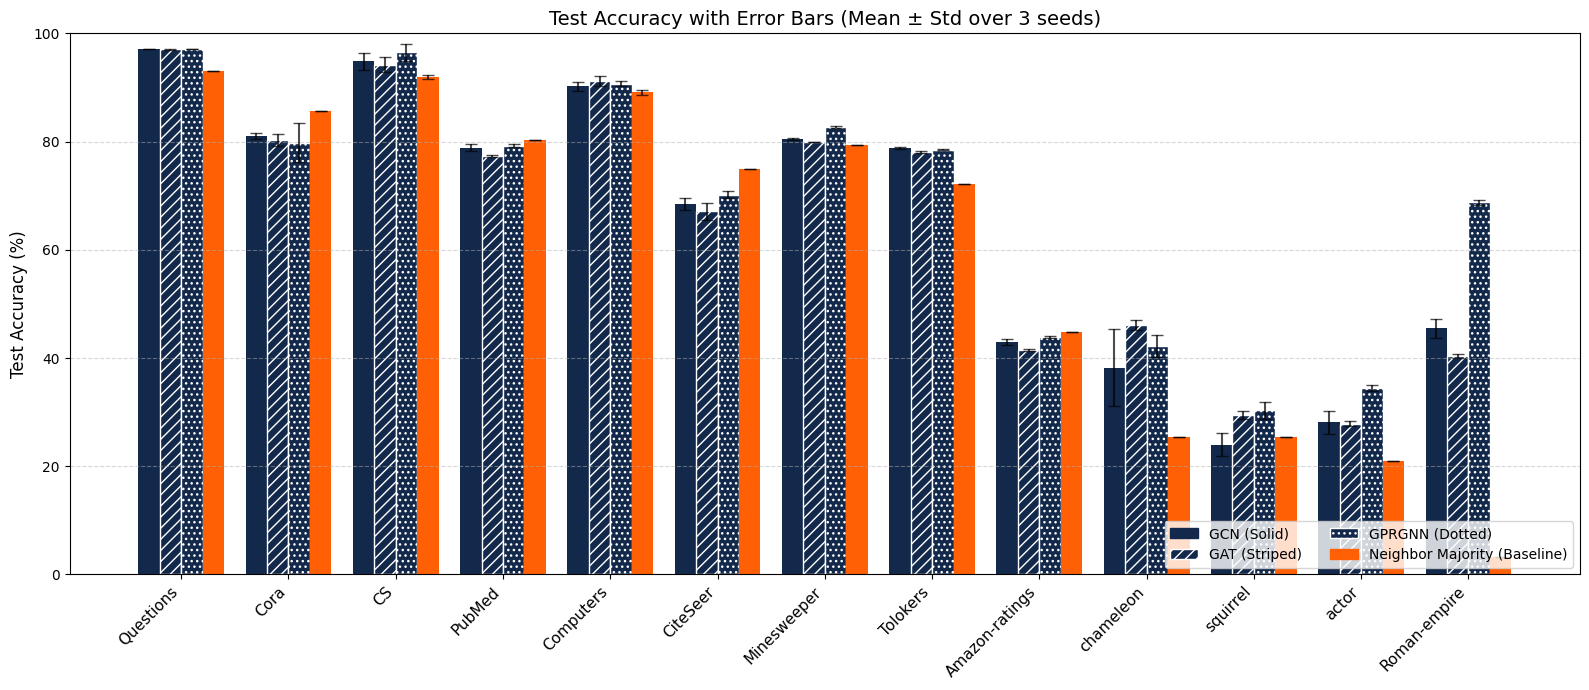

In [ ]:
import copy
import math
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import pandas as pd
import traceback

from torch_geometric.datasets import (
    Planetoid,
    Coauthor,
    Amazon,
    HeterophilousGraphDataset,
    Actor,
    WikipediaNetwork,
    WebKB,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

# ----------------------------
# Plotting Configuration
# ----------------------------
ILLINI_BLUE = '#13294B'
ILLINI_ORANGE = '#FF5F05'

def plot_accuracy_comparison_with_error(mean_data, std_data):
    """
    Accuracy comparison for GCN, GAT, GPRGNN, and Majority.
    """
    datasets = mean_data['datasets']
    if not datasets:
        print("No data to plot.")
        return

    # Models to plot
    models = ['GCN', 'GAT', 'GPRGNN', 'Majority']

    # Configuration for bars
    x = np.arange(len(datasets))
    width = 0.20

    # Styles for each model
    styles = {
        'GCN':      {'color': ILLINI_BLUE, 'label': 'GCN', 'hatch': ''},
        'GAT':      {'color': ILLINI_BLUE, 'label': 'GAT', 'hatch': '///', 'edgecolor': 'white'},
        'GPRGNN':   {'color': ILLINI_BLUE, 'label': 'GPRGNN', 'hatch': '...', 'edgecolor': 'white'},
        'Majority': {'color': ILLINI_ORANGE, 'label': 'Majority', 'hatch': ''}
    }

    # Offsets for side-by-side bars
    offsets = [-1.5, -0.5, 0.5, 1.5]

    fig, ax = plt.subplots(figsize=(16, 7))

    for i, model in enumerate(models):
        means = mean_data[model]
        stds = std_data[model]
        style = styles[model]

        # Plot Bar with Error Bars (yerr)
        ax.bar(x + offsets[i] * width, means, width,
               yerr=stds, capsize=4, error_kw={'linewidth': 1.5, 'alpha': 0.7},
               label=style['label'], color=style['color'],
               hatch=style.get('hatch'), edgecolor=style.get('edgecolor'))

    # Formatting
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_title('Test Accuracy with Error Bars (Mean ± Std over 3 seeds)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=11)
    ax.set_ylim(0, 100)

    # Custom Legend
    legend_handles = [
        mpatches.Patch(color=ILLINI_BLUE, label='GCN (Solid)'),
        mpatches.Patch(facecolor=ILLINI_BLUE, hatch='///', edgecolor='white', label='GAT (Striped)'),
        mpatches.Patch(facecolor=ILLINI_BLUE, hatch='...', edgecolor='white', label='GPRGNN (Dotted)'),
        mpatches.Patch(color=ILLINI_ORANGE, label='Neighbor Majority (Baseline)'),
    ]
    ax.legend(handles=legend_handles, loc='lower right', ncol=2)

    ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('accuracy_comparison_errors.png')
    print("Plot saved to accuracy_comparison_errors.png")
    plt.show()

# ----------------------------
# Utils & Predictors
# ----------------------------

def predict_neighbor_majority(data, device):
    """
    Predicts the label of a node based on the majority label of its neighbors.
    """
    num_nodes = data.num_nodes
    num_classes = int(data.y.max().item()) + 1

    one_hot = F.one_hot(data.y, num_classes=num_classes).float()
    # Ensure values and adj are on the correct device
    vals = torch.ones(data.edge_index.size(1), device=device)
    adj = torch.sparse_coo_tensor(data.edge_index, vals, (num_nodes, num_nodes))

    votes = torch.sparse.mm(adj, one_hot)
    preds = votes.argmax(dim=1)
    return preds

def get_accuracy(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    # Strict CPU enforcement
    if preds_or_logits_cpu.is_cuda: preds_or_logits_cpu = preds_or_logits_cpu.cpu()
    if y_cpu.is_cuda: y_cpu = y_cpu.cpu()
    if test_mask_cpu.is_cuda: test_mask_cpu = test_mask_cpu.cpu()

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    return (correct_test.sum().item() / int(eval_mask.sum())) * 100.0

# ----------------------------
# Loaders
# ----------------------------
def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)
def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)
def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)
def load_hetero_benchmark(name, root="./data/Heterophilous"):
    return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)
def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(root=f"{root}/{name}", name=name, geom_gcn_preprocess=True)
def load_actor(name, root="./data/Actor"):
    return Actor(root=f"{root}/{name}")
def get_masks(data):
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
    if train_mask.dim() == 2:
        train_mask, val_mask, test_mask = train_mask[:, 0], val_mask[:, 0], test_mask[:, 0]
    return train_mask, val_mask, test_mask

# ----------------------------
# Main Execution
# ----------------------------

if __name__ == "__main__":
    # 1. Define Seeds
    SEEDS = [42, 43, 44]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    print(f"Running experiments over {len(SEEDS)} seeds: {SEEDS}")

    homophilous = [
        ("Questions", load_hetero_benchmark),
        ("Cora", load_planetoid),
        ("CS", load_coauthor),
        ("PubMed", load_planetoid),
        ("Computers", load_amazon),
        ("CiteSeer", load_planetoid),
    ]

    heterophilous = [
        ("Minesweeper", load_hetero_benchmark),
        ("Tolokers", load_hetero_benchmark),
        ("Amazon-ratings", load_hetero_benchmark),
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("actor", load_actor),
        ("Roman-empire", load_hetero_benchmark),
    ]

    # Data structures to store results
    # raw_results[dataset_name][model_name] = [acc_seed1, acc_seed2, ...]
    raw_results = defaultdict(lambda: defaultdict(list))
    dataset_names_ordered = []

    for group_name, datasets in [("Homophilous", homophilous), ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            try:
                dataset_names_ordered.append(name)
                print(f"\nProcessing {name}...")

                # Iterate over seeds
                for seed in SEEDS:
                    if 'set_seed' in globals(): set_seed(seed)

                    dataset = loader_fn(name)
                    # FIX: Explicit detach and cpu move
                    data_cpu = dataset[0].detach().cpu()
                    data_dev = data_cpu.clone().to(device)

                    train_mask, val_mask, test_mask = get_masks(data_cpu)

                    in_channels = data_dev.num_features
                    out_channels = int(data_dev.y.max().item() + 1)

                    # --- 2. Evaluate Models ---
                    model_configs = [
                        (GCN, "GCN"),
                        (GAT, "GAT"),
                        (GPRGNN, "GPRGNN")
                    ]

                    for ModelClass, model_name in model_configs:
                        model = ModelClass(in_channels, 64, out_channels).to(device)

                        # Pass seed to manager for unique caching
                        model = manager.load_or_train(
                            train_fn=train_one_run,
                            model=model,
                            data_dev=data_dev,
                            dataset_name=name,
                            model_name=model_name,
                            seed=seed,
                            train_mask=train_mask.to(device),
                            epochs=200
                        )

                        model.eval()
                        with torch.no_grad():
                            logits = model(data_dev.x, data_dev.edge_index).detach().cpu()

                        acc = get_accuracy(logits, data_cpu.y, test_mask)
                        raw_results[name][model_name].append(acc)

                        del logits, model
                        gc.collect()

                    # --- 3. Evaluate Majority (Baseline) ---
                    # Ensure prediction happens on device but result is CPU
                    preds_maj = predict_neighbor_majority(data_dev, device).detach().cpu()
                    acc_maj = get_accuracy(preds_maj, data_cpu.y, test_mask)
                    raw_results[name]['Majority'].append(acc_maj)

                    del data_dev, dataset, data_cpu
                    if torch.cuda.is_available(): torch.cuda.empty_cache()

                # End of seeds loop -> Summarize this dataset
                print(f"  --> Summary for {name}:")
                for m in ['GCN', 'GAT', 'GPRGNN', 'Majority']:
                    runs = raw_results[name][m]
                    mean_val = np.mean(runs)
                    std_val = np.std(runs, ddof=1) # Sample standard deviation
                    print(f"      {m:8s}: {mean_val:.2f} ± {std_val:.2f}")

            except Exception as e:
                print(f"Skipping {name} due to error:")
                traceback.print_exc()

    # --- Prepare Data for Plotting ---
    mean_data = defaultdict(list)
    std_data = defaultdict(list)

    # Filter datasets that actually ran (in case of errors)
    valid_datasets = [d for d in dataset_names_ordered if d in raw_results]
    mean_data['datasets'] = valid_datasets
    std_data['datasets'] = valid_datasets

    for name in valid_datasets:
        for model in ['GCN', 'GAT', 'GPRGNN', 'Majority']:
            runs = raw_results[name][model]
            if runs:
                mean_data[model].append(np.mean(runs))
                std_data[model].append(np.std(runs, ddof=1))
            else:
                mean_data[model].append(0)
                std_data[model].append(0)

    # --- Generate Updated Plot ---
    print("\nGenerating Accuracy Plot with Error Bars...")
    plot_accuracy_comparison_with_error(mean_data, std_data)

## Experiment 2.2: Comparing GCN and GAT to MLP baseline.

Device: cuda
Running experiments over 3 seeds: [42, 43, 44]

=== Homophilous datasets ===

Processing Questions...
Random seed set to 42
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
✅ Found cached model for Questions (MLP). Loading from disk...
Random seed set to 43
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
✅ Found cached model for Questions (MLP). Loading from disk...
Random seed set to 44
✅ Found cached model for Questions (GCN). Loading from disk...
✅ Found cached model for Questions (GAT). Loading from disk...
✅ Found cached model for Questions (GPRGNN). Loading from disk...
✅ Found cached model for Questions (MLP). Loading from disk...
  --> Summary for Questions:
      GCN     : 97.02 ± 0

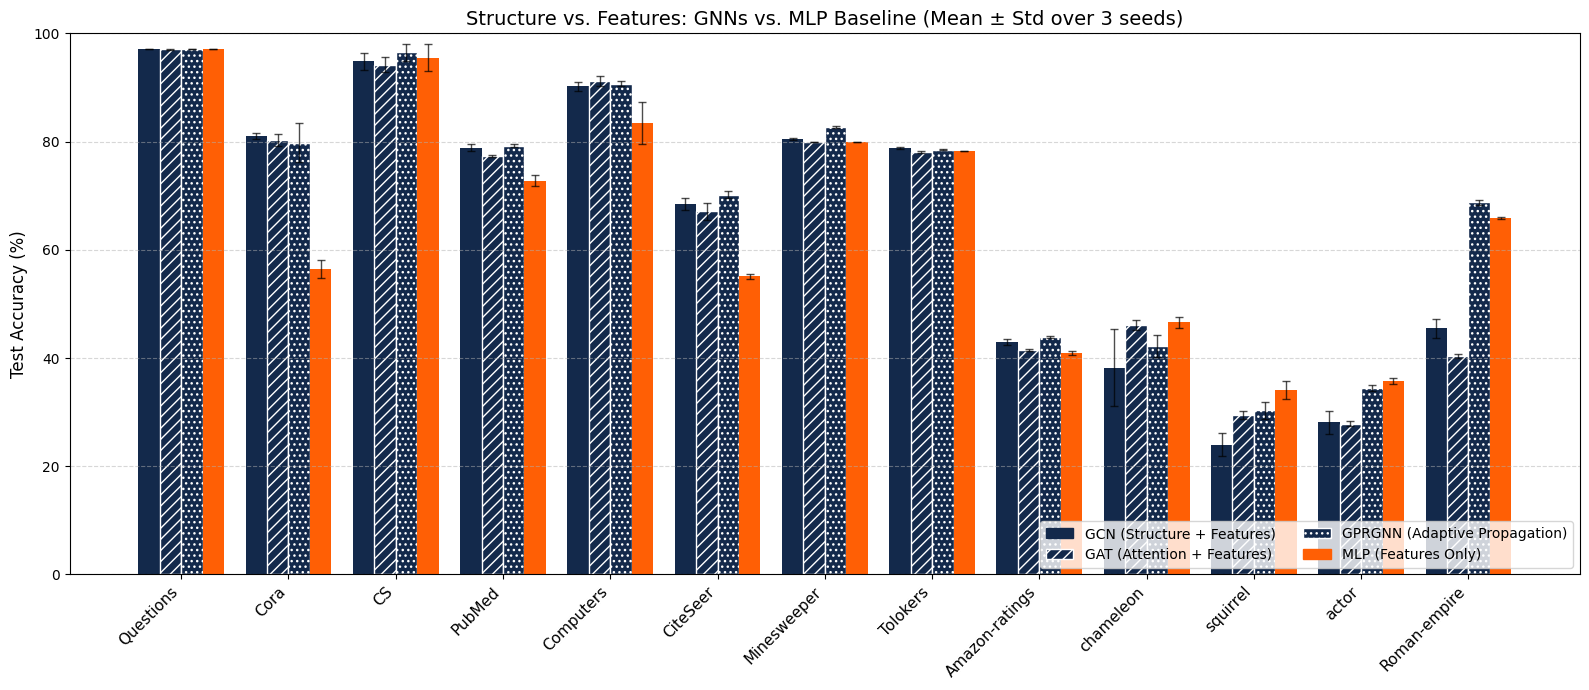

In [ ]:
import copy
import math
import gc
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import defaultdict
import pandas as pd
import traceback

from torch_geometric.datasets import (
    Planetoid,
    Coauthor,
    Amazon,
    HeterophilousGraphDataset,
    Actor,
    WikipediaNetwork,
    WebKB,
)
from torch_geometric.transforms import RandomNodeSplit

# ----------------------------
# Plotting Configuration
# ----------------------------
ILLINI_BLUE = '#13294B'
ILLINI_ORANGE = '#FF5F05'

def plot_gnn_vs_mlp_with_error(mean_data, std_data):
    """
    Plots accuracy with Error Bars (Std Dev) for GCN, GAT, GPRGNN, and MLP.
    """
    datasets = mean_data['datasets']
    if not datasets:
        print("No data to plot.")
        return

    # Extract Data
    gcn_mean = mean_data['GCN']
    gcn_std = std_data['GCN']

    gat_mean = mean_data['GAT']
    gat_std = std_data['GAT']

    gpr_mean = mean_data['GPRGNN']
    gpr_std = std_data['GPRGNN']

    mlp_mean = mean_data['MLP']
    mlp_std = std_data['MLP']

    x = np.arange(len(datasets))
    width = 0.20  # width for 4 bars

    fig, ax = plt.subplots(figsize=(16, 7))

    # Error bar settings
    err_kw = {'linewidth': 1, 'capsize': 3, 'alpha': 0.7}

    # 1. GCN (Blue Solid)
    ax.bar(x - 1.5*width, gcn_mean, width, yerr=gcn_std,
           label='GCN', color=ILLINI_BLUE, error_kw=err_kw)

    # 2. GAT (Blue Striped)
    ax.bar(x - 0.5*width, gat_mean, width, yerr=gat_std,
           label='GAT', color=ILLINI_BLUE, hatch='///', edgecolor='white', error_kw=err_kw)

    # 3. GPRGNN (Blue Dotted)
    ax.bar(x + 0.5*width, gpr_mean, width, yerr=gpr_std,
           label='GPRGNN', color=ILLINI_BLUE, hatch='...', edgecolor='white', error_kw=err_kw)

    # 4. MLP (Orange Solid)
    ax.bar(x + 1.5*width, mlp_mean, width, yerr=mlp_std,
           label='MLP', color=ILLINI_ORANGE, error_kw=err_kw)

    # Labels and formatting
    ax.set_ylabel('Test Accuracy (%)', fontsize=12)
    ax.set_title('Structure vs. Features: GNNs vs. MLP Baseline (Mean ± Std over 3 seeds)', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(datasets, rotation=45, ha='right', fontsize=11)
    ax.set_ylim(0, 100)

    # Custom Legend
    legend_handles = [
        mpatches.Patch(color=ILLINI_BLUE, label='GCN (Structure + Features)'),
        mpatches.Patch(facecolor=ILLINI_BLUE, hatch='///', edgecolor='white', label='GAT (Attention + Features)'),
        mpatches.Patch(facecolor=ILLINI_BLUE, hatch='...', edgecolor='white', label='GPRGNN (Adaptive Propagation)'),
        mpatches.Patch(color=ILLINI_ORANGE, label='MLP (Features Only)'),
    ]
    ax.legend(handles=legend_handles, loc='lower right', ncol=2)

    ax.grid(axis='y', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('gnn_vs_mlp_comparison_error.png')
    print("Plot saved to gnn_vs_mlp_comparison_error.png")
    plt.show()

# ----------------------------
# Models
# ----------------------------

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None):
        # Ignore edge_index (structure) completely
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin3(x)
        return x

# ----------------------------
# Training & Utils
# ----------------------------

def get_accuracy(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    # Strict CPU enforcement
    if preds_or_logits_cpu.is_cuda: preds_or_logits_cpu = preds_or_logits_cpu.cpu()
    if y_cpu.is_cuda: y_cpu = y_cpu.cpu()
    if test_mask_cpu.is_cuda: test_mask_cpu = test_mask_cpu.cpu()

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    return (correct_test.sum().item() / int(eval_mask.sum())) * 100.0

# ----------------------------
# Loaders
# ----------------------------
def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)
def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)
def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)
def load_hetero_benchmark(name, root="./data/Heterophilous"):
    return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)
def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(root=f"{root}/{name}", name=name, geom_gcn_preprocess=True)
def load_actor(name, root="./data/Actor"):
    return Actor(root=f"{root}/{name}")
def get_masks(data):
    train_mask, val_mask, test_mask = data.train_mask, data.val_mask, data.test_mask
    if train_mask.dim() == 2:
        train_mask, val_mask, test_mask = train_mask[:, 0], val_mask[:, 0], test_mask[:, 0]
    return train_mask, val_mask, test_mask

# ----------------------------
# Main Execution
# ----------------------------

if __name__ == "__main__":
    # 1. Define Seeds
    SEEDS = [42, 43, 44]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    print(f"Running experiments over {len(SEEDS)} seeds: {SEEDS}")

    homophilous = [
        ("Questions", load_hetero_benchmark),
        ("Cora", load_planetoid),
        ("CS", load_coauthor),
        ("PubMed", load_planetoid),
        ("Computers", load_amazon),
        ("CiteSeer", load_planetoid),
    ]

    heterophilous = [
        ("Minesweeper", load_hetero_benchmark),
        ("Tolokers", load_hetero_benchmark),
        ("Amazon-ratings", load_hetero_benchmark),
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("actor", load_actor),
        ("Roman-empire", load_hetero_benchmark),
    ]

    # Data structure: raw_results[dataset_name][model_name] = [acc_s1, acc_s2, acc_s3]
    raw_results = defaultdict(lambda: defaultdict(list))
    dataset_names_ordered = []

    for group_name, datasets in [("Homophilous", homophilous), ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            try:
                dataset_names_ordered.append(name)
                print(f"\nProcessing {name}...")

                # Iterate over seeds
                for seed in SEEDS:
                    if 'set_seed' in globals(): set_seed(seed)

                    dataset = loader_fn(name)
                    # FIX: Explicit detach and cpu move
                    data_cpu = dataset[0].detach().cpu()
                    data_dev = data_cpu.clone().to(device)

                    train_mask, val_mask, test_mask = get_masks(data_cpu)

                    in_channels = data_dev.num_features
                    out_channels = int(data_dev.y.max().item() + 1)

                    # --- 2. Evaluate Models ---
                    models_to_run = [
                        (GCN, "GCN"),
                        (GAT, "GAT"),
                        (GPRGNN, "GPRGNN"),
                        (MLP, "MLP")
                    ]

                    for ModelClass, model_name in models_to_run:
                        model = ModelClass(in_channels, 64, out_channels).to(device)

                        # Pass seed to manager for unique caching
                        model = manager.load_or_train(
                            train_fn=train_one_run,
                            model=model,
                            data_dev=data_dev,
                            dataset_name=name,
                            model_name=model_name,
                            seed=seed,
                            train_mask=train_mask.to(device),
                            epochs=200
                        )

                        model.eval()
                        with torch.no_grad():
                            # Inference on GPU, move logits to CPU
                            logits = model(data_dev.x, data_dev.edge_index).detach().cpu()

                        acc = get_accuracy(logits, data_cpu.y, test_mask)
                        raw_results[name][model_name].append(acc)

                        del logits, model
                        gc.collect()

                    # Cleanup per seed
                    del data_dev, dataset, data_cpu
                    if torch.cuda.is_available(): torch.cuda.empty_cache()

                # End of seeds loop -> Summarize this dataset
                print(f"  --> Summary for {name}:")
                for m in ['GCN', 'GAT', 'GPRGNN', 'MLP']:
                    runs = raw_results[name][m]
                    if runs:
                        print(f"      {m:8s}: {np.mean(runs):.2f} ± {np.std(runs, ddof=1):.2f}")
                    else:
                        print(f"      {m:8s}: N/A")

            except Exception as e:
                print(f"Skipping {name} due to error:")
                traceback.print_exc()

    # --- Prepare Data for Plotting ---
    mean_data = defaultdict(list)
    std_data = defaultdict(list)

    # Filter datasets that actually ran
    valid_datasets = [d for d in dataset_names_ordered if d in raw_results]
    mean_data['datasets'] = valid_datasets
    std_data['datasets'] = valid_datasets

    for name in valid_datasets:
        for model in ['GCN', 'GAT', 'GPRGNN', 'MLP']:
            runs = raw_results[name][model]
            if runs:
                mean_data[model].append(np.mean(runs))
                std_data[model].append(np.std(runs, ddof=1))
            else:
                mean_data[model].append(0.0)
                std_data[model].append(0.0)

    # --- Generate Updated Plot ---
    print("\nGenerating MLP Comparison Plot with Error Bars...")
    plot_gnn_vs_mlp_with_error(mean_data, std_data)

## Experiment 2.3: Clustering through layers


<>:266: SyntaxWarning: invalid escape sequence '\h'
<>:266: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipython-input-3980897891.py:266: SyntaxWarning: invalid escape sequence '\h'
  axes[2].set_title(f"{name}: Message Passing ($\hat{{A}}XW$)")


Device: cuda

=== Dataset: Cora (Homophilous) ===
⚡ No cache found for Cora (GCNWithRepr). Training now...
💾 Model saved to /content/drive/MyDrive/saved_models/Cora_GCNWithRepr_seed42.pt
Plot saved to Cora_3stage_representation_analysis.png


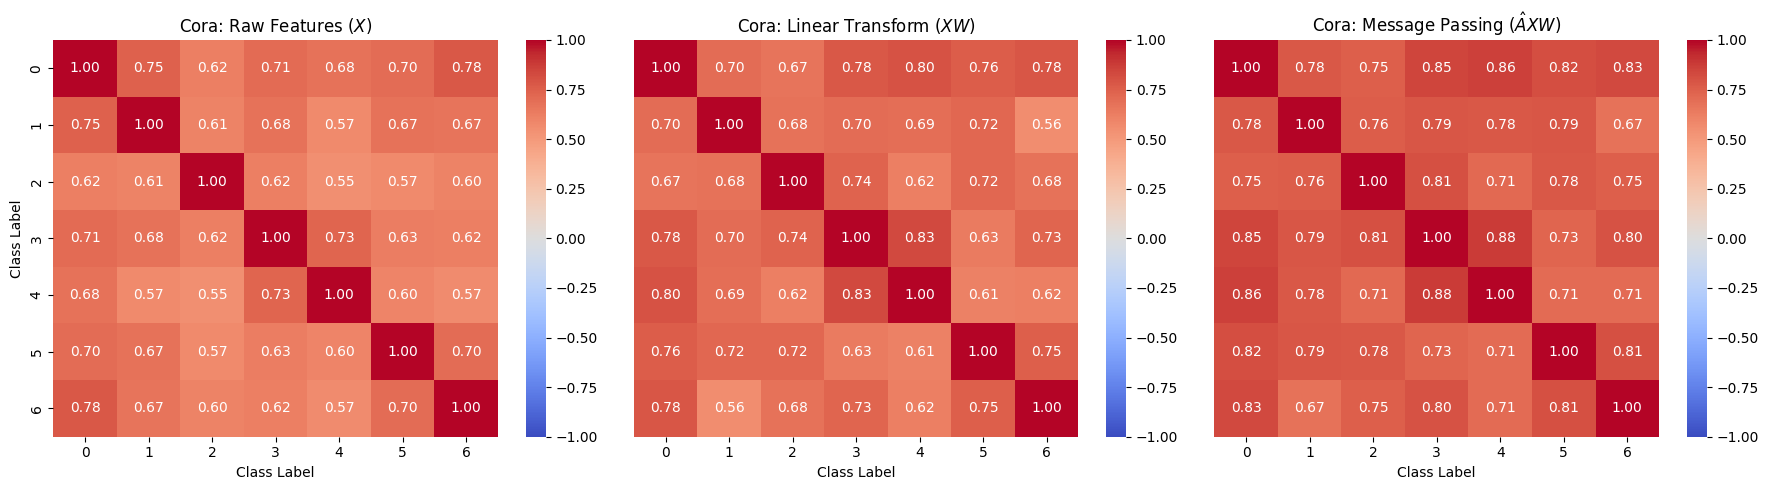


=== Dataset: chameleon (Heterophilous) ===
⚡ No cache found for chameleon (GCNWithRepr). Training now...
💾 Model saved to /content/drive/MyDrive/saved_models/chameleon_GCNWithRepr_seed42.pt
Plot saved to chameleon_3stage_representation_analysis.png


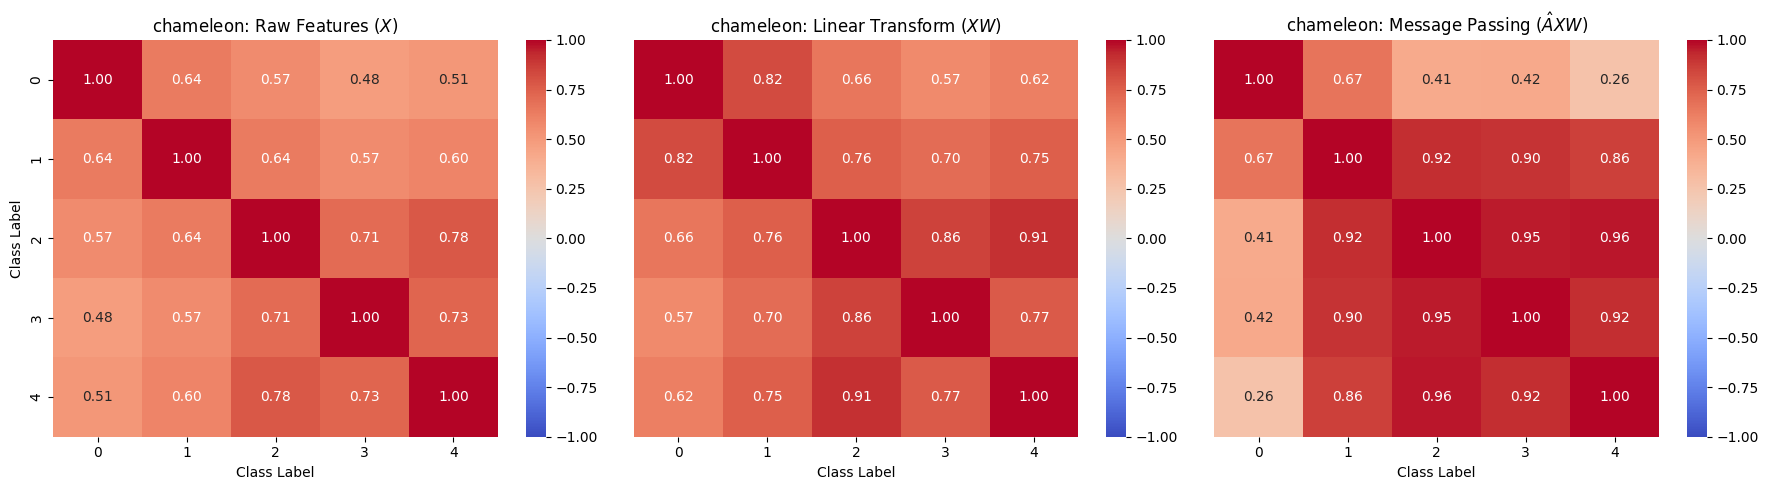

In [ ]:
    import copy
    import math
    import gc
    import numpy as np
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    import random

    from torch_geometric.nn import GCNConv
    from torch_geometric.datasets import Planetoid, WikipediaNetwork
    from torch_geometric.transforms import RandomNodeSplit

    # ---------------------------------------------------------------------------
    # Reproducibility & Manager Setup (Assumed to be defined, but included for safety)
    # ---------------------------------------------------------------------------

    def set_seed(seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

    # Simple mock manager if the previous cell wasn't run,
    # ensuring this cell runs standalone if needed.
    if 'manager' not in globals():
        class ExperimentManager:
            def __init__(self, cache_dir="./saved_models"):
                self.cache_dir = cache_dir
                os.makedirs(self.cache_dir, exist_ok=True)
            def get_path(self, dataset_name, model_name, seed):
                return os.path.join(self.cache_dir, f"{dataset_name}_{model_name}_seed{seed}.pt")
            def load_or_train(self, train_fn, model, data_dev, dataset_name, model_name, seed=42, **kwargs):
                path = self.get_path(dataset_name, model_name, seed)
                if os.path.exists(path):
                    print(f"✅ Found cached model for {dataset_name}. Loading...")
                    model.load_state_dict(torch.load(path))
                    model.eval()
                    return model
                else:
                    print(f"⚡ Training {dataset_name}...")
                    model = train_fn(model, data_dev, **kwargs)
                    torch.save(model.state_dict(), path)
                    return model
        manager = ExperimentManager()

    # ---------------------------------------------------------------------------
    # Model
    # ---------------------------------------------------------------------------

    class GCNWithRepr(torch.nn.Module):
        """
        Two-layer GCN.
        Returns logits and pre-activation hidden h1 when requested.
        """
        def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
            super().__init__()
            self.conv1 = GCNConv(in_channels, hidden_channels,
                                add_self_loops=True, normalize=True)
            self.conv2 = GCNConv(hidden_channels, out_channels,
                                add_self_loops=True, normalize=True)
            self.dropout = dropout

        def forward(self, x, edge_index, return_hidden=False):
            # Ensure data lives on same device as model
            dev = next(self.parameters()).device
            if x.device != dev:
                x = x.to(dev)
            if edge_index.device != dev:
                edge_index = edge_index.to(dev)

            # h1 is the result of Linear Transform + Neighbor Aggregation
            h1 = self.conv1(x, edge_index)

            h = F.relu(h1)
            h = F.dropout(h, p=self.dropout, training=self.training)
            out = self.conv2(h, edge_index)

            if return_hidden:
                return out, h1
            return out

    # ---------------------------------------------------------------------------
    # Data loaders + masks
    # ---------------------------------------------------------------------------

    def load_planetoid(name, root="./data/Planetoid"):
        return Planetoid(root=f"{root}/{name}", name=name)

    def load_wikipedia(name, root="./data/WikipediaNetwork"):
        return WikipediaNetwork(
            root=f"{root}/{name}",
            name=name,
            geom_gcn_preprocess=True,
        )

    def get_masks(data_cpu):
        train_mask = data_cpu.train_mask
        val_mask = data_cpu.val_mask
        test_mask = data_cpu.test_mask

        if train_mask.dim() == 2:
            train_mask = train_mask[:, 0]
            val_mask = val_mask[:, 0]
            test_mask = test_mask[:, 0]

        return train_mask, val_mask, test_mask

    # ---------------------------------------------------------------------------
    # Training (Compatible with Manager)
    # ---------------------------------------------------------------------------

    def train_gcn_step(model, data_dev, train_mask, val_mask, epochs=200, lr=0.005, weight_decay=5e-4):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        best_val_acc = 0.0
        best_state = None

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
            loss.backward()
            optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                logits_val = model(data_dev.x, data_dev.edge_index, return_hidden=False)
                preds_val = logits_val.argmax(dim=-1)
                val_correct = (preds_val[val_mask] == data_dev.y[val_mask]).sum().item()
                val_acc = val_correct / int(val_mask.sum())

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = copy.deepcopy(model.state_dict())

        if best_state is not None:
            model.load_state_dict(best_state)

        return model

    # ---------------------------------------------------------------------------
    # Analysis Utils
    # ---------------------------------------------------------------------------

    def compute_class_means(features, labels):
        """
        Generic function to compute mean feature vector per class.
        features: [N, D] tensor
        labels: [N] tensor
        Returns: [C, D] tensor of means
        """
        features = features.cpu()
        labels = labels.cpu()
        num_classes = int(labels.max().item() + 1)
        dim = features.size(1)

        means = torch.zeros(num_classes, dim)
        counts = torch.zeros(num_classes)

        for c in range(num_classes):
            mask = (labels == c)
            if mask.sum() > 0:
                means[c] = features[mask].mean(dim=0)
                counts[c] = mask.sum()

        return means, counts

    def pairwise_cosine_matrix(M):
        """
        M: [C, D] matrix of C prototypes.
        Returns: [C, C] cosine similarity matrix.
        """
        M_norm = F.normalize(M, p=2, dim=-1)
        return M_norm @ M_norm.t()

    def analyze_dataset_extended(name, group_name, loader_fn,
                                hidden_channels=64, epochs=200, device=None):
        print(f"\n=== Dataset: {name} ({group_name}) ===")

        # 1. Load Data
        dataset = loader_fn(name)
        data_cpu = dataset[0].cpu()
        y_cpu = data_cpu.y.cpu()

        train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

        data_dev = data_cpu.to(device)
        train_mask = train_mask_cpu.to(device)
        val_mask = val_mask_cpu.to(device)

        in_channels = data_cpu.num_features
        out_channels = int(data_cpu.y.max().item() + 1)

        # 2. Instantiate Model
        model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)

        # 3. Load or Train (Using Manager)
        SEED = 42
        model = manager.load_or_train(
            train_fn=train_gcn_step,
            model=model,
            data_dev=data_dev,
            dataset_name=name,
            model_name="GCNWithRepr",
            seed=SEED,
            train_mask=train_mask,
            val_mask=val_mask,
            epochs=epochs,
            lr=0.005,
            weight_decay=5e-4
        )

        # 4. Extract Representations on CPU
        model_cpu = model.to("cpu").eval()
        with torch.no_grad():
            # h1_prop: The actual GCN output (Linear + Aggregation)
            logits, h1_prop = model_cpu(data_cpu.x, data_cpu.edge_index, return_hidden=True)
            logits = logits.cpu()
            h1_prop = h1_prop.cpu()

        # 5. Compute Class Prototypes (Means)

        # A. Feature Space (Raw Input)
        mu_x, counts = compute_class_means(data_cpu.x, y_cpu)

        # B. Linear Space (Transformation Only, No Aggregation)
        # This simulates an MLP layer: XW
        with torch.no_grad():
            mu_lin = model_cpu.conv1.lin(mu_x)

        # C. Propagated Space (Transformation + Aggregation)
        # This is the actual GCN layer output: A(XW)
        mu_prop, _ = compute_class_means(h1_prop, y_cpu)

        # 6. Compute Cosine Similarity Matrices
        cos_x = pairwise_cosine_matrix(mu_x).numpy()
        cos_lin = pairwise_cosine_matrix(mu_lin).numpy()
        cos_prop = pairwise_cosine_matrix(mu_prop).numpy()

        # 7. Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Plot 1: Raw Features
        sns.heatmap(cos_x, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[0])
        axes[0].set_title(f"{name}: Raw Features ($X$)")
        axes[0].set_xlabel("Class Label")
        axes[0].set_ylabel("Class Label")

        # Plot 2: Linear Transform
        sns.heatmap(cos_lin, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1])
        axes[1].set_title(f"{name}: Linear Transform ($XW$)")
        axes[1].set_xlabel("Class Label")
        axes[1].set_yticks([]) # Hide y-axis for cleaner look

        # Plot 3: Message Passing
        sns.heatmap(cos_prop, vmin=-1, vmax=1, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[2])
        axes[2].set_title(f"{name}: Message Passing ($\hat{{A}}XW$)")
        axes[2].set_xlabel("Class Label")
        axes[2].set_yticks([])

        plt.tight_layout()
        filename = f"{name}_3stage_representation_analysis.png"
        plt.savefig(filename)
        print(f"Plot saved to {filename}")
        plt.show()

        # Cleanup
        del dataset, data_cpu, data_dev, y_cpu
        del model, model_cpu, logits, h1_prop
        del mu_x, mu_lin, mu_prop
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ---------------------------------------------------------------------------
    # Main Execution
    # ---------------------------------------------------------------------------

    if __name__ == "__main__":
        if 'set_seed' in globals():
            set_seed(42)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print("Device:", device)

        datasets = [
            ("Cora", "Homophilous", load_planetoid),
            ("chameleon", "Heterophilous", load_wikipedia),
        ]

        for name, group_name, loader_fn in datasets:
            analyze_dataset_extended(
                name,
                group_name,
                loader_fn,
                hidden_channels=64,
                epochs=200,
                device=device,
            )


## Experiment: 3: Measuring loss gradient against each message

Random seed set to 42

Dataset: Questions
⚡ No cache found for Questions (GCN). Training...
💾 Model saved to ./saved_models/Questions_GCN_seed42.pt
  GCN | Acc: 97.0% | Valid Nodes: 2084
⚡ No cache found for Questions (GAT). Training...
💾 Model saved to ./saved_models/Questions_GAT_seed42.pt
  GAT | Acc: 97.0% | Valid Nodes: 2084

Dataset: Cora
⚡ No cache found for Cora (GCN). Training...
💾 Model saved to ./saved_models/Cora_GCN_seed42.pt
  GCN | Acc: 81.4% | Valid Nodes: 299
⚡ No cache found for Cora (GAT). Training...
💾 Model saved to ./saved_models/Cora_GAT_seed42.pt
  GAT | Acc: 80.1% | Valid Nodes: 299

Dataset: CS
⚡ No cache found for CS (GCN). Training...
💾 Model saved to ./saved_models/CS_GCN_seed42.pt
  GCN | Acc: 94.1% | Valid Nodes: 1709
⚡ No cache found for CS (GAT). Training...
💾 Model saved to ./saved_models/CS_GAT_seed42.pt
  GAT | Acc: 94.0% | Valid Nodes: 1709

Dataset: PubMed
⚡ No cache found for PubMed (GCN). Training...
💾 Model saved to ./saved_models/PubMed_GCN_see

Processing...
Done!



Dataset: chameleon
⚡ No cache found for chameleon (GCN). Training...
💾 Model saved to ./saved_models/chameleon_GCN_seed42.pt
  GCN | Acc: 39.3% | Valid Nodes: 130
⚡ No cache found for chameleon (GAT). Training...
💾 Model saved to ./saved_models/chameleon_GAT_seed42.pt
  GAT | Acc: 46.1% | Valid Nodes: 130

Dataset: actor
⚡ No cache found for actor (GCN). Training...
💾 Model saved to ./saved_models/actor_GCN_seed42.pt
  GCN | Acc: 28.2% | Valid Nodes: 449
⚡ No cache found for actor (GAT). Training...
💾 Model saved to ./saved_models/actor_GAT_seed42.pt
  GAT | Acc: 29.3% | Valid Nodes: 449


Processing...
Done!



Dataset: squirrel
⚡ No cache found for squirrel (GCN). Training...
💾 Model saved to ./saved_models/squirrel_GCN_seed42.pt
  GCN | Acc: 25.1% | Valid Nodes: 280
⚡ No cache found for squirrel (GAT). Training...
💾 Model saved to ./saved_models/squirrel_GAT_seed42.pt
  GAT | Acc: 29.9% | Valid Nodes: 280

Dataset: Roman-empire
⚡ No cache found for Roman-empire (GCN). Training...
💾 Model saved to ./saved_models/Roman-empire_GCN_seed42.pt
  GCN | Acc: 44.1% | Valid Nodes: 632
⚡ No cache found for Roman-empire (GAT). Training...
💾 Model saved to ./saved_models/Roman-empire_GAT_seed42.pt
  GAT | Acc: 40.7% | Valid Nodes: 632


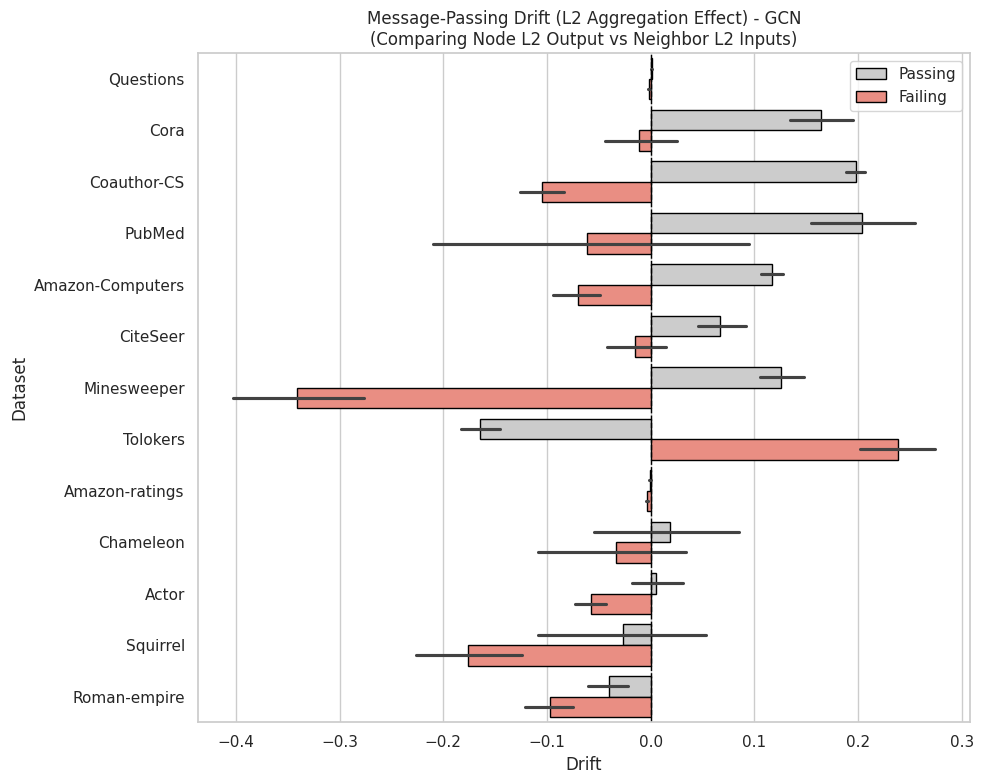

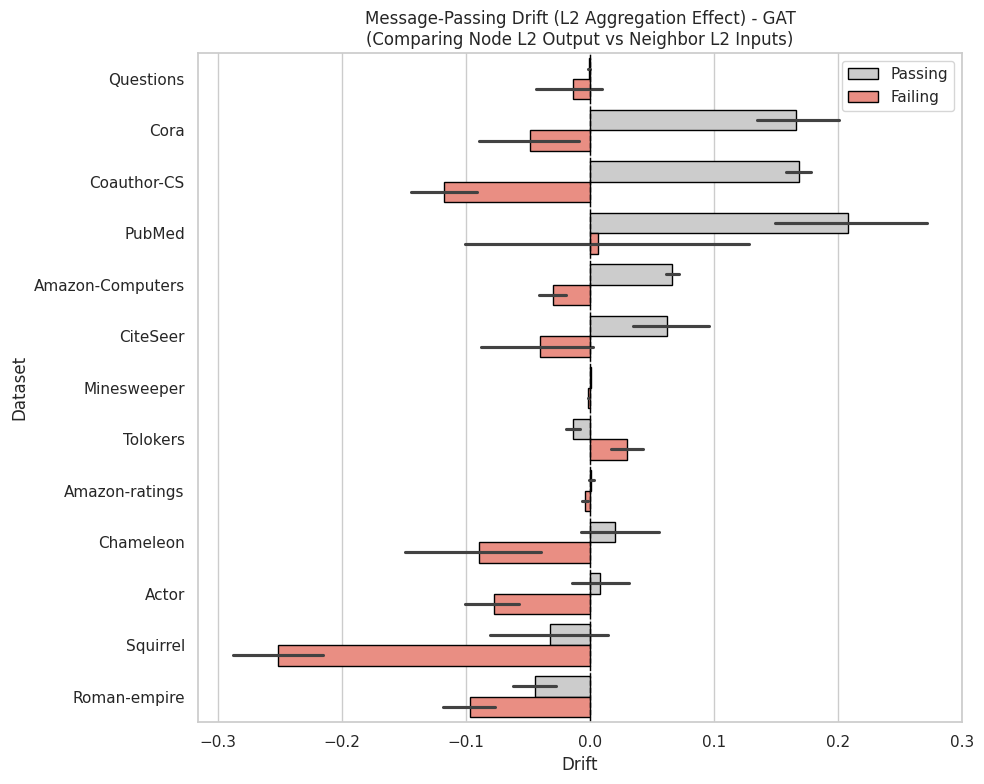

In [ ]:
import os
import torch
import numpy as np
import random
import copy
import math
import gc
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyG imports
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import (
    Planetoid, Coauthor, Amazon, HeterophilousGraphDataset, Actor, WikipediaNetwork
)
from torch_geometric.transforms import RandomNodeSplit

# ==========================================
# 1. REPRODUCIBILITY
# ==========================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")

# ==========================================
# 2. EXPERIMENT MANAGER
# ==========================================
class ExperimentManager:
    def __init__(self, cache_dir="./saved_models"):
        self.cache_dir = cache_dir
        os.makedirs(self.cache_dir, exist_ok=True)

    def get_path(self, dataset_name, model_name, seed):
        return os.path.join(self.cache_dir, f"{dataset_name}_{model_name}_seed{seed}.pt")

    def load_or_train(self, train_fn, model, data_dev, dataset_name, model_name, seed=42, **kwargs):
        path = self.get_path(dataset_name, model_name, seed)
        if os.path.exists(path):
            print(f"✅ Found cached model for {dataset_name} ({model_name}). Loading...")
            model.load_state_dict(torch.load(path))
            model.eval()
            return model
        else:
            print(f"⚡ No cache found for {dataset_name} ({model_name}). Training...")
            trained_model = train_fn(model, data_dev, **kwargs)
            torch.save(trained_model.state_dict(), path)
            print(f"💾 Model saved to {path}")
            return trained_model

manager = ExperimentManager()

# ==========================================
# 3. MODELS
# ==========================================
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def get_intermediate_layers(self, x, edge_index):
        """Helper to manually step through layers for the drift exp."""
        # Layer 1
        h1 = self.conv1(x, edge_index)
        h1 = F.relu(h1)
        # Note: Evaluation mode, so no dropout here ideally, or we keep it deterministic

        # Layer 2 - Split into Transform and Aggregation
        # GCNConv logic: x_trans = x @ weight; out = propagate(x_trans)
        x_trans = self.conv2.lin(h1)
        x_final = self.conv2(h1, edge_index)

        return x_trans, x_final

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Final layer: 1 head for classification
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def get_intermediate_layers(self, x, edge_index):
        # Layer 1
        h1 = self.conv1(x, edge_index)
        h1 = F.elu(h1)

        # Layer 2 - Split
        # GATConv logic: x_trans = lin(x); out = propagate(x_trans) + bias
        x_trans = self.conv2.lin(h1)
        x_final = self.conv2(h1, edge_index)

        return x_trans, x_final

def train_one_run(model, data_dev, train_mask, epochs=200, lr=0.005, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_state = None
    best_val_acc = 0.0
    val_mask = data_dev.val_mask if data_dev.val_mask.dim() == 1 else data_dev.val_mask[:, 0]

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_out = model(data_dev.x, data_dev.edge_index)
            val_acc = (val_out.argmax(1)[val_mask] == data_dev.y[val_mask]).float().mean().item()
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_state = copy.deepcopy(model.state_dict())

    if best_state: model.load_state_dict(best_state)
    return model

# ==========================================
# 4. DRIFT CALCULATION (Target vs Transformed Source)
# ==========================================
def compute_drift(x_target, x_source, edge_index, y):
    """
    x_target: The Final Node Embedding (Result of Aggregation)
    x_source: The Transformed Neighbor Embeddings (Input to Aggregation)
    """
    device = x_target.device
    src, dst = edge_index
    is_hom = (y[src] == y[dst])

    def get_centroid(mask):
        masked_src, masked_dst = src[mask], dst[mask]

        # Aggregating the SOURCE (Messages from neighbors)
        out = torch.zeros_like(x_target)
        out.index_add_(0, masked_dst, x_source[masked_src])

        deg = torch.zeros(x_target.size(0), device=device)
        deg.index_add_(0, masked_dst, torch.ones_like(masked_dst, dtype=torch.float))

        mask_nodes = deg > 0
        out[mask_nodes] = out[mask_nodes] / deg[mask_nodes].unsqueeze(1)
        return out, mask_nodes

    mean_hom, has_hom = get_centroid(is_hom)
    mean_het, has_het = get_centroid(~is_hom)

    # Comparing Target (Node) vs Source Means (Neighbors)
    drift = F.cosine_similarity(x_target, mean_hom) - F.cosine_similarity(x_target, mean_het)

    drift[~(has_hom & has_het)] = 0.0

    return drift.cpu(), (has_hom & has_het).cpu()

# ==========================================
# 5. LOADERS
# ==========================================
def load_planetoid(name): return Planetoid(root=f"./data/Planetoid/{name}", name=name)
def load_coauthor(name):
    return Coauthor(root=f"./data/Coauthor/{name}", name=name, transform=RandomNodeSplit("train_rest", num_val=0.1, num_test=0.2))
def load_amazon(name):
    return Amazon(root=f"./data/Amazon/{name}", name=name, transform=RandomNodeSplit("train_rest", num_val=0.1, num_test=0.2))
def load_hetero(name): return HeterophilousGraphDataset(root=f"./data/Heterophilous/{name}", name=name)
def load_wiki(name): return WikipediaNetwork(root=f"./data/Wikipedia/{name}", name=name, geom_gcn_preprocess=True)
def load_actor(name): return Actor(root=f"./data/Actor/{name}")

def get_pass_fail(logits, y, mask):
    preds = logits.argmax(1)
    correct = (preds == y)
    mask = mask.bool()
    passing = (correct & mask).nonzero(as_tuple=True)[0]
    failing = ((~correct) & mask).nonzero(as_tuple=True)[0]
    acc = (correct & mask).sum().item() / mask.sum().item()
    return passing, failing, acc * 100

# ==========================================
# 6. MAIN LOOP
# ==========================================
if __name__ == "__main__":
    SEED = 42
    set_seed(SEED)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    datasets_list = [
        ("Questions", load_hetero), ("Cora", load_planetoid), ("CS", load_coauthor),
        ("PubMed", load_planetoid), ("Computers", load_amazon), ("CiteSeer", load_planetoid),
        ("Minesweeper", load_hetero), ("Tolokers", load_hetero), ("Amazon-ratings", load_hetero),
        ("chameleon", load_wiki), ("actor", load_actor), ("squirrel", load_wiki), ("Roman-empire", load_hetero)
    ]

    results = []

    for name, loader in datasets_list:
        try:
            dataset = loader(name)
            data = dataset[0]
            mask = data.test_mask if data.test_mask.dim()==1 else data.test_mask[:,0]

            print(f"\nDataset: {name}")
            data = data.to(device)

            for Model, m_name in [(GCN, "GCN"), (GAT, "GAT")]:
                model = Model(data.num_features, 64, dataset.num_classes).to(device)
                model = manager.load_or_train(
                    train_one_run, model, data, name, m_name, SEED,
                    train_mask=(data.train_mask if data.train_mask.dim()==1 else data.train_mask[:,0]),
                    epochs=200
                )

                with torch.no_grad():
                    # Extract specific layers as requested
                    x_trans, x_final = model.get_intermediate_layers(data.x, data.edge_index)

                    # Compute Drift: Target=Final, Source=Transformed
                    drift, valid = compute_drift(x_final, x_trans, data.edge_index, data.y)

                    pass_idx, fail_idx, acc = get_pass_fail(x_final.cpu(), data.y.cpu(), mask.cpu())

                p_valid = pass_idx[valid[pass_idx]]
                f_valid = fail_idx[valid[fail_idx]]

                print(f"  {m_name} | Acc: {acc:.1f}% | Valid Nodes: {len(p_valid)+len(f_valid)}")

                for idx, label in [(p_valid, "Passing"), (f_valid, "Failing")]:
                    if len(idx) > 0:
                        df_chunk = pd.DataFrame({
                            "Dataset": name, "Model": m_name, "Type": label, "Drift": drift[idx].numpy()
                        })
                        results.append(df_chunk)

                del model, x_trans, x_final, drift
                torch.cuda.empty_cache()

        except Exception as e: print(f"Skipped {name}: {e}")

    # ==========================================
    # 7. PLOTTING
    # ==========================================
    if results:
        df = pd.concat(results)

        name_map = {"CS":"Coauthor-CS", "Computers":"Amazon-Computers", "chameleon":"Chameleon", "actor":"Actor", "squirrel":"Squirrel"}
        df["Dataset"] = df["Dataset"].replace(name_map)

        order = ["Questions", "Cora", "Coauthor-CS", "PubMed", "Amazon-Computers", "CiteSeer",
                 "Minesweeper", "Tolokers", "Amazon-ratings", "Chameleon", "Actor", "Squirrel", "Roman-empire"]
        order = [d for d in order if d in df["Dataset"].unique()]

        for m_name in ["GCN", "GAT"]:
            sub = df[df["Model"] == m_name]
            if sub.empty: continue

            plt.figure(figsize=(10, 8))
            sns.set_theme(style="whitegrid")

            sns.barplot(
                data=sub, x="Drift", y="Dataset", hue="Type", orient="h", order=order,
                palette={"Passing": ".8", "Failing": "salmon"}, edgecolor="black", errorbar=("ci", 95)
            )

            plt.axvline(0, color="black", linestyle="--", linewidth=1)
            plt.title(f"Message-Passing Drift (L2 Aggregation Effect) - {m_name}\n(Comparing Node L2 Output vs Neighbor L2 Inputs)")
            plt.legend(loc="upper right")
            plt.tight_layout()
            plt.show()


## Experiment: 3.1: Measuring embedding drift (Statistical Testing)

In [ ]:
    # ==========================================
    # 8. STATISTICAL TESTING + INTERPRETATION
    # ==========================================
    from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu, ttest_ind
    import numpy as np

    df_stats = df.copy()

    alpha = 0.05  # significance level

    def verdict(p):
        if np.isnan(p):
            return "UNKNOWN"
        return "PASS" if p < alpha else "FAIL"

    def explain(result, hypothesis_true, if_pass, if_fail):
        """Return interpretation text depending on test result."""
        if result == "PASS" and hypothesis_true:
            return if_pass
        if result == "FAIL" and hypothesis_true:
            return if_fail
        return ""

    print("\n========== Statistical Tests on Drift ==========\n")
    print(f"(alpha = {alpha})\n")

    for m_name in ["GCN", "GAT"]:
        sub = df_stats[df_stats["Model"] == m_name]

        print(f"\n================ {m_name} ================\n")

        passing = sub[sub["Type"] == "Passing"]["Drift"].values
        failing = sub[sub["Type"] == "Failing"]["Drift"].values

        # -------------------------------------------
        # 1. PASSING: Test H1: drift > 0
        # -------------------------------------------

        print("### Hypothesis 1: Passing nodes have positive drift (drift > 0)")

        # t-test
        t_p, pval_p = ttest_1samp(passing, 0.0)
        pval_one_sided = pval_p / 2 if t_p > 0 else 1.0
        result_t = verdict(pval_one_sided)

        # Wilcoxon
        try:
            w_p, wpval = wilcoxon(passing - 0.0, alternative="greater")
        except ValueError:
            w_p, wpval = np.nan, np.nan
        result_w = verdict(wpval)

        print(f"  Passing mean drift = {passing.mean():.5f} (n={len(passing)})")
        print(f"  t-test one-sided p = {pval_one_sided:.4e}  → {result_t}")
        print(f"  Wilcoxon p        = {wpval:.4e}            → {result_w}")

        # Interpretation
        if result_t == "PASS" or result_w == "PASS":
            print("  ✔ Conclusion: Passing nodes exhibit significantly positive drift.\n"
                  "    → Message passing moves correct nodes toward homophilous neighbors.")
        else:
            print("  ✘ Conclusion: We cannot confirm that passing nodes have positive drift.\n"
                  "    → Message passing does not reliably align correct nodes with their neighbors.")

        # -------------------------------------------
        # 2. FAILING: Test H1: drift < 0
        # -------------------------------------------

        print("\n### Hypothesis 2: Failing nodes have negative drift (drift < 0)")

        # t-test
        t_f, pval_f = ttest_1samp(failing, 0.0)
        pval_one_sided_f = pval_f / 2 if t_f < 0 else 1.0
        result_tf = verdict(pval_one_sided_f)

        # Wilcoxon
        try:
            w_f, wfval = wilcoxon(failing - 0.0, alternative="less")
        except ValueError:
            w_f, wfval = np.nan, np.nan
        result_wf = verdict(wfval)

        print(f"  Failing mean drift = {failing.mean():.5f} (n={len(failing)})")
        print(f"  t-test one-sided p = {pval_one_sided_f:.4e}  → {result_tf}")
        print(f"  Wilcoxon p        = {wfval:.4e}             → {result_wf}")

        # Interpretation
        if result_tf == "PASS" or result_wf == "PASS":
            print("  ✔ Conclusion: Failing nodes exhibit significantly negative drift.\n"
                  "    → Message passing pushes misclassified nodes toward heterophilous neighbors.")
        else:
            print("  ✘ Conclusion: We cannot confirm that failing nodes have negative drift.\n"
                  "    → The neighborhood does not consistently mislead failing nodes.")

        # -------------------------------------------
        # 3. PASSING > FAILING: Direct comparison
        # -------------------------------------------

        print("\n### Hypothesis 3: Passing drift > Failing drift")

        if len(passing) > 1 and len(failing) > 1:

            # Mann–Whitney U (non-parametric)
            U, p_mw = mannwhitneyu(passing, failing, alternative="greater")
            result_mw = verdict(p_mw)

            # Welch t-test
            t2, p2 = ttest_ind(passing, failing, equal_var=False)
            p2_one_sided = p2 / 2 if t2 > 0 else 1.0
            result_t2 = verdict(p2_one_sided)

            print(f"  Mann–Whitney U p = {p_mw:.4e} → {result_mw}")
            print(f"  Welch t-test p   = {p2_one_sided:.4e} → {result_t2}")

            if result_mw == "PASS" or result_t2 == "PASS":
                print("  ✔ Conclusion: Passing drift is significantly larger than failing drift.\n"
                      "    → GNNs systematically amplify correct homophilous signals and suppress incorrect ones.")
            else:
                print("  ✘ Conclusion: No significant separation between passing and failing drift.\n"
                      "    → Message passing does not differentiate correct from incorrect nodes.")

        print("\n----------------------------------------------------------\n")


## Experiment 4: Local homophily perturbation studies

In [ ]:
def _replace_edge_pair_tensor(edge_index, u, old_v, new_v):
    """
    Replace all occurrences of (u -> old_v) with (u -> new_v)
    and adjust reverse edges consistently. Works in-place on a cloned
    edge_index tensor passed in by the caller.
    Expects edge_index shape (2, E) and dtype long.
    """
    row, col = edge_index
    # forward mask u -> old_v
    fmask = (row == u) & (col == old_v)
    if fmask.any():
        col[fmask] = new_v

    # reverse mask old_v -> u -> become new_v -> u
    rmask = (row == old_v) & (col == u)
    if rmask.any():
        # convert (old_v -> u) -> (new_v -> u)
        row[rmask] = new_v

    # avoid accidental self-loops if created (caller should prefer candidates != u)
    return edge_index


def decrease_local_homophily_edge_index(edge_index, y, v):
    """
    Given edge_index (2, E) and labels y, flip exactly ONE same-label neighbor of v
    to a different-label neighbor (if possible). Works on device of edge_index.
    Returns (new_edge_index, changed_bool).
    This *does not* modify x; it only returns modified edge_index.
    """
    assert edge_index.dim() == 2 and edge_index.size(0) == 2
    device = edge_index.device
    edge_index = edge_index.clone().to(torch.long)  # cheap clone
    row, col = edge_index

    # find indices of edges where source == v
    neighbor_mask = (row == v)
    neighbor_edges = neighbor_mask.nonzero(as_tuple=False).view(-1)
    if neighbor_edges.numel() == 0:
        return edge_index, False

    # candidates with different label
    diff_nodes = torch.where(y != y[v])[0]
    diff_nodes = diff_nodes[diff_nodes != v]
    if diff_nodes.numel() == 0:
        return edge_index, False

    for e_idx in neighbor_edges.tolist():
        old_neighbor = int(col[e_idx].item())
        if int(y[old_neighbor].item()) == int(y[v].item()):
            # choose replacement different-label node not equal to old_neighbor
            candidates = diff_nodes[diff_nodes != old_neighbor]
            if candidates.numel() == 0:
                continue
            new_neighbor = int(candidates[torch.randint(0, candidates.numel(), (1,))].item())
            edge_index = _replace_edge_pair_tensor(edge_index, int(v), old_neighbor, new_neighbor)
            return edge_index, True

    return edge_index, False

# binary search for minimal flips
def edge_index_with_k_flips(p, k, edge_index_base, homo_neighbors, y_dev):
    ei = edge_index_base.clone()
    row, col = ei
    for i in range(k):
        old_v = int(homo_neighbors[i].item())
        diff_nodes = torch.where(y_dev != y_dev[p])[0]
        diff_nodes = diff_nodes[diff_nodes != p]
        new_v = int(diff_nodes[torch.randint(0, diff_nodes.numel(), (1,))].item())
        row_mask = row == p
        col[row_mask & (col == old_v)] = new_v
    return ei

# helper to check if prediction flips
def flips_prediction(model, data_dev, ei, logits_cpu, p):
    model.eval()
    with torch.no_grad():
        logits = model(data_dev.x, ei)
        pred = logits.argmax(dim=-1)
    return pred[p] != logits_cpu.argmax(dim=-1)[p]

def node_homophily(n, edge_index, labels):
    # Make sure everything is on CPU
    edge_index = edge_index.cpu()
    labels = labels.cpu()

    src, dst = edge_index

    # neighbors of n
    neighbors = dst[src == n]

    if neighbors.numel() == 0:
        return 0.0

    # count neighbors with same label as n
    same = (labels[neighbors] == labels[n]).sum().item()

    return same / neighbors.numel()

def count_same_label_neighbors(data_cpu, n):
    edge_index = data_cpu.edge_index
    y = data_cpu.y

    src, dst = edge_index
    neighbors = dst[src == n]

    if neighbors.numel() == 0:
        return 0

    label_n = y[n]
    same_label_count = (y[neighbors] == label_n).sum().item()
    return same_label_count

In [ ]:
from collections import defaultdict
import torch
SEED = 42
# Use global set_seed if available
if 'set_seed' in globals():
    set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

homophilous = [
    ("Questions", load_hetero_benchmark),
    ("Cora", load_planetoid),
    ("CS", load_coauthor),
    ("PubMed", load_planetoid),
    ("Computers", load_amazon),
    ("CiteSeer", load_planetoid),
]

homophilousA = [
    ("Questions", load_hetero_benchmark),
    ("Cora", load_planetoid),
    ("CS", load_coauthor),
    ("PubMed", load_planetoid),
    ("CiteSeer", load_planetoid),
]

homophilousB = [
    ("Computers", load_amazon)
]

heterophilousA = [
    ("Minesweeper", load_hetero_benchmark),
    ("Amazon-ratings", load_hetero_benchmark),
    ("chameleon", load_wikipedia),
    ("squirrel", load_wikipedia),
    ("actor", load_actor),
    ("Roman-empire", load_hetero_benchmark),
]
heterophilous2 = [
    ("Tolokers", load_hetero_benchmark),
]

perturb_results = {
    "GCN": {},
    "GAT": {}
}  # per [model_name][dataset_name]

unchanged_nodes_all = {
    "GCN": {},
    "GAT": {}
}  # per [model_name][dataset_name]

Random seed set to 42
Device: cuda


# TODO

In [ ]:
original_homophilies = {
    'GAT': {},
    'GCN': {}
}

homophily_ratios = {
    'GAT': {},
    'GCN': {}
}

In [ ]:
# ---------------------------------------------------------------------------
# Main: run GAT on  homophilous datasets (2nd Part)
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    for group_name, datasets in [("Homophilous", homophilousA)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            # ---- Load and stats on CPU ----
            print(
                f"\nDataset: {name}"
            )
            dataset = loader_fn(name)
            data_cpu = dataset[0]
            y_cpu = data_cpu.y

            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            # Copy data to device for training
            data_dev = data_cpu.to(device)


            in_channels = data_dev.num_features
            out_channels = int(data_dev.y.max().item() + 1)

            for ModelClass, model_name in [(GAT, "GAT")]: # Switch to GAT
                # 1. Instantiate Structure
                model = ModelClass(in_channels, 64, out_channels).to(device)

                # 2. Load or Train using Manager
                # Assumes 'train_one_run' is available from your preamble
                model = manager.load_or_train(
                    train_fn=train_one_run,
                    model=model,
                    data_dev=data_dev,
                    dataset_name=name,
                    model_name=model_name,
                    seed=SEED,
                    # kwargs for train_one_run:
                    train_mask=train_mask_cpu.to(device),
                    epochs=200
                )

                # 3. Inference
                model.eval()
                with torch.no_grad():
                    logits_cpu = model(data_cpu.x, data_cpu.edge_index).cpu()

                passing_idx, _, test_acc = get_pass_fail_indices(
                    logits_cpu, y_cpu, test_mask_cpu
                )

                original = []
                ratios = []

                # ---- precompute GPU tensors for efficiency ----
                edge_index_base = data_dev.edge_index.clone()
                y_dev = data_dev.y

                for p in passing_idx:
                    deg_p = deg_cpu[p].item()
                    if deg_p == 0:
                        #unchanged_nodes += 1
                        continue

                    # build list of homophilous neighbors ONCE
                    src, dst = edge_index_base
                    neighbors = dst[src == p]
                    homo_neighbors = neighbors[y_dev[neighbors] == y_dev[p]]
                    if homo_neighbors.numel() == 0:
                        #unchanged_nodes += 1
                        continue

                    # Make a copy of edge_index for perturbation
                    edge_index_pert = edge_index_base.clone()
                    changed = False
                    #counter = 0

                    # Remove homophilous neighbors one by one
                    for neighbor in homo_neighbors.tolist():
                        # remove edge p -> neighbor and neighbor -> p
                        mask = ~((edge_index_pert[0] == p) & (edge_index_pert[1] == neighbor))
                        mask_rev = ~((edge_index_pert[0] == neighbor) & (edge_index_pert[1] == p))
                        mask = mask & mask_rev
                        edge_index_pert = edge_index_pert[:, mask]

                        #counter += 1

                        # Check if prediction flips
                        model.eval()
                        with torch.no_grad():
                            logits = model(data_dev.x, edge_index_pert)
                            pred = logits.argmax(dim=-1)
                        if pred[p] != logits_cpu.argmax(dim=-1)[p]:
                            changed = True
                            break

                    if not changed:
                        #unchanged_nodes += 1
                        continue



                    # compute homophily change
                    h0 = node_homophily(p, edge_index_base.cpu(), y_cpu)
                    h_final = node_homophily(p, edge_index_pert.cpu(), y_cpu)
                    ratios.append(abs(h_final - h0) / h0)
                    original.append(h0)

                original_homophilies[model_name][name] = original
                homophily_ratios[model_name][name] = ratios
                #perturb_results[model_name][name] =homophily_changes
                #unchanged_nodes_all[model_name][name] = unchanged_nodes

                print(f'{model_name}-{name} (original): {original}')
                print(f'{model_name}-{name} (ratios): {ratios}')
                # print(f'{model_name}-{name}: {unchanged_nodes} nodes unchanged')
                # print(f'{model_name}-{name}: {len(homophily_changes)} nodes changed')
                # print()

                # Per-model cleanup
                model.to("cpu")
                del model, logits_cpu, passing_idx
                gc.collect()
            # ---- Per-dataset cleanup ----
            del (
                dataset,
                data_cpu,
                data_dev,
                y_cpu,
                deg_cpu,
                C_local_cpu,
                h_local_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
            )
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

# for k in perturb_results["GAT"]:
#     for v in perturb_results["GAT"][k]:
#         print(f"{k} {perturb_results["GAT"][k][v]}")


=== Homophilous datasets ===

Dataset: Questions


Processing...
Done!


✅ Found cached model for Questions (GAT). Loading from disk...
GAT-Questions (original): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
GAT-Questions (ratios): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

Dataset: Cora


Processing...
Done!


✅ Found cached model for Cora (GAT). Loading from disk...
GAT-Cora (original): [0.8, 0.8, 0.4, 0.6666666666666666, 0.6, 0.8, 1.0, 0.6, 1.0, 0.75, 0.6666666666666666, 0.75, 0.8333333333333334, 1.0, 0.6, 0.8333333333333334, 0.6666666666666666, 0.6, 0.75, 1.0, 1.0, 0.4, 0.6, 1.0, 0.9090909090909091, 0.8, 0.5, 1.0, 0.75, 1.0, 0.5, 0.6, 0.16666666666666666, 0.5, 0.8, 0.6666666666666666, 1.0, 0.5, 1.0, 0.8, 0.75, 0.8, 0.5, 1.0, 0.8, 0.3, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.3333333333333333, 0.8571428571428571, 0.7692307692307693, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.5333333333333333, 0.6666666666666666, 0.7384615384615385, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 0.8, 0.75, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.75, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.75, 0.25, 1.0, 0.6666666666666666, 0.6, 0.3333333333333333, 1.0, 0.25, 0.75, 0.7142857142857143, 1.0, 1.0, 1.0, 0.6

Processing...
Done!


✅ Found cached model for CS (GAT). Loading from disk...
GAT-CS (original): [0.8571428571428571, 0.9583333333333334, 0.75, 0.6666666666666666, 0.9130434782608695, 0.75, 0.9714285714285714, 0.5454545454545454, 0.9666666666666667, 0.9333333333333333, 0.8, 0.6666666666666666, 0.625, 0.7647058823529411, 0.75, 0.5833333333333334, 0.8, 0.6, 0.5, 0.8, 0.8055555555555556, 0.4, 0.8571428571428571, 0.6666666666666666, 0.7777777777777778, 0.6666666666666666, 0.6818181818181818, 0.75, 0.8, 0.972972972972973, 0.75, 0.8, 0.75, 0.46153846153846156, 0.8, 0.5, 0.5263157894736842, 0.6666666666666666, 0.5, 0.6153846153846154, 0.9411764705882353, 0.7777777777777778, 0.6666666666666666, 0.7142857142857143, 0.25, 0.8571428571428571, 0.8, 1.0, 0.9411764705882353, 0.6666666666666666, 0.9375, 0.6363636363636364, 0.8571428571428571, 0.8888888888888888, 0.8125, 0.9375, 0.7142857142857143, 0.8571428571428571, 0.9047619047619048, 0.6666666666666666, 0.5833333333333334, 0.5, 0.6666666666666666, 0.625, 0.95, 0.714285

Processing...
Done!


✅ Found cached model for PubMed (GAT). Loading from disk...
GAT-PubMed (original): [1.0, 0.8, 0.78125, 0.9655172413793104, 0.6923076923076923, 0.8461538461538461, 1.0, 0.8, 1.0, 0.5789473684210527, 0.7777777777777778, 0.6956521739130435, 0.5, 1.0, 0.9090909090909091, 0.95, 0.875, 1.0, 1.0, 1.0, 0.8260869565217391, 0.8, 1.0, 1.0, 0.75, 0.5294117647058824, 0.9285714285714286, 0.5, 1.0, 0.7058823529411765, 1.0, 0.95, 1.0, 0.6666666666666666, 0.8571428571428571, 0.9166666666666666, 1.0, 0.8888888888888888, 1.0, 0.9444444444444444, 0.8571428571428571, 0.9333333333333333, 0.6428571428571429, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.6666666666666666, 1.0, 0.7333333333333333, 0.9230769230769231, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 0.8235294117647058, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0,

Processing...
Done!


✅ Found cached model for CiteSeer (GAT). Loading from disk...
GAT-CiteSeer (original): [0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5714285714285714, 1.0, 0.8333333333333334, 0.5714285714285714, 1.0, 0.5, 0.5, 0.6363636363636364, 0.7142857142857143, 0.5, 1.0, 1.0, 1.0, 0.6, 1.0, 0.6, 1.0, 1.0, 1.0, 0.75, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.5, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 1.0, 1.0, 1.0, 0.6666666666666666]
GAT-CiteSeer (ratios): [0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [ ]:
# ---------------------------------------------------------------------------
# Main: run GAT on heterophilous datasets
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    for group_name, datasets in [("Heterophilous", heterophilousA)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            # ---- Load and stats on CPU ----
            print(
                f"\nDataset: {name}"
            )
            dataset = loader_fn(name)
            data_cpu = dataset[0]
            y_cpu = data_cpu.y

            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            # Copy data to device for training
            data_dev = data_cpu.to(device)


            in_channels = data_dev.num_features
            out_channels = int(data_dev.y.max().item() + 1)

            for ModelClass, model_name in [(GAT, "GAT")]: # Switch to GAT
                # 1. Instantiate Structure
                model = ModelClass(in_channels, 64, out_channels).to(device)

                # 2. Load or Train using Manager
                # Assumes 'train_one_run' is available from your preamble
                model = manager.load_or_train(
                    train_fn=train_one_run,
                    model=model,
                    data_dev=data_dev,
                    dataset_name=name,
                    model_name=model_name,
                    seed=SEED,
                    # kwargs for train_one_run:
                    train_mask=train_mask_cpu.to(device),
                    epochs=200
                )

                # 3. Inference
                model.eval()
                with torch.no_grad():
                    logits_cpu = model(data_cpu.x, data_cpu.edge_index).cpu()

                passing_idx, _, test_acc = get_pass_fail_indices(
                    logits_cpu, y_cpu, test_mask_cpu
                )

                original = []
                ratios = []

                # ---- precompute GPU tensors for efficiency ----
                edge_index_base = data_dev.edge_index.clone()
                y_dev = data_dev.y

                for p in passing_idx:
                    deg_p = deg_cpu[p].item()
                    if deg_p == 0:
                        unchanged_nodes += 1
                        continue

                    # build list of homophilous neighbors ONCE
                    src, dst = edge_index_base
                    neighbors = dst[src == p]
                    homo_neighbors = neighbors[y_dev[neighbors] == y_dev[p]]
                    if homo_neighbors.numel() == 0:
                        unchanged_nodes += 1
                        continue

                    # Make a copy of edge_index for perturbation
                    edge_index_pert = edge_index_base.clone()
                    changed = False
                    counter = 0

                    # Remove homophilous neighbors one by one
                    for neighbor in homo_neighbors.tolist():
                        # remove edge p -> neighbor and neighbor -> p
                        mask = ~((edge_index_pert[0] == p) & (edge_index_pert[1] == neighbor))
                        mask_rev = ~((edge_index_pert[0] == neighbor) & (edge_index_pert[1] == p))
                        mask = mask & mask_rev
                        edge_index_pert = edge_index_pert[:, mask]

                        counter += 1

                        # Check if prediction flips
                        model.eval()
                        with torch.no_grad():
                            logits = model(data_dev.x, edge_index_pert)
                            pred = logits.argmax(dim=-1)
                        if pred[p] != logits_cpu.argmax(dim=-1)[p]:
                            changed = True
                            break

                    if not changed:
                        unchanged_nodes += 1
                        continue

                    # compute homophily change
                    h0 = node_homophily(p, edge_index_base.cpu(), y_cpu)
                    h_final = node_homophily(p, edge_index_pert.cpu(), y_cpu)
                    ratios.append(abs(h_final - h0) / h0)
                    original.append(h0)

                original_homophilies[model_name][name] = original
                homophily_ratios[model_name][name] = ratios
                #perturb_results[model_name][name] =homophily_changes
                #unchanged_nodes_all[model_name][name] = unchanged_nodes

                print(f'{model_name}-{name} (original): {original}')
                print(f'{model_name}-{name} (ratios): {ratios}')
                # print(f'{model_name}-{name}: {unchanged_nodes} nodes unchanged')
                # print(f'{model_name}-{name}: {len(homophily_changes)} nodes changed')
                # print()
                print()

                # Per-model cleanup
                model.to("cpu")
                del model, logits_cpu, passing_idx
                gc.collect()
            # ---- Per-dataset cleanup ----
            del (
                dataset,
                data_cpu,
                data_dev,
                y_cpu,
                deg_cpu,
                C_local_cpu,
                h_local_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
            )
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()


=== Heterophilous datasets ===

Dataset: Minesweeper
✅ Found cached model for Minesweeper (GAT). Loading from disk...
GAT-Minesweeper (original): []
GAT-Minesweeper (ratios): []


Dataset: Amazon-ratings


Processing...
Done!


✅ Found cached model for Amazon-ratings (GAT). Loading from disk...
GAT-Amazon-ratings (original): [0.8, 0.6666666666666666, 0.3333333333333333, 0.25, 1.0, 0.4, 0.42857142857142855, 1.0, 0.5, 0.8, 0.875, 1.0, 0.65, 0.8, 0.4375, 0.6, 0.8, 0.4, 0.8, 0.6, 0.2, 0.75, 1.0, 0.8, 0.8333333333333334, 0.4, 0.6, 1.0, 0.4, 0.3333333333333333, 0.8, 0.4444444444444444, 0.6, 0.2857142857142857, 0.4, 0.8, 0.7142857142857143, 0.8, 0.8, 0.6666666666666666, 0.6666666666666666, 1.0, 0.6, 0.6, 0.8, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6, 0.2, 0.6, 0.4117647058823529, 1.0, 0.2222222222222222, 0.8, 0.8, 1.0, 0.375, 0.6, 0.4, 0.6, 0.4, 0.8333333333333334, 0.8, 0.8, 0.6153846153846154, 1.0, 1.0, 0.7, 0.6, 1.0, 0.6666666666666666, 0.6, 0.4, 0.4, 0.6, 0.8, 0.6, 0.65, 0.8, 0.6, 1.0, 0.6, 0.8, 1.0, 0.8, 0.6, 0.6666666666666666, 0.6, 0.3333333333333333, 1.0, 0.3333333333333333, 0.5, 0.25, 0.6666666666666666, 1.0, 0.23076923076923078, 0.2857142857142857, 0.8421052631578947, 0.2, 0.4, 0.75, 0.6111111111111

Processing...
Done!


✅ Found cached model for chameleon (GAT). Loading from disk...
GAT-chameleon (original): [0.42857142857142855]
GAT-chameleon (ratios): [1.0]


Dataset: squirrel


Processing...
Done!


✅ Found cached model for squirrel (GAT). Loading from disk...
GAT-squirrel (original): [0.5, 0.4, 0.5555555555555556, 0.16666666666666666, 0.625, 0.4, 0.5, 0.2857142857142857, 0.5, 0.125, 0.16666666666666666]
GAT-squirrel (ratios): [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Dataset: actor


Processing...
Done!


✅ Found cached model for actor (GAT). Loading from disk...
GAT-actor (original): [0.625, 0.4, 0.3684210526315789, 0.75, 0.4444444444444444, 0.25, 0.38461538461538464, 1.0, 0.2, 0.5]
GAT-actor (ratios): [0.6, 1.0, 0.20168067226890748, 1.0, 1.0, 1.0, 0.13333333333333344, 1.0, 1.0, 1.0]


Dataset: Roman-empire


Processing...
Done!


✅ Found cached model for Roman-empire (GAT). Loading from disk...
GAT-Roman-empire (original): [0.3333333333333333, 0.2, 0.3333333333333333, 0.25, 0.5, 0.5, 0.6666666666666666, 0.25, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.4, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.75, 0.25, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666, 0.25, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.75, 0.2, 0.3333333333333333, 0.75, 0.6666666666666666, 0.3333

In [ ]:
# ---------------------------------------------------------------------------
# Main: run GCN on homophilous datasets
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    for group_name, datasets in [("Homophilous", homophilousA)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            # ---- Load and stats on CPU ----
            print(
                f"\nDataset: {name}"
            )
            dataset = loader_fn(name)
            data_cpu = dataset[0]
            y_cpu = data_cpu.y

            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            # Copy data to device for training
            data_dev = data_cpu.to(device)


            in_channels = data_dev.num_features
            out_channels = int(data_dev.y.max().item() + 1)

            for ModelClass, model_name in [(GCN, "GCN")]: # Switch to GAT
                # 1. Instantiate Structure
                model = ModelClass(in_channels, 64, out_channels).to(device)

                # 2. Load or Train using Manager
                # Assumes 'train_one_run' is available from your preamble
                model = manager.load_or_train(
                    train_fn=train_one_run,
                    model=model,
                    data_dev=data_dev,
                    dataset_name=name,
                    model_name=model_name,
                    seed=SEED,
                    # kwargs for train_one_run:
                    train_mask=train_mask_cpu.to(device),
                    epochs=200
                )

                # 3. Inference
                model.eval()
                with torch.no_grad():
                    logits_cpu = model(data_cpu.x, data_cpu.edge_index).cpu()

                passing_idx, _, test_acc = get_pass_fail_indices(
                    logits_cpu, y_cpu, test_mask_cpu
                )

                original = []
                ratios = []

                # ---- precompute GPU tensors for efficiency ----
                edge_index_base = data_dev.edge_index.clone()
                y_dev = data_dev.y

                for p in passing_idx:
                    deg_p = deg_cpu[p].item()
                    if deg_p == 0:
                        unchanged_nodes += 1
                        continue

                    # build list of homophilous neighbors ONCE
                    src, dst = edge_index_base
                    neighbors = dst[src == p]
                    homo_neighbors = neighbors[y_dev[neighbors] == y_dev[p]]
                    if homo_neighbors.numel() == 0:
                        unchanged_nodes += 1
                        continue

                    # Make a copy of edge_index for perturbation
                    edge_index_pert = edge_index_base.clone()
                    changed = False
                    counter = 0

                    # Remove homophilous neighbors one by one
                    for neighbor in homo_neighbors.tolist():
                        # remove edge p -> neighbor and neighbor -> p
                        mask = ~((edge_index_pert[0] == p) & (edge_index_pert[1] == neighbor))
                        mask_rev = ~((edge_index_pert[0] == neighbor) & (edge_index_pert[1] == p))
                        mask = mask & mask_rev
                        edge_index_pert = edge_index_pert[:, mask]

                        counter += 1

                        # Check if prediction flips
                        model.eval()
                        with torch.no_grad():
                            logits = model(data_dev.x, edge_index_pert)
                            pred = logits.argmax(dim=-1)
                        if pred[p] != logits_cpu.argmax(dim=-1)[p]:
                            changed = True
                            break

                    if not changed:
                        unchanged_nodes += 1
                        continue

                    # compute homophily change
                    h0 = node_homophily(p, edge_index_base.cpu(), y_cpu)
                    h_final = node_homophily(p, edge_index_pert.cpu(), y_cpu)
                    ratios.append(abs(h_final - h0) / h0)
                    original.append(h0)

                original_homophilies[model_name][name] = original
                homophily_ratios[model_name][name] = ratios
                #unchanged_nodes_all[model_name][name] = unchanged_nodes

                #print(f'{model_name}-{name}: {homophily_changes}')
                print(f'{model_name}-{name} (original): {original}')
                print(f'{model_name}-{name} (ratios): {ratios}')
                #print(f'{model_name}-{name}: {unchanged_nodes} nodes unchanged')
                #print(f'{model_name}-{name}: {len(homophily_changes)} nodes changed')
                print()

                # Per-model cleanup
                model.to("cpu")
                del model, logits_cpu, passing_idx
                gc.collect()
            # ---- Per-dataset cleanup ----
            del (
                dataset,
                data_cpu,
                data_dev,
                y_cpu,
                deg_cpu,
                C_local_cpu,
                h_local_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
            )
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()


=== Homophilous datasets ===

Dataset: Questions
✅ Found cached model for Questions (GCN). Loading from disk...
GCN-Questions (original): []
GCN-Questions (ratios): []


Dataset: Cora
✅ Found cached model for Cora (GCN). Loading from disk...
GCN-Cora (original): [0.8, 0.8, 0.5, 0.875, 0.6, 0.8, 0.6, 0.25, 1.0, 1.0, 0.75, 0.7142857142857143, 0.6666666666666666, 0.75, 0.6, 0.8333333333333334, 0.6666666666666666, 0.6, 0.6666666666666666, 0.75, 1.0, 0.4, 0.5, 0.6, 1.0, 0.8, 0.5, 1.0, 0.8, 0.75, 0.5, 0.6, 0.8571428571428571, 0.5, 0.8, 0.6666666666666666, 1.0, 1.0, 0.5, 0.8, 1.0, 0.6666666666666666, 0.75, 0.8, 1.0, 1.0, 0.75, 1.0, 0.5, 0.3, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.7692307692307693, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.5333333333333333, 0.6666666666666666, 0.7384615384615385, 0.5, 1.0, 0.6666666666666666, 0.8, 0.8, 0.3333333333333333, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 0.8333333333333334, 0.75, 0.6666666666666666, 1.0, 

In [ ]:
# ---------------------------------------------------------------------------
# Main: run GCN on heterophilous datasets
# ---------------------------------------------------------------------------
if __name__ == "__main__":
    for group_name, datasets in [("Heterophilous", heterophilousA)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            # ---- Load and stats on CPU ----
            print(
                f"\nDataset: {name}"
            )
            dataset = loader_fn(name)
            data_cpu = dataset[0]
            y_cpu = data_cpu.y

            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu)
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            # Copy data to device for training
            data_dev = data_cpu.to(device)


            in_channels = data_dev.num_features
            out_channels = int(data_dev.y.max().item() + 1)

            for ModelClass, model_name in [(GCN, "GCN")]: # Switch to GAT
                # 1. Instantiate Structure
                model = ModelClass(in_channels, 64, out_channels).to(device)

                # 2. Load or Train using Manager
                # Assumes 'train_one_run' is available from your preamble
                model = manager.load_or_train(
                    train_fn=train_one_run,
                    model=model,
                    data_dev=data_dev,
                    dataset_name=name,
                    model_name=model_name,
                    seed=SEED,
                    # kwargs for train_one_run:
                    train_mask=train_mask_cpu.to(device),
                    epochs=200
                )

                # 3. Inference
                model.eval()
                with torch.no_grad():
                    logits_cpu = model(data_cpu.x, data_cpu.edge_index).cpu()

                passing_idx, _, test_acc = get_pass_fail_indices(
                    logits_cpu, y_cpu, test_mask_cpu
                )

                ratios = []
                original = []

                # ---- precompute GPU tensors for efficiency ----
                edge_index_base = data_dev.edge_index.clone()
                y_dev = data_dev.y

                for p in passing_idx:
                    deg_p = deg_cpu[p].item()
                    if deg_p == 0:
                        unchanged_nodes += 1
                        continue

                    # build list of homophilous neighbors ONCE
                    src, dst = edge_index_base
                    neighbors = dst[src == p]
                    homo_neighbors = neighbors[y_dev[neighbors] == y_dev[p]]
                    if homo_neighbors.numel() == 0:
                        unchanged_nodes += 1
                        continue

                    # Make a copy of edge_index for perturbation
                    edge_index_pert = edge_index_base.clone()
                    changed = False
                    counter = 0

                    # Remove homophilous neighbors one by one
                    for neighbor in homo_neighbors.tolist():
                        # remove edge p -> neighbor and neighbor -> p
                        mask = ~((edge_index_pert[0] == p) & (edge_index_pert[1] == neighbor))
                        mask_rev = ~((edge_index_pert[0] == neighbor) & (edge_index_pert[1] == p))
                        mask = mask & mask_rev
                        edge_index_pert = edge_index_pert[:, mask]

                        counter += 1

                        # Check if prediction flips
                        model.eval()
                        with torch.no_grad():
                            logits = model(data_dev.x, edge_index_pert)
                            pred = logits.argmax(dim=-1)
                        if pred[p] != logits_cpu.argmax(dim=-1)[p]:
                            changed = True
                            break

                    if not changed:
                        unchanged_nodes += 1
                        continue

                    # compute homophily change
                    h0 = node_homophily(p, edge_index_base.cpu(), y_cpu)
                    h_final = node_homophily(p, edge_index_pert.cpu(), y_cpu)
                    ratios.append(abs(h_final - h0) / h0)
                    original.append(h0)

                original_homophilies[model_name][name] = original
                homophily_ratios[model_name][name] = ratios
                #unchanged_nodes_all[model_name][name] = unchanged_nodes

                # print(f'{model_name}-{name}: {homophily_changes}')
                print(f'{model_name}-{name} (original): {original}')
                print(f'{model_name}-{name} (ratios): {ratios}')
                #print(f'{model_name}-{name}: {unchanged_nodes} nodes unchanged')
                #print(f'{model_name}-{name}: {len(homophily_changes)} nodes changed')
                print()

                # Per-model cleanup
                model.to("cpu")
                del model, logits_cpu, passing_idx
                gc.collect()
            # ---- Per-dataset cleanup ----
            del (
                dataset,
                data_cpu,
                data_dev,
                y_cpu,
                deg_cpu,
                C_local_cpu,
                h_local_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
            )
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()


=== Heterophilous datasets ===

Dataset: Minesweeper
✅ Found cached model for Minesweeper (GCN). Loading from disk...
GCN-Minesweeper (original): [0.625, 0.375, 0.5, 0.625, 0.625, 0.25, 0.375, 0.625, 0.375, 0.625, 0.5, 0.375, 0.5, 0.5, 0.375, 0.375, 0.5, 0.5, 0.75, 0.375, 0.5, 0.625, 0.75, 0.625, 0.375, 0.625, 0.25, 0.375, 0.375, 0.625, 0.625, 0.375, 0.625, 0.5, 0.375, 0.375, 0.375, 0.625, 0.75, 0.5, 0.375, 0.5, 0.625, 0.5, 0.5, 0.5, 0.625, 0.75, 0.625, 0.5]
GCN-Minesweeper (ratios): [1.0, 0.5555555555555556, 1.0, 1.0, 0.2, 1.0, 0.23809523809523814, 1.0, 1.0, 1.0, 1.0, 0.23809523809523814, 0.6, 0.33333333333333337, 0.5555555555555556, 0.23809523809523814, 0.6, 0.33333333333333337, 1.0, 0.5555555555555556, 1.0, 1.0, 0.3333333333333333, 0.6, 0.23809523809523814, 0.2, 1.0, 0.5555555555555556, 0.5555555555555556, 1.0, 0.2, 0.23809523809523814, 1.0, 0.6, 0.5555555555555556, 1.0, 0.5555555555555556, 0.36, 0.3333333333333333, 0.1428571428571429, 1.0, 0.6, 1.0, 0.1428571428571429, 0.142857142

# TODO Cache (results)

In [ ]:
# Homophilous Datasets
perturb_results = {
    "GAT": {},
    "GCN": {}
}
# Reference Only
# homophilous = [
#     ("Questions", load_hetero_benchmark),
#     ("Cora", load_planetoid),
#     ("CS", load_coauthor),
#     ("PubMed", load_planetoid),
#     ("Computers", load_amazon),
#     ("CiteSeer", load_planetoid),
# ]

perturb_results['GAT']['Questions'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perturb_results['GAT']['Cora'] = [0.8, 0.8, 0.4, 0.16666666666666663, 0.09999999999999998, 0.13333333333333341, 1.0, 0.26666666666666666, 1.0, 0.75, 0.6666666666666666, 0.75, 0.8333333333333334, 0.0, 0.26666666666666666, 0.8333333333333334, 0.6666666666666666, 0.6, 0.75, 1.0, 0.0, 0.15000000000000002, 0.26666666666666666, 1.0, 0.9090909090909091, 0.30000000000000004, 0.5, 1.0, 0.25, 1.0, 0.16666666666666669, 0.26666666666666666, 0.16666666666666666, 0.5, 0.30000000000000004, 0.16666666666666663, 1.0, 0.2142857142857143, 1.0, 0.30000000000000004, 0.75, 0.30000000000000004, 0.5, 1.0, 0.8, 0.3, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.3333333333333333, 0.023809523809523725, 0.2692307692307693, 0.5, 1.0, 1.0, 0.06666666666666665, 1.0, 0.25, 1.0, 1.0, 0.16969696969696968, 0.6666666666666666, 0.6829059829059829, 0.5, 0.0, 1.0, 0.6666666666666666, 1.0, 0.050000000000000044, 0.8, 0.75, 0.16666666666666669, 0.5, 0.5, 0.5, 1.0, 0.0, 0.0, 1.0, 0.33333333333333337, 0.75, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.75, 0.25, 1.0, 0.16666666666666663, 0.6, 0.3333333333333333, 1.0, 0.10714285714285715, 0.75, 0.7142857142857143, 1.0, 1.0, 1.0, 0.26666666666666666, 0.16666666666666663, 1.0, 0.5, 1.0, 0.75, 0.8571428571428571, 1.0, 0.6666666666666666, 0.16666666666666663, 0.3333333333333333, 0.5, 0.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.5, 0.6666666666666666, 0.5, 1.0, 0.5, 0.16666666666666663, 0.16666666666666663, 0.0, 0.25, 0.16666666666666663, 1.0, 0.32727272727272727, 1.0, 1.0, 0.0, 0.16666666666666663, 0.16666666666666663, 0.6666666666666666, 1.0, 0.1607142857142857, 0.0, 1.0, 1.0, 0.6666666666666666, 0.033333333333333326, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.24242424242424243, 1.0, 1.0, 1.0, 1.0, 0.06666666666666665, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.30000000000000004, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]
perturb_results['GAT']['CS'] = [0.8571428571428571, 0.9583333333333334, 0.3333333333333333, 0.8, 0.6666666666666666, 0.2251481237656353, 0.38888888888888884, 0.75, 0.6666666666666666, 0.30000000000000004, 0.75, 0.8888888888888888, 0.375, 0.75, 0.8333333333333334, 0.5833333333333334, 0.8333333333333334, 0.5, 0.7727272727272727, 0.8, 0.25, 0.6666666666666666, 0.7142857142857143, 0.038461538461538436, 0.8571428571428571, 0.8571428571428571, 0.4166666666666667, 0.25, 0.04487179487179488, 0.9, 0.9259259259259259, 0.19999999999999996, 0.5192307692307693, 0.9166666666666666, 0.9411764705882353, 0.8, 0.3125, 0.5, 0.5, 0.2333333333333334, 0.9, 0.9230769230769231, 0.45112781954887216, 0.25, 0.75, 0.8, 0.6666666666666666, 0.6, 0.6666666666666666, 0.9375, 0.7777777777777778, 0.5208333333333334, 1.0, 0.8571428571428571, 0.3181818181818181, 0.6823529411764706, 0.4, 0.23863636363636365, 0.25, 0.9230769230769231, 0.875, 0.6666666666666666, 0.8636363636363636, 0.7777777777777778, 0.6666666666666666, 0.125, 0.5490196078431373, 0.8, 0.40909090909090906, 0.9090909090909091, 0.7619047619047619, 0.4064039408866995, 1.0, 0.9, 0.8695652173913043, 0.8, 0.09722222222222221, 0.6095238095238096, 0.4, 0.9444444444444444, 0.5, 0.44999999999999996, 0.7272727272727273, 0.5, 0.8709677419354839, 0.3787878787878788, 0.5, 0.29999999999999993, 0.8333333333333334, 0.5, 0.375, 0.16666666666666666, 0.875, 0.38888888888888884, 0.9, 0.2857142857142857, 0.4923076923076923, 0.4166666666666667, 0.6666666666666666, 0.6666666666666666, 0.25, 0.4444444444444445, 0.375, 0.75, 0.15873015873015872, 1.0, 0.8333333333333334, 0.23280423280423285, 0.3375, 0.9130434782608695, 0.23684210526315785, 0.8333333333333334, 0.17142857142857137, 0.25, 0.8125, 0.13636363636363635, 0.6666666666666666, 0.09821428571428573, 0.8181818181818182, 0.06666666666666665, 0.4848484848484849, 0.380952380952381, 0.4761904761904763, 0.875, 0.8333333333333334, 0.15873015873015872, 0.926829268292683, 0.3333333333333333, 0.6111111111111112, 0.6666666666666666, 0.75, 0.75, 0.5, 0.3525641025641026, 0.380952380952381, 0.09740259740259749, 0.32352941176470584, 0.3571428571428571, 0.4772727272727273, 0.25, 0.9047619047619048, 0.875, 0.8571428571428571, 0.4, 0.44999999999999996, 0.9444444444444444, 0.3333333333333333, 0.8, 0.8333333333333334, 0.09722222222222221, 0.5166666666666666, 0.4, 0.3, 0.36923076923076925, 0.36923076923076925, 0.5, 0.9090909090909091, 0.3333333333333333, 0.1333333333333333, 0.6666666666666666, 0.875, 0.8333333333333334, 0.5980066445182725, 0.6363636363636364, 0.358974358974359, 0.8333333333333334, 0.4, 0.41454545454545455, 0.16666666666666663, 0.1333333333333333, 0.8, 0.6666666666666666, 0.75, 0.9130434782608695, 0.3333333333333333, 0.6666666666666666, 0.16666666666666669, 0.9583333333333334, 0.8571428571428571, 0.8333333333333334, 0.37012987012987014, 0.4761904761904762, 0.8518518518518519, 0.5, 0.3857142857142857, 0.4848484848484849, 0.2272727272727273, 0.6666666666666666, 0.26785714285714285, 0.14285714285714285, 0.6666666666666666, 0.8571428571428571, 0.32727272727272727, 0.10256410256410253, 0.8461538461538461, 0.31372549019607837, 0.8888888888888888, 0.9411764705882353, 0.6157407407407407, 0.2625, 0.8857142857142857, 0.8571428571428571, 0.30000000000000004, 0.04044117647058826, 0.41666666666666663, 0.32352941176470584, 0.40476190476190477, 0.19444444444444442, 0.2142857142857143, 0.9333333333333333, 0.9285714285714286, 0.9166666666666666, 0.23443223443223443, 0.8333333333333334, 0.9090909090909091, 0.8571428571428571, 0.38888888888888884, 0.8461538461538461, 0.55, 0.9795918367346939, 0.9090909090909091, 0.41666666666666663, 0.6666666666666666, 0.5, 0.5490196078431373, 0.875, 0.5797101449275361, 0.18260869565217394, 0.9615384615384616, 0.9230769230769231, 0.2666666666666666, 0.13986013986013987, 0.25, 0.7857142857142857, 0.75, 0.4761904761904762, 0.34632034632034636, 0.380952380952381, 0.8571428571428571, 0.18872549019607837, 0.3333333333333333, 0.5, 0.75, 0.48611111111111116, 0.17142857142857137, 0.8, 0.2142857142857143, 0.30000000000000004, 0.28846153846153844, 0.8571428571428571, 0.25, 0.8888888888888888, 0.9230769230769231, 0.16666666666666663, 0.9090909090909091, 0.875, 0.875, 0.8571428571428571, 0.3, 0.7692307692307693, 0.75, 0.9, 0.875, 0.25, 0.8888888888888888, 0.19444444444444448, 0.6666666666666666, 0.75, 0.8666666666666667, 0.4, 0.6666666666666666, 0.14545454545454545, 0.6666666666666666, 0.8571428571428571, 0.875, 0.625, 0.8571428571428571, 0.31818181818181823, 0.25, 0.8571428571428571, 0.9090909090909091, 0.1333333333333333, 0.30000000000000004, 0.9, 0.5128205128205128, 0.4, 0.2666666666666666, 0.5, 0.6666666666666666, 0.9642857142857143, 0.5, 0.16666666666666669, 0.49239436619718313, 0.7222222222222222, 0.8888888888888888, 0.8333333333333334, 0.75, 0.9333333333333333, 0.75, 0.09999999999999998, 0.380952380952381, 0.6981981981981983, 0.7777777777777778, 0.15000000000000002, 0.875, 0.9090909090909091, 0.4444444444444445, 0.5, 0.8695652173913043, 0.75, 0.8571428571428571, 0.26666666666666666, 0.6666666666666666, 0.2142857142857143, 0.6428571428571429, 0.5333333333333332, 0.8888888888888888, 0.5769230769230769, 0.8333333333333334, 0.875, 0.75, 0.3333333333333333, 0.8571428571428571, 0.6666666666666666, 0.375, 0.5, 0.625, 0.4365079365079365, 0.9230769230769231, 0.8888888888888888, 0.6159420289855073, 0.36363636363636365, 0.8571428571428571, 0.4444444444444444, 0.41666666666666663, 0.8888888888888888, 0.6399999999999999, 0.12698412698412703, 0.08333333333333331, 0.3333333333333333, 0.7142857142857143, 0.8, 0.9090909090909091, 0.33653846153846156, 0.6666666666666666, 0.06944444444444442, 0.9090909090909091, 0.6, 0.8333333333333334, 0.75, 0.7142857142857143, 0.32727272727272727, 0.5, 0.75, 0.8888888888888888, 0.5777777777777777, 0.26666666666666666, 0.41666666666666663, 0.8571428571428571, 0.5, 0.5, 0.8333333333333334, 0.8571428571428571, 0.44999999999999996, 0.7142857142857143, 0.05303030303030304, 0.4444444444444445, 0.9375, 0.9, 0.17142857142857137, 0.3333333333333333, 0.380952380952381, 0.5, 0.5042016806722689, 0.875, 0.25, 0.2142857142857143, 0.75, 0.8, 0.8, 0.9375, 0.22857142857142854, 0.3857142857142857, 0.4696969696969697, 0.8, 1.0, 0.8333333333333334, 0.9285714285714286, 0.4114285714285714, 0.7, 1.0, 0.09523809523809523, 0.375, 0.3323076923076923, 0.8571428571428571, 0.23809523809523808, 0.358974358974359, 0.6666666666666666, 0.6260869565217391, 0.5333333333333334, 0.42857142857142855, 0.4848484848484849, 0.3333333333333333, 0.380952380952381, 0.5714285714285714, 0.8571428571428571, 0.26373626373626374, 0.5, 0.3333333333333333, 0.8, 0.2857142857142857, 0.3896103896103896, 0.8, 1.0, 0.98, 0.75, 0.5, 0.15865384615384615, 0.9, 0.3333333333333333, 0.918918918918919, 0.14285714285714285, 0.5, 1.0, 0.375, 0.33157894736842103, 0.24242424242424243, 0.9090909090909091, 0.16666666666666674, 0.875, 0.8, 0.375, 0.17142857142857143, 0.6136363636363636, 1.0, 0.9, 0.22499999999999998, 0.625, 0.5, 0.9285714285714286, 0.30303030303030304, 0.75, 0.8461538461538461, 0.6363636363636364, 0.3214285714285714, 0.40760869565217395, 0.5192307692307693, 0.8, 0.07142857142857145, 0.3333333333333333, 0.125, 0.6666666666666666, 0.030952380952380953, 0.6666666666666666, 0.6, 0.7142857142857143, 0.875, 0.8333333333333334, 0.25, 0.75, 0.6, 0.8333333333333334, 0.875, 0.5, 0.26666666666666666, 0.625, 0.375, 0.2092391304347826, 0.9, 0.09999999999999998, 0.7142857142857143, 0.8333333333333334, 0.5, 0.6696428571428572, 0.32727272727272727, 0.75, 0.9285714285714286, 0.5, 0.0, 0.75, 0.5706521739130435, 0.6666666666666666, 0.2142857142857143, 0.9230769230769231, 0.95, 0.26666666666666666, 0.5833333333333334, 0.4, 0.38888888888888884, 0.25, 0.4, 0.3888888888888889, 0.7692307692307693, 0.8666666666666667, 0.4375, 0.5866666666666667, 0.8333333333333334, 0.24615384615384617, 0.3472222222222222, 0.8181818181818182, 0.07058823529411762, 0.41666666666666663, 0.5, 0.6, 0.4313725490196078, 0.6, 0.8, 0.19999999999999996, 0.75, 0.8571428571428571, 0.15000000000000002, 0.41666666666666663, 0.10389610389610393, 0.8, 0.8, 0.8, 0.8, 0.875, 0.5555555555555556, 0.07142857142857145, 0.34391534391534395, 0.18333333333333335, 0.375, 0.25, 0.0892857142857143, 0.05714285714285716, 0.25, 0.16666666666666663, 0.5, 0.5614035087719298, 0.8571428571428571, 0.14141414141414144, 0.8333333333333334, 0.5, 0.3296703296703297, 0.5, 0.46666666666666673, 0.20833333333333334, 0.875, 0.6071428571428571, 0.8, 0.8378378378378378, 0.5, 0.41210277214334007, 0.9523809523809523, 0.8181818181818182, 0.3857142857142857, 0.4166666666666667, 0.4772727272727273, 0.5, 0.4761904761904763, 0.16666666666666666, 0.16666666666666669, 0.3214285714285714, 0.16666666666666669, 0.4313725490196078, 0.5392156862745099, 0.5142857142857143, 0.42857142857142855, 0.7222222222222222, 0.16666666666666669, 0.9, 0.875, 0.7142857142857143, 0.5128205128205128, 0.75, 0.967741935483871, 0.9, 0.6666666666666666, 0.35714285714285715, 0.3333333333333333, 0.8, 0.15000000000000002, 0.6666666666666666, 0.875, 0.8260869565217391, 1.0, 0.17142857142857137, 0.4923076923076923, 0.8571428571428571, 0.8333333333333334, 0.7142857142857143, 0.5568181818181818, 0.25757575757575757, 0.08333333333333331, 0.25, 0.9, 0.25, 0.1389473684210527, 0.33333333333333337, 0.9375, 1.0, 0.2708333333333333, 0.9, 0.8888888888888888, 0.6, 0.8333333333333334, 0.19047619047619047, 0.5, 0.43103448275862066, 0.8, 0.26666666666666666, 0.23809523809523808, 0.8, 0.25, 0.19047619047619047, 0.5, 0.5, 0.8, 0.75, 0.7333333333333333, 0.2, 0.42687747035573126, 0.9, 0.9333333333333333, 0.1745454545454545, 0.45217391304347826, 0.5, 0.380952380952381, 0.11111111111111105, 0.6666666666666666, 0.4342105263157895, 0.8333333333333334, 0.8333333333333334, 0.030701754385964897, 0.9090909090909091, 0.24285714285714288, 0.553475935828877, 0.7272727272727273, 0.2142857142857143, 0.75, 0.3214285714285714, 0.2597402597402597, 1.0, 1.0, 0.38, 0.5, 0.380952380952381, 0.9545454545454546, 0.8888888888888888, 0.7777777777777778, 0.875, 0.2678571428571429, 0.9333333333333333, 0.6388888888888888, 0.75, 0.6666666666666666, 0.6666666666666666, 0.4, 0.16666666666666666, 0.7, 0.07826086956521738, 0.5092165898617512, 0.14122355631789596, 1.0, 0.9636363636363636, 0.3333333333333333, 0.13157894736842102, 0.45454545454545453, 0.8, 0.8333333333333334, 0.5066666666666666, 0.8863636363636364, 0.8888888888888888, 1.0, 0.2785714285714286, 0.8181818181818182, 0.3634615384615384, 0.4381981981981982, 0.9375, 0.9230769230769231, 0.8571428571428571, 0.2142857142857143, 0.4, 0.24242424242424243, 0.15000000000000002, 0.33333333333333337, 0.30364372469635625, 0.2894736842105263, 0.3333333333333333, 1.0, 0.16666666666666669, 0.9230769230769231, 0.45714285714285713, 0.8333333333333334, 0.8235294117647058, 0.01604278074866311, 0.25, 0.875, 0.6, 0.8333333333333334, 0.3214285714285714, 0.5357142857142857, 0.75, 0.7142857142857143, 0.8333333333333334, 0.6666666666666666, 0.8, 0.3857142857142857, 0.8333333333333334, 0.3333333333333333, 0.8571428571428571, 0.44999999999999996, 0.490530303030303, 0.2142857142857143, 0.1384615384615384, 0.75, 0.4444444444444445, 0.75, 0.6666666666666666, 0.3931034482758621, 0.4, 0.8235294117647058, 0.4166666666666667, 0.2785714285714286, 0.1258741258741259, 0.5, 0.46666666666666673, 0.6, 0.5042016806722689, 0.6, 0.2333333333333334, 0.4848484848484849, 0.3827751196172249, 0.3571428571428572, 0.7777777777777778, 0.41666666666666663, 0.5, 0.9583333333333334, 0.25, 0.625, 0.2222222222222222, 0.125, 0.7083333333333334, 0.3333333333333333, 0.8888888888888888, 0.75, 0.8888888888888888, 0.15000000000000002, 0.8333333333333334, 0.8333333333333334, 0.8235294117647058, 0.6666666666666666, 0.75, 0.625, 0.6666666666666666, 0.5, 1.0, 0.8, 0.5763293310463122, 0.8823529411764706, 0.9444444444444444, 0.22857142857142854, 0.5192307692307693, 0.6666666666666666, 0.22222222222222227, 0.9285714285714286, 0.5897435897435899, 0.5, 0.8695652173913043, 0.9230769230769231, 0.8333333333333334, 0.125, 0.2142857142857143, 0.4666666666666666, 0.3333333333333333, 0.5, 0.5, 0.85, 0.7142857142857143, 0.6923076923076923, 0.8571428571428571, 0.625, 0.6428571428571429, 0.45714285714285713, 0.3333333333333333, 0.26666666666666666, 0.5797101449275361, 0.3333333333333333, 0.5833333333333334, 0.5701754385964912, 0.5, 0.3857142857142857, 0.9, 0.2916666666666667, 1.0, 0.6, 0.8571428571428571, 0.17142857142857137, 0.8333333333333334, 0.9, 0.358974358974359, 0.23863636363636365, 0.6260869565217391, 0.7692307692307693, 0.33333333333333337, 0.875, 0.41666666666666663, 0.8, 0.8888888888888888, 0.95, 0.9166666666666666, 0.2554179566563468, 0.46666666666666673, 0.6, 0.8461538461538461, 0.9285714285714286, 0.4017857142857143, 0.4, 0.4444444444444444, 0.8181818181818182, 0.92, 0.8, 0.5, 0.3571428571428571, 0.9090909090909091, 0.8333333333333334, 0.5238095238095237, 0.4848484848484849, 0.15438596491228068, 0.7142857142857143, 0.7647058823529411, 0.3571428571428571, 0.26666666666666666, 0.75, 0.7, 0.7777777777777778, 0.8333333333333334, 0.30000000000000004, 1.0, 0.8888888888888888, 0.8333333333333334, 0.2614379084967321, 0.8235294117647058, 0.6151515151515151, 0.6666666666666666, 0.9230769230769231, 0.6363636363636364, 0.5, 0.75, 0.0444444444444444, 0.45000000000000007, 0.8571428571428571, 0.9333333333333333, 0.875, 0.5192307692307693, 0.4125, 1.0, 0.40909090909090906, 0.4083333333333333, 0.6666666666666666, 0.5, 0.5, 0.29239766081871343, 0.26666666666666666, 0.19999999999999996, 0.5714285714285714, 0.6666666666666666, 0.8571428571428571, 0.6, 0.7142857142857143, 0.5555555555555556, 0.25, 0.5333333333333334, 0.4848484848484849, 0.8181818181818182, 0.75, 0.3116883116883117, 0.43636363636363634, 0.26666666666666666, 0.8888888888888888, 0.6, 0.11852666300164921, 0.2142857142857143, 0.96, 0.125, 0.8888888888888888, 0.25, 0.29999999999999993, 1.0, 0.5, 0.8666666666666667, 0.7272727272727273, 0.26666666666666666, 0.14545454545454545, 0.1777777777777778, 0.9285714285714286, 0.2222222222222222, 1.0, 0.925, 0.303030303030303, 0.5, 0.6666666666666666, 0.9473684210526315, 0.2571428571428572, 0.9166666666666666, 0.6, 0.2, 0.3214285714285714, 0.9, 0.375, 0.8571428571428571, 0.22857142857142854, 0.9090909090909091, 0.22857142857142854, 0.19047619047619052, 0.5454545454545454, 0.9166666666666666, 0.5, 0.6136363636363636, 0.375, 0.3666666666666667, 0.3609022556390978, 1.0, 0.6875, 0.8, 0.11904761904761904, 0.39473684210526316, 0.22222222222222227, 0.2571428571428572, 0.8888888888888888, 0.9473684210526315, 0.3333333333333333, 0.75, 0.8, 0.5, 0.25, 0.625, 0.6666666666666666, 0.16666666666666669, 0.33333333333333337, 0.5333333333333332, 0.2142857142857143, 0.2333333333333334, 0.3776223776223776, 0.6, 0.5357142857142857, 0.2181818181818182, 0.8536585365853658, 0.36923076923076925, 0.8571428571428571, 0.3571428571428571, 0.9565217391304348, 0.12698412698412703, 0.8181818181818182, 0.75, 0.1166666666666667, 0.16666666666666666, 0.5, 0.75, 0.3333333333333333, 0.75, 0.5333333333333334, 0.5614035087719298, 0.875, 0.06363636363636366, 0.8620689655172413, 0.5718954248366013, 0.7142857142857143, 0.13986013986013987, 0.3695652173913043, 1.0, 0.8947368421052632, 0.7575757575757576, 0.8666666666666667, 0.4444444444444445, 0.5, 0.2666666666666666, 0.75, 0.4267676767676768, 0.3333333333333333, 0.09999999999999998, 0.16666666666666669, 0.30000000000000004, 0.05555555555555558, 0.332512315270936, 0.26666666666666666, 0.3333333333333333, 0.9090909090909091, 0.8947368421052632, 0.5833333333333333, 0.31666666666666665, 0.07039337474120083, 0.9032258064516129, 0.75, 0.5238095238095237, 0.6923076923076923, 0.75, 0.541871921182266, 0.3815580286168521, 0.43333333333333335, 0.06363636363636366, 0.8947368421052632, 0.6875, 0.8571428571428571, 0.6017094017094017, 0.5, 0.22857142857142854, 0.30000000000000004, 0.35555555555555557, 0.25, 0.46666666666666673, 0.6130268199233717, 0.6, 0.3333333333333333, 0.875, 0.7777777777777778, 0.2171052631578947, 0.8888888888888888, 0.75, 0.6666666666666666, 0.5, 0.2333333333333334, 0.7777777777777778, 0.6666666666666666, 0.3333333333333333, 0.4444444444444445, 0.36493738819320215, 0.4444444444444445, 0.7, 0.27350427350427353, 0.0892857142857143, 0.4923076923076923, 0.5777777777777777, 0.4642857142857143, 0.07870370370370366, 0.5952380952380953, 0.9375, 0.5714285714285714, 0.896551724137931, 0.4375, 0.6923076923076923, 0.625, 0.875, 0.8333333333333334, 0.9, 0.6, 0.19999999999999996, 1.0, 0.4166666666666667, 0.25, 0.5050505050505051, 0.37894736842105264, 0.2678571428571429, 0.8, 0.625, 0.7, 0.8571428571428571, 0.75, 0.875, 0.14285714285714285, 0.75, 0.875, 0.5555555555555556, 0.8113207547169812, 0.8, 0.75, 0.5625, 0.9, 0.8571428571428571, 0.9, 0.8571428571428571, 0.75, 0.3296703296703297, 0.8, 0.6666666666666666, 0.25, 0.4285714285714286, 0.30707070707070705, 0.29166666666666663, 0.8571428571428571, 1.0, 1.0, 0.8, 0.8181818181818182, 0.6666666666666666, 0.36923076923076925, 0.2785714285714286, 0.38888888888888884, 0.5, 0.15000000000000002, 0.6, 0.22222222222222227, 0.5, 0.875, 0.5714285714285714, 0.41666666666666663, 0.5, 0.875, 0.30000000000000004, 0.8333333333333334, 0.3333333333333333, 0.6666666666666666, 0.3116883116883117, 0.8333333333333334, 0.75, 0.25, 0.5, 0.46666666666666673, 0.5701754385964912, 1.0, 0.5, 0.8333333333333334, 0.5, 0.75, 0.7777777777777778, 0.2222222222222222, 0.6666666666666666, 1.0, 0.3586956521739131, 0.3087719298245614, 0.8333333333333334, 0.625, 0.4, 0.3214285714285714, 0.8333333333333334, 0.4636363636363636, 0.9, 0.5, 0.08333333333333337, 0.2915800415800416, 0.5, 0.5, 0.5208333333333334, 0.8333333333333334, 0.5, 0.7142857142857143, 0.75, 0.46370967741935487, 0.972972972972973, 0.7142857142857143, 0.9411764705882353, 0.8333333333333334, 0.47368421052631576, 0.8, 0.0892857142857143, 0.2777777777777778, 0.3333333333333333, 0.9375, 0.75, 0.4, 0.6666666666666666, 0.75, 1.0, 0.3181818181818182, 0.3, 0.6666666666666666, 0.22556390977443608, 0.8333333333333334, 0.75, 0.5625, 0.9, 0.55, 0.5392156862745099, 0.3296703296703297, 0.8181818181818182, 0.3333333333333333, 0.25]
perturb_results['GAT']['PubMed'] = [0.0, 0.11250000000000004, 0.78125, 0.29885057471264376, 0.358974358974359, 0.34615384615384615, 1.0, 0.13333333333333341, 0.0, 0.19433198380566802, 0.4444444444444445, 0.39565217391304347, 0.5, 1.0, 0.15909090909090906, 0.95, 0.017857142857142905, 0.0, 1.0, 1.0, 0.8260869565217391, 0.8, 1.0, 0.0, 0.75, 0.41830065359477125, 0.011904761904761973, 0.09999999999999998, 1.0, 0.5392156862745099, 0.0, 0.95, 1.0, 0.6666666666666666, 0.8571428571428571, 0.9166666666666666, 0.0, 0.4603174603174603, 1.0, 0.4444444444444444, 0.8571428571428571, 0.9333333333333333, 0.6428571428571429, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.44999999999999996, 0.3333333333333333, 1.0, 0.39999999999999997, 0.9230769230769231, 1.0, 1.0, 1.0, 0.9333333333333333, 0.0, 0.8235294117647058, 0.1785714285714286, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.13333333333333341, 1.0, 1.0, 1.0, 0.31818181818181823, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.75, 0.0, 1.0, 0.0, 1.0, 0.09999999999999998, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 0.5, 1.0, 0.0, 1.0, 0.0, 1.0, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perturb_results['GAT']['Computers'] = [0.5594405594405594, 1.0, 0.6, 0.6666666666666666, 0.038461538461538436, 0.9032258064516129, 0.6666666666666667, 0.33333333333333337, 0.7291666666666667, 0.6666666666666666, 0.8, 1.0, 1.0, 0.4, 0.937007874015748, 0.4285714285714286, 0.13686861205747294, 0.75, 0.9, 0.7882882882882883, 0.7276057276057276, 0.7368421052631579, 0.30000000000000004, 0.375, 0.375, 0.75, 0.49849624060150377, 1.0, 0.5714285714285714, 0.3063063063063064, 1.0, 0.9459459459459459, 0.4375, 0.748587570621469, 0.8015640273704789, 0.9375, 0.9, 0.6547619047619048, 0.6785714285714286, 0.3296703296703297, 0.4375, 0.8181818181818182, 1.0, 0.896551724137931, 0.3824476650563607, 0.01851851851851849, 0.11228070175438598, 0.9259259259259259, 0.625, 0.6096774193548388, 0.5594405594405594, 0.6666666666666666, 0.9545454545454546, 0.250733137829912, 0.9166666666666666, 0.22437531871494137, 0.2571428571428571, 0.01754385964912286, 0.06944444444444442, 1.0, 0.0535714285714286, 0.46088193456614507, 1.0, 1.0, 0.011585365853658547, 0.5555555555555556, 0.15000000000000002, 0.8529411764705882, 0.5652173913043478, 0.2751322751322752, 1.0, 0.63, 0.8333333333333334, 0.9444444444444444, 0.05797101449275366, 0.7777777777777778, 0.06, 0.25420168067226884, 1.0, 1.0, 0.6532258064516129, 0.9523809523809523, 0.24509803921568626, 0.11111111111111116, 0.7142857142857143, 0.6857142857142857, 0.5802197802197802, 0.3888888888888889, 0.717741935483871, 0.6333333333333334, 0.2678571428571429, 0.41666666666666663, 0.5128676470588235, 0.36, 0.1081967213114754, 0.5642633228840125, 0.5590277777777778, 1.0, 0.36263736263736257, 0.46720430107526884, 0.8571428571428571, 0.4772727272727273, 1.0, 0.16666666666666663, 0.34843205574912894, 1.0, 0.2915681639085895, 0.6730769230769231, 0.023333333333333317, 0.2, 0.810989010989011, 0.475, 0.9642857142857143, 0.7692307692307693, 0.3333333333333333, 0.4734848484848485, 0.10102040816326524, 0.6000000000000001, 0.5036630036630036, 1.0, 0.7142857142857143, 0.9629629629629629, 0.6204545454545455, 0.45959595959595956, 0.19927536231884058, 0.3998161764705882, 0.8, 1.0, 0.8285714285714286, 0.32142857142857145, 0.05833333333333335, 0.20833333333333337, 0.48611111111111116, 0.4411764705882353, 0.9493670886075949, 0.0357142857142857, 0.5128205128205128, 0.9655172413793104, 0.10855263157894735, 0.2467948717948718, 0.4407407407407407, 0.10416666666666663, 0.4666666666666667, 0.75, 0.10947906212936778, 0.16666666666666669, 0.24867021276595747, 0.1769230769230769, 1.0, 0.8333333333333334, 0.8571428571428571, 1.0, 1.0, 1.0, 0.8181818181818182, 0.6666666666666666, 0.8888888888888888, 0.5059523809523809, 0.03468834688346889, 0.3056338028169014, 0.39426523297491045, 0.2954971857410882, 0.5874125874125875, 0.8947368421052632, 0.9272727272727272, 0.7307692307692307, 0.5571428571428572, 0.1388888888888889, 0.65625, 1.0, 0.17153996101364527, 0.6770833333333334, 1.0, 0.8181818181818182, 0.5014619883040936, 0.7096774193548387, 0.5405982905982906, 0.6933962264150944, 0.9558823529411765, 0.06818181818181818, 0.9411764705882353, 0.10093167701863354, 0.24038461538461542, 0.26442307692307687, 0.21666666666666673, 0.35098522167487683, 0.07196969696969699, 0.10714285714285715, 0.031205673758865238, 0.30364372469635625, 0.6666666666666666, 0.26373626373626374, 1.0, 0.02777777777777779, 0.4571428571428571, 0.020833333333333315, 0.23351648351648352, 0.5166666666666666, 0.48484848484848486, 0.9629629629629629, 0.4444444444444444, 0.75, 0.8888888888888888, 0.7837837837837838, 0.3333333333333333, 0.8571428571428571, 0.7551020408163265, 0.5714285714285714, 0.45238095238095233, 0.3102564102564102, 0.875, 0.6, 1.0, 0.101010101010101, 0.5192307692307693, 0.5647058823529412, 0.1596774193548387, 0.8181818181818182, 0.5, 0.31043478260869567, 0.16666666666666669, 0.29166666666666663, 0.11658664734124474, 0.3445945945945946, 0.4888888888888888, 0.5986696230598669, 0.875, 0.01218161683277963, 0.800976800976801, 1.0, 0.48643678160919546, 0.5357142857142857, 0.0892857142857143, 0.14565826330532206, 0.9, 0.49318181818181817, 0.7122093023255814, 1.0, 0.43333333333333335, 0.6666666666666666, 0.106951871657754, 0.25, 0.6149732620320856, 0.8333333333333334, 0.9583333333333334, 0.040000000000000036, 0.210727969348659, 0.18285714285714283, 0.6666666666666666, 0.3571428571428572, 0.0, 1.0, 1.0, 0.24012474012474014, 0.9861111111111112, 0.9482758620689655, 0.4545454545454546, 0.8928571428571429, 0.9333333333333333, 0.32978723404255317, 0.26442307692307687, 0.06756756756756754, 1.0, 0.4242424242424242, 0.5590277777777778, 0.08333333333333337, 0.13749999999999996, 0.5263975155279503, 0.36833333333333335, 0.8125, 0.5833333333333334, 0.23809523809523808, 1.0, 0.4452380952380952, 0.2742857142857143, 0.7777777777777778, 0.375, 0.24705882352941178, 0.8260869565217391, 0.8333333333333334, 0.40625, 0.25084459459459457, 0.6666666666666666, 0.7058823529411765, 0.20833333333333337, 0.4473684210526315, 0.7916666666666666, 0.75, 0.8235294117647058, 0.23443223443223443, 0.29999999999999993, 0.03888888888888886, 0.44999999999999996, 0.9259259259259259, 0.9, 0.4464285714285714, 0.4697368421052631, 0.6590909090909091, 0.3058470764617691, 0.9615384615384616, 0.5, 0.6992481203007519, 0.1333333333333333, 0.4375, 0.31818181818181823, 0.017216642754662836, 0.9, 0.37710437710437705, 1.0, 1.0, 0.3857142857142857, 0.6114035087719298, 1.0, 1.0, 0.92, 0.29304029304029305, 0.03409090909090906, 0.2597402597402597, 0.009393346379647727, 0.3681818181818182, 0.6590909090909091, 0.22222222222222227, 1.0, 0.3862068965517241, 0.7272727272727273, 0.7272727272727273, 0.5625, 0.07142857142857145, 0.19090909090909092, 0.8620689655172413, 0.74, 0.1647058823529412, 0.48841698841698844, 0.5935672514619883, 0.8888888888888888, 1.0, 1.0, 0.32499999999999996, 0.9166666666666666, 1.0, 0.0, 0.42307692307692313, 0.967741935483871, 1.0, 0.26136363636363635, 0.375, 0.46666666666666673, 0.17131782945736435, 0.16666666666666663, 0.43333333333333335, 0.95, 0.8666666666666667, 0.5894736842105264, 0.05555555555555558, 0.2666666666666666, 0.32352941176470584, 0.9807692307692307, 1.0, 0.30000000000000004, 0.2777777777777778, 0.704093567251462, 0.10606060606060608, 0.8181818181818182, 0.2059948979591837, 0.7971014492753623, 0.9761904761904762, 0.481527604815276, 0.8571428571428571, 0.16457680250783702, 0.380952380952381, 0.55, 0.3241719520789288, 1.0, 0.6666666666666666, 1.0, 0.6048886138613861, 0.6007751937984497, 0.07894736842105265, 0.9090909090909091, 0.08571428571428569, 0.6666666666666666, 1.0, 0.13316214233308876, 0.06349206349206349, 1.0, 0.23958333333333337, 0.5952380952380952, 0.10942760942760937, 0.2625, 0.8571428571428571, 0.5217391304347826, 0.5294117647058824, 0.9, 0.0, 0.4166666666666667, 0.6963470319634704, 0.46258503401360546, 0.44999999999999996, 0.17004048582995945, 0.4235294117647058, 0.75, 0.26373626373626374, 0.8181818181818182, 0.717948717948718, 0.28888888888888886, 0.4615384615384615, 0.0, 0.030701754385964952, 0.7506172839506173, 0.4028132992327365, 0.36666666666666664, 0.5, 0.9696969696969697, 0.625, 0.20564516129032256, 1.0, 0.8666666666666667, 0.09523809523809523, 0.5714285714285714, 1.0, 0.15501165501165504, 0.1467931345980127, 0.7692307692307693, 0.15000000000000002, 0.92, 0.9285714285714286, 0.8888888888888888, 0.16666666666666669, 1.0, 0.3846153846153846, 0.11020408163265305, 0.44221698113207547, 0.26666666666666666, 0.22777777777777775, 0.8823529411764706, 0.23809523809523808, 0.0, 0.7142857142857143, 0.9166666666666666, 0.09782608695652173, 0.738993710691824, 0.6526806526806527, 0.5, 0.022695035460992885, 0.5, 0.10080645161290325, 0.41666666666666663, 0.17142857142857137, 0.31372549019607837, 0.9795918367346939, 0.967741935483871, 0.9538461538461539, 0.25490196078431376, 0.6666666666666666, 0.3100233100233101, 0.10256410256410253, 1.0, 0.7333333333333333, 1.0, 0.8181818181818182, 0.08724489795918366, 0.20833333333333334, 0.6904761904761905, 0.3956043956043956, 0.0, 0.4387865655471289, 0.23333333333333328, 0.7272727272727273, 0.2867132867132868, 0.46875, 1.0, 0.4640804597701149, 0.8181818181818182, 0.25, 1.0, 0.19980694980694982, 0.25777414075286414, 0.8461538461538461, 1.0, 1.0, 0.92, 0.9230769230769231, 0.4296046287367406, 0.08727272727272728, 0.08695652173913049, 0.5416666666666666, 1.0, 0.4444444444444444, 0.17705510388437223, 0.43589743589743596, 0.875, 0.33333333333333337, 0.75, 0.6666666666666666, 0.7142857142857143, 0.32313341493268055, 0.5087719298245614, 0.41666666666666663, 0.4461538461538461, 0.140625, 0.1280148423005566, 1.0, 1.0, 0.4896907216494846, 0.8636363636363636, 0.027272727272727337, 0.6847826086956522, 0.08333333333333337, 0.9565217391304348, 0.95, 0.6221719457013575, 0.8444444444444446, 0.4473684210526315, 0.43536585365853653, 0.575, 0.8620689655172413, 0.0, 0.9642857142857143, 0.8205128205128205, 0.41666666666666663, 0.8888888888888888, 0.0, 0.7142857142857143, 0.3585365853658537, 0.04761904761904767, 0.40760869565217395, 0.75, 0.3111111111111111, 0.3190883190883191, 0.24545454545454543, 1.0, 0.5777777777777778, 0.43018867924528303, 1.0, 0.4083333333333333, 0.47181372549019607, 0.7142857142857143, 1.0, 0.8461538461538461, 0.09999999999999998, 0.3522727272727273, 0.2983119173595364, 0.7222222222222222, 0.45329670329670324, 0.44999999999999996, 0.506578947368421, 0.36705882352941177, 0.75, 0.9629629629629629, 0.3508771929824562, 0.2125506072874494, 0.46222222222222226, 0.6205673758865249, 0.6984126984126984, 0.380952380952381, 0.7142857142857143, 0.9411764705882353, 0.9811320754716981, 0.48611111111111116, 0.024515738498789297, 0.6518518518518519, 1.0, 0.4799528301886793, 0.9772727272727273, 0.40760869565217395, 0.746031746031746, 0.47560975609756095, 1.0, 0.16619318181818177, 0.7, 0.7142857142857143, 0.5555555555555556, 0.6399999999999999, 0.04487179487179488, 0.08152173913043481, 0.0, 0.6783625730994152, 0.2786928104575163, 0.2678571428571429, 0.45714285714285713, 0.4487179487179488, 0.2760683760683761, 0.16297619047619039, 0.9583333333333334, 0.8, 0.17045454545454541, 0.30000000000000004, 0.33653846153846156, 0.31694790902421127, 0.75, 0.4297619047619048, 0.7720588235294117, 0.16111111111111115, 0.6028225806451613, 0.44999999999999996, 0.30753968253968256, 1.0, 0.9642857142857143, 0.13701923076923078, 0.49523809523809526, 0.9310344827586207, 0.07500000000000001, 0.6666666666666666, 0.9310344827586207, 0.75, 0.5208333333333334, 0.5833333333333334, 0.9666666666666667, 1.0, 0.5529953917050692, 0.6346153846153846, 0.08080808080808077, 0.961038961038961, 0.45714285714285713, 0.92, 0.6571428571428573, 1.0, 0.7777777777777778, 0.8333333333333334, 0.646551724137931, 0.6709677419354838, 0.20410628019323668, 0.21999127018769093, 0.1076555023923445, 0.0, 0.496551724137931, 0.3567567567567568, 0.625, 0.9285714285714286, 0.7142857142857143, 1.0, 0.0, 0.3125, 0.8888888888888888, 0.9577464788732394, 0.6388888888888888, 0.568888888888889, 0.43048128342245984, 0.3571428571428571, 0.8571428571428571, 1.0, 0.6666666666666666, 0.8333333333333334, 0.39620653319283455, 1.0, 0.6518518518518519, 0.5, 0.11538461538461542, 0.5333333333333334, 0.55, 0.7, 0.6007509386733416, 0.1242690058479533, 1.0, 0.9444444444444444, 0.4675824175824176, 0.4365079365079365, 0.9285714285714286, 1.0, 0.6726726726726726, 1.0, 0.16969696969696968, 0.08080808080808077, 0.9506172839506173, 0.05303030303030304, 0.6, 0.7801418439716312, 0.926829268292683, 1.0, 0.25, 0.2142857142857143, 0.9587628865979382, 0.7196969696969697, 0.6, 0.8, 0.7777777777777778, 0.16666666666666663, 0.75, 0.22377622377622375, 0.05303030303030304, 0.5081632653061224, 0.23443223443223443, 0.2672634271099744, 1.0, 0.13888888888888895, 0.6372549019607844, 0.5714285714285714]
perturb_results['GAT']['CiteSeer'] = [0.16666666666666669, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0714285714285714, 1.0, 0.033333333333333326, 0.5714285714285714, 1.0, 0.5, 0.5, 0.30303030303030304, 0.7142857142857143, 0.5, 1.0, 1.0, 1.0, 0.6, 1.0, 0.0444444444444444, 1.0, 1.0, 1.0, 0.25, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.0, 0.0, 0.0888888888888888, 1.0, 0.5, 0.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 0.0, 1.0, 0.6666666666666666, 1.0, 0.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 0.0, 0.5, 1.0, 0.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.25, 0.0, 0.05555555555555547, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.5, 0.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.36363636363636365, 1.0, 1.0, 1.0, 0.6666666666666666]
perturb_results['GCN']['Questions'] = []
perturb_results['GCN']['Cora'] = [0.8, 0.8, 0.16666666666666669, 0.875, 0.26666666666666666, 0.13333333333333341, 0.26666666666666666, 0.25, 1.0, 0.0, 0.75, 0.11428571428571432, 0.6666666666666666, 0.75, 0.26666666666666666, 0.8333333333333334, 0.6666666666666666, 0.6, 0.6666666666666666, 0.75, 0.0, 0.15000000000000002, 0.16666666666666669, 0.26666666666666666, 1.0, 0.30000000000000004, 0.5, 1.0, 0.8, 0.25, 0.5, 0.26666666666666666, 0.8571428571428571, 0.5, 0.8, 0.16666666666666663, 1.0, 1.0, 0.5, 0.30000000000000004, 0.0, 0.16666666666666663, 0.75, 0.30000000000000004, 0.0, 1.0, 0.08333333333333337, 0.0, 0.16666666666666669, 0.3, 1.0, 1.0, 0.8333333333333334, 0.023809523809523725, 0.7692307692307693, 0.5, 1.0, 1.0, 1.0, 1.0, 0.06666666666666665, 1.0, 0.41666666666666663, 1.0, 1.0, 0.3111111111111111, 0.6666666666666666, 0.5884615384615385, 0.5, 1.0, 0.6666666666666666, 0.8, 0.30000000000000004, 0.3333333333333333, 0.5, 0.16666666666666669, 0.5, 0.0, 0.5, 1.0, 1.0, 0.8333333333333334, 0.75, 0.6666666666666666, 1.0, 0.050000000000000044, 0.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 0.0, 0.6666666666666666, 0.0, 1.0, 0.16666666666666663, 0.75, 0.12669683257918551, 0.6, 1.0, 0.25, 0.380952380952381, 1.0, 1.0, 1.0, 0.26666666666666666, 1.0, 0.0, 0.16666666666666663, 1.0, 1.0, 0.5, 1.0, 0.75, 0.8571428571428571, 1.0, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.5, 0.0, 1.0, 1.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.5, 1.0, 0.5, 0.16666666666666663, 1.0, 0.0, 0.75, 0.6666666666666666, 1.0, 0.0, 0.1558441558441559, 1.0, 1.0, 0.16666666666666663, 1.0, 0.1607142857142857, 0.0, 0.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.25, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.30000000000000004, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5]
perturb_results['GCN']['CS'] = [0.8, 0.75, 0.8169014084507042, 0.6666666666666666, 0.2597402597402597, 0.06191950464396284, 0.8888888888888888, 0.8333333333333334, 0.2222222222222222, 0.375, 0.12222222222222223, 0.25, 0.9682539682539683, 0.5, 0.4235294117647058, 0.06363636363636366, 0.6111111111111112, 0.6, 0.75, 0.72, 0.6060606060606061, 0.8888888888888888, 0.8, 0.2597402597402597, 0.08333333333333331, 0.6288416075650118, 0.11904761904761904, 0.5, 0.2, 0.09661835748792269, 0.6666666666666666, 0.9259259259259259, 0.09999999999999998, 0.2142857142857143, 0.2571428571428571, 0.5, 0.08730158730158727, 0.7333333333333333, 0.6363636363636364, 0.6, 0.20000000000000007, 0.30303030303030304, 0.4285714285714286, 0.38888888888888884, 0.8888888888888888, 0.5625, 0.7142857142857143, 0.7142857142857143, 0.14141414141414144, 0.25, 0.5208333333333334, 0.4, 0.6, 0.3571428571428571, 0.3333333333333333, 0.17045454545454547, 1.0, 0.18465909090909088, 0.55, 0.8333333333333334, 0.6666666666666666, 0.4, 0.8333333333333334, 1.0, 0.9, 1.0, 0.6666666666666666, 0.04487179487179488, 0.6363636363636364, 0.0, 0.8, 0.6, 0.875, 0.6153846153846154, 0.5, 0.8958333333333334, 0.8333333333333334, 0.625, 0.6, 0.5208333333333334, 0.0727272727272727, 0.2222222222222222, 0.16666666666666669, 0.5, 0.34615384615384615, 0.35064935064935066, 0.3375, 0.0892857142857143, 0.28846153846153844, 0.26666666666666666, 0.8571428571428571, 0.8333333333333334, 0.09999999999999998, 0.19794721407624633, 0.25, 0.16666666666666663, 0.06410256410256412, 0.10714285714285715, 0.5, 0.358974358974359, 1.0, 0.380952380952381, 0.16666666666666663, 0.6666666666666666, 1.0, 0.5, 0.38888888888888884, 0.380952380952381, 0.8, 0.44999999999999996, 0.375, 0.380952380952381, 0.875, 0.26666666666666666, 0.5, 1.0, 0.7142857142857143, 0.25, 0.40625, 0.875, 0.8235294117647058, 0.2692307692307693, 0.3563636363636363, 0.7777777777777778, 0.10096153846153844, 1.0, 0.9090909090909091, 0.7142857142857143, 0.3142857142857143, 0.5, 0.30000000000000004, 0.5714285714285714, 0.875, 0.5, 0.5, 0.2, 0.6308243727598566, 0.27350427350427353, 0.19565217391304346, 0.8333333333333334, 0.9629629629629629, 0.6416666666666667, 0.63, 0.32727272727272727, 0.08333333333333331, 0.9333333333333333, 0.4166666666666667, 0.8518518518518519, 0.25735294117647056, 1.0, 0.75, 0.3857142857142857, 0.9090909090909091, 0.6666666666666666, 0.17727272727272725, 0.6666666666666666, 0.8, 0.25, 0.6862745098039216, 0.8, 0.10256410256410253, 0.31372549019607837, 0.8888888888888888, 0.6666666666666666, 0.05128205128205132, 0.55, 0.07523510971786834, 0.6461538461538461, 0.8571428571428571, 0.9166666666666666, 0.75, 0.30000000000000004, 0.75, 0.8333333333333334, 0.6666666666666666, 0.8, 0.75, 0.75, 0.33333333333333337, 0.5, 0.04945054945054944, 0.20833333333333334, 0.8333333333333334, 0.8, 0.2857142857142857, 0.26666666666666666, 0.23931623931623935, 0.2692307692307693, 0.375, 0.38888888888888884, 1.0, 0.6666666666666666, 0.56, 0.6666666666666666, 0.5, 0.8888888888888888, 0.42857142857142855, 0.8571428571428571, 0.11904761904761904, 0.75, 0.07173913043478258, 0.06410256410256412, 0.5, 0.5079365079365079, 0.525, 0.9090909090909091, 0.3214285714285714, 0.30000000000000004, 0.4636363636363636, 0.16666666666666669, 0.31111111111111117, 0.06211180124223603, 0.6, 0.8333333333333334, 0.6666666666666666, 0.2571428571428572, 0.6666666666666666, 0.33333333333333337, 0.5357142857142857, 0.39999999999999997, 0.7142857142857143, 0.24242424242424243, 0.8, 0.875, 0.9, 0.5, 0.8888888888888888, 0.3333333333333333, 0.22916666666666669, 0.4, 0.41666666666666663, 0.06060606060606061, 0.16666666666666669, 0.9375, 0.5701754385964912, 0.8181818181818182, 0.5701754385964912, 0.07142857142857145, 0.15000000000000002, 0.2597402597402597, 0.0, 0.41666666666666674, 1.0, 0.75, 0.16666666666666666, 0.75, 0.23703703703703705, 0.5, 0.8333333333333334, 0.21052631578947367, 0.16666666666666669, 0.6666666666666666, 0.7857142857142857, 0.6666666666666666, 0.375, 0.2142857142857143, 0.8837209302325582, 0.2727272727272727, 0.04999999999999999, 0.39999999999999997, 1.0, 0.8, 0.0892857142857143, 0.625, 0.3472222222222222, 0.782608695652174, 0.8571428571428571, 0.4444444444444444, 0.41666666666666663, 0.11904761904761904, 0.7333333333333333, 0.4090909090909091, 0.16666666666666663, 1.0, 0.2142857142857143, 0.41666666666666663, 0.6666666666666666, 0.8571428571428571, 0.29999999999999993, 0.12698412698412703, 0.5, 1.0, 0.5, 0.75, 0.2666666666666666, 0.8888888888888888, 0.9, 0.32727272727272727, 0.5, 0.2, 1.0, 0.41666666666666663, 0.875, 0.8571428571428571, 0.6666666666666666, 0.26666666666666666, 0.75, 0.1549942594718714, 0.6666666666666666, 0.30000000000000004, 0.8571428571428571, 0.5, 0.05303030303030304, 0.6666666666666666, 0.5066666666666666, 0.29761904761904767, 0.8, 0.2222222222222222, 0.33333333333333337, 0.3214285714285714, 0.33333333333333337, 0.5, 0.4848484848484849, 0.5714285714285714, 0.3333333333333333, 0.2142857142857143, 0.30000000000000004, 0.16447368421052633, 0.275, 0.6666666666666666, 0.3571428571428571, 0.3333333333333333, 0.09722222222222221, 0.9375, 0.3333333333333333, 0.22857142857142854, 0.8888888888888888, 0.8, 0.90625, 0.4696969696969697, 0.375, 0.4114285714285714, 0.3214285714285714, 0.5, 0.04761904761904767, 0.23809523809523808, 0.8421052631578947, 0.380952380952381, 0.3535353535353536, 0.3787878787878788, 0.75, 0.380952380952381, 0.8333333333333334, 0.9310344827586207, 0.9, 0.6666666666666666, 0.2142857142857143, 0.2666666666666666, 0.7647058823529411, 0.358974358974359, 0.5333333333333333, 0.5555555555555556, 0.8571428571428571, 0.2857142857142857, 0.5413533834586466, 0.15000000000000002, 0.29999999999999993, 0.75, 0.6666666666666666, 0.3977272727272727, 0.3333333333333333, 1.0, 0.6666666666666666, 0.38095238095238093, 0.0, 0.5, 1.0, 0.4093567251461988, 0.8666666666666667, 1.0, 0.25, 0.06410256410256412, 0.8333333333333334, 0.32727272727272727, 1.0, 0.9, 0.5833333333333334, 0.11666666666666664, 0.380952380952381, 0.25, 0.25, 0.6666666666666666, 1.0, 0.3333333333333333, 0.07142857142857145, 0.8461538461538461, 0.3333333333333333, 0.6666666666666666, 0.5142857142857142, 0.5, 0.4848484848484849, 0.625, 0.7777777777777778, 0.6666666666666666, 0.7142857142857143, 0.380952380952381, 0.8, 0.8571428571428571, 0.6666666666666666, 0.3333333333333333, 0.7, 0.7777777777777778, 0.45714285714285713, 0.6521739130434783, 0.8333333333333334, 0.15000000000000002, 0.25909090909090904, 0.6071428571428571, 0.2142857142857143, 0.5, 0.375, 1.0, 0.3125, 0.0, 0.75, 0.625, 0.1333333333333333, 0.85, 0.05555555555555558, 1.0, 0.41666666666666663, 0.8571428571428571, 0.8181818181818182, 0.08333333333333337, 0.16666666666666663, 0.2, 0.3472222222222222, 0.8333333333333334, 0.375, 0.7, 0.16666666666666663, 0.4, 0.41666666666666663, 0.8181818181818182, 1.0, 0.6785714285714286, 0.7777777777777778, 0.05555555555555558, 0.3137254901960785, 0.44999999999999996, 0.8, 0.13701923076923078, 0.15000000000000002, 0.5, 0.8571428571428571, 0.7142857142857143, 0.7142857142857143, 0.6666666666666666, 0.2222222222222222, 0.15000000000000002, 0.06666666666666665, 0.9, 0.09999999999999998, 0.380952380952381, 0.43636363636363634, 0.6171428571428572, 0.07142857142857145, 0.3333333333333333, 0.875, 0.17142857142857137, 0.2666666666666666, 0.6907894736842105, 0.7142857142857143, 0.05714285714285716, 0.30303030303030304, 0.14583333333333331, 0.13333333333333341, 0.8, 0.3333333333333333, 0.8571428571428571, 0.12121212121212122, 0.4923076923076923, 0.8, 0.4166666666666667, 0.875, 0.8, 0.5878378378378378, 0.15000000000000002, 0.07534807534807536, 0.3208333333333333, 0.7142857142857143, 0.5, 0.8, 1.0, 0.875, 0.7777777777777778, 0.3333333333333333, 0.47311827956989244, 0.9333333333333333, 0.16666666666666669, 0.42857142857142855, 0.8333333333333334, 0.6666666666666666, 0.42857142857142855, 1.0, 0.40476190476190477, 0.2777777777777778, 0.5128205128205128, 0.9, 0.38461538461538464, 0.7777777777777778, 0.25, 0.8, 0.8484848484848485, 0.6416666666666667, 0.2777777777777778, 0.25, 0.41666666666666663, 0.8333333333333334, 0.0, 0.5413533834586466, 0.377867746288799, 0.30000000000000004, 0.08333333333333331, 0.38095238095238093, 0.8076923076923077, 0.20833333333333334, 0.75, 0.3333333333333333, 1.0, 0.5, 0.9, 0.6, 0.4848484848484849, 0.3333333333333333, 0.4923076923076923, 0.22857142857142854, 0.05555555555555558, 0.16666666666666666, 0.2230392156862745, 0.875, 1.0, 1.0, 0.6666666666666666, 0.1357575757575758, 0.09411764705882353, 0.01719576719576721, 0.0888888888888889, 0.6, 0.2571428571428572, 0.3333333333333333, 0.4166666666666667, 0.2777777777777778, 0.11904761904761904, 0.6153846153846154, 0.26785714285714285, 0.5555555555555556, 0.7777777777777778, 0.44999999999999996, 0.8181818181818182, 0.125, 0.847457627118644, 0.14141414141414144, 0.8333333333333334, 1.0, 0.17246376811594205, 1.0, 0.25, 0.8333333333333334, 0.22222222222222227, 0.4772727272727273, 0.3214285714285714, 0.2272727272727273, 0.14285714285714285, 0.75, 0.4085714285714286, 0.5, 0.75, 0.2678571428571429, 0.2333333333333334, 0.6388888888888888, 0.20833333333333334, 0.26794258373205737, 0.8235294117647058, 0.1604278074866311, 0.2, 0.46153846153846156, 0.19886363636363635, 0.4166666666666667, 0.6666666666666666, 0.6, 0.3375, 0.2, 0.8888888888888888, 0.07518796992481203, 0.25, 0.6923076923076923, 0.3223443223443223, 0.33653846153846156, 0.4, 0.25, 0.8571428571428571, 0.8, 0.5192307692307693, 0.45959595959595956, 0.2857142857142857, 0.8333333333333334, 0.06043956043956042, 0.9090909090909091, 0.13725490196078433, 0.25, 0.4090909090909091, 0.25, 0.7647058823529411, 0.75, 0.16666666666666669, 0.75, 0.2142857142857143, 0.05128205128205132, 0.16470588235294115, 0.8125, 0.5952380952380952, 0.30303030303030304, 0.5647058823529412, 0.2777777777777778, 0.5, 0.20441347270615567, 1.0, 0.7333333333333333, 0.4083333333333333, 0.5714285714285714, 0.4761904761904763, 0.4848484848484849, 0.6, 0.5, 0.10655737704918034, 0.25, 1.0, 0.6666666666666666, 0.2272727272727273, 0.8333333333333334, 0.6, 0.7777777777777778, 0.7272727272727273, 0.35555555555555557, 0.5714285714285714, 0.27920227920227914, 0.8333333333333334, 0.5735294117647058, 0.5376344086021505, 0.5333333333333334, 0.38095238095238093, 0.46666666666666673, 0.4778613199665831, 0.06191950464396284, 0.16666666666666663, 0.16969696969696968, 0.15584415584415584, 0.25, 0.8333333333333334, 0.5, 0.3325791855203619, 0.5833333333333334, 0.6666666666666666, 0.8461538461538461, 0.0862745098039216, 0.26666666666666666, 0.47619047619047616, 0.17156862745098045, 0.6666666666666666, 0.375, 0.8421052631578947, 0.6666666666666666, 0.5, 0.4, 0.8571428571428571, 0.5392156862745099, 0.3333333333333333, 0.92, 0.7878787878787878, 0.5644599303135889, 0.2666666666666666, 0.8, 0.44210526315789467, 0.05555555555555558, 0.6842105263157895, 0.39999999999999997, 0.09523809523809523, 0.3333333333333333, 1.0, 0.380952380952381, 0.5, 0.6378066378066378, 0.44999999999999996, 0.5079365079365079, 0.9090909090909091, 0.1855072463768116, 0.8571428571428571, 0.2272727272727273, 0.9166666666666666, 0.40760869565217395, 0.5042016806722689, 0.22222222222222227, 1.0, 0.5192307692307693, 0.8571428571428571, 0.8181818181818182, 0.5, 1.0, 0.4490644490644491, 0.15438596491228068, 0.9, 0.4848484848484849, 0.7142857142857143, 0.6, 1.0, 0.1333333333333333, 0.8, 0.5652173913043478, 0.4431818181818182, 0.30000000000000004, 0.8333333333333334, 0.7142857142857143, 0.4093567251461988, 0.15873015873015872, 0.05555555555555558, 0.45031982942430704, 0.5, 0.4, 0.5681818181818182, 0.16666666666666669, 0.0444444444444444, 0.3681818181818182, 0.2777777777777778, 0.44999999999999996, 0.09523809523809523, 0.16666666666666669, 0.8695652173913043, 0.20833333333333337, 1.0, 0.6363636363636364, 0.23333333333333334, 1.0, 0.7142857142857143, 0.5, 0.11538461538461542, 0.42857142857142855, 0.8055555555555556, 0.5555555555555556, 0.3506721215663355, 0.6696428571428572, 0.5042016806722689, 1.0, 0.8, 0.75, 0.3333333333333333, 0.29999999999999993, 0.6, 0.33333333333333337, 0.45141065830721006, 0.9, 0.5142857142857142, 0.2857142857142857, 0.8571428571428571, 0.46666666666666673, 0.35555555555555557, 0.26666666666666666, 0.9285714285714286, 0.10720720720720722, 0.35555555555555557, 1.0, 0.8, 0.75, 0.0727272727272727, 0.5, 0.26666666666666666, 0.1777777777777778, 0.4444444444444444, 0.25, 0.4, 1.0, 0.9, 0.7058823529411765, 0.380952380952381, 0.4444444444444444, 0.5454545454545454, 0.2571428571428572, 0.8823529411764706, 0.25, 0.7857142857142857, 0.22857142857142854, 0.75, 0.3214285714285714, 0.19047619047619052, 0.5454545454545454, 0.14285714285714285, 0.8571428571428571, 0.0756302521008404, 0.22499999999999998, 0.7142857142857143, 0.5333333333333334, 0.22857142857142854, 1.0, 0.44999999999999996, 0.8275862068965517, 0.10416666666666663, 0.6666666666666666, 0.5, 0.033333333333333326, 0.22222222222222227, 0.4, 0.3555555555555556, 0.1282894736842105, 0.42307692307692313, 0.045454545454545414, 0.12121212121212122, 0.9, 0.22857142857142854, 0.625, 0.36601307189542487, 0.625, 0.7142857142857143, 0.46666666666666673, 0.125, 0.45967741935483875, 0.3333333333333333, 0.6363636363636364, 0.5192307692307693, 1.0, 0.04285714285714287, 0.3214285714285714, 0.9148936170212766, 1.0, 0.5, 0.16666666666666663, 0.3333333333333333, 1.0, 0.7272727272727273, 0.25, 0.75, 0.8235294117647058, 0.14141414141414144, 0.0888888888888889, 0.023529411764705882, 0.5663265306122449, 0.375, 0.5, 0.8666666666666667, 0.75, 0.3296703296703297, 0.4666666666666667, 0.9090909090909091, 0.23809523809523808, 0.5, 0.9166666666666666, 0.15560640732265446, 0.9, 0.44999999999999996, 0.8571428571428571, 0.625, 0.3815580286168521, 0.2894736842105263, 0.875, 1.0, 0.380952380952381, 0.23863636363636365, 0.5412698412698412, 0.75, 0.25, 0.22222222222222227, 0.39080459770114945, 0.5, 0.10416666666666663, 0.8235294117647058, 0.2777777777777778, 0.08823529411764708, 0.25, 0.7777777777777778, 0.2, 0.5935672514619883, 0.7142857142857143, 0.3333333333333333, 1.0, 0.7777777777777778, 0.3, 0.43636363636363634, 1.0, 0.7222222222222222, 0.0892857142857143, 1.0, 0.380952380952381, 0.4285714285714286, 0.75, 0.896551724137931, 0.2556818181818182, 0.75, 0.5, 1.0, 0.4166666666666667, 0.2142857142857143, 0.8181818181818182, 0.5, 0.6666666666666666, 0.7777777777777778, 0.25, 0.625, 0.7, 0.1258741258741259, 0.17142857142857137, 0.5, 0.6071428571428571, 0.6666666666666666, 0.8571428571428571, 0.14285714285714285, 0.9, 0.07142857142857145, 0.40909090909090906, 0.380952380952381, 0.75, 0.12222222222222223, 0.75, 0.6666666666666666, 0.4166666666666667, 0.375, 0.1292929292929293, 0.08333333333333331, 0.34615384615384615, 1.0, 0.35, 0.8333333333333334, 0.11282051282051281, 0.25, 0.4487179487179488, 0.06363636363636366, 0.8571428571428571, 0.2692307692307693, 0.5, 0.15000000000000002, 0.375, 0.9, 0.8260869565217391, 0.4666666666666666, 0.75, 0.4487179487179488, 0.22222222222222227, 0.16666666666666663, 0.04545454545454547, 0.41666666666666663, 0.41666666666666663, 0.30000000000000004, 0.5142857142857142, 0.2272727272727273, 0.30000000000000004, 0.15873015873015872, 0.1166666666666667, 0.26666666666666666, 0.43333333333333335, 0.6666666666666666, 0.8, 0.875, 1.0, 0.0888888888888889, 0.9090909090909091, 0.25, 0.1333333333333333, 1.0, 0.1785714285714286, 0.5701754385964912, 0.7142857142857143, 0.2121212121212121, 0.8333333333333334, 0.6666666666666666, 0.26666666666666666, 0.8333333333333334, 0.7692307692307693, 0.5, 0.16905187835420393, 0.2777777777777778, 0.15277777777777773, 0.3, 0.04545454545454547, 1.0, 0.9285714285714286, 0.8333333333333334, 0.75, 0.2142857142857143, 0.11904761904761904, 0.10317460317460314, 0.3787878787878788, 0.75, 0.06410256410256412, 0.4636363636363636, 0.5, 0.20554765291607396, 0.40909090909090906, 0.6, 1.0, 0.4313725490196078, 0.1166666666666667, 1.0, 0.75, 0.875, 0.4166666666666667, 0.2666666666666666, 0.2666666666666666, 0.08333333333333337, 1.0, 0.4, 0.0714285714285714, 0.625, 1.0, 0.46666666666666673, 0.5238095238095237, 0.625, 1.0, 0.25, 0.3333333333333333, 0.5714285714285714, 0.5, 0.5, 0.3181818181818182, 0.3, 0.8888888888888888, 0.07871198568872986, 0.55, 0.3508771929824562, 0.5625, 0.9, 0.9, 0.3333333333333333, 1.0, 0.15340909090909094, 0.8, 0.5757575757575757, 0.9285714285714286]
perturb_results['GCN']['PubMed'] = [0.6956521739130435, 1.0, 0.05791505791505791, 0.4923076923076923, 0.24615384615384617, 1.0, 0.8, 0.0, 0.5789473684210527, 0.2777777777777778, 0.6956521739130435, 0.5, 1.0, 1.0, 0.95, 0.017857142857142905, 1.0, 1.0, 1.0, 0.6260869565217391, 0.8, 0.7058823529411765, 1.0, 0.02941176470588236, 0.9285714285714286, 0.25, 1.0, 0.5392156862745099, 0.0, 0.16666666666666663, 0.3571428571428571, 0.0, 0.6888888888888889, 1.0, 0.4444444444444444, 0.6428571428571429, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 0.2833333333333333, 0.3333333333333333, 1.0, 1.0, 1.0, 0.39999999999999997, 0.9230769230769231, 1.0, 0.1282894736842105, 1.0, 0.9333333333333333, 0.5735294117647058, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.09999999999999998, 0.0, 0.2333333333333334, 0.050000000000000044, 1.0, 1.0, 0.08333333333333337, 0.8181818181818182, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.8571428571428571, 0.0, 1.0, 0.5, 0.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.16666666666666663, 1.0, 0.0, 0.6666666666666666, 1.0, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perturb_results['GCN']['Computers'] = [0.07870115575123832, 0.34285714285714286, 0.2517482517482517, 0.6691176470588235, 0.0763888888888889, 0.1249204515992175, 0.6320557660546002, 0.8181818181818182, 1.0, 0.7, 0.3849637681159421, 0.0, 0.5208333333333334, 1.0, 0.25, 0.5, 0.19442675159235667, 0.2797202797202798, 0.1875, 0.337046004842615, 0.5778611632270169, 0.016666666666666607, 1.0, 0.4011270491803278, 0.3735177865612649, 0.1333333333333333, 0.375, 0.5475113122171945, 0.39285714285714285, 0.4128509992410827, 0.20833333333333337, 0.059523809523809534, 0.5630630630630631, 0.0, 0.9655172413793104, 0.18571428571428572, 1.0, 0.36923076923076925, 0.5541666666666667, 0.4791666666666667, 0.5564516129032258, 0.3493788819875776, 0.7894736842105263, 1.0, 0.10119047619047616, 0.05185185185185187, 0.12857142857142856, 0.625, 0.3116883116883117, 0.19047619047619047, 0.9147286821705426, 0.2855631940772078, 0.25, 0.4473118279569893, 0.05128205128205132, 0.4486901143436098, 0.42440318302387264, 0.42347525891829696, 0.8148148148148148, 0.4923076923076923, 1.0, 0.6388888888888888, 1.0, 0.3571428571428572, 0.23333333333333328, 0.5866666666666667, 0.32380952380952377, 0.92, 1.0, 0.6666666666666666, 0.41666666666666663, 0.12814645308924488, 0.0, 0.7777777777777778, 0.39961389961389965, 0.9607843137254902, 0.2, 0.5, 0.10096153846153844, 0.541871921182266, 0.8, 0.7777777777777778, 0.9, 0.6272727272727273, 0.46666666666666673, 0.4865853658536586, 0.8666666666666667, 0.42857142857142855, 0.75, 0.8863636363636364, 0.26, 0.003107344632768294, 0.25791984732824424, 0.7421052631578947, 0.33766233766233766, 0.659014825442372, 0.01222307104660042, 0.5555555555555556, 1.0, 0.9402985074626866, 0.8096468561584841, 0.7142857142857143, 0.7407407407407408, 0.8888888888888888, 0.02941176470588236, 0.1588235294117647, 0.8181818181818182, 0.75, 0.6031746031746033, 0.0714285714285714, 0.0, 0.5244755244755245, 0.12121212121212122, 0.6, 0.6333333333333334, 0.2777777777777778, 0.4734848484848485, 0.7567567567567568, 0.46666666666666673, 0.4629629629629629, 0.0, 1.0, 0.3337595907928389, 0.6875, 0.1559454191033139, 0.6159420289855073, 0.8888888888888888, 0.6363636363636364, 0.4175824175824176, 0.5714285714285714, 0.6024182076813656, 0.037878787878787956, 0.08089368258859783, 0.6666666666666666, 0.6985701779982492, 0.5944272445820433, 0.42397660818713456, 0.5647058823529412, 0.5735294117647058, 0.55, 0.5571847507331379, 0.4285714285714286, 0.75, 0.786206896551724, 0.6157407407407407, 0.25155279503105593, 0.24747474747474751, 0.609452736318408, 0.273783185840708, 0.25, 0.8333333333333334, 1.0, 1.0, 0.9629629629629629, 1.0, 0.40895434462444774, 0.26960784313725494, 0.2247992863514719, 1.0, 0.8260869565217391, 0.4291632145816072, 0.6204545454545454, 0.25, 0.7871396895787139, 0.5142857142857142, 0.10256410256410253, 0.75, 0.23094934014474244, 0.1333333333333333, 0.48000000000000004, 0.1607142857142857, 0.9615384615384616, 0.6201550387596899, 0.6923076923076923, 0.6096774193548388, 0.8994413407821229, 0.3611111111111111, 0.42857142857142855, 0.7222222222222222, 1.0, 0.3725490196078431, 0.4166666666666667, 0.26442307692307687, 0.27878787878787875, 0.21666666666666673, 1.0, 0.5090909090909091, 0.1027503892060197, 1.0, 0.8569881824783785, 0.3964539007092198, 0.4487179487179488, 0.8154943934760448, 1.0, 0.35517970401691334, 0.7368421052631579, 0.46875, 0.13468013468013468, 0.19452096724823997, 0.25257378174330813, 0.7551020408163265, 0.6666666666666666, 0.06043956043956042, 0.5333333333333333, 0.24761904761904763, 0.30000000000000004, 0.8571428571428571, 0.3980263157894737, 0.2261248185776487, 0.5192307692307693, 0.0714285714285714, 0.6292517006802721, 0.7272727272727273, 0.9310344827586207, 0.29999999999999993, 0.24621212121212122, 0.1501501501501502, 0.2556818181818182, 0.31043478260869567, 0.5714285714285714, 0.6060606060606061, 0.7857142857142857, 0.7568627450980392, 0.8125, 0.5727272727272728, 0.925, 0.23333333333333334, 0.07423117709437965, 0.4083333333333333, 0.16233766233766234, 0.6027272727272727, 0.3076923076923077, 0.19047619047619047, 0.5625, 0.358974358974359, 0.14141414141414144, 0.21954595791805098, 0.48596014492753625, 1.0, 0.6857142857142857, 1.0, 0.3116883116883117, 0.5357142857142857, 0.26388888888888884, 0.8805970149253731, 0.8571428571428571, 0.8928571428571429, 0.7575757575757576, 1.0, 0.8235294117647058, 0.31400966183574874, 0.6628787878787878, 0.17142857142857137, 0.6620689655172414, 0.25, 0.46827309236947795, 0.5630630630630631, 0.20090946672178583, 0.5277777777777778, 0.33333333333333337, 0.6592244418331376, 0.7307692307692307, 0.36690805354399825, 1.0, 0.75, 0.37777777777777777, 0.5, 0.09615384615384615, 0.958904109589041, 0.3530166880616174, 0.0892857142857143, 0.8235294117647058, 0.6944444444444445, 0.56, 0.20300751879699247, 0.06015037593984962, 1.0, 0.9647058823529412, 0.05479969765684051, 0.5416666666666667, 0.4214285714285714, 0.15584415584415584, 1.0, 0.7368421052631579, 0.4013377926421405, 0.48611111111111116, 0.27616279069767447, 0.4166666666666667, 0.04102564102564099, 0.4942028985507247, 0.4583333333333333, 0.08064516129032256, 0.1878048780487805, 0.5623742454728371, 1.0, 0.2777777777777778, 0.92, 0.29304029304029305, 0.07894736842105265, 0.28571428571428575, 0.9090909090909091, 0.18, 0.7142857142857143, 0.3983389597084362, 0.023056653491436097, 0.41666666666666663, 0.2678571428571429, 0.6159420289855073, 0.375, 0.48841698841698844, 0.3076923076923077, 0.6907894736842105, 1.0, 0.6988082340195017, 0.31596452328159647, 0.5901960784313726, 0.12391304347826086, 0.6006493506493507, 0.14852169107488258, 0.0, 0.9411764705882353, 1.0, 0.9090909090909091, 0.8888888888888888, 0.4277777777777778, 0.40760869565217395, 0.7857142857142857, 1.0, 0.8222222222222222, 0.39999999999999997, 0.9473684210526315, 0.6428571428571429, 0.26666666666666666, 0.8888888888888888, 0.5333333333333334, 0.1367521367521367, 0.42000000000000004, 0.09523809523809523, 0.6991525423728814, 0.8888888888888888, 0.3571428571428571, 0.34301412872841447, 1.0, 0.1875, 0.37238095238095237, 0.07953340402969244, 0.28260869565217395, 0.47336956521739126, 0.6095238095238096, 0.6666666666666666, 0.7707539984767707, 0.2647058823529411, 0.8947368421052632, 0.30622009569377995, 0.16558441558441558, 1.0, 1.0, 0.35555555555555557, 0.6692307692307693, 0.39224137931034486, 0.28571428571428575, 1.0, 0.8823529411764706, 0.8888888888888888, 0.3742977528089888, 0.5416666666666667, 0.13157894736842102, 0.7345679012345678, 0.2401372212692967, 0.4603174603174603, 0.0, 0.42692307692307685, 0.6195652173913043, 0.8235294117647058, 0.3947368421052632, 0.3692307692307692, 0.12962962962962965, 0.8604651162790697, 0.25, 0.2222222222222222, 0.03421052631578947, 0.6845785793154214, 0.08984725965858043, 0.1028138528138528, 0.5192307692307693, 0.6071428571428572, 0.41666666666666663, 0.9696969696969697, 0.3308823529411765, 0.17717514124293787, 0.05555555555555558, 0.2222222222222222, 0.0535714285714286, 0.27777777777777785, 0.9375, 0.40198511166253104, 0.39962997224791863, 0.0, 0.8333333333333334, 0.7692307692307693, 0.13157894736842107, 0.101010101010101, 0.0, 0.7515360983102919, 0.21948051948051944, 1.0, 0.16666666666666674, 0.9411764705882353, 0.03126954346466543, 0.8846153846153846, 0.006387921022067422, 0.06139203719848885, 0.7586206896551724, 1.0, 0.2, 0.25490196078431376, 0.9743589743589743, 0.9090909090909091, 0.1875, 0.6696428571428572, 1.0, 0.31746031746031744, 0.8461538461538461, 0.53125, 0.36666666666666664, 0.4383318544809228, 0.6159420289855073, 0.4313725490196078, 0.5490196078431373, 0.5, 0.8333333333333334, 0.10227272727272729, 0.24761904761904763, 0.6111111111111112, 0.49212121212121207, 0.75, 0.23023023023023026, 0.7647058823529411, 0.10400516795865633, 1.0, 0.4520676691729324, 0.40860215053763443, 0.5571428571428572, 0.6416666666666666, 1.0, 0.7972222222222223, 0.14583333333333337, 0.4615384615384615, 0.45714285714285713, 0.7, 0.65, 0.19796638306702632, 0.062962962962963, 0.927536231884058, 0.9230769230769231, 0.1408668730650155, 0.6785714285714286, 0.7692307692307693, 0.07142857142857145, 0.5376344086021505, 0.8787878787878788, 0.8333333333333334, 0.0, 0.6666666666666666, 0.32313341493268055, 0.16666666666666674, 0.625, 0.918918918918919, 0.6666666666666666, 1.0, 0.8571428571428571, 0.6666666666666667, 0.03809523809523818, 0.16666666666666669, 0.30000000000000004, 0.5347826086956522, 1.0, 0.5410628019323671, 0.33333333333333337, 0.5094202898550725, 0.4494983277591973, 0.7777777777777778, 0.3073770491803278, 0.8135456017269292, 0.37777777777777777, 0.22910578609000587, 1.0, 0.8780487804878049, 0.25, 0.0, 0.487012987012987, 0.3296703296703297, 0.525, 0.8125, 0.722567287784679, 0.7037037037037037, 0.6, 0.1333333333333333, 0.0, 0.3714285714285715, 0.5700280112044818, 0.6, 0.2556818181818182, 0.46666666666666673, 0.6164502164502164, 0.649056603773585, 0.2843976300197498, 0.4295665634674922, 0.9887640449438202, 0.11510590858416944, 0.23333333333333334, 0.4036749928222796, 0.34663865546218486, 0.3035714285714286, 0.7073170731707317, 0.42687747035573126, 0.2787068004459308, 0.0, 0.2125506072874494, 0.6818181818181819, 0.017422149673530896, 0.380952380952381, 0.6, 0.5303030303030304, 0.10170940170940171, 0.6666666666666666, 0.25, 0.40404040404040403, 0.2056910569105691, 0.625, 0.05734767025089604, 0.11304347826086947, 0.5701754385964912, 0.13890773405698775, 0.47058823529411764, 0.17309941520467834, 0.5079365079365079, 0.8, 0.8571428571428571, 0.38345864661654133, 0.09999999999999998, 0.0, 0.5594594594594594, 0.13949275362318847, 0.2678571428571429, 0.7333333333333333, 0.20944148936170215, 0.9090909090909091, 0.26666666666666666, 0.45714285714285713, 0.96, 1.0, 0.9130434782608695, 0.9523809523809523, 0.6857142857142857, 0.32947232947232946, 0.5142857142857142, 0.10812496102762362, 0.625, 0.8, 0.4232804232804233, 0.8181818181818182, 0.9555555555555556, 0.568888888888889, 0.25, 0.012626262626262597, 0.47058823529411764, 0.47681159420289854, 0.7195203197868087, 0.8571428571428571, 0.7954545454545454, 0.3125996810207337, 0.27350427350427353, 0.9666666666666667, 0.5894736842105264, 0.6346153846153846, 0.29569892473118276, 0.8333333333333334, 0.22857142857142854, 0.03851851851851851, 0.21506635441061672, 1.0, 0.7777777777777778, 0.6842105263157895, 0.8636363636363636, 0.717948717948718, 0.9701492537313433, 0.10434782608695653, 0.8333333333333334, 0.17628205128205132, 1.0, 0.027382256297918905, 0.8921568627450981, 0.55, 0.33554376657824925, 0.8857142857142857, 0.5921052631578947, 0.04146369094822705, 0.05992390615091947, 0.31818181818181823, 0.3214285714285714, 0.16153846153846158, 0.7142857142857143, 0.5185185185185185, 0.5785714285714286, 0.3125, 1.0, 0.2701298701298701, 0.9701492537313433, 0.568888888888889, 0.2666666666666666, 0.13895781637717125, 0.2943722943722944, 0.796875, 0.6410256410256411, 0.8421052631578947, 0.625, 0.32727272727272727, 0.3112017967499964, 0.536604774535809, 0.875, 0.2954971857410882, 0.7238095238095239, 0.85, 0.6904761904761905, 0.6828609986504723, 1.0, 1.0, 0.36397058823529416, 0.5416963649322879, 0.29999999999999993, 0.312256049960968, 0.22857142857142854, 0.39999999999999997, 0.23809523809523808, 0.38888888888888884, 0.36158192090395486, 1.0, 0.9259259259259259, 0.9506172839506173, 0.9333333333333333, 0.0, 0.26666666666666666, 0.6454918032786885, 1.0, 0.9032258064516129, 1.0, 0.3333333333333333, 0.08333333333333337, 0.0326797385620915, 0.6352941176470589, 0.1464530892448513, 0.07499999999999996, 0.9259259259259259, 0.4848484848484849, 0.4444444444444445, 0.6915983606557377]
perturb_results['GCN']['CiteSeer'] = [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 0.0, 1.0, 0.2, 0.16666666666666674, 0.17142857142857137, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.04761904761904767, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.6, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.38888888888888884, 0.0, 0.16666666666666663, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.0, 1.0, 1.0, 1.0, 0.75, 0.16666666666666663, 1.0, 0.6666666666666666, 1.0, 0.875, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.30000000000000004, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06363636363636366, 1.0, 0.5, 1.0, 0.0, 1.0, 1.0]



perturb_results['GAT']['Minesweeper'] = []
perturb_results['GAT']['Tolokers'] = []
perturb_results['GAT']['Amazon-ratings'] = [0.8, 0.06666666666666665, 0.3333333333333333, 0.10714285714285715, 1.0, 0.4, 0.42857142857142855, 1.0, 0.09999999999999998, 0.8, 0.125, 1.0, 0.4277777777777778, 0.30000000000000004, 0.08035714285714285, 0.26666666666666666, 0.30000000000000004, 0.4, 0.13333333333333341, 0.09999999999999998, 0.2, 0.4166666666666667, 1.0, 0.30000000000000004, 0.8333333333333334, 0.15000000000000002, 0.6, 0.0, 0.15000000000000002, 0.3333333333333333, 0.30000000000000004, 0.2777777777777778, 0.09999999999999998, 0.11904761904761904, 0.4, 0.050000000000000044, 0.11428571428571432, 0.050000000000000044, 0.8, 0.6666666666666666, 0.16666666666666663, 0.0, 0.09999999999999998, 0.6, 0.050000000000000044, 0.06666666666666665, 0.0, 0.16666666666666663, 0.6, 0.2, 0.09999999999999998, 0.24509803921568626, 0.0, 0.2222222222222222, 0.30000000000000004, 0.050000000000000044, 0.0, 0.0892857142857143, 0.26666666666666666, 0.4, 0.6, 0.4, 0.8333333333333334, 0.8, 0.8, 0.3296703296703297, 1.0, 1.0, 0.19999999999999996, 0.26666666666666666, 0.0, 0.2666666666666666, 0.6, 0.15000000000000002, 0.15000000000000002, 0.09999999999999998, 0.050000000000000044, 0.26666666666666666, 0.061764705882352944, 0.13333333333333341, 0.26666666666666666, 1.0, 0.09999999999999998, 0.13333333333333341, 0.0, 0.8, 0.09999999999999998, 0.6666666666666666, 0.26666666666666666, 0.3333333333333333, 0.0, 0.1333333333333333, 0.5, 0.10714285714285715, 0.6666666666666666, 1.0, 0.23076923076923078, 0.11904761904761904, 0.02960526315789469, 0.2, 0.15000000000000002, 0.75, 0.04861111111111116, 0.0, 1.0, 0.15000000000000002, 0.30000000000000004, 1.0, 0.38888888888888884, 0.1777777777777778, 0.13333333333333341, 1.0, 0.8, 0.0, 0.13333333333333341, 0.8, 0.3333333333333333, 0.0, 0.875, 0.8, 0.0, 1.0, 0.2, 0.8, 0.11428571428571432, 0.26666666666666666, 0.06363636363636366, 0.6666666666666666, 1.0, 0.050000000000000044, 0.33333333333333337, 1.0, 1.0, 1.0, 0.04248366013071897, 0.2, 0.22857142857142854, 0.125, 0.8, 1.0, 1.0, 1.0, 0.08333333333333337, 0.0, 0.25, 1.0, 0.09999999999999998, 0.11111111111111116, 1.0, 0.8571428571428571, 0.6, 0.16666666666666674, 0.6, 1.0, 1.0, 0.11904761904761904, 0.05555555555555558, 0.15000000000000002, 0.5, 0.09999999999999998, 0.8, 0.5, 0.5714285714285714]
perturb_results['GAT']['chameleon'] = [0.42857142857142855]
perturb_results['GAT']['squirrel'] = [0.5, 0.4, 0.5555555555555556, 0.16666666666666666, 0.625, 0.4, 0.5, 0.2857142857142857, 0.5, 0.125, 0.16666666666666666]
perturb_results['GAT']['actor'] = [0.375, 0.4, 0.07430340557275539, 0.75, 0.4444444444444444, 0.25, 0.05128205128205132, 1.0, 0.2, 0.5]
perturb_results['GAT']['Roman-empire'] = [0.3333333333333333, 0.2, 0.3333333333333333, 0.25, 0.5, 0.5, 0.16666666666666663, 0.25, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.15000000000000002, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.75, 0.25, 0.16666666666666663, 0.3333333333333333, 0.16666666666666663, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666663, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666, 0.25, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.0, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.16666666666666663, 0.16666666666666663, 0.16666666666666663, 0.08333333333333337, 0.2, 0.3333333333333333, 0.75, 0.16666666666666663, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.25, 1.0, 0.5, 0.6666666666666666, 0.5, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666669, 0.16666666666666666, 0.3333333333333333, 0.25, 0.5, 0.16666666666666663, 0.3333333333333333, 0.2, 0.5, 0.3333333333333333, 0.3333333333333333, 0.16666666666666663, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.5, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.25, 0.15000000000000002, 0.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.09999999999999998, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.0, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


perturb_results['GCN']['Minesweeper'] = [0.625, 0.20833333333333334, 0.5, 0.625, 0.125, 0.25, 0.0892857142857143, 0.625, 0.375, 0.625, 0.5, 0.0892857142857143, 0.3, 0.16666666666666669, 0.20833333333333334, 0.0892857142857143, 0.3, 0.16666666666666669, 0.75, 0.20833333333333334, 0.5, 0.625, 0.25, 0.375, 0.0892857142857143, 0.125, 0.25, 0.20833333333333334, 0.20833333333333334, 0.625, 0.125, 0.0892857142857143, 0.625, 0.3, 0.20833333333333334, 0.375, 0.20833333333333334, 0.22499999999999998, 0.25, 0.07142857142857145, 0.375, 0.3, 0.625, 0.07142857142857145, 0.07142857142857145, 0.5, 0.375, 0.15000000000000002, 0.625, 0.5]
perturb_results['GCN']['Tolokers'] = []
perturb_results['GCN']['Amazon-ratings'] = [0.13333333333333341, 0.06666666666666665, 0.6, 0.6, 0.26666666666666666, 0.04166666666666663, 0.15000000000000002, 0.33333333333333337, 0.6, 0.09999999999999998, 0.15000000000000002, 1.0, 0.8, 0.32727272727272727, 0.13333333333333341, 0.6, 0.5, 0.0, 0.8, 0.4166666666666667, 0.17142857142857137, 0.0793650793650793, 0.09999999999999998, 0.8, 0.4, 0.050000000000000044, 0.16666666666666663, 0.1333333333333333, 0.8333333333333334, 0.4, 0.6, 0.15000000000000002, 1.0, 0.8, 0.2, 0.875, 0.09999999999999998, 1.0, 0.26666666666666666, 0.2777777777777778, 0.09999999999999998, 0.6, 0.4, 0.8, 0.4, 0.2, 0.7142857142857143, 0.14285714285714285, 0.13636363636363635, 0.13333333333333341, 0.8, 0.25, 0.16666666666666663, 0.09999999999999998, 0.0, 0.09999999999999998, 0.09999999999999998, 0.4, 0.8, 0.6666666666666666, 0.6, 1.0, 0.0, 0.6, 0.3333333333333333, 0.2, 0.15000000000000002, 0.8, 0.6, 0.2, 0.24509803921568626, 0.0, 0.13333333333333341, 0.20454545454545453, 0.30000000000000004, 0.4, 0.2, 0.0535714285714286, 0.44999999999999996, 0.4772727272727273, 0.15000000000000002, 0.13333333333333341, 0.09999999999999998, 0.2, 0.3333333333333333, 0.6, 0.6, 0.12857142857142856, 0.0, 0.8, 0.30000000000000004, 0.0, 0.26666666666666666, 0.0, 0.09523809523809523, 1.0, 0.4, 0.09999999999999998, 1.0, 1.0, 0.6666666666666666, 0.0, 0.125, 0.4, 0.8, 0.6, 1.0, 0.07843137254901955, 0.4, 0.1495726495726496, 0.4, 0.09999999999999998, 0.30000000000000004, 0.6, 0.09999999999999998, 0.8, 0.6, 0.4, 0.8, 0.09999999999999998, 0.15000000000000002, 0.0, 0.3333333333333333, 0.26666666666666666, 0.033333333333333326, 0.0, 1.0, 0.30000000000000004, 1.0, 0.2, 0.0, 0.017857142857142905, 1.0, 1.0, 0.8, 0.26666666666666666, 0.48611111111111116, 0.8571428571428571, 0.0, 0.8, 0.16666666666666663, 0.33333333333333337, 0.3333333333333333, 0.0, 0.8, 0.4, 1.0, 0.8, 0.6, 0.125, 0.11904761904761904, 0.0, 0.2, 0.30000000000000004, 0.30000000000000004, 0.3296703296703297, 0.0, 0.09999999999999998, 0.2, 0.8, 0.875, 0.3333333333333333, 0.375, 0.0, 0.050000000000000044, 0.15000000000000002, 0.8333333333333334, 0.0, 0.42857142857142855, 0.15000000000000002, 0.30000000000000004, 0.050000000000000044, 0.8, 0.4444444444444444, 0.09999999999999998, 1.0, 0.26666666666666666, 0.0, 1.0, 0.10714285714285715, 0.8, 0.33333333333333337, 1.0, 0.4444444444444444, 0.15000000000000002, 0.125, 0.8, 0.6, 0.6, 0.7857142857142857, 0.06837606837606836, 1.0, 0.2, 0.08333333333333337, 0.6, 0.16666666666666666, 0.0, 0.8, 0.4, 0.2, 0.0, 0.4, 0.6, 0.15000000000000002, 0.05714285714285716, 0.0, 0.7142857142857143, 0.8, 0.06818181818181823, 0.5, 0.09999999999999998, 0.6, 0.35714285714285715, 0.0, 0.09999999999999998, 0.2, 0.8, 0.0, 1.0, 0.11904761904761904]
perturb_results['GCN']['chameleon'] = [0.10457516339869283, 0.06818181818181818]
perturb_results['GCN']['squirrel'] = [0.5, 0.36363636363636365, 0.3018867924528302, 0.5555555555555556, 0.08129233976029182, 0.22920706744236158, 0.5, 0.23918764302059498, 0.05059438114433795, 0.027692307692307683, 0.13401574803149607, 0.10714285714285715]
perturb_results['GCN']['actor'] = [0.375, 1.0, 1.0, 0.07430340557275539, 0.5, 1.0, 0.75, 0.08333333333333331, 0.0888888888888889, 0.28846153846153844, 1.0, 0.2857142857142857, 0.2, 0.09722222222222221, 1.0, 1.0, 0.2, 0.5]
perturb_results['GCN']['Roman-empire'] = [0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.25, 0.5, 0.16666666666666663, 0.25, 0.2, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.1111111111111111, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.75, 0.25, 0.16666666666666663, 0.3333333333333333, 0.3333333333333333, 0.16666666666666663, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.16666666666666663, 0.3333333333333333, 0.5, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.5, 0.25, 0.5, 0.25, 0.6666666666666666, 0.25, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.2, 0.3333333333333333, 0.16666666666666663, 0.25, 0.2, 0.75, 0.6666666666666666, 0.16666666666666663, 0.3333333333333333, 0.5, 0.5, 0.25, 1.0, 0.5, 0.3333333333333333, 0.16666666666666669, 0.5, 0.3333333333333333, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.16666666666666663, 0.2, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.16666666666666663, 0.3333333333333333, 0.5, 0.2, 0.5, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.2, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.25, 0.0, 0.6666666666666666, 0.25, 0.6666666666666666, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.6, 0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.25, 0.3333333333333333, 0.5, 0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]



In [ ]:
# Homophilous Datasets
unchanged_nodes_all = {
    "GAT": {},
    "GCN": {}
}

unchanged_nodes_all['GAT']['Questions'] = 11855
unchanged_nodes_all['GAT']['Cora'] = 604
unchanged_nodes_all['GAT']['CS'] = 2326
unchanged_nodes_all['GAT']['PubMed'] = 633
unchanged_nodes_all['GAT']['Computers'] = 1798
unchanged_nodes_all['GAT']['CiteSeer'] = 542

unchanged_nodes_all['GCN']['Questions'] = 11866
unchanged_nodes_all['GCN']['Cora'] = 608
unchanged_nodes_all['GCN']['CS'] = 2494
unchanged_nodes_all['GCN']['PubMed'] = 674
unchanged_nodes_all['GCN']['Computers'] = 1839
unchanged_nodes_all['GCN']['CiteSeer'] = 560




unchanged_nodes_all['GAT']['Minesweeper'] = 2000
unchanged_nodes_all['GAT']['Tolokers'] = None
unchanged_nodes_all['GAT']['Amazon-ratings'] = 2372
unchanged_nodes_all['GAT']['chameleon'] = 214
unchanged_nodes_all['GAT']['squirrel'] = 299
unchanged_nodes_all['GAT']['actor'] = 420
unchanged_nodes_all['GAT']['Roman-empire'] = 2144

unchanged_nodes_all['GCN']['Minesweeper'] = 1964
unchanged_nodes_all['GCN']['Tolokers'] = None
unchanged_nodes_all['GCN']['Amazon-ratings'] = 2377
unchanged_nodes_all['GCN']['chameleon'] = 135
unchanged_nodes_all['GCN']['squirrel'] = 217
unchanged_nodes_all['GCN']['actor'] = 369
unchanged_nodes_all['GCN']['Roman-empire'] = 2322

In [ ]:
original_homophilies = {
    'GAT': {},
    'GCN': {}
}


original_homophilies['GAT']['Questions'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
original_homophilies['GAT']['Cora'] = [0.8, 0.8, 0.4, 0.6666666666666666, 0.6, 0.8, 1.0, 0.6, 1.0, 0.75, 0.6666666666666666, 0.75, 0.8333333333333334, 1.0, 0.6, 0.8333333333333334, 0.6666666666666666, 0.6, 0.75, 1.0, 1.0, 0.4, 0.6, 1.0, 0.9090909090909091, 0.8, 0.5, 1.0, 0.75, 1.0, 0.5, 0.6, 0.16666666666666666, 0.5, 0.8, 0.6666666666666666, 1.0, 0.5, 1.0, 0.8, 0.75, 0.8, 0.5, 1.0, 0.8, 0.3, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.3333333333333333, 0.8571428571428571, 0.7692307692307693, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.5333333333333333, 0.6666666666666666, 0.7384615384615385, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 0.8, 0.8, 0.75, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.8333333333333334, 0.75, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.8333333333333334, 1.0, 1.0, 0.75, 0.25, 1.0, 0.6666666666666666, 0.6, 0.3333333333333333, 1.0, 0.25, 0.75, 0.7142857142857143, 1.0, 1.0, 1.0, 0.6, 0.6666666666666666, 1.0, 0.5, 1.0, 0.75, 0.8571428571428571, 1.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.6666666666666666, 0.5, 1.0, 0.5, 0.6666666666666666, 0.6666666666666666, 1.0, 0.75, 0.6666666666666666, 1.0, 0.7272727272727273, 1.0, 1.0, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 0.875, 1.0, 1.0, 1.0, 0.6666666666666666, 0.8333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0]
original_homophilies['GAT']['CS'] = [0.8571428571428571, 0.9583333333333334, 0.75, 0.6666666666666666, 0.9130434782608695, 0.75, 0.9714285714285714, 0.5454545454545454, 0.9666666666666667, 0.9333333333333333, 0.8, 0.6666666666666666, 0.625, 0.7647058823529411, 0.75, 0.5833333333333334, 0.8, 0.6, 0.5, 0.8, 0.8055555555555556, 0.4, 0.8571428571428571, 0.6666666666666666, 0.7777777777777778, 0.6666666666666666, 0.6818181818181818, 0.75, 0.8, 0.972972972972973, 0.75, 0.8, 0.75, 0.46153846153846156, 0.8, 0.5, 0.5263157894736842, 0.6666666666666666, 0.5, 0.6153846153846154, 0.9411764705882353, 0.7777777777777778, 0.6666666666666666, 0.7142857142857143, 0.25, 0.8571428571428571, 0.8, 1.0, 0.9411764705882353, 0.6666666666666666, 0.9375, 0.6363636363636364, 0.8571428571428571, 0.8888888888888888, 0.8125, 0.9375, 0.7142857142857143, 0.8571428571428571, 0.9047619047619048, 0.6666666666666666, 0.5833333333333334, 0.5, 0.6666666666666666, 0.625, 0.95, 0.7142857142857143, 0.7142857142857143, 0.6, 0.75, 0.3333333333333333, 0.8695652173913043, 0.6956521739130435, 0.85, 0.5714285714285714, 1.0, 0.8571428571428571, 0.8666666666666667, 0.7, 0.8333333333333334, 0.5, 0.6086956521739131, 0.5, 0.9444444444444444, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.8181818181818182, 0.8571428571428571, 0.875, 0.6153846153846154, 0.8181818181818182, 0.7857142857142857, 0.8958333333333334, 0.8333333333333334, 0.7142857142857143, 0.625, 0.25, 0.6666666666666666, 0.8636363636363636, 0.5, 0.5, 0.8461538461538461, 0.3333333333333333, 0.8181818181818182, 0.8, 0.75, 0.75, 0.9090909090909091, 0.7777777777777778, 0.3333333333333333, 0.6, 0.75, 0.8333333333333334, 0.8125, 0.7096774193548387, 0.6666666666666666, 0.5, 0.8181818181818182, 0.6, 0.3333333333333333, 1.0, 0.8333333333333334, 0.6666666666666666, 0.7241379310344828, 0.8, 0.6666666666666666, 0.8181818181818182, 0.7083333333333334, 0.5, 0.8636363636363636, 0.5714285714285714, 0.6666666666666666, 0.6, 0.25, 0.6428571428571429, 0.5, 0.9047619047619048, 0.6666666666666666, 0.9315068493150684, 0.7, 0.8, 0.8333333333333334, 0.4, 0.9393939393939394, 0.23809523809523808, 0.5, 0.75, 0.4642857142857143, 0.5, 0.6, 0.5714285714285714, 0.7647058823529411, 0.8333333333333334, 0.8333333333333334, 0.5, 0.6363636363636364, 0.6551724137931034, 0.7142857142857143, 0.7368421052631579, 0.7777777777777778, 0.6666666666666666, 0.9166666666666666, 0.8461538461538461, 0.8, 0.6666666666666666, 0.95, 0.5789473684210527, 0.9130434782608695, 0.6666666666666666, 0.9333333333333333, 0.9583333333333334, 0.9545454545454546, 0.7272727272727273, 0.868421052631579, 0.8260869565217391, 0.75, 0.8518518518518519, 0.5, 0.5789473684210527, 0.6666666666666666, 0.9090909090909091, 0.8333333333333334, 0.8, 0.7, 0.6666666666666666, 0.8571428571428571, 0.7142857142857143, 0.9166666666666666, 0.8947368421052632, 0.9523809523809523, 0.6666666666666666, 0.5, 0.5, 0.9523809523809523, 0.6666666666666666, 0.868421052631579, 0.6190476190476191, 0.6774193548387096, 0.8936170212765957, 1.0, 0.6666666666666666, 0.75, 0.4, 0.7142857142857143, 0.7272727272727273, 0.92, 0.8823529411764706, 0.6666666666666666, 0.625, 0.8888888888888888, 0.625, 0.5, 0.625, 0.6666666666666666, 0.8, 0.6923076923076923, 0.5, 0.9411764705882353, 0.8333333333333334, 0.75, 0.8, 0.7419354838709677, 0.6666666666666666, 0.75, 0.5, 0.6190476190476191, 0.8333333333333334, 0.8571428571428571, 1.0, 0.8333333333333334, 0.75, 0.9230769230769231, 0.9090909090909091, 0.75, 0.7777777777777778, 0.7142857142857143, 0.9666666666666667, 0.5, 0.5, 0.875, 0.9047619047619048, 0.5, 0.8571428571428571, 0.4, 0.5, 0.5, 0.5333333333333333, 0.9333333333333333, 0.4696969696969697, 0.7142857142857143, 0.5, 0.8076923076923077, 0.6, 0.8, 0.7333333333333333, 0.6666666666666666, 0.8888888888888888, 0.6470588235294118, 1.0, 0.9393939393939394, 0.8571428571428571, 0.4, 0.9090909090909091, 0.8, 0.86, 0.8, 0.875, 0.5, 0.9166666666666666, 0.8888888888888888, 0.3333333333333333, 0.6666666666666666, 0.7272727272727273, 0.6363636363636364, 0.6, 0.8, 0.8571428571428571, 0.9090909090909091, 0.7916666666666666, 0.8181818181818182, 0.7368421052631579, 1.0, 0.3333333333333333, 0.5, 0.9375, 0.625, 0.8888888888888888, 0.8181818181818182, 0.7777777777777778, 0.5, 0.9642857142857143, 0.7333333333333333, 0.6666666666666666, 0.6, 0.8333333333333334, 0.9, 0.8823529411764706, 0.9375, 0.8888888888888888, 0.8888888888888888, 0.8, 0.9166666666666666, 0.8666666666666667, 0.5, 0.75, 1.0, 0.75, 0.6, 0.7777777777777778, 0.8, 0.9090909090909091, 0.9, 0.8823529411764706, 0.3333333333333333, 0.9090909090909091, 0.8695652173913043, 0.8461538461538461, 0.9333333333333333, 0.8333333333333334, 0.8333333333333334, 0.5, 0.9375, 0.5, 0.6666666666666666, 0.8, 0.7777777777777778, 0.6666666666666666, 0.45454545454545453, 0.4864864864864865, 1.0, 0.3333333333333333, 0.375, 0.5, 0.9736842105263158, 0.7222222222222222, 0.5, 0.7, 0.3333333333333333, 0.8, 0.4, 0.6666666666666666, 1.0, 0.3333333333333333, 0.375, 0.8, 0.7142857142857143, 0.9090909090909091, 0.9230769230769231, 0.5, 0.75, 0.6666666666666666, 0.5555555555555556, 0.6153846153846154, 0.5, 0.5, 0.9285714285714286, 0.8333333333333334, 0.625, 0.8571428571428571, 0.6, 0.6, 0.75, 1.0, 0.3333333333333333, 0.8333333333333334, 1.0, 0.8571428571428571, 0.8333333333333334, 0.6, 0.9285714285714286, 0.9285714285714286, 0.7, 0.2727272727272727, 0.825, 0.5, 0.25, 0.8, 0.8571428571428571, 0.75, 0.8181818181818182, 0.5, 0.8266666666666667, 0.9696969696969697, 0.9565217391304348, 0.8181818181818182, 0.8571428571428571, 0.8333333333333334, 0.6, 1.0, 0.4, 0.8571428571428571, 0.8421052631578947, 0.6666666666666666, 0.5454545454545454, 0.75, 0.75, 0.8, 0.6666666666666666, 0.2727272727272727, 0.8888888888888888, 0.6666666666666666, 0.7142857142857143, 0.6346153846153846, 0.5555555555555556, 0.8333333333333334, 0.6666666666666666, 0.8571428571428571, 0.5, 0.8571428571428571, 0.3333333333333333, 0.7857142857142857, 0.7777777777777778, 0.8, 0.5, 0.3125, 0.6666666666666666, 0.9565217391304348, 0.6363636363636364, 0.14285714285714285, 0.5, 0.6666666666666666, 1.0, 0.8, 0.8181818181818182, 0.3, 0.8333333333333334, 0.875, 0.6666666666666666, 0.6666666666666666, 0.7272727272727273, 0.5, 0.6666666666666666, 0.5333333333333333, 0.9285714285714286, 0.9629629629629629, 0.9333333333333333, 0.7142857142857143, 0.25, 0.6666666666666666, 0.8571428571428571, 0.75, 0.6, 0.7058823529411765, 0.8333333333333334, 0.9166666666666666, 0.6666666666666666, 0.38095238095238093, 0.9333333333333333, 0.6, 0.8421052631578947, 0.875, 0.75, 0.6666666666666666, 0.6, 0.9285714285714286, 0.8333333333333334, 0.8333333333333334, 0.5, 0.3333333333333333, 0.7272727272727273, 0.6842105263157895, 0.7142857142857143, 0.46153846153846156, 0.5, 0.4, 0.9411764705882353, 1.0, 0.7272727272727273, 0.45454545454545453, 0.9354838709677419, 0.7142857142857143, 0.5, 0.9523809523809523, 0.7857142857142857, 1.0, 0.7272727272727273, 1.0, 0.8, 0.7777777777777778, 0.8461538461538461, 0.8571428571428571, 0.9230769230769231, 0.6666666666666666, 0.6666666666666666, 0.4, 0.8888888888888888, 0.9333333333333333, 0.6666666666666666, 0.5, 0.875, 0.6842105263157895, 0.813953488372093, 0.8888888888888888, 0.375, 0.8620689655172413, 0.6470588235294118, 0.75, 0.8, 0.4, 0.6153846153846154, 0.5, 0.5714285714285714, 0.8, 0.8181818181818182, 0.8, 0.6666666666666666, 0.5, 0.6086956521739131, 0.8, 0.7, 0.5, 0.75, 0.6296296296296297, 0.25, 0.25, 0.6666666666666666, 0.8, 0.375, 0.2, 0.6666666666666666, 0.6363636363636364, 0.7272727272727273, 0.8, 0.8571428571428571, 0.547945205479452, 0.8, 0.6, 0.875, 0.56, 0.5714285714285714, 0.6538461538461539, 0.7692307692307693, 0.6, 0.735632183908046, 0.6, 0.8571428571428571, 0.9333333333333333, 0.75, 0.7142857142857143, 0.25, 0.75, 0.7906976744186046, 0.7272727272727273, 0.6153846153846154, 0.45454545454545453, 0.75, 0.6, 0.6666666666666666, 0.5714285714285714, 0.75, 0.7142857142857143, 0.6785714285714286, 0.5, 0.8571428571428571, 0.875, 0.875, 0.9047619047619048, 0.8571428571428571, 0.4166666666666667, 0.8461538461538461, 0.7, 0.8888888888888888, 0.8888888888888888, 0.75, 0.8333333333333334, 0.8, 1.0, 0.6666666666666666, 0.75, 0.8333333333333334, 0.9166666666666666, 0.7857142857142857, 0.9545454545454546, 0.6842105263157895, 1.0, 0.6363636363636364, 0.35714285714285715, 0.6818181818181818, 0.6666666666666666, 0.5, 0.25, 0.8333333333333334, 0.9, 0.56, 0.8, 0.8181818181818182, 0.6666666666666666, 0.8275862068965517, 0.5, 0.6, 0.5757575757575758, 0.75, 0.6666666666666666, 0.8, 0.6666666666666666, 0.6666666666666666, 0.8333333333333334, 0.8, 0.5, 0.42857142857142855, 0.625, 0.2, 0.6, 0.8, 0.5, 0.9, 0.6666666666666666, 0.625, 0.36363636363636365, 0.75, 0.8333333333333334, 0.4473684210526316, 0.5789473684210527, 0.5, 0.42857142857142855, 0.8571428571428571, 0.9, 0.75, 0.5714285714285714, 1.0, 0.9259259259259259, 0.6428571428571429, 0.5714285714285714, 0.375, 0.75, 0.46153846153846156, 0.9512195121951219, 0.45454545454545453, 0.8571428571428571, 0.8333333333333334, 0.631578947368421, 0.4166666666666667, 0.4444444444444444, 0.375, 0.8, 0.45454545454545453, 0.8888888888888888, 0.9166666666666666, 0.7142857142857143, 0.8863636363636364, 0.4, 1.0, 0.25, 0.85, 0.9230769230769231, 0.75, 0.967741935483871, 0.9230769230769231, 0.875, 0.6666666666666666, 0.8571428571428571, 0.9166666666666666, 0.7777777777777778, 0.8888888888888888, 0.9285714285714286, 0.5, 0.6, 0.6666666666666666, 0.9166666666666666, 0.5, 0.8333333333333334, 0.7142857142857143, 0.42857142857142855, 0.8333333333333334, 0.9090909090909091, 0.5, 0.3333333333333333, 0.8571428571428571, 0.8333333333333334, 0.9, 0.8333333333333334, 0.75, 0.8571428571428571, 0.76, 0.9722222222222222, 0.9, 0.6666666666666666, 0.95, 0.5, 0.75, 0.5172413793103449, 0.8888888888888888, 0.5416666666666666, 0.625, 0.9230769230769231, 0.36363636363636365, 0.6666666666666666, 0.4, 0.8235294117647058, 0.6785714285714286, 0.3076923076923077, 0.9375, 0.4444444444444444, 0.8571428571428571, 0.8888888888888888, 0.6190476190476191, 0.5263157894736842, 0.6470588235294118, 0.5, 0.6, 0.5, 0.6153846153846154, 0.8181818181818182, 0.875, 0.47368421052631576, 0.7777777777777778, 0.75, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.8888888888888888, 0.6666666666666666, 0.9, 0.46153846153846156, 0.8, 0.8888888888888888, 0.75, 0.625, 0.29411764705882354, 0.8571428571428571, 0.8333333333333334, 0.6666666666666666, 0.6, 0.725, 0.8333333333333334, 1.0, 0.8, 0.5555555555555556, 0.7142857142857143, 0.875, 0.5833333333333334, 0.6071428571428571, 0.8571428571428571, 0.6, 0.6666666666666666, 0.8, 0.9375, 0.8, 0.875, 0.7647058823529411, 0.8695652173913043, 0.6666666666666666, 0.875, 0.75, 0.8, 0.5, 0.6666666666666666, 0.9, 0.6666666666666666, 0.7, 0.7, 0.972972972972973, 0.6666666666666666, 0.8780487804878049, 0.8571428571428571, 0.6153846153846154, 0.6666666666666666, 0.6428571428571429, 0.7878787878787878, 0.8181818181818182, 0.8, 0.6666666666666666, 0.8125, 0.6666666666666666, 0.9090909090909091, 0.5217391304347826, 0.5714285714285714, 0.42857142857142855, 0.375, 0.7142857142857143, 0.9166666666666666, 0.5555555555555556, 0.8260869565217391, 0.6666666666666666, 0.6363636363636364, 0.8, 0.7777777777777778, 0.8666666666666667, 0.8823529411764706, 0.8, 0.5555555555555556, 0.6764705882352942, 0.6, 0.6666666666666666, 0.8620689655172413, 0.9545454545454546, 0.92, 0.8888888888888888, 0.6666666666666666, 0.6666666666666666, 0.8, 0.8181818181818182, 0.8181818181818182, 0.7142857142857143, 0.8571428571428571, 0.42857142857142855, 0.8, 0.7, 0.8, 0.7777777777777778, 0.45454545454545453, 0.16666666666666666, 0.8333333333333334, 0.8181818181818182, 0.8, 0.9166666666666666, 0.5, 0.7058823529411765, 0.8636363636363636, 0.7058823529411765, 0.3333333333333333, 1.0, 0.8235294117647058, 0.8181818181818182, 0.5, 0.8333333333333334, 0.9166666666666666, 0.9230769230769231, 0.6153846153846154, 0.4, 0.6666666666666666, 0.8, 0.9333333333333333, 0.7, 0.875, 0.8333333333333334, 0.5, 0.4, 0.5789473684210527, 0.4, 0.5, 0.8571428571428571, 0.7368421052631579, 0.75, 0.375, 0.6, 0.6666666666666666, 0.8333333333333334, 0.5714285714285714, 0.8055555555555556, 0.4666666666666667, 0.8181818181818182, 0.6923076923076923, 0.7368421052631579, 0.8, 0.8, 0.5454545454545454, 0.8571428571428571, 0.9166666666666666, 0.625, 0.9230769230769231, 0.8, 0.8181818181818182, 0.6, 0.6, 0.8461538461538461, 0.7241379310344828, 0.7142857142857143, 0.8571428571428571, 0.75, 0.8, 0.8888888888888888, 0.9, 0.6666666666666666, 0.8, 0.8333333333333334, 0.6, 0.5, 0.6, 0.6, 0.6428571428571429, 0.8571428571428571, 0.8, 0.8, 0.7272727272727273, 0.7777777777777778, 0.6666666666666666, 0.9285714285714286, 0.8181818181818182, 0.625, 0.7692307692307693, 1.0, 0.8, 0.42857142857142855, 0.7058823529411765, 0.75, 0.5, 0.6666666666666666, 0.4, 0.6666666666666666, 0.896551724137931, 0.875, 0.42857142857142855, 0.5, 0.9090909090909091, 0.5555555555555556, 0.6666666666666666, 0.5454545454545454, 0.8, 0.8333333333333334, 0.875, 0.7, 0.8, 0.6, 0.8333333333333334, 0.3333333333333333, 0.9333333333333333, 0.875, 0.7857142857142857, 0.8, 0.9130434782608695, 0.8181818181818182, 0.9215686274509803, 0.75, 0.25, 0.7142857142857143, 0.625, 0.6, 1.0, 0.6666666666666666, 0.3333333333333333, 0.7916666666666666, 0.7333333333333333, 0.8, 0.5, 0.5, 0.6, 0.9, 0.8823529411764706, 0.4838709677419355, 0.8536585365853658, 0.6666666666666666, 0.6363636363636364, 0.7692307692307693, 0.625, 0.5, 0.75, 0.35, 0.4, 0.6666666666666666, 0.2857142857142857, 0.8333333333333334, 0.9090909090909091, 0.5, 0.75, 0.5, 0.9, 0.9, 0.8571428571428571, 0.8235294117647058, 0.75, 0.8620689655172413, 0.7941176470588235, 0.84, 0.7777777777777778, 0.8, 0.5833333333333334, 0.6, 0.23076923076923078, 0.8, 0.6666666666666666, 0.7142857142857143, 0.4, 0.875, 0.8333333333333334, 0.5428571428571428, 0.6363636363636364, 0.8666666666666667, 0.625, 0.75, 0.6153846153846154, 0.85, 0.5, 0.75, 0.6666666666666666, 0.5, 0.8888888888888888, 0.6, 0.9090909090909091, 0.9166666666666666, 0.9166666666666666, 0.7619047619047619, 0.75, 0.9032258064516129, 0.9, 0.8888888888888888, 0.46153846153846156, 0.7142857142857143, 0.6, 0.7, 0.6923076923076923, 0.75, 0.6756756756756757, 0.9375, 0.8333333333333334, 0.8571428571428571, 0.5, 0.6896551724137931, 0.25, 0.875, 0.8, 0.2, 0.625, 0.5, 0.9090909090909091, 0.6666666666666666, 0.7142857142857143, 0.8, 0.6086956521739131, 0.8888888888888888, 0.7142857142857143, 0.8, 0.65, 0.9130434782608695, 0.8, 0.6666666666666666, 0.5882352941176471, 0.8947368421052632, 0.5, 0.7142857142857143, 0.8333333333333334, 0.25, 0.8888888888888888, 0.7142857142857143, 0.7272727272727273, 0.5, 0.6363636363636364, 0.375, 0.9285714285714286, 0.875, 0.7272727272727273, 0.9473684210526315, 0.9, 0.6, 0.75, 0.875, 0.9459459459459459, 0.75, 0.7777777777777778, 0.4, 0.6388888888888888, 0.8333333333333334, 0.875, 0.75, 0.8333333333333334, 0.5555555555555556, 0.8695652173913043, 0.5714285714285714, 0.6938775510204082, 0.9285714285714286, 0.6666666666666666, 0.625, 0.8888888888888888, 0.8, 0.875, 0.8, 0.94, 0.5, 0.8571428571428571, 0.9090909090909091, 0.9, 0.8571428571428571, 0.7777777777777778, 0.75, 0.7428571428571429, 0.6153846153846154, 0.9285714285714286, 1.0, 0.75, 0.8181818181818182, 0.6666666666666666, 0.6153846153846154, 0.8571428571428571, 0.42857142857142855, 0.7272727272727273, 0.5555555555555556, 0.4, 0.6666666666666666, 0.5714285714285714, 0.7333333333333333, 0.6153846153846154, 0.7446808510638298, 0.5714285714285714, 0.9166666666666666, 0.8461538461538461, 0.875, 0.8, 0.7272727272727273, 0.8, 0.8333333333333334, 0.75, 0.3333333333333333, 0.75, 0.5, 0.7692307692307693, 0.75, 0.5555555555555556, 0.6, 0.5, 0.7142857142857143, 0.6666666666666666, 1.0, 0.5769230769230769, 0.6666666666666666, 0.625, 0.6571428571428571, 0.75, 0.75, 0.9166666666666666, 0.8888888888888888, 0.8, 0.8333333333333334, 0.6, 0.9, 0.5714285714285714, 0.5, 0.95, 0.8333333333333334, 0.9, 0.5, 0.8333333333333334, 0.8333333333333334, 0.625, 0.9166666666666666, 1.0, 0.8, 0.7142857142857143, 0.75, 0.25, 0.5, 0.7142857142857143, 0.375, 0.9, 0.8571428571428571, 0.6666666666666666, 0.7142857142857143, 0.5714285714285714, 0.75, 0.8, 0.42857142857142855, 0.6666666666666666, 0.6875, 0.9375, 0.4666666666666667, 0.6666666666666666, 1.0, 0.9090909090909091, 0.75, 0.8888888888888888, 0.75, 0.1875, 0.7, 0.75, 0.8, 0.9285714285714286]
original_homophilies['GAT']['PubMed'] = [1.0, 0.8, 0.78125, 0.9655172413793104, 0.6923076923076923, 0.8461538461538461, 1.0, 0.8, 1.0, 0.5789473684210527, 0.7777777777777778, 0.6956521739130435, 0.5, 1.0, 0.9090909090909091, 0.95, 0.875, 1.0, 1.0, 1.0, 0.8260869565217391, 0.8, 1.0, 1.0, 0.75, 0.5294117647058824, 0.9285714285714286, 0.5, 1.0, 0.7058823529411765, 1.0, 0.95, 1.0, 0.6666666666666666, 0.8571428571428571, 0.9166666666666666, 1.0, 0.8888888888888888, 1.0, 0.9444444444444444, 0.8571428571428571, 0.9333333333333333, 0.6428571428571429, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.6666666666666666, 1.0, 0.7333333333333333, 0.9230769230769231, 1.0, 1.0, 1.0, 0.9333333333333333, 1.0, 0.8235294117647058, 0.75, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.8181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.75, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
original_homophilies['GAT']['Computers'] = [0.6031746031746031, 0.5, 1.0, 0.9178082191780822, 0.9024390243902439, 0.875, 0.9615384615384616, 0.7941176470588235, 1.0, 0.9354838709677419, 0.8269230769230769, 0.8, 0.5072992700729927, 0.3333333333333333, 0.5172413793103449, 0.937007874015748, 0.36942675159235666, 0.9555555555555556, 0.9609375, 0.7317073170731707, 0.7777777777777778, 0.6818181818181818, 0.9428571428571428, 1.0, 0.75, 0.9, 0.7272727272727273, 0.6666666666666666, 0.85, 1.0, 0.8095238095238095, 0.7857142857142857, 1.0, 1.0, 0.5135135135135135, 0.7, 0.7, 0.5543478260869565, 0.8333333333333334, 0.4666666666666667, 1.0, 1.0, 0.47641509433962265, 0.8666666666666667, 0.7692307692307693, 0.975609756097561, 0.4107142857142857, 0.9375, 0.8181818181818182, 0.7808219178082192, 0.95, 0.5208333333333334, 0.9655172413793104, 0.7777777777777778, 0.5, 0.3870967741935484, 0.9166666666666666, 0.8666666666666667, 0.71875, 0.7142857142857143, 0.6666666666666666, 0.6551724137931034, 0.6086956521739131, 1.0, 0.7407407407407407, 0.7368421052631579, 0.3793103448275862, 0.8928571428571429, 0.9117647058823529, 0.7333333333333333, 0.5555555555555556, 0.5217391304347826, 0.8333333333333334, 0.5947368421052631, 0.64, 0.6363636363636364, 0.9827586206896551, 0.8148148148148148, 1.0, 0.7777777777777778, 0.7857142857142857, 0.8571428571428571, 1.0, 0.9032258064516129, 0.5454545454545454, 0.8275862068965517, 0.3333333333333333, 0.9, 0.8857142857142857, 0.9069767441860465, 0.5, 0.9787234042553191, 0.5555555555555556, 0.7333333333333333, 0.6666666666666666, 0.4925373134328358, 0.5, 0.9473684210526315, 0.5081967213114754, 0.7291666666666666, 0.6551724137931034, 0.5954198473282443, 0.9787234042553191, 0.5833333333333334, 0.9230769230769231, 0.9152542372881356, 0.972972972972973, 0.7727272727272727, 0.8333333333333334, 0.6571428571428571, 0.5714285714285714, 0.9402985074626866, 0.6666666666666666, 0.6470588235294118, 0.8181818181818182, 1.0, 0.6063829787234043, 0.7142857142857143, 0.8333333333333334, 0.975, 1.0, 0.9333333333333333, 0.7692307692307693, 0.8260869565217391, 1.0, 1.0, 0.46153846153846156, 1.0, 0.9375, 0.7567567567567568, 0.95, 1.0, 0.5714285714285714, 0.7142857142857143, 1.0, 1.0, 0.5384615384615384, 0.9523809523809523, 0.6666666666666666, 1.0, 0.6774193548387096, 0.8695652173913043, 0.6111111111111112, 0.88, 0.75, 0.8461538461538461, 0.8725490196078431, 0.7692307692307693, 0.9655172413793104, 0.75, 0.6935483870967742, 0.3333333333333333, 0.7272727272727273, 0.8148148148148148, 1.0, 0.7333333333333333, 0.336283185840708, 0.5, 0.8205128205128205, 0.6956521739130435, 0.8571428571428571, 0.9154929577464789, 0.7777777777777778, 0.41025641025641024, 1.0, 0.8333333333333334, 0.875, 0.9534883720930233, 1.0, 0.9480122324159022, 0.3424657534246575, 0.8181818181818182, 0.45977011494252873, 0.8571428571428571, 0.6056338028169014, 0.6666666666666666, 0.4782608695652174, 0.7692307692307693, 0.896551724137931, 0.7692307692307693, 0.7307692307692307, 0.75, 0.46153846153846156, 0.9384615384615385, 1.0, 0.84375, 0.8888888888888888, 0.58, 1.0, 1.0, 0.7236842105263158, 0.5, 0.6111111111111112, 0.9433962264150944, 1.0, 0.4, 0.9027777777777778, 0.6666666666666666, 0.75, 0.9629629629629629, 0.8, 0.25, 0.9545454545454546, 0.5714285714285714, 0.6923076923076923, 0.8947368421052632, 1.0, 0.7777777777777778, 0.6153846153846154, 0.4827586206896552, 0.926605504587156, 0.9375, 0.8571428571428571, 0.9166666666666666, 0.8484848484848485, 0.9629629629629629, 0.9166666666666666, 0.3170731707317073, 0.8888888888888888, 0.42592592592592593, 0.5161290322580645, 0.6551724137931034, 0.8181818181818182, 0.7551020408163265, 1.0, 0.5714285714285714, 0.6395348837209303, 0.6666666666666666, 0.7741935483870968, 0.5238095238095238, 0.9545454545454546, 0.8181818181818182, 0.5333333333333333, 0.631578947368421, 0.5757575757575758, 0.5555555555555556, 0.8, 0.8651685393258427, 0.44642857142857145, 0.6415094339622641, 0.8148148148148148, 0.5714285714285714, 1.0, 0.8787878787878788, 0.8181818181818182, 0.7857142857142857, 0.53125, 0.7435897435897436, 1.0, 0.8888888888888888, 0.5, 0.5, 0.4883720930232558, 0.9333333333333333, 0.7857142857142857, 0.8837209302325582, 0.8888888888888888, 0.8571428571428571, 0.8125, 0.9, 0.8148148148148148, 0.6181818181818182, 1.0, 0.65, 0.7142857142857143, 1.0, 1.0, 0.5, 0.6551724137931034, 0.3142857142857143, 0.7058823529411765, 0.9387755102040817, 0.975, 0.8571428571428571, 0.948051948051948, 0.7872340425531915, 0.7567567567567568, 0.6666666666666666, 1.0, 0.82, 0.8823529411764706, 0.6428571428571429, 0.6363636363636364, 0.9545454545454546, 0.6, 0.9523809523809523, 0.7789473684210526, 1.0, 0.803921568627451, 0.8297872340425532, 0.75, 0.8255813953488372, 0.5492957746478874, 0.9166666666666666, 0.75, 0.78125, 0.9375, 0.5, 0.918848167539267, 0.9130434782608695, 0.625, 0.5714285714285714, 1.0, 0.38095238095238093, 1.0, 1.0, 0.9, 0.6470588235294118, 0.9642857142857143, 0.6, 0.65625, 0.3076923076923077, 0.7058823529411765, 0.9473684210526315, 0.6951219512195121, 0.8, 0.7916666666666666, 0.75, 0.8888888888888888, 0.5789473684210527, 0.6190476190476191, 0.86, 0.2, 0.9583333333333334, 1.0, 0.4666666666666667, 0.575, 0.9230769230769231, 0.6, 0.8260869565217391, 0.9, 0.38144329896907214, 0.4782608695652174, 0.5, 0.5555555555555556, 0.7333333333333333, 0.5185185185185185, 1.0, 0.8181818181818182, 0.9, 0.6136363636363636, 1.0, 1.0, 0.7619047619047619, 0.9333333333333333, 1.0, 0.8571428571428571, 0.46875, 0.8620689655172413, 0.7894736842105263, 0.5862068965517241, 0.625, 0.5, 0.7142857142857143, 0.8620689655172413, 0.74, 0.8235294117647058, 0.9142857142857143, 0.8333333333333334, 0.35064935064935066, 0.7272727272727273, 1.0, 0.95, 0.35294117647058826, 0.8596491228070176, 0.4883720930232558, 0.6, 0.7352941176470589, 0.1111111111111111, 0.7391304347826086, 0.8275862068965517, 0.9090909090909091, 0.6363636363636364, 0.8571428571428571, 0.8928571428571429, 0.625, 0.9148936170212766, 1.0, 0.6716417910447762, 0.6727272727272727, 0.8421052631578947, 0.5263157894736842, 0.8888888888888888, 0.7419354838709677, 0.8870967741935484, 0.4444444444444444, 0.4396887159533074, 0.7671232876712328, 1.0, 0.5765765765765766, 0.34782608695652173, 0.9761904761904762, 0.5, 0.6027397260273972, 0.5454545454545454, 0.9354838709677419, 0.7142857142857143, 0.9393939393939394, 0.625, 0.8, 0.7666666666666667, 0.42105263157894735, 1.0, 0.7450980392156863, 0.43103448275862066, 0.9591836734693877, 0.38461538461538464, 0.6666666666666666, 0.48148148148148145, 0.22580645161290322, 0.8823529411764706, 0.5625, 0.8571428571428571, 0.625, 0.875, 0.863013698630137, 0.7901234567901234, 0.75, 0.9506172839506173, 0.8695652173913043, 0.7941176470588235, 0.8235294117647058, 0.5740740740740741, 0.868421052631579, 0.8378378378378378, 0.5111111111111111, 1.0, 0.9726027397260274, 0.8666666666666667, 0.7741935483870968, 0.8888888888888888, 1.0, 0.6538461538461539, 0.5370370370370371, 0.7160493827160493, 0.2222222222222222, 0.7884615384615384, 0.5102040816326531, 0.8, 0.6170212765957447, 0.7647058823529411, 0.92, 0.7, 0.5652173913043478, 1.0, 0.9777777777777777, 0.9565217391304348, 0.7142857142857143, 0.84, 0.45454545454545453, 0.4166666666666667, 0.7647058823529411, 0.7435897435897436, 0.5, 0.9411764705882353, 0.3333333333333333, 0.47580645161290325, 0.75, 0.967741935483871, 1.0, 0.6575342465753424, 0.8823529411764706, 0.9285714285714286, 0.3333333333333333, 0.75, 0.8181818181818182, 0.8695652173913043, 0.8787878787878788, 0.45112781954887216, 0.5714285714285714, 0.375, 0.8518518518518519, 0.8311688311688312, 0.7464788732394366, 0.7, 0.6097560975609756, 0.36619718309859156, 0.48936170212765956, 0.8653846153846154, 0.6666666666666666, 0.9090909090909091, 0.6133333333333333, 0.75, 0.8181818181818182, 0.5, 0.3783783783783784, 0.9629629629629629, 0.8333333333333334, 1.0, 0.47058823529411764, 0.5714285714285714, 0.725, 0.6428571428571429, 0.7777777777777778, 0.5, 1.0, 0.3333333333333333, 0.36, 0.5869565217391305, 0.7916666666666666, 0.7, 0.75, 0.7083333333333334, 0.5, 0.6, 0.5, 0.6470588235294118, 0.8095238095238095, 0.4086687306501548, 0.75, 0.5454545454545454, 0.7441860465116279, 0.8333333333333334, 0.35443037974683544, 0.625, 1.0, 1.0, 0.8636363636363636, 0.7272727272727273, 0.9347826086956522, 0.8333333333333334, 0.8545454545454545, 1.0, 0.95, 0.6833333333333333, 0.38461538461538464, 0.55, 0.8, 0.7538461538461538, 0.7619047619047619, 0.5853658536585366, 0.575, 0.7272727272727273, 0.6666666666666666, 0.8536585365853658, 0.7777777777777778, 0.5172413793103449, 0.7142857142857143, 0.8166666666666667, 0.6086956521739131, 0.8888888888888888, 0.8490566037735849, 0.8780487804878049, 0.8888888888888888, 0.85, 0.75, 0.6153846153846154, 0.9318181818181818, 0.6585365853658537, 0.8333333333333334, 0.7142857142857143, 0.625, 0.8095238095238095, 0.8888888888888888, 0.5384615384615384, 0.5333333333333333, 0.6190476190476191, 0.6, 0.5555555555555556, 1.0, 0.7843137254901961, 0.45, 0.6666666666666666, 0.6, 0.9565217391304348, 0.717948717948718, 1.0, 0.6875, 0.75, 0.5, 0.625, 0.8157894736842105, 0.6595744680851063, 0.5652173913043478, 0.6666666666666666, 0.6071428571428571, 0.5416666666666666, 0.4444444444444444, 0.6428571428571429, 1.0, 1.0, 0.631578947368421, 0.5769230769230769, 0.7222222222222222, 1.0, 0.5454545454545454, 0.9333333333333333, 0.5, 0.4, 1.0, 0.5, 0.44, 0.5, 0.5555555555555556, 0.5360824742268041, 0.7142857142857143, 0.7605633802816901, 1.0, 0.9811320754716981, 0.7083333333333334, 0.946236559139785, 0.7924528301886793, 1.0, 0.6363636363636364, 0.8571428571428571, 0.5733333333333334, 0.9772727272727273, 0.5454545454545454, 0.8974358974358975, 0.5227272727272727, 0.782608695652174, 0.8461538461538461, 1.0, 0.9285714285714286, 0.3448275862068966, 0.75, 0.5826086956521739, 0.4, 0.5555555555555556, 0.6, 0.9523809523809523, 0.9322033898305084, 0.7313432835820896, 0.972972972972973, 0.8620689655172413, 1.0, 1.0, 0.7333333333333333, 0.9285714285714286, 0.8771929824561403, 0.6428571428571429, 0.5, 1.0, 0.5531914893617021, 0.4, 0.6, 1.0, 0.75, 0.7567567567567568, 0.55, 0.9166666666666666, 0.9130434782608695, 0.7142857142857143, 0.7142857142857143, 1.0, 0.9642857142857143, 0.49230769230769234, 0.8043478260869565, 0.7317073170731707, 0.28378378378378377, 0.96, 0.4, 0.9090909090909091, 0.625, 0.9666666666666667, 0.8387096774193549, 1.0, 0.8571428571428571, 0.961038961038961, 0.42857142857142855, 0.7, 0.5555555555555556, 0.5714285714285714, 0.6533333333333333, 0.5245901639344263, 0.2222222222222222, 0.8333333333333334, 0.5742574257425742, 0.5573770491803278, 0.8409090909090909, 0.9787234042553191, 1.0, 0.5454545454545454, 0.7058823529411765, 0.9777777777777777, 0.75, 0.5, 0.8421052631578947, 0.625, 0.5714285714285714, 0.7142857142857143, 0.8888888888888888, 1.0, 0.7142857142857143, 0.6666666666666666, 0.9577464788732394, 0.7142857142857143, 0.46153846153846156, 0.7941176470588235, 0.8571428571428571, 0.8076923076923077, 0.9647058823529412, 0.5454545454545454, 0.75, 0.8333333333333334, 0.8571428571428571, 0.8333333333333334, 0.875, 0.5, 0.9, 1.0, 0.5882352941176471, 0.8064516129032258, 0.5056179775280899, 0.40425531914893614, 0.7, 0.8360655737704918, 1.0, 0.42857142857142855, 0.9230769230769231, 0.6666666666666666, 0.7450980392156863, 0.6666666666666666, 0.6949152542372882, 1.0, 0.7727272727272727, 0.7801418439716312, 0.9333333333333333, 0.9090909090909091, 1.0, 0.9587628865979382, 0.896551724137931, 0.41304347826086957, 0.5238095238095238, 0.26153846153846155, 0.65625, 0.6428571428571429, 0.45161290322580644, 0.4186046511627907, 1.0, 0.5454545454545454]
original_homophilies['GAT']['CiteSeer'] = [0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5714285714285714, 1.0, 0.8333333333333334, 0.5714285714285714, 1.0, 0.5, 0.5, 0.6363636363636364, 0.7142857142857143, 0.5, 1.0, 1.0, 1.0, 0.6, 1.0, 0.6, 1.0, 1.0, 1.0, 0.75, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 0.5, 1.0, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 0.5, 1.0, 0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 1.0, 1.0, 1.0, 0.6666666666666666]

original_homophilies['GCN']['Questions'] = []
original_homophilies['GCN']['Cora'] = [0.8, 0.8, 0.5, 0.875, 0.6, 0.8, 0.6, 0.25, 1.0, 1.0, 0.75, 0.7142857142857143, 0.6666666666666666, 0.75, 0.6, 0.8333333333333334, 0.6666666666666666, 0.6, 0.6666666666666666, 0.75, 1.0, 0.4, 0.5, 0.6, 1.0, 0.8, 0.5, 1.0, 0.8, 0.75, 0.5, 0.6, 0.8571428571428571, 0.5, 0.8, 0.6666666666666666, 1.0, 1.0, 0.5, 0.8, 1.0, 0.6666666666666666, 0.75, 0.8, 1.0, 1.0, 0.75, 1.0, 0.5, 0.3, 1.0, 1.0, 0.8333333333333334, 0.8571428571428571, 0.7692307692307693, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.9166666666666666, 1.0, 1.0, 0.5333333333333333, 0.6666666666666666, 0.7384615384615385, 0.5, 1.0, 0.6666666666666666, 0.8, 0.8, 0.3333333333333333, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 0.8333333333333334, 0.75, 0.6666666666666666, 1.0, 0.8, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.75, 0.5882352941176471, 0.6, 1.0, 0.75, 0.7142857142857143, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.5, 1.0, 0.75, 0.8571428571428571, 1.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 0.6666666666666666, 1.0, 1.0, 0.75, 0.6666666666666666, 1.0, 1.0, 0.7272727272727273, 1.0, 1.0, 0.6666666666666666, 1.0, 0.875, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.75, 0.9090909090909091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5]
original_homophilies['GCN']['CS'] = [0.5, 0.875, 0.75, 0.6666666666666666, 0.8620689655172413, 0.6904761904761905, 0.8, 0.3333333333333333, 0.8181818181818182, 0.5833333333333334, 0.8333333333333334, 0.5555555555555556, 0.8055555555555556, 0.7727272727272727, 0.8888888888888888, 0.14285714285714285, 0.7777777777777778, 0.5714285714285714, 0.5384615384615384, 1.0, 0.8, 0.5454545454545454, 0.7142857142857143, 0.8666666666666667, 0.851063829787234, 0.5, 0.6666666666666666, 0.7692307692307693, 0.8571428571428571, 0.6666666666666666, 0.8571428571428571, 0.625, 0.8846153846153846, 0.9, 0.25, 0.9090909090909091, 0.6363636363636364, 0.9411764705882353, 0.625, 0.8666666666666667, 0.8571428571428571, 0.6190476190476191, 0.75, 0.5714285714285714, 0.8571428571428571, 0.7142857142857143, 0.9230769230769231, 0.46153846153846156, 0.6, 0.875, 1.0, 0.23529411764705882, 0.8823529411764706, 0.6666666666666666, 0.7142857142857143, 0.7727272727272727, 0.625, 0.7777777777777778, 0.6666666666666666, 0.5, 0.8333333333333334, 0.9, 1.0, 0.6, 0.42857142857142855, 0.4, 0.7142857142857143, 0.7, 0.6, 0.7, 0.7, 0.16666666666666666, 1.0, 0.8, 0.6153846153846154, 0.8181818181818182, 0.3, 0.8333333333333334, 0.625, 0.6923076923076923, 0.75, 0.5, 0.2727272727272727, 0.8888888888888888, 0.5, 0.5, 0.8666666666666667, 0.36363636363636365, 0.5, 0.8, 0.6, 0.5, 0.5, 1.0, 0.6, 0.75, 0.7096774193548387, 0.3125, 0.75, 0.6, 0.5, 0.9, 0.8, 0.8, 0.75, 0.75, 0.75, 0.3333333333333333, 0.6666666666666666, 0.9090909090909091, 0.8333333333333334, 0.8571428571428571, 0.7, 0.625, 0.8, 0.5, 0.5, 0.9166666666666666, 0.8636363636363636, 0.5, 0.8181818181818182, 0.5, 0.5, 0.75, 0.7, 0.85, 0.4, 0.5, 0.3333333333333333, 0.8235294117647058, 0.8, 1.0, 0.4, 0.6923076923076923, 0.6666666666666666, 1.0, 0.875, 0.8571428571428571, 0.85, 0.6923076923076923, 0.6551724137931034, 0.7368421052631579, 0.8333333333333334, 0.8, 0.6666666666666666, 0.5, 0.7916666666666666, 0.8, 0.7272727272727273, 0.8260869565217391, 0.7142857142857143, 0.6666666666666666, 0.8333333333333334, 0.8125, 0.5, 0.8529411764705882, 0.3333333333333333, 0.8, 0.9523809523809523, 0.5625, 0.45454545454545453, 0.8571428571428571, 0.875, 0.35294117647058826, 0.8571428571428571, 0.5, 0.8333333333333334, 0.8888888888888888, 0.75, 0.7692307692307693, 0.9, 0.75, 0.8333333333333334, 0.7419354838709677, 0.5555555555555556, 0.7142857142857143, 0.5909090909090909, 0.5, 0.6129032258064516, 1.0, 0.5, 0.5714285714285714, 0.8181818181818182, 0.8, 0.76, 0.5, 0.5, 0.8666666666666667, 0.5, 0.6428571428571429, 0.8571428571428571, 0.42857142857142855, 0.5, 0.23076923076923078, 0.4, 0.6190476190476191, 0.65, 0.5416666666666666, 0.5, 0.8076923076923077, 0.6, 0.45454545454545453, 0.6111111111111112, 0.6875, 0.34782608695652173, 0.6, 0.9166666666666666, 0.8888888888888888, 1.0, 0.8333333333333334, 0.25, 0.5714285714285714, 0.7857142857142857, 0.6666666666666666, 1.0, 0.8, 0.7142857142857143, 0.875, 0.75, 0.6666666666666666, 0.75, 0.75, 0.5, 0.8888888888888888, 0.6, 0.4, 0.8333333333333334, 0.75, 0.875, 0.6, 0.7777777777777778, 0.6666666666666666, 0.76, 0.6153846153846154, 0.5, 0.8333333333333334, 0.9, 0.5454545454545454, 0.9375, 0.5, 1.0, 1.0, 0.6, 0.7037037037037037, 0.6, 0.25, 0.6, 0.8333333333333334, 0.21052631578947367, 0.75, 0.5, 0.7857142857142857, 0.47058823529411764, 0.6666666666666666, 0.8, 0.7777777777777778, 0.8837209302325582, 0.75, 1.0, 0.8823529411764706, 0.625, 0.782608695652174, 0.7142857142857143, 0.5, 1.0, 0.5, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.84, 0.7, 0.5555555555555556, 0.6923076923076923, 0.5555555555555556, 0.625, 0.6666666666666666, 1.0, 0.7142857142857143, 0.4117647058823529, 0.6666666666666666, 0.6666666666666666, 0.8571428571428571, 1.0, 0.6666666666666666, 1.0, 0.4444444444444444, 0.8571428571428571, 0.6, 1.0, 1.0, 0.9, 1.0, 0.42857142857142855, 0.6, 0.5, 1.0, 0.8888888888888888, 0.5, 0.6, 0.2, 0.8666666666666667, 0.3333333333333333, 0.4444444444444444, 0.3333333333333333, 0.9375, 0.8, 0.9, 0.90625, 0.6666666666666666, 0.8181818181818182, 1.0, 0.4, 0.7142857142857143, 0.8181818181818182, 0.8260869565217391, 0.4583333333333333, 0.375, 0.8333333333333334, 0.7692307692307693, 0.9, 0.7857142857142857, 0.8, 0.7142857142857143, 0.6346153846153846, 0.5555555555555556, 0.8571428571428571, 0.8, 0.3333333333333333, 0.6842105263157895, 0.4, 0.7777777777777778, 1.0, 0.75, 0.3125, 0.8, 0.6363636363636364, 0.6666666666666666, 0.5, 0.6666666666666666, 1.0, 0.6, 0.8666666666666667, 0.8181818181818182, 0.8333333333333334, 0.7916666666666666, 0.6842105263157895, 0.6, 0.8, 0.8571428571428571, 0.5, 0.8333333333333334, 0.43478260869565216, 0.6, 0.6363636363636364, 0.25, 0.25, 0.75, 0.6363636363636364, 0.5333333333333333, 0.8648648648648649, 0.5714285714285714, 0.5, 1.0, 0.8333333333333334, 0.6666666666666666, 0.3333333333333333, 0.625, 0.7142857142857143, 0.9230769230769231, 0.6, 0.7142857142857143, 0.7142857142857143, 0.8333333333333334, 0.5263157894736842, 0.6666666666666666, 0.75, 0.3333333333333333, 0.7777777777777778, 0.8947368421052632, 0.6842105263157895, 0.7142857142857143, 0.5217391304347826, 0.8, 0.7142857142857143, 0.7, 0.7142857142857143, 0.6666666666666666, 0.7142857142857143, 0.8, 0.7142857142857143, 0.7272727272727273, 0.45454545454545453, 0.7142857142857143, 0.7272727272727273, 0.6923076923076923, 0.85, 0.5, 1.0, 0.8181818181818182, 0.8888888888888888, 0.8888888888888888, 0.2, 0.4, 0.9473684210526315, 0.8333333333333334, 0.8666666666666667, 0.6, 0.7, 0.9166666666666666, 0.47058823529411764, 0.7692307692307693, 0.6666666666666666, 0.75, 0.5, 1.0, 0.5, 0.6363636363636364, 0.4, 0.4, 0.40625, 0.7, 0.5, 0.7142857142857143, 0.5757575757575758, 0.5, 0.75, 0.9090909090909091, 0.7142857142857143, 0.7142857142857143, 0.5, 0.6, 0.8571428571428571, 1.0, 0.75, 0.68, 0.5555555555555556, 0.875, 0.8333333333333334, 0.25, 0.6666666666666666, 0.7272727272727273, 0.8, 0.6923076923076923, 0.5, 0.6153846153846154, 0.5, 0.4642857142857143, 0.7222222222222222, 0.8461538461538461, 0.6538461538461539, 0.8, 0.15384615384615385, 0.3783783783783784, 0.5, 0.75, 0.7906976744186046, 0.7272727272727273, 0.6428571428571429, 0.6666666666666666, 0.7647058823529411, 0.9090909090909091, 0.4074074074074074, 1.0, 0.5, 0.5833333333333334, 0.5, 0.9047619047619048, 0.8461538461538461, 0.75, 0.6666666666666666, 0.9, 0.5, 0.5806451612903226, 0.2, 0.8333333333333334, 0.8947368421052632, 0.7777777777777778, 0.6666666666666666, 0.42857142857142855, 0.5555555555555556, 0.6666666666666666, 1.0, 0.6923076923076923, 0.2857142857142857, 1.0, 1.0, 0.23076923076923078, 0.9, 0.6666666666666666, 0.8181818181818182, 0.8181818181818182, 0.7, 0.875, 0.6666666666666666, 0.6666666666666666, 0.8571428571428571, 0.5357142857142857, 1.0, 0.2, 0.8, 0.5238095238095238, 0.6956521739130435, 0.4, 0.6666666666666666, 0.8333333333333334, 0.2857142857142857, 0.75, 0.7857142857142857, 0.42857142857142855, 0.7333333333333333, 0.625, 0.6086956521739131, 0.7222222222222222, 0.671875, 0.3076923076923077, 0.5, 0.5714285714285714, 0.5, 0.6666666666666666, 0.45454545454545453, 0.8181818181818182, 0.75, 0.631578947368421, 0.6666666666666666, 1.0, 0.5, 0.5555555555555556, 0.7272727272727273, 0.5454545454545454, 0.7272727272727273, 0.3333333333333333, 0.7647058823529411, 0.8846153846153846, 0.5, 0.7142857142857143, 0.9375, 0.6428571428571429, 0.9523809523809523, 0.375, 0.631578947368421, 0.5, 0.7058823529411765, 0.8, 0.6666666666666666, 0.5, 0.16666666666666666, 0.4782608695652174, 0.42424242424242425, 0.9473684210526315, 0.8, 0.4444444444444444, 0.6, 0.5909090909090909, 0.8333333333333334, 0.6923076923076923, 0.7142857142857143, 0.875, 0.5833333333333334, 0.75, 0.6, 0.8571428571428571, 0.5714285714285714, 1.0, 0.5733333333333334, 0.75, 0.75, 0.875, 0.6111111111111112, 0.8333333333333334, 0.8571428571428571, 0.5, 0.34210526315789475, 0.6, 0.5833333333333334, 0.8333333333333334, 0.78125, 0.6666666666666666, 0.75, 1.0, 0.4444444444444444, 0.7142857142857143, 0.6666666666666666, 0.5, 0.75, 0.9090909090909091, 0.8235294117647058, 0.4666666666666667, 0.7, 0.3333333333333333, 0.7857142857142857, 0.3333333333333333, 0.8333333333333334, 0.75, 0.42424242424242425, 0.8, 0.6666666666666666, 0.8333333333333334, 0.75, 0.6666666666666666, 0.95, 0.6, 0.2857142857142857, 0.9, 0.75, 0.8888888888888888, 0.7692307692307693, 0.7931034482758621, 0.8461538461538461, 0.8125, 0.07692307692307693, 0.7272727272727273, 0.875, 0.6666666666666666, 0.5, 0.6153846153846154, 0.7692307692307693, 0.8181818181818182, 0.46153846153846156, 0.8181818181818182, 0.3333333333333333, 0.6, 0.6666666666666666, 0.8461538461538461, 0.8, 0.2, 0.8888888888888888, 0.5555555555555556, 0.4, 0.29411764705882354, 0.6666666666666666, 0.8333333333333334, 0.725, 0.8333333333333334, 0.5454545454545454, 0.5, 0.875, 0.7333333333333333, 0.6071428571428571, 0.42857142857142855, 1.0, 0.9230769230769231, 0.7941176470588235, 0.8333333333333334, 0.6, 0.7619047619047619, 0.875, 0.5, 0.6666666666666666, 0.75, 0.7777777777777778, 0.5, 0.6923076923076923, 0.6, 0.875, 0.6666666666666666, 0.5, 0.7142857142857143, 0.6666666666666666, 0.6, 0.6153846153846154, 0.8571428571428571, 0.8282828282828283, 0.6923076923076923, 0.9, 0.7142857142857143, 0.25806451612903225, 0.8260869565217391, 0.7777777777777778, 0.875, 0.7692307692307693, 0.5, 0.8636363636363636, 0.6428571428571429, 0.8, 0.6875, 0.8636363636363636, 0.8571428571428571, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 0.6666666666666666, 0.9090909090909091, 0.7777777777777778, 0.8, 0.8333333333333334, 0.8461538461538461, 1.0, 0.6538461538461539, 0.75, 0.5, 0.2222222222222222, 0.42857142857142855, 0.8461538461538461, 0.75, 0.8571428571428571, 0.3333333333333333, 0.6, 0.5, 0.8125, 0.8571428571428571, 0.8888888888888888, 0.4, 0.8, 0.7142857142857143, 0.5, 0.5333333333333333, 0.7142857142857143, 1.0, 0.75, 0.5, 0.5714285714285714, 0.6071428571428571, 0.36363636363636365, 0.75, 0.5454545454545454, 0.5, 0.625, 0.8125, 0.5609756097560976, 0.6470588235294118, 0.8, 0.75, 0.3333333333333333, 0.45454545454545453, 0.8235294117647058, 0.6666666666666666, 0.47058823529411764, 0.9230769230769231, 0.5555555555555556, 0.9, 0.5420560747663551, 0.8, 0.6, 0.5, 1.0, 0.25, 1.0, 0.6, 0.16666666666666666, 1.0, 0.8333333333333334, 0.8666666666666667, 0.75, 0.5, 0.5, 1.0, 0.9, 0.4444444444444444, 0.8, 1.0, 0.4, 0.75, 0.625, 0.5862068965517241, 0.5454545454545454, 0.5, 0.3333333333333333, 0.6666666666666666, 0.6923076923076923, 0.8636363636363636, 0.6666666666666666, 0.7727272727272727, 0.8, 0.6666666666666666, 0.7894736842105263, 0.5, 0.6666666666666666, 0.6, 0.8333333333333334, 0.6666666666666666, 0.5333333333333333, 0.8571428571428571, 0.4166666666666667, 0.9230769230769231, 0.6666666666666666, 0.8571428571428571, 0.5833333333333334, 1.0, 0.8333333333333334, 0.6666666666666666, 0.6363636363636364, 0.8, 1.0, 0.75, 0.6666666666666666, 0.8333333333333334, 0.5102040816326531, 0.5, 1.0, 0.6, 0.3333333333333333, 1.0, 0.7272727272727273, 0.5641025641025641, 0.5333333333333333, 0.875, 0.8888888888888888, 0.5, 0.7142857142857143, 0.8, 0.7619047619047619, 0.6, 0.6666666666666666, 0.875, 0.875, 0.9166666666666666, 0.8333333333333334, 0.7333333333333333, 0.5, 0.5333333333333333, 0.75, 0.3, 0.4166666666666667, 1.0, 0.75, 0.5833333333333334, 0.75, 0.8333333333333334, 0.7777777777777778, 0.8823529411764706, 0.625, 0.6666666666666666, 0.5, 0.5714285714285714, 0.7142857142857143, 0.75, 0.6896551724137931, 0.8571428571428571, 0.7, 0.42857142857142855, 0.7272727272727273, 0.875, 0.8, 0.8, 0.25, 0.75, 0.6666666666666666, 0.5714285714285714, 0.8571428571428571, 0.65, 0.8235294117647058, 0.9130434782608695, 0.8, 0.6666666666666666, 0.3333333333333333, 0.7777777777777778, 0.5, 0.7272727272727273, 0.7777777777777778, 0.6176470588235294, 0.5333333333333333, 0.5833333333333334, 0.47058823529411764, 0.8181818181818182, 1.0, 0.9285714285714286, 0.7272727272727273, 0.6, 0.8, 0.5, 0.9, 0.875, 0.75, 0.75, 1.0, 0.7777777777777778, 0.5555555555555556, 0.75, 0.8636363636363636, 0.75, 0.6666666666666666, 0.5714285714285714, 0.29411764705882354, 0.8571428571428571, 0.5714285714285714, 0.6, 0.6666666666666666, 0.7142857142857143, 0.625, 0.8888888888888888, 0.875, 0.8113207547169812, 0.8333333333333334, 1.0, 0.8333333333333334, 0.7692307692307693, 0.75, 0.8888888888888888, 0.7428571428571429, 0.7777777777777778, 0.8, 0.2857142857142857, 0.6153846153846154, 0.6, 1.0, 0.8, 0.5454545454545454, 0.6666666666666666, 0.6153846153846154, 0.6666666666666666, 0.5, 0.7142857142857143, 0.5333333333333333, 0.6666666666666666, 0.625, 0.6666666666666666, 0.6153846153846154, 0.5, 0.7446808510638298, 0.7, 0.8, 0.5714285714285714, 0.42592592592592593, 0.4, 0.7777777777777778, 0.6666666666666666, 0.8461538461538461, 0.7, 0.6666666666666666, 0.6, 0.7142857142857143, 0.6666666666666666, 0.8, 0.6666666666666666, 0.875, 0.7142857142857143, 0.75, 0.3333333333333333, 0.8823529411764706, 0.75, 0.7, 0.5, 0.5945945945945946, 0.6, 0.6666666666666666, 0.4, 1.0, 0.8333333333333334, 0.6, 0.5769230769230769, 0.7777777777777778, 0.7272727272727273, 0.5, 0.75, 1.0, 1.0, 0.8, 0.8666666666666667, 0.6666666666666666, 0.7142857142857143, 1.0, 0.71875, 0.5, 0.5, 0.75, 1.0, 0.6666666666666666, 0.4166666666666667, 0.8, 0.75, 0.8333333333333334, 0.75, 0.6666666666666666, 0.55, 0.5555555555555556, 0.75, 0.42857142857142855, 0.7142857142857143, 0.75, 0.782608695652174, 1.0, 1.0, 0.9, 0.7142857142857143, 0.6666666666666666, 0.8, 0.35714285714285715, 0.6666666666666666, 0.6666666666666666, 1.0, 0.8333333333333334, 0.5, 0.75, 0.3333333333333333, 0.5, 0.23255813953488372, 0.5, 0.75, 0.7307692307692307, 0.6842105263157895, 0.6, 0.9090909090909091, 0.8571428571428571, 0.75, 0.9, 0.6153846153846154, 0.6, 0.9285714285714286, 0.625, 0.9090909090909091]
original_homophilies['GCN']['PubMed'] = [0.6956521739130435, 1.0, 0.5714285714285714, 0.6923076923076923, 0.8461538461538461, 1.0, 0.8, 1.0, 0.5789473684210527, 0.7777777777777778, 0.6956521739130435, 0.5, 1.0, 1.0, 0.95, 0.875, 1.0, 1.0, 1.0, 0.8260869565217391, 0.8, 0.7058823529411765, 1.0, 0.5294117647058824, 0.9285714285714286, 0.5, 1.0, 0.7058823529411765, 1.0, 0.6666666666666666, 0.8571428571428571, 1.0, 0.8888888888888888, 1.0, 0.9444444444444444, 0.6428571428571429, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 0.95, 0.6666666666666666, 1.0, 1.0, 1.0, 0.7333333333333333, 0.9230769230769231, 1.0, 0.3157894736842105, 1.0, 0.9333333333333333, 0.8235294117647058, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.8333333333333334, 0.8, 1.0, 1.0, 0.75, 0.8181818181818182, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
original_homophilies['GCN']['Computers'] = [0.5348837209302325, 0.6, 0.9166666666666666, 0.5217391304347826, 0.9178082191780822, 0.4857142857142857, 0.5647058823529412, 1.0, 0.8, 1.0, 0.42857142857142855, 0.84375, 0.9333333333333333, 0.6666666666666666, 0.5714285714285714, 1.0, 0.5172413793103449, 1.0, 0.7619047619047619, 0.7954545454545454, 0.625, 0.8181818181818182, 0.9375, 1.0, 0.4634146341463415, 0.375, 0.5769230769230769, 0.7142857142857143, 0.9008264462809917, 0.5529411764705883, 0.9333333333333333, 0.6666666666666666, 0.8947368421052632, 0.5833333333333334, 1.0, 0.5543478260869565, 1.0, 0.9333333333333333, 0.8, 0.5384615384615384, 0.9210526315789473, 0.7794117647058824, 0.47641509433962265, 0.8666666666666667, 0.782608695652174, 0.8076923076923077, 0.7701149425287356, 0.4, 0.8125, 0.375, 0.45652173913043476, 0.603448275862069, 0.6470588235294118, 0.625, 0.875, 0.6666666666666666, 0.8717948717948718, 0.4, 0.5, 0.7891156462585034, 0.8148148148148148, 0.6842105263157895, 0.7333333333333333, 0.8148148148148148, 0.7407407407407407, 0.4, 0.6923076923076923, 0.7037037037037037, 0.7049180327868853, 0.9642857142857143, 0.5135135135135135, 0.8611111111111112, 0.5555555555555556, 0.8274760383386581, 0.5238095238095238, 0.6470588235294118, 0.7333333333333333, 1.0, 0.8928571428571429, 0.92, 1.0, 0.543859649122807, 0.6666666666666666, 0.9444444444444444, 0.9072164948453608, 1.0, 1.0, 1.0, 0.7777777777777778, 0.44680851063829785, 0.78, 0.5384615384615384, 0.8333333333333334, 0.5660377358490566, 0.8191489361702128, 0.8, 0.6304347826086957, 0.6428571428571429, 0.6666666666666666, 0.475, 0.5454545454545454, 0.890625, 0.8943089430894309, 0.7333333333333333, 0.9310344827586207, 0.7338709677419355, 0.9402985074626866, 0.8461538461538461, 0.8082191780821918, 0.8181818181818182, 0.631578947368421, 0.5757575757575758, 1.0, 0.9166666666666666, 1.0, 0.4, 0.7313432835820896, 0.8708487084870848, 0.8518518518518519, 0.46153846153846156, 0.4915254237288136, 0.4, 0.5416666666666666, 0.6904761904761905, 0.6716417910447762, 0.6666666666666666, 0.7833333333333333, 0.6774193548387096, 0.5833333333333334, 0.6666666666666666, 0.9411764705882353, 0.8309859154929577, 0.868421052631579, 0.7777777777777778, 0.6097560975609756, 0.7660550458715596, 0.625, 0.7272727272727273, 0.5526315789473685, 0.5271739130434783, 0.8571428571428571, 0.7432432432432432, 0.8625954198473282, 0.8571428571428571, 0.8333333333333334, 1.0, 0.9629629629629629, 0.918918918918919, 0.35294117647058826, 1.0, 0.3424657534246575, 0.6956521739130435, 0.8636363636363636, 1.0, 0.9, 0.8260869565217391, 0.9333333333333333, 0.3333333333333333, 0.48031496062992124, 0.8888888888888888, 0.5, 0.8301886792452831, 0.7714285714285715, 0.8387096774193549, 0.6666666666666666, 0.45454545454545453, 0.5070422535211268, 0.6, 0.7857142857142857, 0.8780487804878049, 0.7142857142857143, 0.5833333333333334, 0.7272727272727273, 0.55, 0.7647058823529411, 0.8, 0.6363636363636364, 0.9444444444444444, 0.7142857142857143, 0.3333333333333333, 0.5714285714285714, 1.0, 0.5641025641025641, 0.7254901960784313, 0.3103448275862069, 0.7083333333333334, 0.3541666666666667, 0.6944444444444444, 0.6111111111111112, 0.7777777777777778, 0.7857142857142857, 0.5454545454545454, 0.75, 0.8805970149253731, 0.8, 0.6724137931034483, 0.30666666666666664, 0.6153846153846154, 0.7777777777777778, 0.9375, 0.3333333333333333, 0.9285714285714286, 0.7763157894736842, 0.46153846153846156, 0.8378378378378378, 0.6666666666666666, 0.5106382978723404, 0.8846153846153846, 0.6666666666666666, 0.21428571428571427, 0.7714285714285715, 0.5333333333333333, 0.4444444444444444, 1.0, 0.5454545454545454, 0.7105263157894737, 0.7058823529411765, 0.5172413793103449, 0.6666666666666666, 0.6, 0.8048780487804879, 1.0, 0.8181818181818182, 0.6666666666666666, 1.0, 0.8181818181818182, 0.8292682926829268, 0.7058823529411765, 0.6666666666666666, 0.5652173913043478, 0.7741935483870968, 0.5301204819277109, 0.6956521739130435, 0.5945945945945946, 0.8888888888888888, 1.0, 1.0, 0.6304347826086957, 0.7804878048780488, 0.7857142857142857, 0.8571428571428571, 0.36363636363636365, 0.5344827586206896, 0.7647058823529411, 0.48484848484848486, 0.6181818181818182, 0.65, 0.8648648648648649, 0.75, 0.9090909090909091, 1.0, 0.6363636363636364, 0.75, 1.0, 0.7058823529411765, 0.9387755102040817, 0.7288135593220338, 0.6923076923076923, 0.6551724137931034, 0.5428571428571428, 0.6428571428571429, 0.375, 0.8055555555555556, 0.3402061855670103, 1.0, 1.0, 1.0, 0.7142857142857143, 0.6410256410256411, 0.6363636363636364, 0.9288888888888889, 0.782608695652174, 0.9230769230769231, 0.7575757575757576, 0.6206896551724138, 1.0, 0.5769230769230769, 0.7281553398058253, 0.875, 0.5714285714285714, 0.8620689655172413, 0.9104477611940298, 0.6, 0.7349397590361446, 0.6086956521739131, 1.0, 0.5, 0.9047619047619048, 0.7692307692307693, 0.625, 0.7142857142857143, 0.8518518518518519, 0.48, 1.0, 0.7142857142857143, 0.8333333333333334, 0.7421383647798742, 0.7142857142857143, 0.8166666666666667, 0.813953488372093, 0.782608695652174, 0.95, 0.7307692307692307, 0.575, 1.0, 0.8571428571428571, 1.0, 0.8, 0.8, 0.7058823529411765, 0.7272727272727273, 0.5555555555555556, 0.8235294117647058, 1.0, 0.86, 0.5714285714285714, 1.0, 0.9113924050632911, 0.5, 0.7, 0.927536231884058, 0.9647058823529412, 0.6753246753246753, 0.6, 0.625, 0.625, 0.875, 0.6645569620253164, 0.7183098591549296, 0.5822784810126582, 0.5, 0.625, 0.4090909090909091, 0.4782608695652174, 0.6666666666666666, 0.4878048780487805, 0.34285714285714286, 0.4444444444444444, 0.7619047619047619, 0.7857142857142857, 0.7166666666666667, 0.9090909090909091, 0.9523809523809523, 0.8125, 0.875, 0.5, 0.4576271186440678, 1.0, 0.7, 0.5909090909090909, 0.8235294117647058, 1.0, 0.9295774647887324, 0.6341463414634146, 0.7666666666666667, 0.6625, 0.6666666666666666, 0.20596205962059622, 0.8333333333333334, 0.8863636363636364, 1.0, 0.7272727272727273, 0.7972972972972973, 1.0, 0.3695652173913043, 0.6086956521739131, 1.0, 0.5294117647058824, 0.8333333333333334, 0.75, 0.9230769230769231, 0.9666666666666667, 1.0, 0.4827586206896552, 0.7333333333333333, 0.5, 0.8928571428571429, 0.8333333333333334, 0.9148936170212766, 0.8, 0.5555555555555556, 0.3543307086614173, 0.5263157894736842, 0.967741935483871, 1.0, 0.4444444444444444, 0.7142857142857143, 0.4375, 0.5765765765765766, 0.6060606060606061, 0.88, 0.9565217391304348, 0.9736842105263158, 0.26153846153846155, 0.4827586206896552, 0.8181818181818182, 0.625, 0.5833333333333334, 0.9411764705882353, 1.0, 0.7692307692307693, 1.0, 0.4090909090909091, 0.625, 0.7959183673469388, 0.7901234567901234, 0.631578947368421, 1.0, 0.6842105263157895, 1.0, 0.8571428571428571, 0.7, 0.5740740740740741, 0.44680851063829785, 0.9047619047619048, 0.5, 0.9565217391304348, 0.85, 0.6666666666666666, 1.0, 0.8951048951048951, 0.7692307692307693, 1.0, 0.7727272727272727, 0.8333333333333334, 0.9696969696969697, 1.0, 0.5, 0.625, 1.0, 0.9142857142857143, 0.8434343434343434, 1.0, 0.6875, 0.17391304347826086, 0.5454545454545454, 0.6823529411764706, 0.7777777777777778, 0.7839195979899497, 0.6818181818181818, 0.4166666666666667, 0.36, 0.3902439024390244, 0.6666666666666666, 1.0, 0.7857142857142857, 0.9743589743589743, 0.6575342465753424, 0.7777777777777778, 0.75, 0.8181818181818182, 0.85, 0.5714285714285714, 0.375, 0.8311688311688312, 0.5, 0.8333333333333334, 0.7, 0.7432432432432432, 0.9428571428571428, 0.8333333333333334, 0.48936170212765956, 0.7123287671232876, 0.9090909090909091, 0.6133333333333333, 0.75, 0.5652173913043478, 1.0, 0.3942307692307692, 0.8979591836734694, 0.3783783783783784, 0.6666666666666666, 0.46511627906976744, 0.6774193548387096, 0.7391304347826086, 0.8666666666666667, 0.8461538461538461, 0.68, 0.7419354838709677, 0.47058823529411764, 0.9285714285714286, 0.45901639344262296, 0.8571428571428571, 0.36, 0.7916666666666666, 0.6044776119402985, 0.43333333333333335, 0.8125, 0.4375, 0.81, 0.7083333333333334, 0.6666666666666666, 0.8518518518518519, 0.9259259259259259, 0.8181818181818182, 0.6538461538461539, 0.9705882352941176, 0.8333333333333334, 0.5714285714285714, 0.8421052631578947, 0.6666666666666666, 0.8571428571428571, 0.8214285714285714, 0.390625, 0.5, 0.6666666666666666, 0.5454545454545454, 0.7647058823529411, 0.65625, 0.5, 0.6521739130434783, 0.4117647058823529, 0.7619047619047619, 0.42857142857142855, 0.9473684210526315, 0.4326923076923077, 0.8205128205128205, 0.8181818181818182, 1.0, 0.7391304347826086, 0.7, 0.7, 0.75, 0.5210526315789473, 1.0, 0.7142857142857143, 0.875, 1.0, 0.5714285714285714, 0.6444444444444445, 0.5384615384615384, 0.8717948717948718, 0.9130434782608695, 0.6956521739130435, 0.7, 0.3076923076923077, 0.5652173913043478, 0.6, 0.47058823529411764, 0.38596491228070173, 1.0, 0.6153846153846154, 0.7222222222222222, 0.625, 1.0, 0.9285714285714286, 0.85, 0.8636363636363636, 0.527027027027027, 0.8888888888888888, 0.5, 0.6086956521739131, 0.5769230769230769, 0.7821782178217822, 0.5555555555555556, 0.8571428571428571, 0.4528301886792453, 0.5, 0.4827586206896552, 0.7037037037037037, 0.4318181818181818, 0.9090909090909091, 0.6842105263157895, 0.5, 0.7924528301886793, 0.5454545454545454, 0.8333333333333334, 1.0, 0.75, 0.5568181818181818, 0.47540983606557374, 0.62, 0.9666666666666667, 0.6923076923076923, 0.8, 0.5217391304347826, 0.5, 0.6811594202898551, 0.6764705882352942, 0.5531914893617021, 0.813953488372093, 0.6037735849056604, 0.4, 0.6, 0.6, 0.6153846153846154, 0.8888888888888888, 0.6875, 0.9523809523809523, 1.0, 0.6857142857142857, 0.6153846153846154, 0.8897058823529411, 0.6744186046511628, 0.7058823529411765, 0.49230769230769234, 0.8409090909090909, 0.45454545454545453, 0.8518518518518519, 1.0, 0.8181818181818182, 0.7317073170731707, 0.6923076923076923, 0.4418604651162791, 0.7721518987341772, 0.5471698113207547, 0.9137931034482759, 0.8571428571428571, 0.8387096774193549, 0.8846153846153846, 0.8333333333333334, 1.0, 0.6486486486486487, 0.5, 0.391304347826087, 0.8857142857142857, 0.8108108108108109, 0.41304347826086957, 0.717948717948718, 0.5434782608695652, 0.9701492537313433, 0.5544554455445545, 0.6, 0.5573770491803278, 0.6388888888888888, 0.9310344827586207, 0.8357142857142857, 1.0, 0.5595959595959596, 0.4166666666666667, 0.7647058823529411, 0.6363636363636364, 0.7567567567567568, 0.7843137254901961, 0.8857142857142857, 0.5, 0.3711340206185567, 0.6, 0.4806201550387597, 0.7, 0.8285714285714286, 0.7142857142857143, 0.5693069306930693, 0.8888888888888888, 0.7142857142857143, 1.0, 0.48484848484848486, 0.4351687388987567, 0.4782608695652174, 0.9112903225806451, 0.4878048780487805, 0.6206896551724138, 0.5, 0.7808219178082192, 1.0, 0.9, 0.6153846153846154, 0.75, 0.75, 0.9210526315789473, 0.7608695652173914, 0.7945205479452054, 0.6761904761904762, 0.6451612903225806, 0.7, 0.6666666666666666, 0.5, 0.7450980392156863, 0.5333333333333333, 1.0, 0.6818181818181818, 0.9259259259259259, 0.5925925925925926, 0.4166666666666667, 0.4, 0.9333333333333333, 0.9473684210526315, 1.0, 0.7704918032786885, 0.421875, 0.9026548672566371, 0.7307692307692307, 0.9032258064516129, 0.6363636363636364, 0.8928571428571429, 0.875, 1.0, 0.38095238095238093, 0.45454545454545453, 0.6153846153846154, 0.30434782608695654, 0.5161290322580645, 0.7, 1.0, 0.582089552238806, 0.9259259259259259, 0.904, 0.9565217391304348, 0.9488636363636364]
original_homophilies['GCN']['CiteSeer'] = [0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.2, 0.8333333333333334, 0.5714285714285714, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7142857142857143, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.6, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8888888888888888, 1.0, 0.6666666666666666, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 0.75, 0.6666666666666666, 1.0, 0.6666666666666666, 1.0, 0.875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0]



original_homophilies['GAT']['Minesweeper'] = []
original_homophilies['GAT']['Amazon-ratings'] = [0.8, 0.6666666666666666, 0.3333333333333333, 0.25, 1.0, 0.4, 0.42857142857142855, 1.0, 0.5, 0.8, 0.875, 1.0, 0.65, 0.8, 0.4375, 0.6, 0.8, 0.4, 0.8, 0.6, 0.2, 0.75, 1.0, 0.8, 0.8333333333333334, 0.4, 0.6, 1.0, 0.4, 0.3333333333333333, 0.8, 0.4444444444444444, 0.6, 0.2857142857142857, 0.4, 0.8, 0.7142857142857143, 0.8, 0.8, 0.6666666666666666, 0.6666666666666666, 1.0, 0.6, 0.6, 0.8, 0.6666666666666666, 1.0, 0.6666666666666666, 0.6, 0.2, 0.6, 0.4117647058823529, 1.0, 0.2222222222222222, 0.8, 0.8, 1.0, 0.375, 0.6, 0.4, 0.6, 0.4, 0.8333333333333334, 0.8, 0.8, 0.6153846153846154, 1.0, 1.0, 0.7, 0.6, 1.0, 0.6666666666666666, 0.6, 0.4, 0.4, 0.6, 0.8, 0.6, 0.65, 0.8, 0.6, 1.0, 0.6, 0.8, 1.0, 0.8, 0.6, 0.6666666666666666, 0.6, 0.3333333333333333, 1.0, 0.3333333333333333, 0.5, 0.25, 0.6666666666666666, 1.0, 0.23076923076923078, 0.2857142857142857, 0.8421052631578947, 0.2, 0.4, 0.75, 0.6111111111111112, 1.0, 1.0, 0.4, 0.8, 1.0, 0.8888888888888888, 0.7777777777777778, 0.8, 1.0, 0.8, 1.0, 0.8, 0.8, 0.3333333333333333, 1.0, 0.875, 0.8, 1.0, 1.0, 0.2, 0.8, 0.7142857142857143, 0.6, 0.36363636363636365, 0.6666666666666666, 1.0, 0.8, 0.8333333333333334, 1.0, 1.0, 1.0, 0.2777777777777778, 0.2, 0.42857142857142855, 0.125, 0.8, 1.0, 1.0, 1.0, 0.8333333333333334, 1.0, 0.25, 1.0, 0.5, 0.7777777777777778, 1.0, 0.8571428571428571, 0.6, 0.8333333333333334, 0.6, 1.0, 1.0, 0.2857142857142857, 0.5, 0.4, 0.5, 0.6, 0.8, 0.5, 0.5714285714285714]
original_homophilies['GAT']['chameleon'] = [0.42857142857142855]
original_homophilies['GAT']['squirrel'] = [0.5, 0.4, 0.5555555555555556, 0.16666666666666666, 0.625, 0.4, 0.5, 0.2857142857142857, 0.5, 0.125, 0.16666666666666666]
original_homophilies['GAT']['actor'] = [0.625, 0.4, 0.3684210526315789, 0.75, 0.4444444444444444, 0.25, 0.38461538461538464, 1.0, 0.2, 0.5]
original_homophilies['GAT']['Roman-empire'] = [0.3333333333333333, 0.2, 0.3333333333333333, 0.25, 0.5, 0.5, 0.6666666666666666, 0.25, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.4, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.75, 0.25, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.6666666666666666, 0.6666666666666666, 0.25, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 0.3333333333333333, 0.2857142857142857, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.75, 0.2, 0.3333333333333333, 0.75, 0.6666666666666666, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.25, 1.0, 0.5, 0.6666666666666666, 0.5, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.16666666666666666, 0.3333333333333333, 0.25, 0.5, 0.6666666666666666, 0.3333333333333333, 0.2, 0.5, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.5, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.25, 0.4, 1.0, 0.5, 0.3333333333333333, 0.3333333333333333, 0.6, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]

original_homophilies['GCN']['Minesweeper'] = [0.625, 0.375, 0.5, 0.625, 0.625, 0.25, 0.375, 0.625, 0.375, 0.625, 0.5, 0.375, 0.5, 0.5, 0.375, 0.375, 0.5, 0.5, 0.75, 0.375, 0.5, 0.625, 0.75, 0.625, 0.375, 0.625, 0.25, 0.375, 0.375, 0.625, 0.625, 0.375, 0.625, 0.5, 0.375, 0.375, 0.375, 0.625, 0.75, 0.5, 0.375, 0.5, 0.625, 0.5, 0.5, 0.5, 0.625, 0.75, 0.625, 0.5]
original_homophilies['GCN']['Amazon-ratings'] = [0.8, 0.6666666666666666, 0.6, 0.6, 0.6, 0.6666666666666666, 0.4, 0.5, 0.6, 0.5, 0.4, 1.0, 0.8, 0.7272727272727273, 0.8, 0.6, 0.5, 1.0, 0.8, 0.75, 0.5714285714285714, 0.8571428571428571, 0.6, 0.8, 0.4, 0.8, 0.6666666666666666, 0.3333333333333333, 0.8333333333333334, 0.4, 0.6, 0.4, 1.0, 0.8, 0.2, 0.875, 0.6, 1.0, 0.6, 0.4444444444444444, 0.6, 0.6, 0.4, 0.8, 0.4, 0.2, 0.7142857142857143, 0.14285714285714285, 0.6363636363636364, 0.8, 0.8, 0.5, 0.6666666666666666, 0.6, 1.0, 0.6, 0.6, 0.4, 0.8, 0.6666666666666666, 0.6, 1.0, 1.0, 0.6, 0.3333333333333333, 0.2, 0.4, 0.8, 0.6, 0.2, 0.4117647058823529, 1.0, 0.8, 0.45454545454545453, 0.8, 0.4, 0.2, 0.9285714285714286, 0.7, 0.7272727272727273, 0.4, 0.8, 0.6, 0.2, 0.6666666666666666, 0.6, 0.6, 0.7, 1.0, 0.8, 0.8, 1.0, 0.6, 1.0, 0.42857142857142855, 1.0, 0.4, 0.6, 1.0, 1.0, 0.6666666666666666, 1.0, 0.625, 0.4, 0.8, 0.6, 1.0, 0.6666666666666666, 0.4, 0.6111111111111112, 0.4, 0.6, 0.8, 0.6, 0.6, 0.8, 0.6, 0.9, 0.8, 0.6, 0.4, 1.0, 0.6666666666666666, 0.6, 0.8333333333333334, 1.0, 1.0, 0.8, 1.0, 0.2, 1.0, 0.875, 1.0, 1.0, 0.8, 0.6, 0.6111111111111112, 0.8571428571428571, 1.0, 0.8, 0.6666666666666666, 0.8333333333333334, 0.3333333333333333, 1.0, 0.8, 0.4, 1.0, 0.8, 0.6, 0.125, 0.2857142857142857, 1.0, 0.2, 0.8, 0.8, 0.6153846153846154, 1.0, 0.6, 0.2, 0.8, 0.875, 0.3333333333333333, 0.375, 1.0, 0.8, 0.4, 0.8333333333333334, 1.0, 0.5714285714285714, 0.4, 0.8, 0.8, 0.8, 0.4444444444444444, 0.6, 1.0, 0.6, 1.0, 1.0, 0.25, 0.8, 0.8333333333333334, 1.0, 0.4444444444444444, 0.4, 0.625, 0.8, 0.6, 0.6, 0.7857142857142857, 0.8461538461538461, 1.0, 0.2, 0.75, 0.6, 0.16666666666666666, 1.0, 0.8, 0.4, 0.2, 1.0, 0.4, 0.6, 0.4, 0.2, 1.0, 0.7142857142857143, 0.8, 0.8181818181818182, 0.5, 0.6, 0.6, 0.35714285714285715, 1.0, 0.5, 0.2, 0.8, 1.0, 1.0, 0.2857142857142857]
original_homophilies['GCN']['chameleon'] = [0.21568627450980393, 0.25]
original_homophilies['GCN']['squirrel'] = [0.5, 0.36363636363636365, 0.3018867924528302, 0.5555555555555556, 0.3684210526315789, 0.26282051282051283, 0.5, 0.2565789473684211, 0.2360248447204969, 0.3076923076923077, 0.26, 0.25]
original_homophilies['GCN']['actor'] = [0.625, 1.0, 1.0, 0.3684210526315789, 0.5, 1.0, 0.75, 0.3333333333333333, 0.2, 0.5384615384615384, 1.0, 0.2857142857142857, 0.2, 0.2222222222222222, 1.0, 1.0, 0.2, 0.5]
original_homophilies['GCN']['Roman-empire'] = [0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.25, 0.5, 0.6666666666666666, 0.25, 0.2, 0.5, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.1111111111111111, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.75, 0.25, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.5, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.5, 0.25, 0.5, 0.25, 0.6666666666666666, 0.25, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.2, 0.3333333333333333, 0.6666666666666666, 0.75, 0.2, 0.75, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.5, 0.5, 0.25, 1.0, 0.5, 0.3333333333333333, 0.5, 0.5, 0.3333333333333333, 0.3333333333333333, 0.25, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.2, 0.16666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.3333333333333333, 0.5, 0.6666666666666666, 0.3333333333333333, 0.5, 0.2, 0.5, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.2, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.25, 1.0, 0.6666666666666666, 0.25, 0.6666666666666666, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.6, 0.3333333333333333, 0.3333333333333333, 0.2, 0.3333333333333333, 0.75, 0.3333333333333333, 0.5, 0.3333333333333333, 1.0, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333]


In [ ]:
homophily_ratios = {
    'GAT': {},
    'GCN': {}
}
homophily_ratios['GAT']['Questions'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['Cora'] = [1.0, 1.0, 1.0, 0.24999999999999994, 0.16666666666666663, 0.16666666666666677, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.37500000000000006, 0.4444444444444445, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.3333333333333333, 1.0, 0.33333333333333337, 0.4444444444444445, 1.0, 1.0, 0.37500000000000006, 0.24999999999999994, 1.0, 0.4285714285714286, 1.0, 0.37500000000000006, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.02777777777777768, 0.35000000000000003, 1.0, 1.0, 1.0, 0.09999999999999998, 1.0, 0.27272727272727276, 1.0, 1.0, 0.3181818181818182, 1.0, 0.9247685185185185, 1.0, 0.0, 1.0, 1.0, 1.0, 0.06250000000000006, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 0.4285714285714286, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 0.24999999999999994, 0.0, 0.3333333333333333, 0.24999999999999994, 1.0, 0.45, 1.0, 1.0, 0.0, 0.24999999999999994, 0.24999999999999994, 1.0, 1.0, 0.18367346938775508, 0.0, 1.0, 1.0, 1.0, 0.03999999999999999, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 0.26666666666666666, 1.0, 1.0, 1.0, 1.0, 0.09999999999999998, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['CS'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6944444444444445, 1.0, 1.0, 0.37500000000000006, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7, 0.38888888888888884, 0.4666666666666666, 0.5833333333333334, 1.0, 1.0, 1.0, 0.3333333333333333, 0.09722222222222224, 1.0, 0.33333333333333337, 0.525, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3999999999999999, 1.0, 1.0, 0.5512820512820512, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4761904761904762, 1.0, 0.43749999999999994, 0.6923076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5102040816326531, 0.4285714285714286, 0.5, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.47727272727272724, 0.7058823529411765, 0.4166666666666667, 1.0, 1.0, 1.0, 0.6428571428571428, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 0.7105263157894737, 1.0, 1.0, 0.606060606060606, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 0.3333333333333333, 1.0, 1.0, 0.29545454545454547, 1.0, 1.0, 1.0, 0.16666666666666663, 1.0, 1.0, 1.0, 0.35714285714285715, 0.7238095238095237, 1.0, 1.0, 1.0, 0.6862745098039216, 0.33333333333333337, 1.0, 0.29999999999999993, 0.625, 0.5833333333333334, 1.0, 0.7407407407407408, 0.19999999999999996, 1.0, 1.0, 0.6932773109243697, 0.6428571428571428, 1.0, 1.0, 1.0, 0.6451612903225807, 0.7529411764705881, 0.6, 1.0, 0.08875739644970418, 1.0, 0.4444444444444445, 0.5625, 1.0, 1.0, 0.7000000000000001, 0.33333333333333337, 1.0, 0.6477732793522267, 1.0, 0.7738095238095238, 0.5714285714285715, 1.0, 1.0, 1.0, 0.7500000000000001, 1.0, 0.47368421052631576, 0.3356643356643357, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5089285714285714, 0.670995670995671, 0.7578947368421052, 0.5555555555555556, 1.0, 1.0, 0.3356643356643357, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 1.0, 0.8250000000000001, 0.4705882352941176, 0.4285714285714286, 1.0, 1.0, 1.0, 0.670995670995671, 0.5594405594405595, 0.5079365079365079, 0.6802721088435374, 0.0, 0.24999999999999994, 1.0, 0.37500000000000006, 0.5333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.43749999999999994, 0.2, 1.0, 0.6, 1.0, 1.0, 0.5185185185185185, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.7304347826086958, 1.0, 0.6666666666666666, 0.33333333333333337, 0.378698224852071, 1.0, 1.0, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 0.5714285714285715, 0.5333333333333333, 1.0, 0.5, 1.0, 0.42857142857142855, 1.0, 1.0, 1.0, 0.4565217391304348, 1.0, 1.0, 0.3181818181818182, 1.0, 0.2016129032258065, 0.5333333333333333, 0.33333333333333337, 0.7936507936507937, 0.4444444444444445, 0.37500000000000006, 0.7272727272727272, 0.09999999999999998, 0.25, 0.6136363636363636, 1.0, 1.0, 1.0, 1.0, 0.44999999999999996, 1.0, 0.6511627906976745, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5714285714285714, 1.0, 0.6258503401360545, 0.24242424242424243, 1.0, 1.0, 0.44999999999999996, 0.7894736842105263, 0.38888888888888895, 1.0, 1.0, 1.0, 0.33333333333333337, 0.4666666666666667, 1.0, 1.0, 1.0, 0.5714285714285715, 1.0, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 0.606060606060606, 1.0, 1.0, 0.4, 0.6, 1.0, 0.19999999999999996, 1.0, 1.0, 0.5714285714285715, 0.24999999999999994, 1.0, 0.33928571428571425, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6043956043956044, 0.6, 0.7959183673469389, 1.0, 1.0, 0.6428571428571429, 0.7, 1.0, 0.24999999999999994, 0.23809523809523814, 1.0, 1.0, 1.0, 1.0, 0.6666666666666667, 1.0, 1.0, 0.22857142857142865, 0.8522727272727272, 1.0, 1.0, 1.0, 1.0, 0.08571428571428577, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.6, 0.4444444444444445, 1.0, 1.0, 0.10714285714285708, 0.26666666666666655, 0.7306397306397306, 1.0, 1.0, 1.0, 0.41666666666666663, 0.5555555555555556, 1.0, 0.5, 0.7731854838709677, 0.484375, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.8303571428571429, 1.0, 0.47619047619047616, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.5, 0.5333333333333333, 0.39002932551319647, 0.4000000000000001, 1.0, 0.625, 1.0, 1.0, 1.0, 1.0, 0.49090909090909085, 0.5714285714285715, 1.0, 0.7142857142857143, 0.5076923076923077, 1.0, 1.0, 0.6857142857142857, 1.0, 1.0, 1.0, 1.0, 0.37500000000000006, 0.38888888888888895, 0.2592592592592593, 0.20000000000000007, 1.0, 1.0, 0.24999999999999994, 0.8035714285714287, 1.0, 1.0, 0.13461538461538455, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 1.0, 1.0, 0.11111111111111116, 0.4444444444444445, 0.763888888888889, 0.4, 1.0, 1.0, 0.08125, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.6346153846153846, 0.5333333333333333, 1.0, 0.8, 0.37500000000000006, 1.0, 1.0, 0.45, 0.44999999999999996, 0.6436781609195402, 0.5333333333333333, 1.0, 1.0, 1.0, 1.0, 0.45, 0.0, 1.0, 1.0, 1.0, 0.611111111111111, 1.0, 0.24999999999999994, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5428571428571428, 1.0, 0.8634920634920635, 1.0, 0.5555555555555556, 1.0, 0.7792207792207791, 1.0, 0.5833333333333334, 1.0, 0.5357142857142858, 0.33333333333333337, 1.0, 1.0, 0.126984126984127, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1428571428571429, 0.5555555555555556, 0.546218487394958, 1.0, 0.6521739130434783, 0.625, 1.0, 0.23809523809523814, 0.2857142857142858, 0.24999999999999994, 0.4761904761904762, 1.0, 1.0, 1.0, 0.29027777777777775, 0.6875, 1.0, 1.0, 0.8511904761904763, 0.5625, 0.453781512605042, 0.48, 0.4444444444444445, 0.5602022058823529, 1.0, 0.41666666666666663, 1.0, 1.0, 1.0, 1.0, 0.5555555555555556, 0.770053475935829, 0.65625, 0.39062500000000006, 0.11999999999999993, 1.0, 1.0, 1.0, 0.5625, 0.20000000000000004, 0.5333333333333333, 0.30650154798761614, 0.33333333333333337, 1.0, 1.0, 1.0, 0.631578947368421, 1.0, 0.1272727272727273, 0.606060606060606, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6346153846153846, 1.0, 1.0, 1.0, 0.8166666666666667, 0.5714285714285714, 1.0, 1.0, 0.7599999999999999, 1.0, 0.24812030075187982, 1.0, 0.38888888888888895, 1.0, 1.0, 1.0, 1.0, 0.42105263157894746, 1.0, 0.35714285714285715, 1.0, 1.0, 0.75, 0.6, 1.0, 0.25, 0.5333333333333333, 0.42857142857142855, 1.0, 0.4444444444444445, 1.0, 0.25, 1.0, 1.0, 0.36, 0.38888888888888895, 1.0, 1.0, 0.06862745098039212, 1.0, 1.0, 0.5333333333333333, 0.41666666666666663, 1.0, 1.0, 0.5625, 1.0, 0.64, 0.4166666666666667, 0.29999999999999993, 1.0, 1.0, 0.7291666666666666, 1.0, 1.0, 1.0, 1.0, 0.8020833333333334, 0.2800000000000001, 0.7065217391304347, 0.23809523809523814, 1.0, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 0.37500000000000006, 1.0, 0.4285714285714286, 0.3277310924369748, 1.0, 1.0, 0.48333333333333334, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.4285714285714286, 1.0, 1.0, 0.5333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.47368421052631576, 0.33333333333333337, 1.0, 0.033333333333333395, 1.0, 0.423076923076923, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4105263157894737, 0.4090909090909091, 1.0, 0.6250000000000001, 1.0, 1.0, 0.10927390366642714, 0.16874999999999996, 0.7792207792207791, 1.0, 0.4444444444444445, 1.0, 0.5357142857142858, 0.5925925925925927, 1.0, 0.8080808080808082, 1.0, 0.3333333333333333, 0.625, 1.0, 0.24999999999999994, 1.0, 0.25, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.36, 0.5142857142857143, 1.0, 1.0, 0.24999999999999994, 0.5833333333333334, 0.8850574712643677, 1.0, 1.0, 1.0, 0.10000000000000003, 1.0, 1.0, 0.8441558441558441, 0.6470588235294117, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 0.5555555555555556, 0.37500000000000006, 0.4285714285714286, 1.0, 1.0, 0.7, 0.6428571428571428, 0.6428571428571428, 1.0, 1.0, 1.0, 0.41666666666666663, 0.39062500000000006, 0.24999999999999994, 1.0, 1.0, 0.7555555555555555, 1.0, 0.5, 0.5076923076923077, 0.24999999999999994, 1.0, 0.32352941176470584, 0.29999999999999993, 0.31372549019607837, 0.23809523809523814, 1.0, 1.0, 1.0, 0.7578947368421052, 0.5, 1.0, 0.5833333333333334, 1.0, 1.0, 1.0, 0.25000000000000006, 0.4000000000000001, 0.3775743707093822, 1.0, 1.0, 0.42, 1.0, 1.0, 0.6250000000000001, 1.0, 1.0, 1.0, 0.5925925925925927, 0.5925925925925927, 1.0, 1.0, 0.2222222222222222, 1.0, 1.0, 1.0, 1.0, 0.11999999999999993, 1.0, 1.0, 0.5925925925925927, 0.37500000000000006, 1.0, 0.33333333333333337, 0.37037037037037046, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5925925925925927, 0.11111111111111116, 1.0, 1.0, 1.0, 0.18750000000000006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4, 0.37500000000000006, 0.1363636363636364, 0.6428571428571429, 0.33333333333333337, 1.0, 0.3968253968253968, 1.0, 0.5555555555555556, 0.33333333333333326, 0.43749999999999994, 0.7000000000000001, 1.0, 0.8448275862068966, 0.4155844155844156, 1.0, 1.0, 1.0, 0.5833333333333334, 1.0, 0.6944444444444445, 0.7083333333333334, 1.0, 0.7714285714285715, 1.0, 0.06250000000000006, 1.0, 1.0, 0.4444444444444445, 1.0, 0.7238095238095237, 1.0, 1.0, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.25, 0.4444444444444445, 1.0, 0.7407407407407408, 1.0, 1.0, 1.0, 1.0, 0.22857142857142862, 0.5, 1.0, 0.5925925925925927, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 0.763888888888889, 0.3333333333333333, 1.0, 1.0, 0.6428571428571429, 1.0, 1.0, 0.42857142857142855, 0.5333333333333333, 0.4545454545454546, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.6428571428571428, 1.0, 1.0, 0.4, 1.0, 1.0, 0.42857142857142855, 0.6818181818181818, 0.44444444444444453, 1.0, 1.0, 0.7829787234042552, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3999999999999999, 1.0, 0.7272727272727272, 0.25000000000000006, 0.4285714285714286, 0.5555555555555556, 1.0, 1.0, 0.4333333333333333, 0.4363636363636364, 1.0, 0.5, 0.4761904761904762, 0.48, 0.2, 1.0, 1.0, 0.6190476190476191, 0.5454545454545454, 1.0, 0.4166666666666667, 0.20000000000000007, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6964285714285714, 0.3333333333333333, 1.0, 0.720164609053498, 1.0, 1.0, 1.0, 0.2380952380952382, 0.4444444444444445, 0.6060606060606061, 1.0, 1.0, 0.5333333333333333, 0.16666666666666677, 1.0, 1.0, 0.14035087719298237, 0.4761904761904762, 1.0, 0.36, 1.0, 0.18750000000000006, 1.0, 0.33333333333333337, 1.0, 1.0, 0.11111111111111116, 1.0, 0.4444444444444445, 1.0, 0.6363636363636364, 0.34545454545454546, 0.34374999999999994, 1.0, 1.0, 1.0, 1.0, 0.5185185185185186, 0.7199999999999999, 1.0, 1.0, 1.0, 1.0, 0.5647058823529412, 1.0, 1.0, 1.0, 1.0, 0.7363636363636363, 1.0, 1.0, 1.0, 0.2857142857142858, 0.36, 1.0, 1.0, 0.5, 1.0, 1.0, 0.22689075630252106, 1.0, 0.5333333333333333, 0.5833333333333334, 0.028340080971660006, 1.0, 1.0, 1.0, 0.3500000000000001, 1.0, 1.0, 1.0, 1.0, 1.0, 0.43749999999999994, 1.0, 1.0, 1.0, 0.8253968253968255, 0.23809523809523814, 0.6410256410256411, 1.0, 0.45, 1.0, 1.0, 1.0, 0.4666666666666666, 1.0, 1.0, 0.3333333333333333, 0.6493506493506493, 1.0, 0.7065217391304348, 0.4, 1.0, 0.5555555555555556, 1.0, 0.5090909090909091, 0.7125, 0.29999999999999993, 0.8304498269896193, 1.0, 1.0, 0.6, 0.43749999999999994, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 0.7083333333333334, 1.0, 1.0, 1.0, 0.5714285714285715, 1.0, 0.6634615384615384, 0.23026315789473692, 0.46153846153846156, 1.0, 0.4666666666666666, 1.0, 1.0, 0.7291666666666667, 1.0, 1.0, 1.0, 0.4000000000000001, 0.37500000000000006, 1.0, 0.29999999999999993, 1.0, 0.5357142857142858, 0.8081632653061224, 0.12499999999999994, 1.0, 1.0, 1.0, 0.37500000000000006, 0.45, 1.0, 1.0, 1.0, 0.3999999999999999, 0.27272727272727276, 1.0, 0.48, 1.0, 0.64, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 0.6285714285714286, 0.24999999999999994, 0.6, 0.3478260869565218, 0.20000000000000004, 0.20000000000000004, 1.0, 1.0, 0.5833333333333334, 1.0, 1.0, 0.4444444444444445, 0.5625, 1.0, 1.0, 0.6571428571428571, 1.0, 1.0, 1.0, 1.0, 0.7714285714285715, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.23809523809523814, 1.0, 1.0, 0.3999999999999999, 0.5333333333333333, 0.43548387096774194, 1.0, 1.0, 0.5333333333333333, 0.5, 0.7575757575757577, 1.0, 0.4155844155844156, 0.35714285714285715, 1.0, 1.0, 1.0, 1.0, 0.7333333333333334, 0.6190476190476191, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['PubMed'] = [0.0, 0.14062500000000006, 1.0, 0.3095238095238096, 0.5185185185185185, 0.40909090909090906, 1.0, 0.16666666666666677, 0.0, 0.3356643356643357, 0.5714285714285715, 0.56875, 1.0, 1.0, 0.17499999999999996, 1.0, 0.020408163265306176, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.7901234567901235, 0.012820512820512895, 0.19999999999999996, 1.0, 0.763888888888889, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.5178571428571429, 1.0, 0.47058823529411764, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.47368421052631576, 0.5, 1.0, 0.5454545454545454, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.23809523809523814, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.16666666666666677, 1.0, 1.0, 1.0, 0.38888888888888895, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.19999999999999996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['Computers'] = [0.49342105263157887, 1.0, 1.0, 0.7276119402985075, 0.7783783783783783, 1.0, 0.16799999999999998, 0.8425925925925926, 1.0, 1.0, 1.0, 1.0, 0.13758992805755393, 0.24999999999999994, 0.6588235294117647, 1.0, 0.3704891740176423, 1.0, 0.8265582655826559, 0.8861111111111111, 1.0, 0.5599999999999999, 1.0, 1.0, 1.0, 1.0, 0.65625, 0.625, 1.0, 1.0, 0.4705882352941177, 1.0, 1.0, 1.0, 0.5766590389016019, 0.6428571428571428, 1.0, 0.2679738562091503, 0.7599999999999999, 0.5714285714285714, 0.0, 1.0, 0.29614039248236207, 0.6153846153846155, 0.675, 1.0, 0.11036789297658865, 0.4666666666666667, 1.0, 0.7977839335180055, 1.0, 0.17037037037037048, 1.0, 1.0, 1.0, 0.6477272727272727, 1.0, 0.4230769230769231, 1.0, 0.5333333333333333, 0.24999999999999994, 0.2770083102493075, 0.413265306122449, 1.0, 0.83125, 0.7738095238095238, 0.22459893048128335, 1.0, 1.0, 0.5454545454545454, 1.0, 0.7927927927927928, 0.8666666666666667, 0.551622418879056, 0.84375, 0.6857142857142857, 1.0, 0.4946524064171123, 1.0, 1.0, 1.0, 0.7083333333333334, 1.0, 0.7232142857142857, 0.2243589743589743, 0.6547619047619048, 1.0, 1.0, 0.7741935483870969, 1.0, 0.7777777777777778, 1.0, 0.10000000000000003, 0.7272727272727272, 0.625, 0.8353808353808354, 0.5, 1.0, 0.21290322580645157, 0.2888888888888889, 0.8612440191387559, 0.16025641025641024, 1.0, 0.3571428571428572, 0.11363636363636363, 1.0, 1.0, 0.6764705882352942, 0.6, 0.8829431438127089, 0.29999999999999993, 1.0, 0.24999999999999994, 0.881118881118881, 1.0, 0.0, 0.48083170890188437, 0.8444444444444446, 1.0, 0.48717948717948717, 1.0, 1.0, 1.0, 0.009569377990430566, 1.0, 1.0, 0.7291666666666666, 1.0, 1.0, 1.0, 0.868421052631579, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.58, 0.5, 1.0, 0.3439153439153439, 0.7125, 0.7954545454545455, 1.0, 0.047619047619047596, 0.606060606060606, 0.9181380417335474, 1.0, 1.0, 0.7333333333333334, 0.5727820844099915, 1.0, 1.0, 0.5397727272727273, 1.0, 0.7272727272727272, 0.3255561584373305, 0.33333333333333337, 0.314453125, 0.40104166666666663, 1.0, 1.0, 0.8163265306122448, 0.43124999999999997, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8417741935483871, 0.3777049180327869, 1.0, 0.10281250000000004, 1.0, 0.5046511627906977, 0.5, 0.049586776859504196, 0.7636363636363637, 0.7211538461538461, 0.7636363636363637, 1.0, 1.0, 0.09722222222222224, 0.7868852459016394, 1.0, 0.8024691358024691, 1.0, 0.4073275862068965, 1.0, 1.0, 0.692929292929293, 0.75, 0.890909090909091, 0.735, 1.0, 0.37500000000000006, 0.8615384615384616, 0.24999999999999994, 0.5555555555555556, 1.0, 1.0, 0.4285714285714286, 1.0, 1.0, 0.380952380952381, 0.042016806722689135, 0.0, 0.035714285714285726, 1.0, 0.22321428571428575, 0.88008800880088, 1.0, 0.5333333333333333, 0.5636363636363636, 1.0, 1.0, 1.0, 0.2328482328482328, 1.0, 0.1426027600534204, 0.515625, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36853146853146856, 1.0, 0.4618055555555555, 0.3636363636363637, 0.4761904761904762, 1.0, 0.21874999999999994, 0.8020833333333334, 0.13157894736842113, 0.7428571428571429, 1.0, 0.711038961038961, 0.23744680851063835, 0.39658444022770395, 0.7167832167832168, 0.29999999999999993, 1.0, 0.7724137931034482, 0.126984126984127, 0.36363636363636365, 0.1260504201680672, 0.8777429467084639, 1.0, 0.5499999999999999, 1.0, 0.33333333333333337, 0.024943310657596383, 0.4642857142857143, 1.0, 0.8114035087719299, 0.25, 0.41666666666666663, 1.0, 1.0, 0.7954545454545455, 0.7977941176470588, 1.0, 0.358974358974359, 0.3, 1.0, 1.0, 0.8666666666666667, 0.4912280701754386, 0.5950413223140496, 0.8712121212121212, 1.0, 1.0, 0.611111111111111, 1.0, 0.5765765765765766, 0.8678571428571429, 0.7857142857142856, 0.0, 0.8780487804878049, 1.0, 0.2222222222222223, 1.0, 0.4761904761904762, 0.5098039215686274, 1.0, 1.0, 0.0, 1.0, 0.3974358974358974, 1.0, 0.7449962935507783, 0.20152946468735952, 1.0, 0.7777777777777778, 0.7155555555555556, 0.1466666666666666, 0.5555555555555556, 1.0, 0.6349206349206349, 0.6, 0.09374999999999986, 1.0, 0.27083333333333326, 1.0, 1.0, 0.4444444444444445, 0.38181818181818183, 1.0, 0.7916666666666666, 0.3822393822393822, 0.18750000000000006, 1.0, 0.4722222222222222, 0.8458646616541354, 0.8214285714285715, 1.0, 1.0, 1.0, 0.19393939393939397, 0.378698224852071, 0.7416020671834626, 0.44444444444444453, 1.0, 1.0, 0.5714285714285714, 0.816933638443936, 0.638888888888889, 0.4444444444444445, 1.0, 0.4444444444444445, 0.1658476658476658, 0.6394984326018809, 0.6799999999999999, 0.10000000000000003, 0.5454545454545454, 0.7428571428571429, 1.0, 0.38888888888888895, 1.0, 0.4785185185185185, 1.0, 1.0, 0.625, 0.19642857142857145, 1.0, 1.0, 0.2098765432098766, 1.0, 0.7466666666666667, 0.6588235294117647, 1.0, 0.1428571428571429, 0.7666666666666667, 1.0, 1.0, 0.6964285714285714, 1.0, 0.6, 0.00805152979066027, 0.65625, 1.0, 1.0, 0.44715447154471544, 1.0, 0.4055299539170506, 1.0, 0.5142857142857143, 1.0, 0.32352941176470584, 0.7986111111111112, 1.0, 0.4761904761904762, 0.41666666666666663, 0.552, 0.16799999999999998, 0.7813953488372092, 1.0, 0.9352657004830919, 0.7876447876447876, 0.703125, 0.3, 1.0, 0.7304347826086958, 0.8590909090909091, 0.6250000000000001, 0.2075841909262003, 0.48788265306122447, 1.0, 0.46438419117647056, 0.28125, 1.0, 1.0, 0.7988980716253443, 0.47619047619047616, 1.0, 0.5333333333333333, 1.0, 1.0, 0.6875, 0.6086956521739131, 0.6346153846153846, 1.0, 0.45095693779904306, 0.3089361702127659, 1.0, 0.48, 0.8928571428571429, 1.0, 0.11428571428571421, 1.0, 0.4666666666666667, 1.0, 0.6705882352941177, 0.6190476190476192, 0.806878306878307, 0.7589285714285714, 0.3333333333333333, 0.7896103896103897, 1.0, 0.5072463768115941, 1.0, 0.3709677419354839, 0.8080808080808082, 0.6021505376344085, 0.43197755960729306, 1.0, 1.0, 1.0, 1.0, 0.15624999999999994, 1.0, 0.453781512605042, 0.2733389402859546, 0.5768025078369906, 0.43749999999999994, 0.8943089430894309, 0.21599999999999997, 1.0, 0.4597701149425288, 0.7384615384615385, 0.8447204968944099, 1.0, 0.09380863039399616, 1.0, 0.23295454545454544, 1.0, 1.0, 0.7619047619047619, 0.5599999999999999, 0.36842105263157904, 1.0, 0.8777429467084639, 1.0, 1.0, 0.5, 0.21186440677966106, 0.3333333333333333, 1.0, 1.0, 0.454059829059829, 1.0, 1.0, 0.3076923076923076, 0.7575757575757575, 0.8253968253968254, 1.0, 0.6206896551724137, 0.15466101694915255, 0.8653846153846154, 0.5555555555555556, 0.8695652173913043, 0.7169117647058824, 0.5878084179970973, 0.6428571428571428, 0.7410526315789474, 0.3879310344827586, 0.7080745341614907, 1.0, 0.8749999999999999, 1.0, 0.29667519181585666, 0.7777777777777778, 1.0, 0.5, 0.528061224489796, 1.0, 1.0, 1.0, 0.7875000000000001, 0.8250000000000001, 0.4636015325670498, 1.0, 1.0, 1.0, 1.0, 0.7272727272727273, 0.24242424242424246, 0.14814814814814822, 0.6842105263157895, 1.0, 1.0, 0.48663101604278075, 0.4545454545454546, 1.0, 0.2941176470588235, 0.8454545454545455, 1.0, 0.27764732192776476, 1.0, 0.47619047619047616, 0.4342105263157895, 0.03999999999999999, 0.3923076923076923, 0.4666666666666667, 1.0, 1.0, 1.0, 0.03750000000000009, 0.7325581395348837, 0.10000000000000003, 1.0, 1.0, 1.0, 0.18321043675553036, 0.48, 0.3506493506493507, 0.7916666666666667, 0.5962732919254659, 1.0, 0.7437499999999999, 1.0, 1.0, 0.75, 0.6095238095238095, 0.5714285714285715, 0.24347826086956523, 0.5333333333333333, 0.8979591836734694, 0.8357142857142857, 1.0, 0.45037037037037037, 0.6746031746031746, 1.0, 1.0, 0.3333333333333333, 0.7291666666666667, 1.0, 0.5444444444444445, 0.7000000000000001, 0.06666666666666674, 1.0, 0.6631016042780749, 0.43749999999999994, 0.15584415584415584, 0.5833333333333334, 0.3538461538461538, 1.0, 0.8, 1.0, 0.6015625, 0.43502824858757067, 0.5, 1.0, 1.0, 0.8839285714285714, 1.0, 0.45454545454545453, 0.5555555555555556, 0.19999999999999996, 0.6, 1.0, 0.6390168970814132, 0.5917159763313609, 1.0, 0.746606334841629, 0.22267206477732793, 1.0, 0.7407407407407408, 1.0, 1.0, 0.8020833333333334, 0.1534883720930232, 0.30769230769230765, 1.0, 0.24509803921568626, 0.4642857142857143, 0.19999999999999996, 0.37500000000000006, 0.0, 1.0, 0.11067193675889325, 0.5384615384615384, 0.22857142857142865, 0.3511705685618729, 1.0, 0.8027777777777777, 1.0, 1.0, 0.6862745098039216, 1.0, 0.605654761904762, 0.0, 1.0, 1.0, 0.6511627906976745, 1.0, 0.18518518518518517, 0.777142857142857, 0.4260869565217391, 0.5208333333333334, 1.0, 1.0, 1.0, 0.14074074074074083, 1.0, 0.7040658775090066, 1.0, 1.0, 0.28571428571428575, 0.475, 0.7854545454545455, 0.5792778649921507, 1.0, 0.8711111111111111, 1.0, 1.0, 1.0, 1.0, 0.7466666666666667, 0.4166666666666667, 1.0, 1.0, 0.05506993006993014, 1.0, 0.7619047619047619, 1.0, 1.0, 0.7127329192546584, 0.3506493506493507, 1.0, 1.0, 1.0, 0.7199999999999999, 1.0, 1.0, 0.8307291666666667, 1.0, 0.7897435897435897, 0.18288474810213937, 1.0, 1.0, 0.725, 1.0, 1.0, 0.6593406593406593, 0.0, 0.41666666666666663, 1.0, 0.31372549019607837, 0.6428571428571428, 0.33684210526315794, 1.0, 0.6398559423769508, 0.19937500000000008, 0.7000000000000001, 1.0, 0.8517975055025678, 0.3324213406292749, 0.3657657657657658, 0.4891304347826087, 0.0, 0.26119402985074625, 0.763888888888889, 1.0, 1.0, 1.0, 0.703125, 1.0, 0.4166666666666667, 1.0, 1.0, 1.0, 0.5333333333333333, 1.0, 1.0, 0.65, 0.25520833333333337, 0.5420875420875421, 0.41666666666666663, 1.0, 0.7408536585365854, 0.34946236559139776, 0.5555555555555556, 0.7599999999999999, 0.41666666666666663, 1.0, 1.0, 1.0, 0.2592592592592593, 1.0, 0.7, 0.5039999999999999, 0.07068273092369477, 0.21566110397946078, 0.4285714285714285, 0.7239819004524887, 1.0, 0.10256410256410246, 1.0, 0.24999999999999994, 0.7483552631578947, 1.0, 0.5572232645403377, 1.0, 0.5147058823529411, 1.0, 0.6428571428571429, 1.0, 1.0, 1.0, 1.0, 0.8330308529945554, 1.0, 0.3407707910750507, 0.8730158730158729, 0.925925925925926, 0.040476190476190416, 0.908119658119658, 1.0, 0.026041666666666595]
homophily_ratios['GAT']['CiteSeer'] = [0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.12499999999999994, 1.0, 0.03999999999999999, 1.0, 1.0, 1.0, 1.0, 0.4761904761904762, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.074074074074074, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0999999999999999, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.0, 0.0624999999999999, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

homophily_ratios['GCN']['Questions'] = []
homophily_ratios['GCN']['Cora'] = [1.0, 1.0, 0.33333333333333337, 1.0, 0.4444444444444445, 0.16666666666666677, 0.4444444444444445, 1.0, 1.0, 0.0, 1.0, 0.16000000000000006, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.37500000000000006, 0.33333333333333337, 0.4444444444444445, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 0.37500000000000006, 0.0, 0.24999999999999994, 1.0, 0.37500000000000006, 0.0, 1.0, 0.11111111111111116, 0.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 0.02777777777777768, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.09999999999999998, 1.0, 0.45454545454545453, 1.0, 1.0, 0.5833333333333334, 1.0, 0.796875, 1.0, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.33333333333333337, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.06250000000000006, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.24999999999999994, 1.0, 0.21538461538461537, 1.0, 1.0, 0.3333333333333333, 0.5333333333333333, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 0.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.21428571428571436, 1.0, 1.0, 0.24999999999999994, 1.0, 0.18367346938775508, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GCN']['CS'] = [1.0, 0.42857142857142855, 1.0, 1.0, 0.6133333333333334, 0.5977011494252873, 1.0, 1.0, 0.38888888888888895, 1.0, 0.6571428571428571, 1.0, 1.0, 0.7843137254901961, 1.0, 1.0, 0.35714285714285715, 1.0, 0.38095238095238093, 1.0, 1.0, 0.47619047619047616, 0.3, 0.6153846153846155, 0.7388888888888889, 0.33333333333333337, 0.5, 1.0, 1.0, 0.5, 0.3, 1.0, 0.717391304347826, 1.0, 0.6, 0.44999999999999996, 1.0, 1.0, 0.6, 0.23076923076923084, 1.0, 0.04172099087353332, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0, 0.5185185185185186, 1.0, 1.0, 1.0, 0.203125, 0.4333333333333333, 0.24999999999999994, 0.5333333333333333, 0.3529411764705882, 1.0, 1.0, 0.02941176470588225, 1.0, 1.0, 0.4444444444444445, 1.0, 0.4444444444444445, 1.0, 0.37500000000000006, 1.0, 1.0, 0.4444444444444445, 0.6428571428571428, 0.18367346938775508, 1.0, 0.0, 1.0, 1.0, 0.5925925925925927, 1.0, 1.0, 1.0, 0.7111111111111111, 1.0, 1.0, 0.26666666666666655, 0.25, 0.5, 0.33333333333333337, 0.6153846153846155, 0.38888888888888895, 1.0, 0.37500000000000006, 1.0, 0.25, 1.0, 1.0, 0.4444444444444445, 0.3333333333333333, 0.29545454545454547, 0.5076923076923077, 0.3333333333333333, 0.16666666666666663, 1.0, 0.4444444444444445, 1.0, 1.0, 0.6666666666666666, 0.4444444444444444, 1.0, 1.0, 0.24999999999999994, 0.44999999999999996, 1.0, 0.7083333333333334, 0.4285714285714285, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5925925925925927, 0.33333333333333337, 0.5, 1.0, 0.4285714285714285, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5833333333333334, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5294117647058824, 1.0, 0.6477732793522267, 1.0, 1.0, 0.903846153846154, 1.0, 0.3913043478260869, 0.7894736842105263, 0.7500000000000001, 0.45, 1.0, 0.3, 1.0, 0.7599999999999999, 1.0, 0.7777777777777778, 0.8045977011494253, 0.3076923076923076, 1.0, 1.0, 0.6049382716049383, 0.16551724137931037, 1.0, 1.0, 0.11458333333333338, 1.0, 1.0, 1.0, 0.43749999999999994, 1.0, 0.675, 1.0, 0.23809523809523814, 1.0, 0.7304347826086958, 0.4000000000000001, 0.5333333333333333, 0.576923076923077, 1.0, 0.7669172932330828, 1.0, 1.0, 1.0, 1.0, 1.0, 0.736842105263158, 0.5, 1.0, 0.7692307692307693, 1.0, 0.30864197530864207, 1.0, 1.0, 1.0, 0.27777777777777785, 0.16666666666666677, 0.8205128205128205, 0.8076923076923077, 1.0, 1.0, 0.7936507936507937, 1.0, 0.11999999999999993, 0.5090909090909091, 1.0, 0.1785714285714286, 1.0, 0.1818181818181818, 0.25, 1.0, 0.4, 1.0, 0.12499999999999994, 0.6818181818181818, 0.55, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.11111111111111116, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 0.11111111111111116, 0.7714285714285715, 1.0, 0.22857142857142862, 0.7692307692307692, 0.736842105263158, 1.0, 0.1428571428571429, 1.0, 1.0, 0.47619047619047616, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3368421052631579, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 0.46875, 1.0, 0.7916666666666667, 0.22857142857142862, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6, 0.423076923076923, 0.625, 1.0, 1.0, 0.4285714285714285, 0.64, 1.0, 0.4000000000000001, 1.0, 1.0, 1.0, 0.3, 0.4395604395604395, 0.625, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6250000000000001, 0.41666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.7954545454545454, 1.0, 1.0, 1.0, 0.16666666666666669, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5333333333333333, 0.38888888888888895, 1.0, 0.8441558441558441, 1.0, 1.0, 0.87, 0.6296296296296297, 1.0, 1.0, 0.3, 0.45663531870428414, 0.4000000000000001, 1.0, 1.0, 1.0, 0.7912087912087912, 0.37500000000000006, 0.5714285714285715, 1.0, 1.0, 0.14666666666666667, 1.0, 0.6857142857142857, 0.24999999999999994, 1.0, 0.5714285714285714, 0.0, 1.0, 1.0, 0.6666666666666667, 1.0, 1.0, 0.7912087912087912, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 0.12380952380952383, 1.0, 0.4761904761904762, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6696428571428572, 0.5625, 1.0, 1.0, 1.0, 1.0, 1.0, 0.27272727272727276, 1.0, 0.45833333333333337, 1.0, 1.0, 0.5333333333333333, 0.4, 0.4153846153846153, 0.3076923076923076, 0.7333333333333334, 1.0, 1.0, 1.0, 0.18803418803418803, 0.3, 0.1929824561403509, 0.37500000000000006, 0.4, 1.0, 1.0, 0.24999999999999994, 0.7199999999999999, 1.0, 0.5333333333333333, 0.65625, 0.44999999999999996, 0.3, 0.45, 0.6060606060606061, 1.0, 0.11111111111111116, 1.0, 0.5925925925925927, 1.0, 1.0, 1.0, 1.0, 0.4722222222222222, 1.0, 1.0, 0.5833333333333334, 1.0, 0.45454545454545453, 0.07031249999999999, 1.0, 0.625, 0.4285714285714286, 0.19999999999999996, 1.0, 1.0, 0.4761904761904762, 1.0, 0.10714285714285718, 0.3372781065088758, 0.28571428571428564, 1.0, 1.0, 0.23578947368421058, 1.0, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0, 0.16666666666666663, 0.41666666666666663, 1.0, 1.0, 0.8366013071895426, 1.0, 0.42857142857142855, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 0.7111111111111111, 1.0, 0.7291666666666667, 1.0, 0.3846153846153847, 0.6043956043956044, 1.0, 0.19504643962848303, 1.0, 0.45833333333333337, 0.19913419913419916, 1.0, 0.5555555555555556, 0.6838235294117647, 0.65625, 1.0, 1.0, 0.43956043956043955, 1.0, 0.2529644268774703, 1.0, 0.33333333333333337, 0.5102040816326531, 1.0, 0.4473684210526316, 0.606060606060606, 1.0, 1.0, 1.0, 0.5, 0.3972222222222223, 1.0, 1.0, 1.0, 0.35714285714285715, 0.625, 0.2222222222222222, 1.0, 0.625, 1.0, 0.5185185185185185, 0.4166666666666667, 1.0, 1.0, 0.27777777777777785, 1.0, 0.5, 0.5925925925925927, 0.5925925925925927, 1.0, 1.0, 1.0, 1.0, 1.0, 0.03209876543209879, 0.0, 0.44444444444444453, 1.0, 0.2840909090909091, 0.6805555555555556, 0.6428571428571429, 1.0, 0.4, 0.4166666666666667, 1.0, 0.49090909090909085, 0.2222222222222222, 1.0, 1.0, 0.4945054945054945, 0.7692307692307693, 1.0, 0.4090909090909091, 0.33333333333333337, 0.4166666666666667, 0.2941176470588235, 1.0, 0.6857142857142857, 1.0, 0.5555555555555556, 0.34027777777777773, 1.0, 1.0, 0.5, 0.4000000000000001, 0.65625, 0.31249999999999994, 0.3125, 1.0, 0.43956043956043955, 1.0, 1.0, 0.5333333333333333, 1.0, 0.4166666666666667, 1.0, 0.5555555555555556, 0.4242424242424242, 1.0, 0.22727272727272738, 0.37500000000000006, 1.0, 0.33333333333333337, 1.0, 0.3428571428571429, 0.06462585034013613, 1.0, 1.0, 0.35714285714285715, 1.0, 0.47928994082840237, 1.0, 0.7111111111111111, 0.5333333333333333, 0.42857142857142855, 0.3571428571428572, 0.3333333333333333, 1.0, 1.0, 0.5625, 1.0, 0.372093023255814, 1.0, 1.0, 1.0, 0.40495867768595045, 1.0, 1.0, 0.5, 0.4342431761786601, 1.0, 0.1428571428571429, 0.20000000000000007, 0.7155555555555556, 1.0, 0.3333333333333333, 0.0, 0.35714285714285715, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 0.28571428571428575, 0.7959183673469389, 1.0, 0.49090909090909085, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.7599999999999999, 0.5555555555555556, 0.24999999999999994, 0.47368421052631576, 1.0, 0.4166666666666667, 1.0, 0.6666666666666666, 1.0, 0.48, 0.49565217391304345, 0.606060606060606, 1.0, 0.48000000000000004, 0.37500000000000006, 1.0, 1.0, 1.0, 0.39062500000000006, 1.0, 0.5925925925925927, 0.7291666666666666, 0.7555555555555555, 0.5714285714285714, 0.7222222222222223, 0.5, 1.0, 1.0, 1.0, 1.0, 0.64, 0.37500000000000006, 0.15000000000000002, 0.24999999999999994, 1.0, 0.8850574712643677, 1.0, 0.6944444444444445, 1.0, 0.42857142857142855, 0.0909090909090909, 0.6470588235294117, 0.5333333333333333, 1.0, 1.0, 0.41880341880341876, 0.7000000000000001, 0.4444444444444445, 0.625, 1.0, 0.25, 1.0, 0.3333333333333333, 1.0, 1.0, 0.7111111111111111, 0.7619047619047619, 1.0, 0.3999999999999999, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 0.7700348432055749, 0.8395061728395061, 1.0, 1.0, 0.0958333333333333, 0.7578947368421052, 1.0, 0.5428571428571428, 0.675, 0.4545454545454546, 0.5368421052631579, 1.0, 1.0, 0.45454545454545453, 1.0, 1.0, 0.8571428571428571, 0.1578947368421053, 0.3999999999999999, 0.4, 0.7142857142857143, 0.6666666666666666, 0.7, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 0.8470588235294118, 1.0, 0.11111111111111116, 0.43749999999999994, 0.5333333333333333, 0.606060606060606, 0.5555555555555556, 1.0, 1.0, 1.0, 0.33333333333333337, 0.6923076923076923, 0.2222222222222222, 0.43749999999999994, 0.6428571428571429, 1.0, 0.4, 1.0, 0.4375, 1.0, 1.0, 1.0, 1.0, 0.75, 0.1406649616368286, 0.08333333333333341, 0.20000000000000004, 1.0, 0.19999999999999996, 0.36, 0.8241758241758242, 0.9061784897025172, 0.7792207792207791, 1.0, 1.0, 1.0, 0.6857142857142857, 0.6964285714285714, 1.0, 0.46875, 1.0, 0.64, 0.4444444444444445, 0.05018777739842938, 0.25000000000000006, 0.6666666666666666, 1.0, 1.0, 1.0, 0.0, 0.4444444444444445, 1.0, 1.0, 1.0, 0.6153846153846155, 1.0, 0.4, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.6428571428571429, 1.0, 0.7714285714285715, 0.6148007590132827, 1.0, 0.6666666666666667, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.4571428571428572, 0.33333333333333337, 1.0, 0.6666666666666666, 1.0, 1.0, 0.062499999999999986, 1.0, 0.7000000000000001, 0.45833333333333337, 0.24999999999999994, 1.0, 0.2941176470588236, 1.0, 0.4, 0.5, 1.0, 1.0, 0.0, 1.0, 1.0, 0.4, 0.9216000000000001, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 1.0, 0.5375494071146245, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 0.42857142857142855, 0.42857142857142855, 1.0, 1.0, 1.0, 0.5, 0.875, 1.0, 0.5833333333333334, 0.7000000000000001, 0.0, 0.3333333333333333, 0.1428571428571429, 0.3333333333333333, 1.0, 0.5714285714285715, 1.0, 0.36, 0.5, 0.5789473684210527, 1.0, 0.5333333333333333, 1.0, 0.8550000000000001, 1.0, 1.0, 0.5333333333333333, 0.3125, 1.0, 1.0, 0.5833333333333334, 0.4285714285714286, 1.0, 0.5, 0.5625, 1.0, 0.8076923076923077, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 0.8843537414965987, 0.765625, 0.5102040816326531, 0.24107142857142855, 0.38888888888888895, 1.0, 0.46153846153846156, 0.21428571428571436, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5555555555555556, 1.0, 0.8571428571428572, 0.8, 0.3333333333333333, 0.7105263157894737, 1.0, 1.0, 0.29999999999999993, 1.0, 0.7083333333333334, 1.0, 1.0, 1.0, 0.5333333333333333, 0.6, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4166666666666667, 0.5357142857142858, 0.28571428571428575, 1.0, 1.0, 0.6944444444444445, 1.0, 0.7291666666666667, 0.5, 1.0, 1.0, 0.765625, 1.0, 0.36, 0.5, 0.7291666666666667, 0.6363636363636364, 0.8081632653061224, 1.0, 0.6875, 0.20454545454545453, 0.1375332741792369, 0.37500000000000006, 0.5714285714285715, 0.7857142857142856, 0.606060606060606, 1.0, 0.625, 1.0, 0.7199999999999999, 1.0, 0.5833333333333334, 1.0, 1.0, 0.16000000000000006, 0.3333333333333333, 0.3999999999999999, 1.0, 0.4666666666666666, 0.4285714285714285, 1.0, 0.4648760330578513, 0.4444444444444445, 0.24999999999999994, 0.7058823529411764, 1.0, 1.0, 0.28571428571428575, 0.7333333333333333, 0.35714285714285715, 1.0, 0.09090909090909094, 0.3333333333333333, 1.0, 1.0, 1.0, 0.6153846153846155, 0.5, 1.0, 1.0, 0.8608695652173913, 1.0, 0.33333333333333337, 0.4285714285714286, 1.0, 0.6470588235294118, 0.2800000000000001, 0.37500000000000006, 1.0, 1.0, 0.5555555555555556, 0.3999999999999999, 0.6694214876033058, 0.64, 1.0, 0.5333333333333333, 0.5333333333333333, 0.11111111111111116, 1.0, 1.0, 1.0, 0.4444444444444445, 1.0, 0.7857142857142856, 1.0, 1.0, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5714285714285714, 0.6, 0.3384615384615384, 1.0, 0.4666666666666666, 1.0, 0.5128205128205129, 1.0, 1.0, 1.0, 0.6666666666666666, 1.0, 0.39062500000000006, 0.6666666666666666, 1.0, 1.0, 0.6333333333333333]
homophily_ratios['GCN']['PubMed'] = [1.0, 1.0, 0.10135135135135134, 0.7111111111111111, 0.29090909090909095, 1.0, 1.0, 0.0, 1.0, 0.35714285714285715, 1.0, 1.0, 1.0, 1.0, 1.0, 0.020408163265306176, 1.0, 1.0, 1.0, 0.7578947368421052, 1.0, 1.0, 1.0, 0.055555555555555566, 1.0, 0.5, 1.0, 0.763888888888889, 0.0, 0.24999999999999994, 0.41666666666666663, 0.0, 0.775, 1.0, 0.47058823529411764, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2982456140350877, 0.5, 1.0, 1.0, 1.0, 0.5454545454545454, 1.0, 1.0, 0.40624999999999994, 1.0, 1.0, 0.6964285714285714, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.19999999999999996, 0.0, 0.2800000000000001, 0.06250000000000006, 1.0, 1.0, 0.11111111111111116, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 0.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GCN']['Computers'] = [0.2989130434782608, 1.0, 1.0, 0.1508438818565401, 0.5047489823609227, 0.7058823529411765, 0.5395833333333333, 0.0, 1.0, 0.0, 0.5882352941176471, 0.8024691358024691, 1.0, 1.0, 0.29999999999999993, 1.0, 0.3555555555555556, 1.0, 0.34374999999999994, 1.0, 0.6, 0.34188034188034194, 0.2, 0.0, 0.3492063492063493, 0.8192090395480226, 0.9490196078431372, 1.0, 0.8302212628170534, 0.6232269503546098, 1.0, 0.09999999999999998, 1.0, 0.1428571428571429, 1.0, 0.877005347593583, 0.0, 1.0, 0.37500000000000006, 0.45378151260504196, 1.0, 0.4867924528301887, 0.7799425103800702, 0.4230769230769231, 0.8838383838383838, 1.0, 0.6289978678038379, 0.37500000000000006, 0.5897435897435898, 1.0, 0.7653061224489796, 0.8674285714285714, 0.4848484848484849, 1.0, 1.0, 1.0, 1.0, 0.4736842105263159, 0.5, 0.5685986793837124, 0.7954545454545455, 0.5128205128205129, 0.24242424242424235, 1.0, 0.83125, 0.31034482758620696, 0.7111111111111111, 0.5263157894736843, 0.4325581395348837, 0.22222222222222224, 0.513157894736842, 0.8944281524926686, 1.0, 0.6456770907032687, 0.6818181818181819, 0.7792207792207791, 0.3181818181818181, 1.0, 0.72, 1.0, 1.0, 0.489247311827957, 0.625, 0.47058823529411764, 0.7244318181818182, 0.0, 1.0, 0.0, 1.0, 0.11517165005537099, 0.6581196581196582, 0.38095238095238093, 0.4, 0.36203703703703705, 0.7674706246134818, 0.5833333333333334, 0.1628352490421456, 0.5555555555555556, 0.625, 0.41923774954627946, 0.6944444444444445, 1.0, 0.7368983957219251, 0.41558441558441556, 1.0, 0.8864468864468864, 1.0, 0.4935064935064935, 0.7250470809792844, 1.0, 0.7205882352941175, 0.7828947368421053, 0.0, 1.0, 0.0, 1.0, 0.8046647230320699, 0.7863618446984627, 1.0, 0.7291666666666666, 0.13925729442970827, 1.0, 0.423076923076923, 0.33620689655172414, 0.015042735042735147, 0.35714285714285715, 0.7606382978723404, 0.39215686274509803, 0.06493506493506507, 1.0, 1.0, 1.0, 0.48821548821548827, 0.35714285714285715, 0.6095238095238096, 0.7348428143712574, 0.36, 0.65625, 0.5279503105590063, 0.7370623660304174, 1.0, 0.5675324675324674, 0.884070796460177, 1.0, 1.0, 1.0, 1.0, 1.0, 0.763888888888889, 1.0, 0.11130434782608685, 1.0, 0.7105263157894737, 1.0, 1.0, 1.0, 1.0, 1.0, 0.2521088651917873, 1.0, 0.5, 0.7381422924901186, 0.5679012345679013, 0.6593406593406593, 0.5, 1.0, 0.4083333333333333, 0.16666666666666663, 1.0, 0.8964646464646464, 0.7199999999999999, 0.5102040816326531, 0.8625, 0.5454545454545455, 1.0, 1.0, 0.4761904761904762, 0.5764705882352941, 1.0, 0.3999999999999999, 0.5625, 1.0, 0.4327272727272727, 0.8277027027027027, 0.07936507936507944, 1.0, 0.1657754010695187, 0.6914285714285714, 0.890909090909091, 0.6785714285714286, 1.0, 0.31249999999999994, 0.5555555555555556, 1.0, 1.0, 0.6430769230769231, 0.4740532959326788, 0.7291666666666667, 1.0, 1.0, 0.12903225806451601, 1.0, 0.9284369114877589, 0.42982456140350883, 1.0, 0.5, 0.49462365591397844, 1.0, 1.0, 0.282051282051282, 0.5679012345679013, 1.0, 0.15624999999999994, 1.0, 1.0, 0.5601851851851852, 0.763888888888889, 0.42000000000000004, 1.0, 1.0, 1.0, 1.0, 0.5925925925925927, 0.5, 1.0, 0.2666666666666667, 0.7320261437908496, 0.763888888888889, 0.5, 0.7051282051282052, 0.712962962962963, 0.4887425658453697, 1.0, 0.2525252525252526, 1.0, 0.0, 1.0, 0.4924137931034483, 0.8718750000000001, 1.0, 0.41666666666666663, 0.2763157894736843, 0.6598240469208211, 0.4970414201183431, 0.6071428571428572, 0.9264705882352942, 0.358974358974359, 0.6696428571428572, 0.6666666666666666, 1.0, 0.0, 0.5714285714285715, 0.3333333333333333, 1.0, 0.763888888888889, 1.0, 0.9192886456908345, 0.5185185185185185, 0.32163742690058483, 0.38596491228070173, 0.7407407407407408, 0.5555555555555556, 0.8448275862068966, 0.5220050977060323, 1.0, 0.0, 1.0, 0.16000000000000006, 1.0, 1.0, 0.706394084384515, 0.7870370370370371, 1.0, 1.0, 0.9299516908212561, 1.0, 0.45833333333333326, 0.5422222222222223, 0.8095238095238095, 0.29999999999999993, 0.768, 1.0, 1.0, 0.6371584699453552, 0.09642857142857142, 0.0, 0.5555555555555556, 0.33684210526315794, 0.13333333333333344, 0.4666666666666667, 1.0, 0.34782608695652173, 0.12935323383084577, 1.0, 0.030769230769230816, 0.4, 0.6949152542372881, 0.8727272727272727, 0.5451895043731778, 0.9508571428571428, 0.7870370370370371, 1.0, 1.0, 0.6687370600414079, 1.0, 1.0, 1.0, 0.7500000000000001, 1.0, 1.0, 1.0, 0.64, 1.0, 1.0, 0.6511627906976745, 0.35526315789473684, 1.0, 1.0, 1.0, 0.4285714285714285, 1.0, 1.0, 0.8903133903133903, 1.0, 0.2, 0.7714285714285715, 0.6190476190476192, 0.7036075036075036, 0.8184143222506394, 0.7740274599542335, 0.09090909090909094, 0.6799999999999999, 0.2732732732732733, 0.8391608391608392, 0.6666666666666666, 0.385, 0.7666666666666666, 0.6250000000000001, 0.78125, 0.49090909090909085, 0.8531211750305998, 1.0, 1.0, 0.38461538461538464, 1.0, 0.36, 0.4409991386735573, 1.0, 0.18367346938775508, 0.39560439560439564, 0.5142857142857142, 1.0, 0.7517482517482518, 0.4982517482517483, 0.7698209718670076, 0.32229495571813627, 0.75, 0.5219433198380568, 1.0, 0.6776556776556777, 0.0, 0.65625, 0.6009244992295839, 1.0, 0.9098039215686274, 0.22689075630252106, 0.0, 0.5502645502645503, 1.0, 0.11111111111111116, 1.0, 1.0, 1.0, 0.6547619047619048, 0.5454545454545454, 0.0714285714285714, 0.72, 0.31428571428571433, 1.0, 1.0, 0.64, 0.2077972709551657, 0.20322580645161284, 1.0, 1.0, 0.3017241379310344, 0.65, 0.42857142857142855, 0.775173611111111, 0.06500000000000004, 0.4318181818181818, 1.0, 1.0, 0.28713858424725824, 0.34090909090909094, 0.5925925925925927, 0.2, 0.1428571428571429, 1.0, 1.0, 0.87, 1.0, 0.3070866141732284, 0.1578947368421053, 0.31468531468531474, 0.9296875, 0.2083333333333333, 0.0, 0.6346153846153846, 0.0, 1.0, 0.7959183673469389, 0.7990074441687345, 0.5803571428571428, 1.0, 0.2592592592592593, 1.0, 0.8319327731092436, 1.0, 0.0, 0.7648026315789473, 0.675, 1.0, 0.5147058823529411, 1.0, 1.0, 1.0, 0.11111111111111116, 0.08571428571428577, 1.0, 1.0, 0.807735879592167, 0.0, 0.6432246998284734, 0.21590909090909094, 0.18518518518518517, 0.7335423197492162, 1.0, 0.3621794871794871, 1.0, 0.36842105263157904, 0.7379454926624739, 0.08012820512820516, 0.41666666666666663, 1.0, 0.49090909090909085, 1.0, 0.5974264705882353, 1.0, 0.5238095238095238, 1.0, 0.4117647058823529, 0.16304347826086948, 1.0, 0.7169117647058824, 0.5384615384615384, 1.0, 0.6774193548387096, 1.0, 0.787878787878788, 1.0, 1.0, 0.8909173596673596, 1.0, 0.8023715415019763, 1.0, 0.49450549450549447, 1.0, 0.6829268292682926, 0.5823863636363636, 0.6084656084656085, 0.24999999999999994, 0.22361111111111112, 0.6039488966318234, 1.0, 1.0, 0.606060606060606, 0.36974789915966394, 0.5507246376811594, 0.6136363636363636, 0.46153846153846156, 0.0827067669172933, 0.41666666666666663, 0.0740740740740741, 0.7340720221606648, 0.9113756613756613, 0.14529914529914537, 0.6923076923076923, 0.23809523809523814, 0.9382716049382716, 0.5764705882352942, 0.04878048780487798, 0.6086956521739131, 0.7839999999999999, 0.38888888888888895, 1.0, 1.0, 0.20000000000000007, 1.0, 0.6041666666666667, 1.0, 1.0, 1.0, 0.36, 0.33333333333333337, 0.13157894736842096, 1.0, 0.881118881118881, 1.0, 1.0, 0.8296296296296296, 0.5952380952380952, 0.78125, 0.36363636363636365, 1.0, 0.33172690763052215, 0.5568181818181818, 0.2666666666666667, 1.0, 0.5490196078431373, 1.0, 0.7959183673469389, 0.3333333333333333, 0.25293200460985693, 1.0, 0.86, 0.6190476190476192, 1.0, 0.5625, 0.8275862068965518, 0.25714285714285706, 1.0, 0.7913832199546486, 0.5208333333333334, 0.23076923076923075, 0.3308823529411765, 0.5917159763313609, 1.0, 0.46875, 0.3804347826086956, 1.0, 0.7291666666666667, 0.7692307692307693, 0.9359999999999999, 1.0, 1.0, 0.8823529411764706, 0.7105263157894737, 0.6837606837606838, 1.0, 1.0, 0.7012987012987013, 0.5377777777777777, 0.8465822784810126, 1.0, 0.06666666666666657, 0.5225225225225225, 0.07692307692307687, 1.0, 0.6124401913875599, 0.2077562326869806, 0.6333333333333333, 0.3356643356643357, 0.5, 0.5546218487394958, 0.7608695652173912, 0.8666666666666667, 0.0, 0.4385964912280702, 0.24946695095948823, 0.6678765880217786, 0.344758064516129, 1.0, 1.0, 1.0, 0.7051282051282051, 0.19999999999999996, 0.20478723404255328, 0.6057971014492753, 0.3786057692307693, 0.42666666666666664, 0.6319444444444444, 0.37500000000000006, 0.7619047619047619, 0.4444444444444445, 0.7291666666666667, 1.0, 0.5844155844155844, 1.0, 0.0, 1.0, 0.625, 0.8677685950413223, 0.9011494252873563, 0.5952380952380952, 0.8839285714285714, 0.8513513513513513, 0.11999999999999993, 0.49689440993788825, 1.0, 1.0, 0.5176470588235293, 0.13333333333333333, 0.4342105263157895, 0.9318377911993097, 0.6848989298454221, 0.42677448337825696, 1.0, 0.6593406593406593, 0.717391304347826, 1.0, 1.0, 0.29340277777777785, 1.0, 0.2333333333333334, 1.0, 0.8458333333333333, 0.44661654135338347, 0.8839285714285714, 0.2639999999999999, 1.0, 0.8872767857142857, 1.0, 0.10294117647058816, 0.8881987577639752, 1.0, 0.691204852495175, 0.0, 0.4190855137418829, 1.0, 0.7384615384615385, 1.0, 0.42187500000000006, 0.7267857142857143, 1.0, 1.0, 0.11172161172161177, 0.6666666666666666, 0.9108294930875576, 0.6428571428571428, 0.6982758620689655, 0.7454545454545455, 0.15855246029679762, 0.71875, 0.5333333333333333, 1.0, 0.6071428571428572, 0.7151290268173386, 0.3030303030303031, 0.7648546144121365, 0.6057692307692308, 0.1273148148148149, 0.75, 0.7977839335180055, 0.0, 1.0, 0.7291666666666667, 1.0, 0.3333333333333333, 1.0, 0.3428571428571429, 0.7902298850574713, 0.8104008667388949, 0.7615384615384615, 0.4285714285714285, 0.35714285714285715, 0.4736842105263158, 1.0, 0.13461538461538455, 0.0, 0.8166666666666667, 1.0, 0.47265624999999994, 0.46666666666666673, 0.37500000000000006, 1.0, 1.0, 0.0, 0.8377659574468085, 0.22424242424242424, 1.0, 0.695906432748538, 1.0, 1.0, 0.44, 1.0, 1.0, 0.21959459459459452, 0.40975609756097553, 1.0, 0.4812030075187971, 0.7720588235294117, 0.10714285714285708, 1.0, 0.6182336182336182, 1.0, 0.8419721871049304, 1.0, 0.8946107784431138]
homophily_ratios['GCN']['CiteSeer'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.20000000000000007, 0.29999999999999993, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.06666666666666674, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.43749999999999994, 0.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.17500000000000004, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0]



homophily_ratios['GAT']['Minesweeper'] = []
homophily_ratios['GAT']['Amazon-ratings'] = [1.0, 0.09999999999999998, 1.0, 0.4285714285714286, 1.0, 1.0, 1.0, 1.0, 0.19999999999999996, 1.0, 0.14285714285714285, 1.0, 0.6581196581196581, 0.37500000000000006, 0.18367346938775508, 0.4444444444444445, 0.37500000000000006, 1.0, 0.16666666666666677, 0.16666666666666663, 1.0, 0.5555555555555556, 1.0, 0.37500000000000006, 1.0, 0.37500000000000006, 1.0, 0.0, 0.37500000000000006, 1.0, 0.37500000000000006, 0.6250000000000001, 0.16666666666666663, 0.4166666666666667, 1.0, 0.06250000000000006, 0.16000000000000006, 0.06250000000000006, 1.0, 1.0, 0.24999999999999994, 0.0, 0.16666666666666663, 1.0, 0.06250000000000006, 0.09999999999999998, 0.0, 0.24999999999999994, 1.0, 1.0, 0.16666666666666663, 0.5952380952380952, 0.0, 1.0, 0.37500000000000006, 0.06250000000000006, 0.0, 0.23809523809523814, 0.4444444444444445, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5357142857142858, 1.0, 1.0, 0.28571428571428564, 0.4444444444444445, 0.0, 0.3999999999999999, 1.0, 0.37500000000000006, 0.37500000000000006, 0.16666666666666663, 0.06250000000000006, 0.4444444444444445, 0.09502262443438914, 0.16666666666666677, 0.4444444444444445, 1.0, 0.16666666666666663, 0.16666666666666677, 0.0, 1.0, 0.16666666666666663, 1.0, 0.4444444444444445, 1.0, 0.0, 0.3999999999999999, 1.0, 0.4285714285714286, 1.0, 1.0, 1.0, 0.4166666666666667, 0.035156249999999944, 1.0, 0.37500000000000006, 1.0, 0.07954545454545461, 0.0, 1.0, 0.37500000000000006, 0.37500000000000006, 1.0, 0.43749999999999994, 0.22857142857142862, 0.16666666666666677, 1.0, 1.0, 0.0, 0.16666666666666677, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.16000000000000006, 0.4444444444444445, 0.17500000000000004, 1.0, 1.0, 0.06250000000000006, 0.4, 1.0, 1.0, 1.0, 0.15294117647058827, 1.0, 0.5333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 0.10000000000000003, 0.0, 1.0, 1.0, 0.19999999999999996, 0.1428571428571429, 1.0, 1.0, 1.0, 0.20000000000000007, 1.0, 1.0, 1.0, 0.4166666666666667, 0.11111111111111116, 0.37500000000000006, 1.0, 0.16666666666666663, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['chameleon'] = [1.0]
homophily_ratios['GAT']['squirrel'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['actor'] = [0.6, 1.0, 0.20168067226890748, 1.0, 1.0, 1.0, 0.13333333333333344, 1.0, 1.0, 1.0]
homophily_ratios['GAT']['Roman-empire'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 0.24999999999999994, 0.24999999999999994, 0.11111111111111116, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.37500000000000006, 0.0, 1.0, 1.0, 1.0, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

homophily_ratios['GCN']['Minesweeper'] = [1.0, 0.5555555555555556, 1.0, 1.0, 0.2, 1.0, 0.23809523809523814, 1.0, 1.0, 1.0, 1.0, 0.23809523809523814, 0.6, 0.33333333333333337, 0.5555555555555556, 0.23809523809523814, 0.6, 0.33333333333333337, 1.0, 0.5555555555555556, 1.0, 1.0, 0.3333333333333333, 0.6, 0.23809523809523814, 0.2, 1.0, 0.5555555555555556, 0.5555555555555556, 1.0, 0.2, 0.23809523809523814, 1.0, 0.6, 0.5555555555555556, 1.0, 0.5555555555555556, 0.36, 0.3333333333333333, 0.1428571428571429, 1.0, 0.6, 1.0, 0.1428571428571429, 0.1428571428571429, 1.0, 0.6, 0.20000000000000004, 1.0, 1.0]
homophily_ratios['GCN']['Amazon-ratings'] = [0.16666666666666677, 0.09999999999999998, 1.0, 1.0, 0.4444444444444445, 0.062499999999999944, 0.37500000000000006, 0.6666666666666667, 1.0, 0.19999999999999996, 0.37500000000000006, 1.0, 1.0, 0.45, 0.16666666666666677, 1.0, 1.0, 0.0, 1.0, 0.5555555555555556, 0.29999999999999993, 0.09259259259259253, 0.16666666666666663, 1.0, 1.0, 0.06250000000000006, 0.24999999999999994, 0.3999999999999999, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 1.0, 0.16666666666666663, 1.0, 0.4444444444444445, 0.6250000000000001, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.21428571428571427, 0.16666666666666677, 1.0, 0.5, 0.24999999999999994, 0.16666666666666663, 0.0, 0.16666666666666663, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.37500000000000006, 1.0, 1.0, 1.0, 0.5952380952380952, 0.0, 0.16666666666666677, 0.44999999999999996, 0.37500000000000006, 1.0, 1.0, 0.05769230769230772, 0.6428571428571428, 0.65625, 0.37500000000000006, 0.16666666666666677, 0.16666666666666663, 1.0, 0.5, 1.0, 1.0, 0.18367346938775508, 0.0, 1.0, 0.37500000000000006, 0.0, 0.4444444444444445, 0.0, 0.2222222222222222, 1.0, 1.0, 0.16666666666666663, 1.0, 1.0, 1.0, 0.0, 0.2, 1.0, 1.0, 1.0, 1.0, 0.11764705882352933, 1.0, 0.24475524475524477, 1.0, 0.16666666666666663, 0.37500000000000006, 1.0, 0.16666666666666663, 1.0, 1.0, 0.4444444444444445, 1.0, 0.16666666666666663, 0.37500000000000006, 0.0, 0.5, 0.4444444444444445, 0.03999999999999999, 0.0, 1.0, 0.37500000000000006, 1.0, 1.0, 0.0, 0.020408163265306176, 1.0, 1.0, 1.0, 0.4444444444444445, 0.7954545454545455, 1.0, 0.0, 1.0, 0.24999999999999994, 0.4, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4166666666666667, 0.0, 1.0, 0.37500000000000006, 0.37500000000000006, 0.5357142857142858, 0.0, 0.16666666666666663, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.06250000000000006, 0.37500000000000006, 1.0, 0.0, 0.75, 0.37500000000000006, 0.37500000000000006, 0.06250000000000006, 1.0, 1.0, 0.16666666666666663, 1.0, 0.4444444444444445, 0.0, 1.0, 0.4285714285714286, 1.0, 0.4, 1.0, 1.0, 0.37500000000000006, 0.2, 1.0, 1.0, 1.0, 1.0, 0.08080808080808079, 1.0, 1.0, 0.11111111111111116, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.37500000000000006, 0.2857142857142858, 0.0, 1.0, 1.0, 0.08333333333333338, 1.0, 0.16666666666666663, 1.0, 1.0, 0.0, 0.19999999999999996, 1.0, 1.0, 0.0, 1.0, 0.4166666666666667]
homophily_ratios['GCN']['chameleon'] = [0.4848484848484849, 0.2727272727272727]
homophily_ratios['GCN']['squirrel'] = [1.0, 1.0, 1.0, 1.0, 0.22065063649222066, 0.8721049395367904, 1.0, 0.9322185061315496, 0.21436040432206344, 0.08999999999999997, 0.5154451847365233, 0.4285714285714286]
homophily_ratios['GCN']['actor'] = [0.6, 1.0, 1.0, 0.20168067226890748, 1.0, 1.0, 1.0, 0.24999999999999994, 0.44444444444444453, 0.5357142857142857, 1.0, 1.0, 1.0, 0.43749999999999994, 1.0, 1.0, 1.0, 1.0]
homophily_ratios['GCN']['Roman-empire'] = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 0.3333333333333333, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.33333333333333337, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.24999999999999994, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

# TODO: Plots

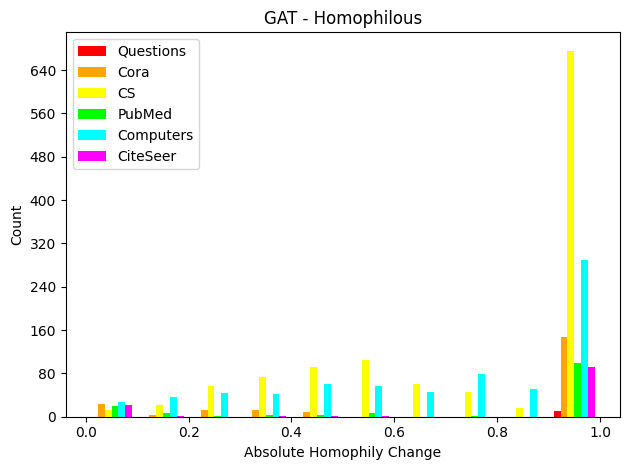

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
colors = [
    ['red', 'orange', 'yellow', 'lime', 'aqua', 'fuchsia'],
    ['firebrick', 'darkorange', 'gold', 'darkgreen', 'navy', 'darkmagenta']
]
model_name, model = ("GAT", GAT)
for group_name, datasets in [("Homophilous", homophilous)]:
  all_data = []
  names = []
  for name, _ in datasets:
    all_data.append(homophily_ratios[model_name][name])
    names.append(name)

a, b, c = plt.hist(all_data, bins=np.linspace(0, 1, 11), label=names, color=colors[0])
plt.title(f"{model_name} - {group_name}")
plt.xlabel("Absolute Homophily Change")
plt.ylabel("Count")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_ratios_GAT_Homophilous.png")

plt.show()

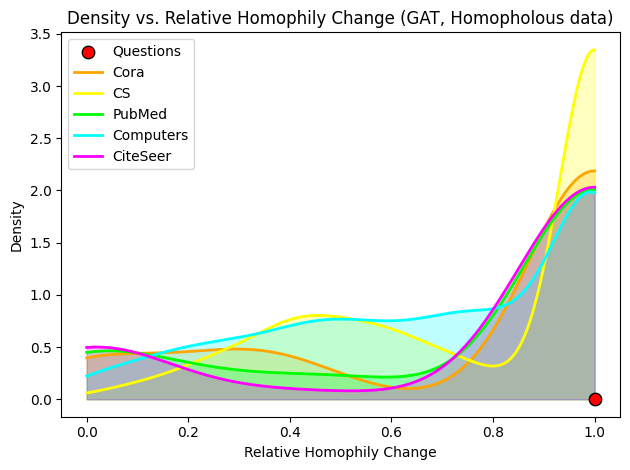

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

x = np.linspace(0, 1, 500)

for i, (data, name) in enumerate(zip(all_data, names)):
    color = colors[0][i]

    data = np.asarray(data, dtype=float)

    # Handle degenerate / near-degenerate data
    if np.std(data) == 0:
        # Plot point mass
        plt.scatter(
            data[0], 0,
            color=color,
            s=80,
            marker='o',
            edgecolor='black',
            label=name,
            zorder=4
        )
        continue

    kde = gaussian_kde(data)

    y = kde(x)

    # Filled area (behind)
    plt.fill_between(
        x,
        y,
        alpha=0.25,        # transparency prevents hiding
        color=color,
        zorder=1
    )

    # Boundary curve (on top)
    plt.plot(
        x,
        y,
        color=color,
        linewidth=2,
        label=name,
        zorder=2
    )

plt.xlabel("Relative Homophily Change")
plt.ylabel("Density")
plt.title("Density vs. Relative Homophily Change (GAT, Homopholous data)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GAT_Homophilous[a].png")
plt.show()

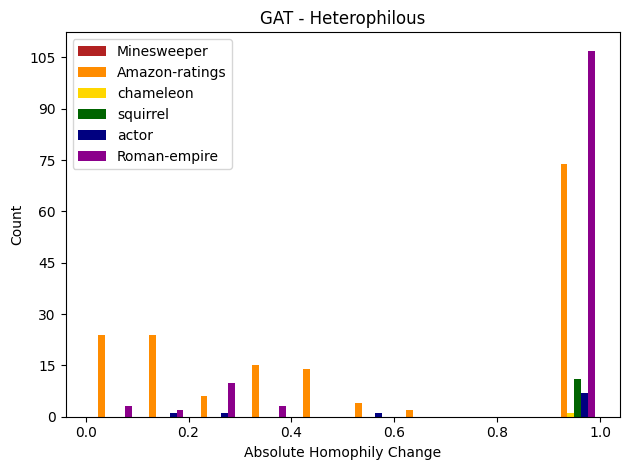

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
colors = [
    ['red', 'orange', 'yellow', 'lime', 'aqua', 'fuchsia'],
    ['firebrick', 'darkorange', 'gold', 'darkgreen', 'navy', 'darkmagenta']
]
model, model_name = (GAT, "GAT")
for group_name, datasets in [("Heterophilous", heterophilous)]:
  all_data = []
  names = []
  for name, _ in datasets:
    all_data.append(homophily_ratios[model_name][name])
    names.append(name)

plt.hist(all_data, bins=np.linspace(0, 1, 11), label=names, color=colors[1])
plt.title(f"{model_name} - {group_name}")
plt.xlabel("Absolute Homophily Change")
plt.ylabel("Count")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GAT_Heterophilous[b].png")

plt.show()

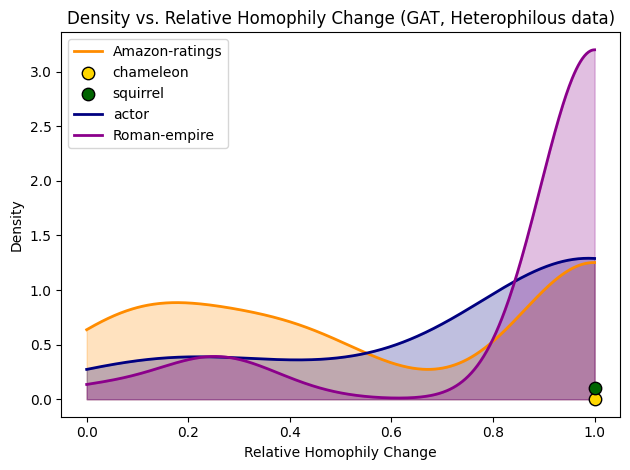

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

x = np.linspace(0, 1, 500)
a = 0
for i, (data, name) in enumerate(zip(all_data, names)):
    color = colors[1][i]

    if len(data) == 0:
      continue

    data = np.asarray(data, dtype=float)

    # Handle degenerate / near-degenerate data
    if np.std(data) == 0:
        # Plot point mass
        plt.scatter(
            data[0], a,
            color=color,
            s=80,
            marker='o',
            edgecolor='black',
            label=name,
            zorder=4
        )
        a += 0.1
        continue

    kde = gaussian_kde(data)

    y = kde(x)

    # Filled area (behind)
    plt.fill_between(
        x,
        y,
        alpha=0.25,        # transparency prevents hiding
        color=color,
        zorder=1
    )

    # Boundary curve (on top)
    plt.plot(
        x,
        y,
        color=color,
        linewidth=2,
        label=name,
        zorder=2
    )

plt.xlabel("Relative Homophily Change")
plt.ylabel("Density")
plt.title("Density vs. Relative Homophily Change (GAT, Heterophilous data)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GAT_Heterophilous[a].png")
plt.show()

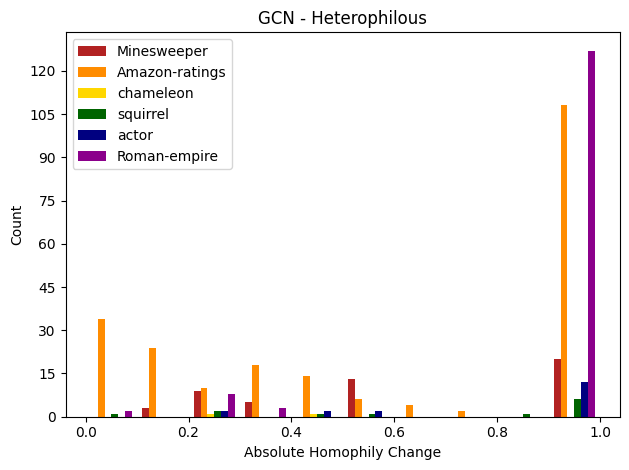

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
colors = [
    ['red', 'orange', 'yellow', 'lime', 'aqua', 'fuchsia'],
    ['firebrick', 'darkorange', 'gold', 'darkgreen', 'navy', 'darkmagenta']
]
model_name, model = ("GCN", GCN)
for group_name, datasets in [("Heterophilous", heterophilous)]:
  all_data = []
  names = []
  for name, _ in datasets:
    all_data.append(homophily_ratios[model_name][name])
    names.append(name)

plt.hist(all_data, bins=np.linspace(0, 1, 11), label=names, color=colors[1])
plt.title(f"{model_name} - {group_name}")
plt.xlabel("Absolute Homophily Change")
plt.ylabel("Count")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GCN_Heterophilous.png")

plt.show()

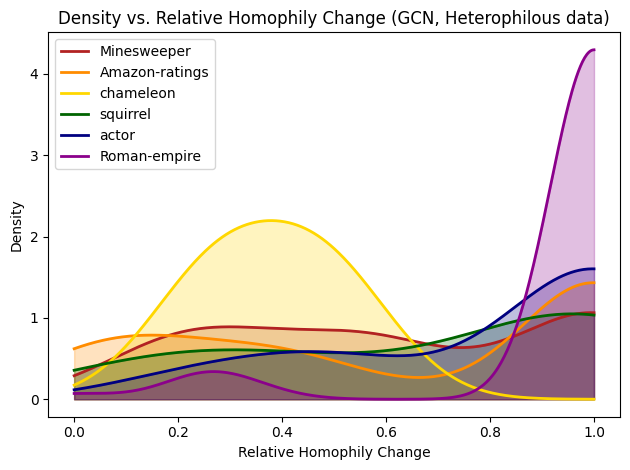

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

x = np.linspace(0, 1, 500)

for i, (data, name) in enumerate(zip(all_data, names)):
    color = colors[1][i]

    if len(data) == 0:
      continue

    data = np.asarray(data, dtype=float)

    # Handle degenerate / near-degenerate data
    if np.std(data) == 0:
        # Plot point mass
        plt.scatter(
            data[0], 0,
            color=color,
            s=80,
            marker='o',
            edgecolor='black',
            label=name,
            zorder=4
        )
        continue

    kde = gaussian_kde(data)

    y = kde(x)

    # Filled area (behind)
    plt.fill_between(
        x,
        y,
        alpha=0.25,        # transparency prevents hiding
        color=color,
        zorder=1
    )

    # Boundary curve (on top)
    plt.plot(
        x,
        y,
        color=color,
        linewidth=2,
        label=name,
        zorder=2
    )

plt.xlabel("Relative Homophily Change")
plt.ylabel("Density")
plt.title("Density vs. Relative Homophily Change (GCN, Heterophilous data)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GCN_Heterophilous[a].png")
plt.show()

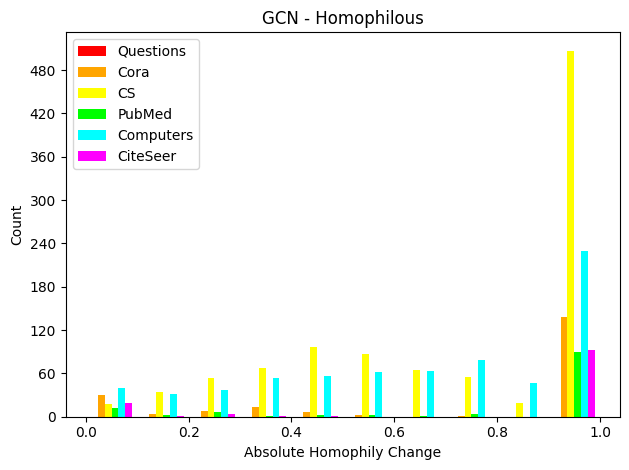

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
colors = [
    ['red', 'orange', 'yellow', 'lime', 'aqua', 'fuchsia'],
    ['firebrick', 'darkorange', 'gold', 'darkgreen', 'navy', 'darkmagenta']
]
model_name, model = ("GCN", GCN)
for group_name, datasets in [("Homophilous", homophilous)]:
  all_data = []
  names = []
  for name, _ in datasets:
    all_data.append(homophily_ratios[model_name][name])
    names.append(name)

plt.hist(all_data, bins=np.linspace(0, 1, 11), label=names, color=colors[0])
plt.title(f"{model_name} - {group_name}")
plt.xlabel("Absolute Homophily Change")
plt.ylabel("Count")
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GCN_Homophilous.png")

plt.show()

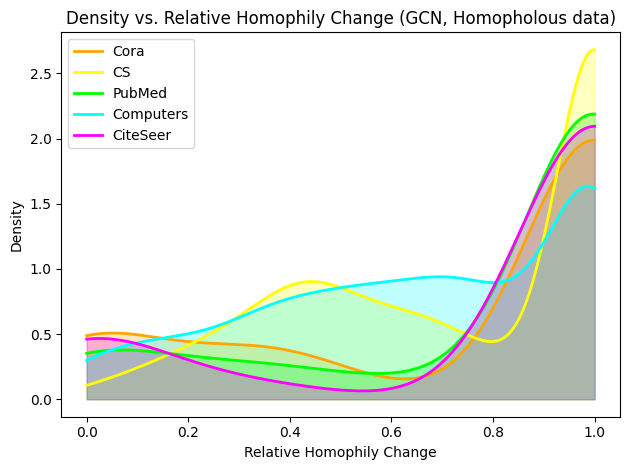

In [ ]:
import numpy as np
from scipy.stats import gaussian_kde

x = np.linspace(0, 1, 500)

for i, (data, name) in enumerate(zip(all_data, names)):
    color = colors[0][i]

    if len(data) == 0:
      continue

    data = np.asarray(data, dtype=float)

    # Handle degenerate / near-degenerate data
    if np.std(data) == 0:
        # Plot point mass
        plt.scatter(
            data[0], 0,
            color=color,
            s=80,
            marker='o',
            edgecolor='black',
            label=name,
            zorder=4
        )
        continue

    kde = gaussian_kde(data)

    y = kde(x)

    # Filled area (behind)
    plt.fill_between(
        x,
        y,
        alpha=0.25,        # transparency prevents hiding
        color=color,
        zorder=1
    )

    # Boundary curve (on top)
    plt.plot(
        x,
        y,
        color=color,
        linewidth=2,
        label=name,
        zorder=2
    )

plt.xlabel("Relative Homophily Change")
plt.ylabel("Density")
plt.title("Density vs. Relative Homophily Change (GCN, Homopholous data)")
plt.legend()
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/homophily_comparison_GCN_Homophilous[a].png")
plt.show()

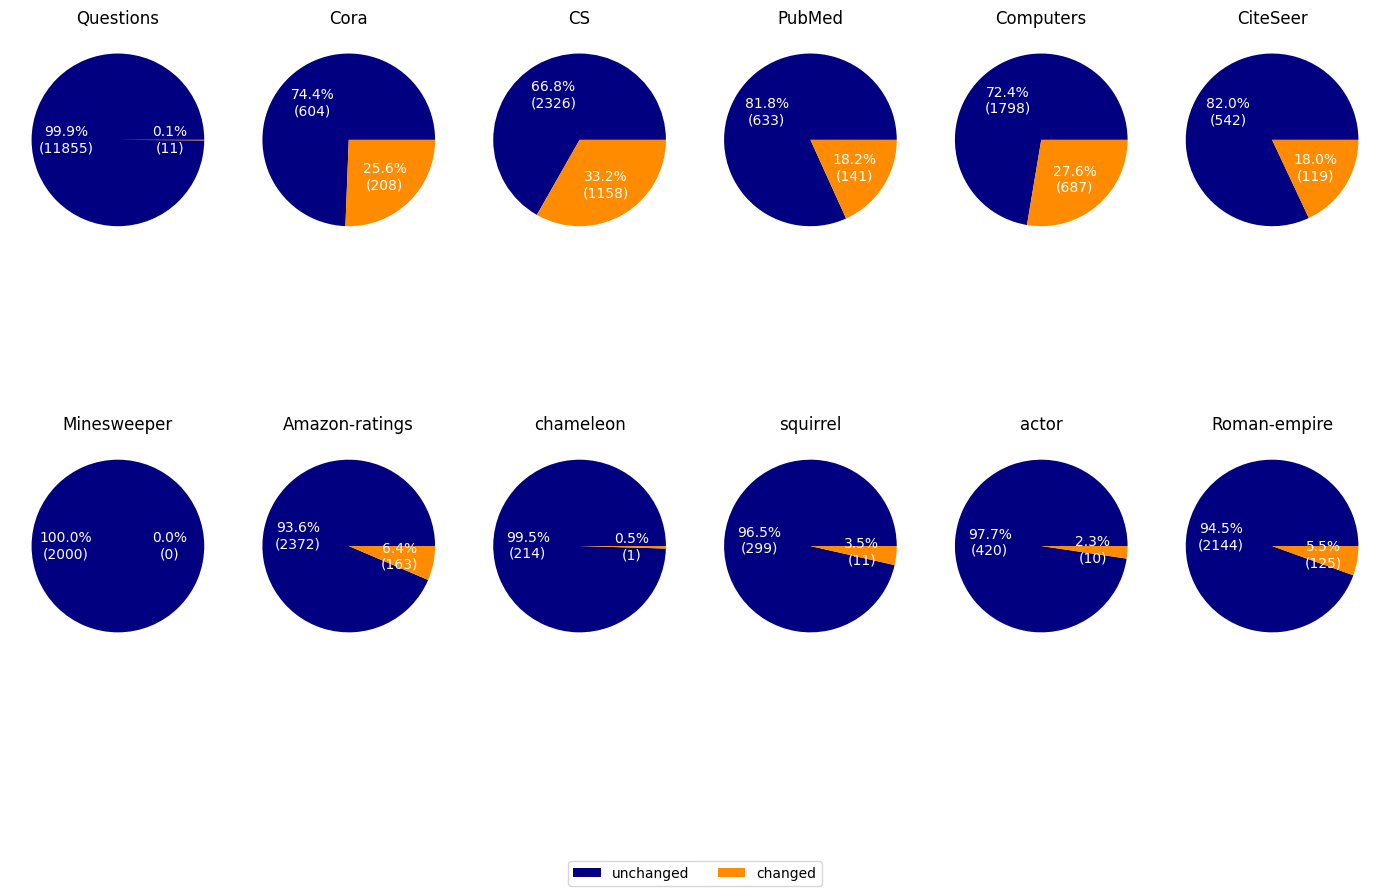

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

#
fig, ax = plt.subplots(2, 6, figsize=(14, 10))
first_pie_handles = None
for model_name in ["GAT"]:
  vert = 0
  for group_name, datasets in [("Homophilous", homophilous),
                              ("Heterophilous", heterophilous)]:
    all_data = []
    names = []

    horiz = 0
    for name, _ in datasets:
      names.append(name)
      unchanged = unchanged_nodes_all[model_name][name]
      changed = len(perturb_results[model_name][name])
      values = [unchanged, changed]

      wedges, texts, autotexts = ax[vert, horiz].pie(values, colors=['navy', 'darkorange'], autopct=autopct_format(values))
      if not first_pie_handles:
        first_pie_handles = wedges
      ax[vert, horiz].set_title(f"{name}")

      for a in autotexts:
        a.set_color('white')
      horiz += 1
    vert += 1

labels = ['unchanged', 'changed']
# Remove duplicate labels/handles if necessary (e.g., if different subplots have the same label)
unique_labels = list(dict.fromkeys(labels))
unique_handles = first_pie_handles
#ax[0, 6].axis("off")
# print(first_pie_handles)
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_labels))
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/unchanged_nodes.png", bbox_inches='tight')

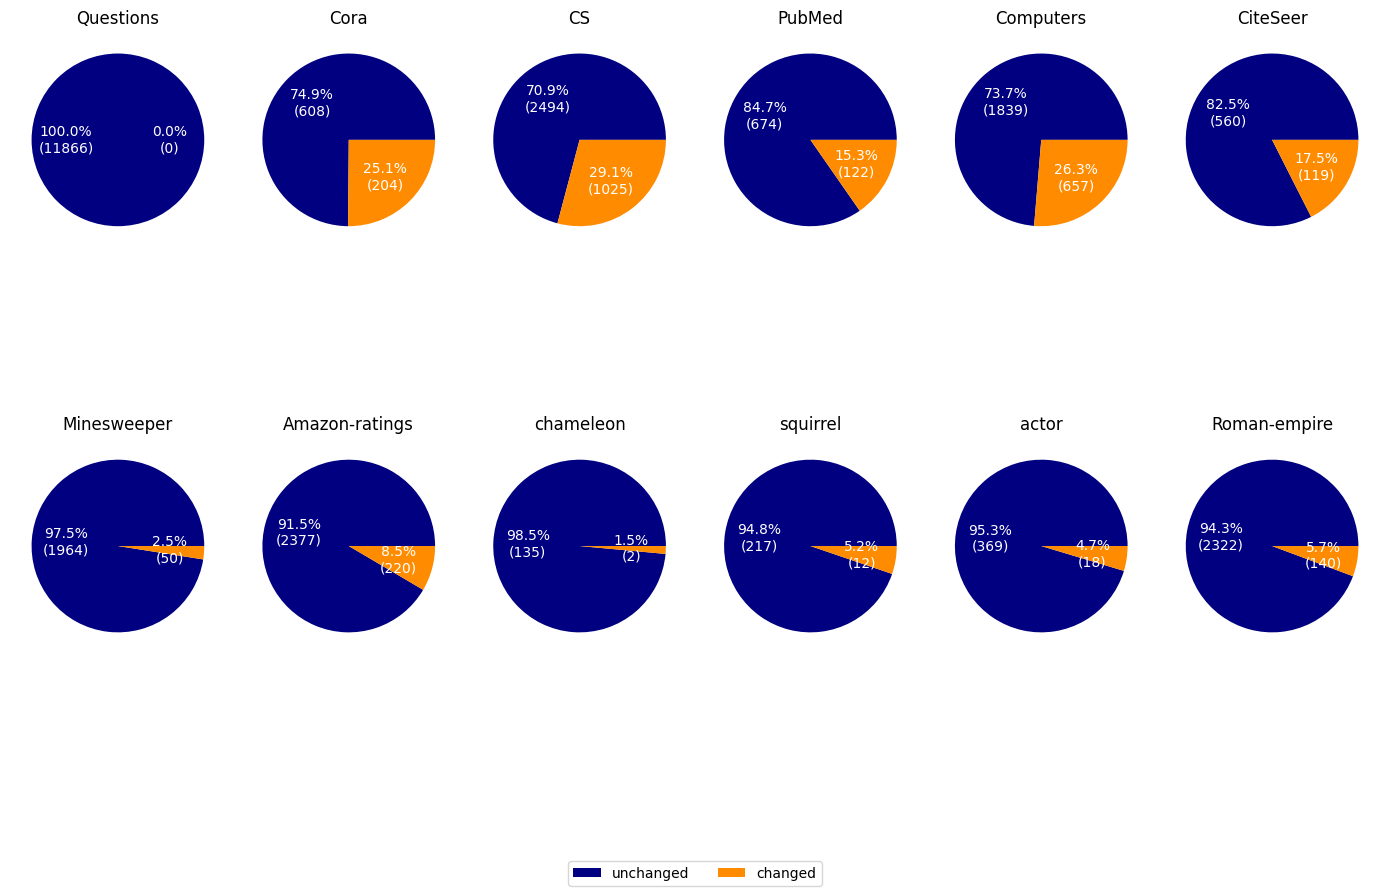

In [ ]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format


from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
#
fig, ax = plt.subplots(2, 6, figsize=(14, 10))
first_pie_handles = None
for model_name in ["GCN"]:
  vert = 0
  for group_name, datasets in [("Homophilous", homophilous),
                              ("Heterophilous", heterophilous)]:
    all_data = []
    names = []

    horiz = 0
    for name, _ in datasets:
      names.append(name)
      unchanged = unchanged_nodes_all[model_name][name]
      changed = len(perturb_results[model_name][name])
      values = [unchanged, changed]

      wedges, texts, autotexts = ax[vert, horiz].pie(values, colors=['navy', 'darkorange'], autopct=autopct_format(values))
      if not first_pie_handles:
        first_pie_handles = wedges
      ax[vert, horiz].set_title(f"{name}")

      for a in autotexts:
        a.set_color('white')
      horiz += 1
    vert += 1

labels = ['unchanged', 'changed']
#first_pie_handles, _ = ax[0, 0].pie([1,1])  # or use the real first pie's values
# Remove duplicate labels/handles if necessary (e.g., if different subplots have the same label)
unique_labels = list(dict.fromkeys(labels))
unique_handles = first_pie_handles
#ax[0, 6].axis("off")
# print(first_pie_handles)
fig.legend(unique_handles, unique_labels, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=len(unique_labels))
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/saved_models/Plots/unchanged_nodes_GCN.png", bbox_inches='tight')

## Other Experiments (Ignore)

In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import (
    Planetoid,
    WikipediaNetwork,
    WebKB,
    Coauthor,
    Amazon,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ----------------------------
# Models
# ----------------------------

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(
            in_channels, hidden_channels, heads=heads,
            dropout=dropout
        )
        self.conv2 = GATConv(
            hidden_channels * heads, out_channels,
            heads=1, concat=False, dropout=dropout
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None):
        # Ignore edge_index: this is a pure feature-based model
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        return x


# ----------------------------
# Data loaders (CPU)
# ----------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def load_webkb(name, root="./data/WebKB"):
    return WebKB(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask


# ----------------------------
# Global stats (CPU)
# ----------------------------

def compute_global_stats(data_cpu, G):
    """
    Compute:
      - average degree
      - global clustering coefficient (transitivity)
      - edge homophily
      - attribute similarity
    """
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index

    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())

    global_cc = float(nx.transitivity(G))

    edge_hom = float(homophily(edge_index, y, method="edge"))

    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())

    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }


# ----------------------------
# Node-level stats (CPU)
# ----------------------------

def compute_node_stats(data_cpu, G):
    """
    Per-node:
      - degree: deg(v)
      - clustering coefficient C(v)
      - local homophily h_local(v)
    """
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom


# ----------------------------
# Majority-vote baseline (CPU)
# ----------------------------

def majority_vote_predictions(data_cpu, G):
    """
    Predict each node's label as the majority label among its neighbors.
    If a node has no neighbors, fall back to the global majority label.
    """
    # Enforce CPU to avoid assertion issues
    data_cpu = data_cpu.cpu()
    assert not data_cpu.is_cuda

    y = data_cpu.y
    num_nodes = data_cpu.num_nodes

    global_majority = int(torch.mode(y)[0].item())
    preds = torch.empty_like(y)

    for v in range(num_nodes):
        neigh = list(G.neighbors(v))
        if len(neigh) == 0:
            preds[v] = global_majority
        else:
            neigh_labels = y[neigh]
            counts = torch.bincount(neigh_labels)
            preds[v] = int(torch.argmax(counts).item())

    return preds


# ----------------------------
# Grouping and summaries (CPU)
# ----------------------------

def get_pass_fail_indices(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    """
    Accepts either:
      - logits of shape [N, C], or
      - predicted labels of shape [N].

    Returns passing / failing indices on the test nodes and test accuracy (%).
    All tensors are expected on CPU.
    """
    preds_or_logits_cpu = preds_or_logits_cpu.cpu()
    y_cpu = y_cpu.cpu()
    test_mask_cpu = test_mask_cpu.cpu()

    assert not preds_or_logits_cpu.is_cuda
    assert not y_cpu.is_cuda
    assert not test_mask_cpu.is_cuda

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return passing, failing, test_acc * 100.0


def summarize_group(values_cpu, idx):
    values_cpu = values_cpu.cpu()
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())


# ----------------------------
# Train / evaluate GNN (device)
# ----------------------------

def train_and_evaluate_gnn(
    data_dev,
    ModelClass,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_channels = data_dev.num_features
    out_channels = int(data_dev.y.max().item() + 1)

    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    model = ModelClass(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, data_dev.edge_index)
            preds = out.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(data_dev.x, data_dev.edge_index).cpu()

    model.to("cpu")
    del model, optimizer, out, preds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return logits


# ----------------------------
# Main: run experiments + plots
# ----------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    homophilous = [
        ("Cora", load_planetoid),
        ("CiteSeer", load_planetoid),
        ("PubMed", load_planetoid),
        #("CS", load_coauthor),
        #("Physics", load_coauthor),
        ("Computers", load_amazon),
        ("Photo", load_amazon),
    ]

    heterophilous = [
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("Cornell", load_webkb),
        ("Texas", load_webkb),
        ("Wisconsin", load_webkb),
    ]

    rows = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            # Load on CPU and force CPU tensor
            dataset = loader_fn(name)
            data_cpu = dataset[0].cpu()
            y_cpu = data_cpu.y.cpu()
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            # Build NetworkX graph from CPU data
            G = to_networkx(data_cpu, to_undirected=True)

            # Global + node stats on CPU
            global_stats = compute_global_stats(data_cpu, G)
            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu, G)

            print(
                f"\nDataset: {name}"
                f" | avg_deg={global_stats['avg_degree']:.2f}"
                f" | global_cc={global_stats['global_clustering']:.4f}"
                f" | homophily={global_stats['edge_homophily']:.4f}"
                f" | attr_sim={global_stats['attr_similarity']:.4f}"
            )

            # ---- GNN models (GCN, GAT) ----
            data_dev = data_cpu.to(device)

            for ModelClass, model_name in [(GCN, "GCN"), (GAT, "GAT"), (MLP, "MLP")]:
                logits_cpu = train_and_evaluate_gnn(
                    data_dev,
                    ModelClass,
                    train_mask_cpu,
                    val_mask_cpu,
                    test_mask_cpu,
                    device=device,
                )

                passing_idx, failing_idx, test_acc = get_pass_fail_indices(
                    logits_cpu, y_cpu, test_mask_cpu
                )

                deg_pass_mean, deg_pass_std = summarize_group(deg_cpu, passing_idx)
                deg_fail_mean, deg_fail_std = summarize_group(deg_cpu, failing_idx)

                C_pass_mean, C_pass_std = summarize_group(C_local_cpu, passing_idx)
                C_fail_mean, C_fail_std = summarize_group(C_local_cpu, failing_idx)

                h_pass_mean, h_pass_std = summarize_group(h_local_cpu, passing_idx)
                h_fail_mean, h_fail_std = summarize_group(h_local_cpu, failing_idx)

                print(f"  {model_name:3s} | test acc: {test_acc:5.2f} %")
                print(f"       degree       : pass={deg_pass_mean:7.3f}±{deg_pass_std:7.3f}, "
                    f"fail={deg_fail_mean:7.3f}±{deg_fail_std:7.3f}")
                print(f"       clustering   : pass={C_pass_mean:7.3f}±{C_pass_std:7.3f}, "
                    f"fail={C_fail_mean:7.3f}±{C_fail_std:7.3f}")
                print(f"       local homoph.: pass={h_pass_mean:7.3f}±{h_pass_std:7.3f}, "
                    f"fail={h_fail_mean:7.3f}±{h_fail_std:7.3f}")

                rows.append({
                    "group": group_name,
                    "dataset": name,
                    "model": model_name,  # now includes "MLP"
                    "test_acc": test_acc,
                    "avg_degree": global_stats["avg_degree"],
                    "global_cc": global_stats["global_clustering"],
                    "edge_homophily": global_stats["edge_homophily"],
                    "attr_similarity": global_stats["attr_similarity"],
                    "deg_pass_mean": deg_pass_mean,
                    "deg_fail_mean": deg_fail_mean,
                    "C_pass_mean": C_pass_mean,
                    "C_fail_mean": C_fail_mean,
                    "h_pass_mean": h_pass_mean,
                    "h_fail_mean": h_fail_mean,
                })

                del logits_cpu, passing_idx, failing_idx
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()


    # ----------------------------
    # Build DataFrame and plots
    # ----------------------------

    all_df = pd.DataFrame(rows)
    print("\nFinal aggregated table:")
    print(all_df)

    # Plot 1: accuracy vs global edge homophily
    plt.figure(figsize=(8, 5))
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=msg_df,
        x="h_local",
        y="align_hetero",
        hue="status",
        alpha=0.3,
    )
    plt.xlabel("Local homophily")
    plt.ylabel("Cosine(h1, hetero messages)")
    plt.title("Alignment of GCN hidden with heterophilous messages")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


    # Prepare long-form data for pass/fail local homophily
    plot_df = all_df.melt(
        id_vars=["group", "dataset", "model"],
        value_vars=["h_pass_mean", "h_fail_mean"],
        var_name="status",
        value_name="h_local_mean",
    )
    plot_df["status"] = plot_df["status"].map(
        {"h_pass_mean": "pass", "h_fail_mean": "fail"}
    )

    # Plot 2: barplot of local homophily (pass vs fail) by dataset and model
    g = sns.catplot(
        data=plot_df,
        x="dataset",
        y="h_local_mean",
        hue="status",
        col="model",
        kind="bar",
        height=4,
        aspect=1.1,
    )
    g.set_xticklabels(rotation=45, ha="right")
    g.set_ylabels("Mean local homophily (test nodes)")
    g.fig.suptitle("Pass vs fail local homophily by model and dataset", y=1.02)
    plt.show()

    # Plot 3: accuracy vs mean test local homophily
    all_df["h_test_mean"] = 0.5 * (all_df["h_pass_mean"] + all_df["h_fail_mean"])

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=all_df,
        x="h_test_mean",
        y="test_acc",
        hue="model",
        style="group",
        s=80,
    )
    plt.xlabel("Mean local homophily (test nodes)")
    plt.ylabel("Test accuracy (%)")
    plt.title("Accuracy vs mean local homophily (test set)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.datasets import (
    Planetoid,
    WikipediaNetwork,
    WebKB,
    Coauthor,
    Amazon,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ----------------------------
# Models
# ----------------------------

class GCNWithRepr(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        h1 = self.conv1(x, edge_index)  # pre-activation hidden
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(
            in_channels, hidden_channels, heads=heads,
            dropout=dropout
        )
        self.conv2 = GATConv(
            hidden_channels * heads, out_channels,
            heads=1, concat=False, dropout=dropout
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


class MLPWithRepr(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index=None, return_hidden=False):
        h1 = self.lin1(x)
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.lin2(h)
        if return_hidden:
            return out, h1
        return out


# ----------------------------
# Data loaders (CPU)
# ----------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def load_webkb(name, root="./data/WebKB"):
    return WebKB(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask


# ----------------------------
# Global + node stats (CPU)
# ----------------------------

def compute_global_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index

    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())

    global_cc = float(nx.transitivity(G))

    edge_hom = float(homophily(edge_index, y, method="edge"))

    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())

    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }


def compute_node_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom


# ----------------------------
# Majority-vote baseline (CPU)
# ----------------------------

def majority_vote_predictions(data_cpu, G):
    data_cpu = data_cpu.cpu()
    assert not data_cpu.is_cuda

    y = data_cpu.y
    num_nodes = data_cpu.num_nodes

    global_majority = int(torch.mode(y)[0].item())
    preds = torch.empty_like(y)

    for v in range(num_nodes):
        neigh = list(G.neighbors(v))
        if len(neigh) == 0:
            preds[v] = global_majority
        else:
            neigh_labels = y[neigh]
            counts = torch.bincount(neigh_labels)
            preds[v] = int(torch.argmax(counts).item())

    return preds


# ----------------------------
# Grouping and helper metrics
# ----------------------------

def get_pass_fail_indices(preds_or_logits_cpu, y_cpu, test_mask_cpu):
    preds_or_logits_cpu = preds_or_logits_cpu.cpu()
    y_cpu = y_cpu.cpu()
    test_mask_cpu = test_mask_cpu.cpu()

    assert not preds_or_logits_cpu.is_cuda
    assert not y_cpu.is_cuda
    assert not test_mask_cpu.is_cuda

    if preds_or_logits_cpu.dim() > 1:
        preds = preds_or_logits_cpu.argmax(dim=-1)
    else:
        preds = preds_or_logits_cpu

    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return passing, failing, test_acc * 100.0


def summarize_group(values_cpu, idx):
    values_cpu = values_cpu.cpu()
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())


def class_margin(logits_cpu, y_cpu):
    logits_cpu = logits_cpu.cpu()
    y_cpu = y_cpu.cpu()
    correct = logits_cpu[torch.arange(len(y_cpu)), y_cpu]
    tmp = logits_cpu.clone()
    tmp[torch.arange(len(y_cpu)), y_cpu] = -1e9
    best_other, _ = tmp.max(dim=-1)
    return correct - best_other


def mean_neighbor_cos(h, edge_index):
    """
    h: [N, D], edge_index: [2, E]
    Compute mean cosine similarity between a node's representation and its neighbors.
    """
    h = h.cpu()
    edge_index = edge_index.cpu()  # <-- ensure indices are on CPU as well
    row, col = edge_index
    hv = h[row]
    hu = h[col]
    cos = F.cosine_similarity(hv, hu)
    N = h.size(0)
    sums = torch.zeros(N)
    counts = torch.zeros(N)
    sums.index_add_(0, row, cos)
    counts.index_add_(0, row, torch.ones_like(cos))
    return sums / torch.clamp(counts, min=1.0)



def get_sets_for_model_pair(mlp_logits, gcn_logits, y_cpu, test_mask_cpu):
    y = y_cpu.cpu()
    test_mask = test_mask_cpu.cpu().bool()

    mlp_pred = mlp_logits.argmax(dim=-1).cpu()
    gcn_pred = gcn_logits.argmax(dim=-1).cpu()

    mlp_correct = (mlp_pred == y)
    gcn_correct = (gcn_pred == y)

    A = (~mlp_correct & gcn_correct) & test_mask   # MLP fail, GCN pass
    B = (mlp_correct & gcn_correct) & test_mask    # both pass
    C = (~mlp_correct & ~gcn_correct) & test_mask  # both fail

    A_idx = A.nonzero(as_tuple=False).view(-1)
    B_idx = B.nonzero(as_tuple=False).view(-1)
    C_idx = C.nonzero(as_tuple=False).view(-1)
    return A_idx, B_idx, C_idx


# ----------------------------
# Training utilities (device)
# ----------------------------

def train_and_evaluate_with_repr(
    data_dev,
    ModelClass,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_channels = data_dev.num_features
    out_channels = int(data_dev.y.max().item() + 1)

    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    model = ModelClass(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds = out.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits, hidden = model(data_dev.x, data_dev.edge_index, return_hidden=True)
        logits = logits.cpu()
        hidden = hidden.cpu()

    model.to("cpu")
    del model, optimizer, out, preds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return logits, hidden


def train_and_evaluate_mlp_with_repr(
    data_dev,
    ModelClass,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_channels = data_dev.num_features
    out_channels = int(data_dev.y.max().item() + 1)

    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    model = ModelClass(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, None, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, None, return_hidden=False)
            preds = out.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits, hidden = model(data_dev.x, None, return_hidden=True)
        logits = logits.cpu()
        hidden = hidden.cpu()

    model.to("cpu")
    del model, optimizer, out, preds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return logits, hidden


def train_and_evaluate_no_repr(
    data_dev,
    ModelClass,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    # For GAT (no return_hidden)
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_channels = data_dev.num_features
    out_channels = int(data_dev.y.max().item() + 1)

    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    model = ModelClass(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, data_dev.edge_index)
            preds = out.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(data_dev.x, data_dev.edge_index).cpu()

    model.to("cpu")
    del model, optimizer, out, preds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return logits


# ----------------------------
# Main experiment
# ----------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    homophilous = [
        ("Cora", load_planetoid),
        ("CiteSeer", load_planetoid),
        ("PubMed", load_planetoid),
        #("CS", load_coauthor),
        #("Physics", load_coauthor),
        ("Computers", load_amazon),
        ("Photo", load_amazon),
    ]

    heterophilous = [
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("Cornell", load_webkb),
        ("Texas", load_webkb),
        ("Wisconsin", load_webkb),
    ]

    summary_rows = []
    repr_rows = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            dataset = loader_fn(name)
            data_cpu = dataset[0].cpu()
            y_cpu = data_cpu.y.cpu()
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            G = to_networkx(data_cpu, to_undirected=True)

            global_stats = compute_global_stats(data_cpu, G)
            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu, G)

            print(
                f"\nDataset: {name}"
                f" | avg_deg={global_stats['avg_degree']:.2f}"
                f" | global_cc={global_stats['global_clustering']:.4f}"
                f" | homophily={global_stats['edge_homophily']:.4f}"
                f" | attr_sim={global_stats['attr_similarity']:.4f}"
            )

            data_dev = data_cpu.to(device)

            # ---- Train GCN, GAT, MLP ----
            gcn_logits, gcn_hidden = train_and_evaluate_with_repr(
                data_dev, GCNWithRepr,
                train_mask_cpu, val_mask_cpu, test_mask_cpu,
                device=device,
            )
            gat_logits = train_and_evaluate_no_repr(
                data_dev, GAT,
                train_mask_cpu, val_mask_cpu, test_mask_cpu,
                device=device,
            )
            mlp_logits, mlp_hidden = train_and_evaluate_mlp_with_repr(
                data_dev, MLPWithRepr,
                train_mask_cpu, val_mask_cpu, test_mask_cpu,
                device=device,
            )

            # Compute summary stats for each model
            for model_name, logits in [("GCN", gcn_logits),
                                       ("GAT", gat_logits),
                                       ("MLP", mlp_logits)]:
                passing_idx, failing_idx, test_acc = get_pass_fail_indices(
                    logits, y_cpu, test_mask_cpu
                )

                deg_pass_mean, deg_pass_std = summarize_group(deg_cpu, passing_idx)
                deg_fail_mean, deg_fail_std = summarize_group(deg_cpu, failing_idx)

                C_pass_mean, C_pass_std = summarize_group(C_local_cpu, passing_idx)
                C_fail_mean, C_fail_std = summarize_group(C_local_cpu, failing_idx)

                h_pass_mean, h_pass_std = summarize_group(h_local_cpu, passing_idx)
                h_fail_mean, h_fail_std = summarize_group(h_local_cpu, failing_idx)

                print(f"  {model_name:3s} | test acc: {test_acc:5.2f} %")
                print(f"       degree       : pass={deg_pass_mean:7.3f}±{deg_pass_std:7.3f}, "
                      f"fail={deg_fail_mean:7.3f}±{deg_fail_std:7.3f}")
                print(f"       clustering   : pass={C_pass_mean:7.3f}±{C_pass_std:7.3f}, "
                      f"fail={C_fail_mean:7.3f}±{C_fail_std:7.3f}")
                print(f"       local homoph.: pass={h_pass_mean:7.3f}±{h_pass_std:7.3f}, "
                      f"fail={h_fail_mean:7.3f}±{h_fail_std:7.3f}")

                summary_rows.append({
                    "group": group_name,
                    "dataset": name,
                    "model": model_name,
                    "test_acc": test_acc,
                    "avg_degree": global_stats["avg_degree"],
                    "global_cc": global_stats["global_clustering"],
                    "edge_homophily": global_stats["edge_homophily"],
                    "attr_similarity": global_stats["attr_similarity"],
                    "deg_pass_mean": deg_pass_mean,
                    "deg_fail_mean": deg_fail_mean,
                    "C_pass_mean": C_pass_mean,
                    "C_fail_mean": C_fail_mean,
                    "h_pass_mean": h_pass_mean,
                    "h_fail_mean": h_fail_mean,
                })

            # ---- Representation-level experiment: MLP vs GCN ----
            row_edge_index = data_cpu.edge_index

            mlp_margin = class_margin(mlp_logits, y_cpu)
            gcn_margin = class_margin(gcn_logits, y_cpu)

            mlp_neigh_cos = mean_neighbor_cos(mlp_hidden, row_edge_index)
            gcn_neigh_cos = mean_neighbor_cos(gcn_hidden, row_edge_index)

            A_idx, B_idx, C_idx = get_sets_for_model_pair(
                mlp_logits, gcn_logits, y_cpu, test_mask_cpu
            )

            for label, idx in [("MLP_fail_GCN_pass", A_idx),
                               ("both_pass", B_idx),
                               ("both_fail", C_idx)]:
                if idx.numel() == 0:
                    continue
                repr_rows.append({
                    "group": group_name,
                    "dataset": name,
                    "set_label": label,
                    "n_nodes": int(idx.numel()),
                    "mean_h_local": float(h_local_cpu[idx].mean().item()),
                    "mean_deg": float(deg_cpu[idx].mean().item()),
                    "mlp_margin_mean": float(mlp_margin[idx].mean().item()),
                    "gcn_margin_mean": float(gcn_margin[idx].mean().item()),
                    "mlp_neigh_cos_mean": float(mlp_neigh_cos[idx].mean().item()),
                    "gcn_neigh_cos_mean": float(gcn_neigh_cos[idx].mean().item()),
                })

            # Cleanup per dataset
            del (
                dataset,
                data_cpu,
                data_dev,
                y_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
                G,
                global_stats,
                deg_cpu,
                C_local_cpu,
                h_local_cpu,
                gcn_logits,
                gat_logits,
                mlp_logits,
                gcn_hidden,
                mlp_hidden,
                mlp_margin,
                gcn_margin,
                mlp_neigh_cos,
                gcn_neigh_cos,
                A_idx,
                B_idx,
                C_idx,
            )
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # ----------------------------
    # Build DataFrames and basic plots
    # ----------------------------

    summary_df = pd.DataFrame(summary_rows)
    repr_df = pd.DataFrame(repr_rows)

    print("\nSummary metrics:")
    print(summary_df)

    print("\nRepresentation-level summary:")
    print(repr_df)

    # Example plot: accuracy vs edge homophily
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=summary_df,
        x="edge_homophily",
        y="test_acc",
        hue="model",
        style="group",
        s=80,
    )
    plt.xlabel("Global edge homophily")
    plt.ylabel("Test accuracy (%)")
    plt.title("Accuracy vs. homophily (GCN, GAT, MLP)")
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    # Example plot: for MLP_fail_GCN_pass, compare neighbor cos for MLP vs GCN
    subset = repr_df[repr_df["set_label"] == "MLP_fail_GCN_pass"]
    if not subset.empty:
        plt.figure(figsize=(8, 5))
        width = 0.35
        x = np.arange(len(subset))
        plt.bar(x - width/2, subset["mlp_neigh_cos_mean"], width, label="MLP")
        plt.bar(x + width/2, subset["gcn_neigh_cos_mean"], width, label="GCN")
        plt.xticks(x, subset["dataset"], rotation=45, ha="right")
        plt.ylabel("Mean neighbor cosine similarity")
        plt.title("Neighbor similarity for MLP_fail_GCN_pass nodes")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.datasets import (
    Planetoid,
    WikipediaNetwork,
    WebKB,
    Coauthor,
    Amazon,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, homophily, to_networkx

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# ----------------------------
# Models
# ----------------------------

class GCNWithRepr(torch.nn.Module):
    """
    One hidden GCN layer + output layer.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        h1 = self.conv1(x, edge_index)  # first-layer aggregated messages + transform
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 heads=8, dropout=0.6):
        super().__init__()
        self.conv1 = GATConv(
            in_channels, hidden_channels, heads=heads,
            dropout=dropout
        )
        self.conv2 = GATConv(
            hidden_channels * heads, out_channels,
            heads=1, concat=False, dropout=dropout
        )
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x


# ----------------------------
# Data loaders (CPU)
# ----------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def load_webkb(name, root="./data/WebKB"):
    return WebKB(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask


# ----------------------------
# Global + node stats (CPU)
# ----------------------------

def compute_global_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    row, col = edge_index

    deg = degree(row, num_nodes=data_cpu.num_nodes)
    avg_deg = float(deg.mean().item())

    global_cc = float(nx.transitivity(G))

    edge_hom = float(homophily(edge_index, y, method="edge"))

    cos = F.cosine_similarity(data_cpu.x[row], data_cpu.x[col])
    attr_sim = float(cos.mean().item())

    return {
        "avg_degree": avg_deg,
        "global_clustering": global_cc,
        "edge_homophily": edge_hom,
        "attr_similarity": attr_sim,
    }


def compute_node_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom


# ----------------------------
# Grouping and helper metrics
# ----------------------------

def get_pass_fail_indices(logits_cpu, y_cpu, test_mask_cpu):
    logits_cpu = logits_cpu.cpu()
    y_cpu = y_cpu.cpu()
    test_mask_cpu = test_mask_cpu.cpu()

    preds = logits_cpu.argmax(dim=-1)
    eval_mask = test_mask_cpu.bool()
    correct = (preds == y_cpu)
    correct_test = correct & eval_mask

    passing = correct_test.nonzero(as_tuple=False).view(-1)
    failing = ((~correct) & eval_mask).nonzero(as_tuple=False).view(-1)

    test_acc = correct_test.sum().item() / int(eval_mask.sum())
    return preds, passing, failing, test_acc * 100.0


def summarize_group(values_cpu, idx):
    values_cpu = values_cpu.cpu()
    if idx.numel() == 0:
        return math.nan, math.nan
    subset = values_cpu[idx]
    return float(subset.mean().item()), float(subset.std(unbiased=False).item())


def class_margin(logits_cpu, y_cpu):
    logits_cpu = logits_cpu.cpu()
    y_cpu = y_cpu.cpu()
    correct = logits_cpu[torch.arange(len(y_cpu)), y_cpu]
    tmp = logits_cpu.clone()
    tmp[torch.arange(len(y_cpu)), y_cpu] = -1e9
    best_other, _ = tmp.max(dim=-1)
    return correct - best_other


def cos_sim(a, b, eps=1e-8):
    # a, b: [N, D]
    a_norm = a / (a.norm(dim=-1, keepdim=True) + eps)
    b_norm = b / (b.norm(dim=-1, keepdim=True) + eps)
    return (a_norm * b_norm).sum(dim=-1)


# ----------------------------
# Training utilities
# ----------------------------

def train_and_evaluate_gcn_with_repr(
    data_dev,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_channels = data_dev.num_features
    out_channels = int(data_dev.y.max().item() + 1)

    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds = out.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits, h1 = model(data_dev.x, data_dev.edge_index, return_hidden=True)
        logits = logits.cpu()
        h1 = h1.cpu()

    return model, logits, h1


def train_and_evaluate_gat(
    data_dev,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_channels = data_dev.num_features
    out_channels = int(data_dev.y.max().item() + 1)

    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    model = GAT(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            out = model(data_dev.x, data_dev.edge_index)
            preds = out.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(data_dev.x, data_dev.edge_index).cpu()

    model.to("cpu")
    del model, optimizer, out, preds
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return logits


# ----------------------------
# GCN message decomposition
# ----------------------------

def decompose_gcn_messages(
    data,
    gcn_model,
    hidden_channels,
):
    """
    Decompose first-layer GCN messages into homophilous vs heterophilous components.

    Returns:
      m_homo: [N, H]
      m_hetero: [N, H]
      m_self: [N, H]
      h1: [N, H] (reconstructed pre-activation hidden)
    """
    # Work on CPU copies of both data and model
    data_cpu = data.cpu()
    gcn_cpu = copy.deepcopy(gcn_model).to("cpu").eval()

    x = data_cpu.x          # [N, F], CPU
    y = data_cpu.y          # [N], CPU
    edge_index = data_cpu.edge_index  # [2, E], CPU
    N = x.size(0)

    conv1 = gcn_cpu.conv1
    H = conv1.out_channels

    # Normalized edges as in GCNConv
    edge_index_norm, norm = gcn_norm(
        edge_index,
        edge_weight=None,
        num_nodes=N,
        improved=False,
        add_self_loops=True,
        dtype=x.dtype,
    )  # edge_index_norm: [2, E'], norm: [E']

    row, col = edge_index_norm  # v = row[i], u = col[i]
    # Apply learned linear transform W to features
    xW = conv1.lin(x)  # [N, H], CPU

    m_homo = torch.zeros(N, H)
    m_hetero = torch.zeros(N, H)
    m_self = torch.zeros(N, H)

    for i in range(row.numel()):
        v = row[i].item()
        u = col[i].item()
        w = norm[i].item()
        msg = w * xW[u]

        if u == v:
            m_self[v] += msg
        else:
            if y[u] == y[v]:
                m_homo[v] += msg
            else:
                m_hetero[v] += msg

    h1 = m_self + m_homo + m_hetero
    return m_homo, m_hetero, m_self, h1


# ----------------------------
# Main experiment
# ----------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    homophilous = [
        ("Cora", load_planetoid),
        ("CiteSeer", load_planetoid),
        ("PubMed", load_planetoid),
        #("CS", load_coauthor),
        #("Physics", load_coauthor),
        ("Computers", load_amazon),
        ("Photo", load_amazon),
    ]

    heterophilous = [
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("Cornell", load_webkb),
        ("Texas", load_webkb),
        ("Wisconsin", load_webkb),
    ]

    summary_rows = []
    msg_rows = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            dataset = loader_fn(name)
            data_cpu = dataset[0].cpu()
            y_cpu = data_cpu.y.cpu()
            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            G = to_networkx(data_cpu, to_undirected=True)

            global_stats = compute_global_stats(data_cpu, G)
            deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu, G)

            print(
                f"\nDataset: {name}"
                f" | avg_deg={global_stats['avg_degree']:.2f}"
                f" | global_cc={global_stats['global_clustering']:.4f}"
                f" | homophily={global_stats['edge_homophily']:.4f}"
                f" | attr_sim={global_stats['attr_similarity']:.4f}"
            )

            data_dev = data_cpu.to(device)

            # ---- Train GCN and GAT ----
            gcn_model, gcn_logits, gcn_h1 = train_and_evaluate_gcn_with_repr(
                data_dev,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
                device=device,
            )
            gat_logits = train_and_evaluate_gat(
                data_dev,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
                device=device,
            )

            # ---- Compute GCN/GAT summary stats ----
            gcn_preds, gcn_pass_idx, gcn_fail_idx, gcn_acc = get_pass_fail_indices(
                gcn_logits, y_cpu, test_mask_cpu
            )
            gat_preds, gat_pass_idx, gat_fail_idx, gat_acc = get_pass_fail_indices(
                gat_logits, y_cpu, test_mask_cpu
            )

            for model_name, acc, pass_idx, fail_idx in [
                ("GCN", gcn_acc, gcn_pass_idx, gcn_fail_idx),
                ("GAT", gat_acc, gat_pass_idx, gat_fail_idx),
            ]:
                deg_pass_mean, deg_pass_std = summarize_group(deg_cpu, pass_idx)
                deg_fail_mean, deg_fail_std = summarize_group(deg_cpu, fail_idx)

                C_pass_mean, C_pass_std = summarize_group(C_local_cpu, pass_idx)
                C_fail_mean, C_fail_std = summarize_group(C_local_cpu, fail_idx)

                h_pass_mean, h_pass_std = summarize_group(h_local_cpu, pass_idx)
                h_fail_mean, h_fail_std = summarize_group(h_local_cpu, fail_idx)

                print(f"  {model_name:3s} | test acc: {acc:5.2f} %")
                print(f"       degree       : pass={deg_pass_mean:7.3f}±{deg_pass_std:7.3f}, "
                      f"fail={deg_fail_mean:7.3f}±{deg_fail_std:7.3f}")
                print(f"       clustering   : pass={C_pass_mean:7.3f}±{C_pass_std:7.3f}, "
                      f"fail={C_fail_mean:7.3f}±{C_fail_std:7.3f}")
                print(f"       local homoph.: pass={h_pass_mean:7.3f}±{h_pass_std:7.3f}, "
                      f"fail={h_fail_mean:7.3f}±{h_fail_std:7.3f}")

                summary_rows.append({
                    "group": group_name,
                    "dataset": name,
                    "model": model_name,
                    "test_acc": acc,
                    "avg_degree": global_stats["avg_degree"],
                    "global_cc": global_stats["global_clustering"],
                    "edge_homophily": global_stats["edge_homophily"],
                    "attr_similarity": global_stats["attr_similarity"],
                    "deg_pass_mean": deg_pass_mean,
                    "deg_fail_mean": deg_fail_mean,
                    "C_pass_mean": C_pass_mean,
                    "C_fail_mean": C_fail_mean,
                    "h_pass_mean": h_pass_mean,
                    "h_fail_mean": h_fail_mean,
                })

            # ---- GCN message decomposition (all nodes) ----
            m_homo, m_hetero, m_self, h1_recon = decompose_gcn_messages(
                data_cpu, gcn_model, hidden_channels=64
            )

            # Magnitudes and alignments
            homo_norm = m_homo.norm(dim=-1)
            hetero_norm = m_hetero.norm(dim=-1)
            self_norm = m_self.norm(dim=-1)
            total_norm = h1_recon.norm(dim=-1)

            align_homo = cos_sim(h1_recon, m_homo + 1e-8)
            align_hetero = cos_sim(h1_recon, m_hetero + 1e-8)
            align_self = cos_sim(h1_recon, m_self + 1e-8)

            gcn_margin_vals = class_margin(gcn_logits, y_cpu)

            # Per-test-node rows
            test_idx = test_mask_cpu.nonzero(as_tuple=False).view(-1)
            for i in test_idx.tolist():
                status = "GCN_pass" if (gcn_preds[i] == y_cpu[i]) else "GCN_fail"
                msg_rows.append({
                    "group": group_name,
                    "dataset": name,
                    "node": i,
                    "status": status,
                    "deg": float(deg_cpu[i]),
                    "h_local": float(h_local_cpu[i]),
                    "h1_norm": float(total_norm[i].detach()),
                    "homo_norm": float(homo_norm[i].detach()),
                    "hetero_norm": float(hetero_norm[i].detach()),
                    "self_norm": float(self_norm[i].detach()),
                    "align_homo": float(align_homo[i].detach()),
                    "align_hetero": float(align_hetero[i].detach()),
                    "align_self": float(align_self[i].detach()),
                    "gcn_margin": float(gcn_margin_vals[i].detach()),
                })

            # Cleanup per dataset
            del (
                dataset,
                data_cpu,
                data_dev,
                y_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
                G,
                global_stats,
                deg_cpu,
                C_local_cpu,
                h_local_cpu,
                gcn_logits,
                gat_logits,
                gcn_h1,
                gcn_model,
                m_homo,
                m_hetero,
                m_self,
                h1_recon,
                homo_norm,
                hetero_norm,
                self_norm,
                total_norm,
                align_homo,
                align_hetero,
                align_self,
                gcn_margin_vals,
                gcn_preds,
                gcn_pass_idx,
                gcn_fail_idx,
                gat_preds,
                gat_pass_idx,
                gat_fail_idx,
                test_idx,
            )
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # ----------------------------
    # Build DataFrames and plots
    # ----------------------------

    summary_df = pd.DataFrame(summary_rows)
    msg_df = pd.DataFrame(msg_rows)

    print("\nSummary metrics:")
    print(summary_df.head())

    print("\nPer-node message decomposition (first rows):")
    print(msg_df.head())

    # Example plot 1: alignment with homophilous messages
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=msg_df,
        x="h_local",
        y="align_homo",
        hue="status",
        alpha=0.3,
    )
    plt.xlabel("Local homophily")
    plt.ylabel("Cosine(h1, homo messages)")
    plt.title("Alignment of GCN hidden with homophilous messages")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Example plot 2: alignment with heterophilous messages
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=msg_df,
        x="h_local",
        y="align_hetero",
        hue="status",
        alpha=0.3,
    )
    plt.xlabel("Local homophily")
    plt.ylabel("Cosine(h1, hetero messages)")
    plt.title("Alignment of GCN hidden with heterophilous messages")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Example plot 3: hetero vs homo magnitude ratio by status (log scale)
    # Filter out trivial cases where both norms are tiny
    mask_nontrivial = (msg_df["hetero_norm"] > 1e-4) | (msg_df["homo_norm"] > 1e-4)
    msg_df_clean = msg_df[mask_nontrivial].copy()
    msg_df_clean["hetero_ratio"] = (
        msg_df_clean["hetero_norm"] / (msg_df_clean["homo_norm"] + 1e-8)
    ).clip(1e-4, 1e4)

    plt.figure(figsize=(8, 5))
    sns.violinplot(
        data=msg_df_clean,
        x="status",
        y="hetero_ratio",
        cut=0,
    )
    plt.yscale("log")
    plt.ylabel("‖m_hetero‖ / (‖m_homo‖+eps)  (log scale)")
    plt.title("Relative strength of heterophilous messages (GCN)")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        data=msg_df,
        x="align_homo",
        y="align_hetero",
        hue="status",
        alpha=0.3,
    )
    plt.xlabel("Cosine(h1, homophilous messages)")
    plt.ylabel("Cosine(h1, heterophilous messages)")
    plt.title("Homo vs hetero alignment (GCN)")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()



In [ ]:
# Alignment with homophilous messages vs local homophily, per dataset
g = sns.FacetGrid(
    msg_df,
    col="dataset",
    col_wrap=3,
    hue="status",
    height=3,
    sharex=True,
    sharey=True,
)
g.map_dataframe(
    sns.scatterplot,
    x="h_local",
    y="align_homo",
    alpha=0.3,
)
g.set_axis_labels("Local homophily", "Cosine(h1, homophilous messages)")
g.add_legend()
g.fig.suptitle("Homophilous alignment vs local homophily per dataset", y=1.02)
plt.tight_layout()
plt.show()

# Alignment with heterophilous messages vs local homophily, per dataset
g = sns.FacetGrid(
    msg_df,
    col="dataset",
    col_wrap=3,
    hue="status",
    height=3,
    sharex=True,
    sharey=True,
)
g.map_dataframe(
    sns.scatterplot,
    x="h_local",
    y="align_hetero",
    alpha=0.3,
)
g.set_axis_labels("Local homophily", "Cosine(h1, heterophilous messages)")
g.add_legend()
g.fig.suptitle("Heterophilous alignment vs local homophily per dataset", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# Homo vs hetero alignment, faceted by dataset
g = sns.FacetGrid(
    msg_df,
    col="dataset",
    col_wrap=3,          # 3 plots per row; adjust as you like
    hue="status",
    height=3,
    sharex=True,
    sharey=True,
)
g.map_dataframe(
    sns.scatterplot,
    x="align_homo",
    y="align_hetero",
    alpha=0.3,
)
g.set_axis_labels("Cosine(h1, homophilous messages)",
                  "Cosine(h1, heterophilous messages)")
g.add_legend()
g.fig.suptitle("Homo vs hetero alignment (GCN) per dataset", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.datasets import (
    Planetoid,
    WikipediaNetwork,
)
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, to_networkx

import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Models
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    One hidden GCN layer + output layer.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        # --- NEW: ensure inputs live on same device as the model ---
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)
        # -----------------------------------------------------------

        h1 = self.conv1(x, edge_index)  # pre-activation of first layer
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out


# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Node stats (for local homophily)
# ---------------------------------------------------------------------------

def compute_node_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom

# ---------------------------------------------------------------------------
# Helper metrics
# ---------------------------------------------------------------------------

def class_margin(logits_cpu, y_cpu):
    logits_cpu = logits_cpu.cpu()
    y_cpu = y_cpu.cpu()
    correct = logits_cpu[torch.arange(len(y_cpu)), y_cpu]
    tmp = logits_cpu.clone()
    tmp[torch.arange(len(y_cpu)), y_cpu] = -1e9
    best_other, _ = tmp.max(dim=-1)
    return correct - best_other

def cos_sim(a, b, eps=1e-8):
    # a, b: [N, D]
    a_norm = a / (a.norm(dim=-1, keepdim=True) + eps)
    b_norm = b / (b.norm(dim=-1, keepdim=True) + eps)
    return (a_norm * b_norm).sum(dim=-1)

# ---------------------------------------------------------------------------
# GCN message decomposition (first layer)
# ---------------------------------------------------------------------------

def decompose_gcn_messages(
    data,
    gcn_model,
    hidden_channels,
):
    """
    Decompose first-layer GCN messages into homophilous vs heterophilous components.

    Returns:
      m_homo: [N, H]
      m_hetero: [N, H]
      m_self: [N, H]
      h1: [N, H] (reconstructed pre-activation hidden)
    """
    # Work on CPU copies of both data and model
    data_cpu = data.cpu()
    gcn_cpu = copy.deepcopy(gcn_model).to("cpu").eval()

    x = data_cpu.x          # [N, F], CPU
    y = data_cpu.y          # [N], CPU
    edge_index = data_cpu.edge_index  # [2, E], CPU
    N = x.size(0)

    conv1 = gcn_cpu.conv1
    H = conv1.out_channels

    # Normalized edges as in GCNConv
    edge_index_norm, norm = gcn_norm(
        edge_index,
        edge_weight=None,
        num_nodes=N,
        improved=False,
        add_self_loops=True,
        dtype=x.dtype,
    )  # edge_index_norm: [2, E'], norm: [E']

    row, col = edge_index_norm  # v = row[i], u = col[i]
    # Apply learned linear transform W to features
    xW = conv1.lin(x)  # [N, H], CPU

    m_homo = torch.zeros(N, H)
    m_hetero = torch.zeros(N, H)
    m_self = torch.zeros(N, H)

    for i in range(row.numel()):
        v = row[i].item()
        u = col[i].item()
        w = norm[i].item()
        msg = w * xW[u]

        if u == v:
            m_self[v] += msg
        else:
            if y[u] == y[v]:
                m_homo[v] += msg
            else:
                m_hetero[v] += msg

    h1 = m_self + m_homo + m_hetero
    return m_homo, m_hetero, m_self, h1

# ---------------------------------------------------------------------------
# Training with trajectory checkpoints
# ---------------------------------------------------------------------------

def train_gcn_with_trajectories(
    data_cpu,
    train_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    ckpt_every=20,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    y_cpu = data_cpu.y.cpu()

    in_channels = data_cpu.num_features
    out_channels = int(y_cpu.max().item() + 1)

    # keep the original CPU masks
    train_mask = train_mask_cpu
    test_mask = test_mask_cpu

    model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    test_idx = test_mask_cpu.nonzero(as_tuple=False).view(-1)
    trajectory_rows = []

    ckpt_epochs = sorted(set(list(range(0, epochs, ckpt_every)) + [epochs - 1]))

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # forward: data_dev is on 'device'
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)

        # --- NEW: align mask + labels to the same device as 'out' ---
        out_device = out.device
        train_mask_dev = train_mask.to(out_device)
        y_dev = data_dev.y.to(out_device)
        # ------------------------------------------------------------

        loss = F.cross_entropy(out[train_mask_dev], y_dev[train_mask_dev])
        loss.backward()
        optimizer.step()

        # checkpoint block unchanged, except you must use 'test_mask' consistently
        if epoch in ckpt_epochs:
            model.eval()
            with torch.no_grad():
                logits, h1 = model(data_dev.x, data_dev.edge_index, return_hidden=True)
                logits = logits.cpu()
                h1 = h1.cpu()

            # CPU copy for decomposition
            model_cpu = copy.deepcopy(model).to("cpu").eval()

            m_homo, m_hetero, m_self, h1_recon = decompose_gcn_messages(
                data_cpu, model_cpu, hidden_channels=hidden_channels
            )

            align_homo = cos_sim(h1_recon, m_homo + 1e-8)
            align_hetero = cos_sim(h1_recon, m_hetero + 1e-8)

            test_idx = test_mask_cpu.nonzero(as_tuple=False).view(-1)
            for i in test_idx.tolist():
                trajectory_rows.append({
                    "epoch": epoch,
                    "node": i,
                    "align_homo": float(align_homo[i].detach()),
                    "align_hetero": float(align_hetero[i].detach()),
                })

            del logits, h1, m_homo, m_hetero, m_self, h1_recon
            del align_homo, align_hetero, model_cpu
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Final logits for correctness labels
    model.eval()
    with torch.no_grad():
        final_logits, _ = model(data_dev.x, data_dev.edge_index, return_hidden=True)
        final_logits = final_logits.cpu()

    return model.cpu(), final_logits, trajectory_rows


# ---------------------------------------------------------------------------
# Main: run on one homophilous + one heterophilous dataset
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    # Choose one homophilous and one heterophilous dataset
    datasets = [
        ("Cora", "Homophilous", load_planetoid),
        ("chameleon", "Heterophilous", load_wikipedia),
    ]

    all_traj_rows = []

    for name, group_name, loader_fn in datasets:
        print(f"\n=== Dataset: {name} ({group_name}) ===")
        dataset = loader_fn(name)
        data_cpu = dataset[0].cpu()
        y_cpu = data_cpu.y.cpu()
        train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

        # Local homophily per node
        G = to_networkx(data_cpu, to_undirected=True)
        deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu, G)

        # Train GCN and collect trajectories
        model, final_logits, traj_rows = train_gcn_with_trajectories(
            data_cpu,
            train_mask_cpu,
            test_mask_cpu,
            hidden_channels=64,
            lr=0.005,
            weight_decay=5e-4,
            epochs=200,
            ckpt_every=20,
            device=device,
        )

        preds = final_logits.argmax(dim=-1)
        correct = (preds == y_cpu)
        test_idx = test_mask_cpu.nonzero(as_tuple=False).view(-1)

        # Map node -> final status (only care about test nodes)
        status_dict = {}
        for i in test_idx.tolist():
            status_dict[i] = "GCN_pass" if correct[i].item() else "GCN_fail"

        # Attach dataset, group, h_local, and final_status to each trajectory row
        for row in traj_rows:
            node_id = row["node"]
            row["dataset"] = name
            row["group"] = group_name
            row["h_local"] = float(h_local_cpu[node_id])
            row["final_status"] = status_dict[node_id]
            all_traj_rows.append(row)

        # Cleanup per dataset
        del dataset, data_cpu, y_cpu, train_mask_cpu, val_mask_cpu, test_mask_cpu
        del G, deg_cpu, C_local_cpu, h_local_cpu
        del model, final_logits, preds, correct, test_idx, status_dict, traj_rows
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # -----------------------------------------------------------------------
    # Build DataFrame and plot trajectories
    # -----------------------------------------------------------------------

    traj_df = pd.DataFrame(all_traj_rows)
    print("\nTrajectory dataframe head:")
    print(traj_df.head())

    # How many nodes per group to visualize
    nodes_per_group = 10
    # How many nodes per group to visualize
    nodes_per_group = 10
    colors = {"GCN_pass": "tab:blue", "GCN_fail": "tab:orange"}

    for name, group_name, _ in datasets:
        df_ds = traj_df[traj_df["dataset"] == name].copy()

        # Unique test nodes and their final status
        node_status = df_ds.groupby("node")["final_status"].first()

        pass_nodes = node_status[node_status == "GCN_pass"].index.to_list()
        fail_nodes = node_status[node_status == "GCN_fail"].index.to_list()

        # Sample a subset for plotting
        if len(pass_nodes) > nodes_per_group:
            pass_nodes = list(np.random.choice(pass_nodes, nodes_per_group, replace=False))
        if len(fail_nodes) > nodes_per_group:
            fail_nodes = list(np.random.choice(fail_nodes, nodes_per_group, replace=False))

        print(f"\n{name}: plotting {len(pass_nodes)} pass and {len(fail_nodes)} fail nodes")

        plt.figure(figsize=(6, 6))
        ax = plt.gca()

        def plot_trajectory_with_arrow(df_node, color):
            pts = df_node.sort_values("epoch")
            xs = pts["align_homo"].values
            ys = pts["align_hetero"].values

            # full polyline
            ax.plot(xs, ys, "-o", color=color, alpha=0.5, linewidth=1.5, markersize=4)

            # arrow from first to last point (or last segment)
            x0, y0 = xs[0], ys[0]
            x1, y1 = xs[-1], ys[-1]
            ax.annotate(
                "", xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(
                    arrowstyle="->",
                    color=color,
                    lw=1.5,
                    shrinkA=0,
                    shrinkB=0,
                    alpha=0.8,
                ),
            )

        # Plot trajectories for pass nodes
        for nid in pass_nodes:
            df_node = df_ds[df_ds["node"] == nid]
            if len(df_node) > 1:
                plot_trajectory_with_arrow(df_node, colors["GCN_pass"])

        # Plot trajectories for fail nodes
        for nid in fail_nodes:
            df_node = df_ds[df_ds["node"] == nid]
            if len(df_node) > 1:
                plot_trajectory_with_arrow(df_node, colors["GCN_fail"])

        ax.set_xlabel("Cosine(h1, homophilous messages)")
        ax.set_ylabel("Cosine(h1, heterophilous messages)")
        ax.set_title(f"Training trajectories in alignment plane ({name})")

        from matplotlib.lines import Line2D
        legend_elems = [
            Line2D([0], [0], color=colors["GCN_pass"], lw=2, label="Final correct"),
            Line2D([0], [0], color=colors["GCN_fail"], lw=2, label="Final incorrect"),
        ]
        ax.legend(handles=legend_elems, loc="best")

        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()



In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, to_networkx

import networkx as nx

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Model
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        # Ensure data lives on same device as model
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)

        h1 = self.conv1(x, edge_index)  # pre-activation of first layer
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out

# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Node stats (local homophily)
# ---------------------------------------------------------------------------

def compute_node_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom

# ---------------------------------------------------------------------------
# Helper: cosine similarity
# ---------------------------------------------------------------------------

def cos_sim(a, b, eps=1e-8):
    a_norm = a / (a.norm(dim=-1, keepdim=True) + eps)
    b_norm = b / (b.norm(dim=-1, keepdim=True) + eps)
    return (a_norm * b_norm).sum(dim=-1)

# ---------------------------------------------------------------------------
# First-layer message decomposition
# ---------------------------------------------------------------------------

def decompose_gcn_messages(
    data,
    gcn_model_cpu,
    hidden_channels,
):
    """
    Decompose first-layer GCN messages into homophilous vs heterophilous
    components. Forces data to CPU; model is assumed to be on CPU.
    """
    # Ensure data is on CPU
    data_cpu = data.to("cpu")
    gcn_cpu = gcn_model_cpu.to("cpu").eval()

    x = data_cpu.x          # [N, F], CPU
    y = data_cpu.y          # [N], CPU
    edge_index = data_cpu.edge_index  # [2, E], CPU
    N = x.size(0)

    conv1 = gcn_cpu.conv1
    H = conv1.out_channels

    edge_index_norm, norm = gcn_norm(
        edge_index,
        edge_weight=None,
        num_nodes=N,
        improved=False,
        add_self_loops=True,
        dtype=x.dtype,
    )

    row, col = edge_index_norm
    xW = conv1.lin(x)

    m_homo = torch.zeros(N, H)
    m_hetero = torch.zeros(N, H)
    m_self = torch.zeros(N, H)

    for i in range(row.numel()):
        v = row[i].item()
        u = col[i].item()
        w = norm[i].item()
        msg = w * xW[u]

        if u == v:
            m_self[v] += msg
        else:
            if y[u] == y[v]:
                m_homo[v] += msg
            else:
                m_hetero[v] += msg

    h1 = m_self + m_homo + m_hetero
    return m_homo, m_hetero, m_self, h1
# ---------------------------------------------------------------------------
# Homophily-based boosting
# ---------------------------------------------------------------------------

def homophily_weights(h_local, mu_h, sigma_h, alpha=0.5, clip_val=2.0):
    """
    Compute node-wise weights from deviation of h_local from (mu_h, sigma_h).
    h_local: [N] tensor
    """
    delta = (mu_h - h_local) / (sigma_h + 1e-6)
    delta = delta.clamp(-clip_val, clip_val)
    w_homo = torch.exp(alpha * delta)
    w_hetero = torch.exp(-alpha * delta)
    return w_homo, w_hetero

def second_layer_logits_from_h1(model_cpu, data_cpu, h1_in):
    """
    Compute logits of the second GCN layer given an explicit h1_in,
    mirroring GCNConv forward.
    """
    conv2 = model_cpu.conv2
    edge_index = data_cpu.edge_index
    N = data_cpu.num_nodes

    edge_index_norm, norm = gcn_norm(
        edge_index,
        edge_weight=None,
        num_nodes=N,
        improved=False,
        add_self_loops=True,
        dtype=h1_in.dtype,
    )
    row, col = edge_index_norm

    xW = conv2.lin(h1_in)  # [N, out_channels]

    out = torch.zeros_like(xW)
    for i in range(row.numel()):
        v = row[i].item()
        u = col[i].item()
        w = norm[i].item()
        out[v] += w * xW[u]

    if conv2.bias is not None:
        out = out + conv2.bias

    return out  # logits

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train_gcn(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        # simple best-val tracking
        model.eval()
        with torch.no_grad():
            logits_val = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Final logits on CPU
    model = model.to("cpu").eval()
    with torch.no_grad():
        logits_cpu, h1_cpu = model(data_cpu.x, data_cpu.edge_index, return_hidden=True)
        logits_cpu = logits_cpu.cpu()
        h1_cpu = h1_cpu.cpu()

    return model, logits_cpu, h1_cpu

# ---------------------------------------------------------------------------
# Main experiment: baseline vs boosted accuracy
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    datasets = [
        ("Cora", "Homophilous", load_planetoid),
        ("chameleon", "Heterophilous", load_wikipedia),
    ]

    hidden_channels = 64
    alpha = 0.5   # strength of boosting

    for name, group_name, loader_fn in datasets:
        print(f"\n=== Dataset: {name} ({group_name}) ===")
        dataset = loader_fn(name)
        data_cpu = dataset[0].cpu()
        y_cpu = data_cpu.y.cpu()

        train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)
        test_mask_bool = test_mask_cpu.bool()

        # Graph + local homophily
        G = to_networkx(data_cpu, to_undirected=True)
        deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu, G)

        # Train GCN
        model_cpu, logits_base, h1_base = train_gcn(
            data_cpu,
            train_mask_cpu,
            val_mask_cpu,
            test_mask_cpu,
            hidden_channels=hidden_channels,
            device=device,
        )

        # Baseline accuracy from standard forward
        preds_base = logits_base.argmax(dim=-1)
        correct_base = (preds_base[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
        acc_base = 100.0 * correct_base / int(test_mask_bool.sum())
        print(f"Baseline GCN test accuracy: {acc_base:5.2f} %")

        # Reference homophily stats from training nodes
        h_train = h_local_cpu[train_mask_cpu]
        mu_h = float(h_train.mean().item())
        sigma_h = float(h_train.std(unbiased=False).item())
        print(f"Train local homophily mean={mu_h:.3f}, std={sigma_h:.3f}")

        # Decompose and boost first layer
        m_homo, m_hetero, m_self, h1_recon = decompose_gcn_messages(
            data_cpu, model_cpu, hidden_channels=hidden_channels
        )

        # Safety: use reconstructed h1 for both methods
        h1 = h1_recon

        w_homo, w_hetero = homophily_weights(
            h_local_cpu, mu_h, sigma_h, alpha=alpha, clip_val=2.0
        )

        m_homo_boost = w_homo.view(-1, 1) * m_homo
        m_hetero_boost = w_hetero.view(-1, 1) * m_hetero
        h1_boost = m_self + m_homo_boost + m_hetero_boost

        # Logits from h1 (baseline reconstructed) and from h1_boost
        logits_from_h1 = second_layer_logits_from_h1(model_cpu, data_cpu, h1)
        logits_boost = second_layer_logits_from_h1(model_cpu, data_cpu, h1_boost)

        preds_recon = logits_from_h1.argmax(dim=-1)
        preds_boost = logits_boost.argmax(dim=-1)

        # Accuracy using reconstructed pipeline (should be close to baseline)
        correct_recon = (preds_recon[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
        acc_recon = 100.0 * correct_recon / int(test_mask_bool.sum())
        print(f"Recon h1 test accuracy:   {acc_recon:5.2f} %")

        # Accuracy with boosting
        correct_boost = (preds_boost[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
        acc_boost = 100.0 * correct_boost / int(test_mask_bool.sum())
        print(f"Boosted test accuracy:    {acc_boost:5.2f} %")

        # Optional: how many test nodes improved
        improved = (~(preds_recon[test_mask_bool] == y_cpu[test_mask_bool]) &
                    (preds_boost[test_mask_bool] == y_cpu[test_mask_bool]))
        num_improved = int(improved.sum().item())
        print(f"Test nodes improved after boosting: {num_improved}")

        # Cleanup
        del dataset, data_cpu, y_cpu
        del train_mask_cpu, val_mask_cpu, test_mask_cpu, test_mask_bool
        del G, deg_cpu, C_local_cpu, h_local_cpu
        del model_cpu, logits_base, h1_base
        del m_homo, m_hetero, m_self, h1_recon
        del h1, w_homo, w_hetero, m_homo_boost, m_hetero_boost, h1_boost
        del logits_from_h1, logits_boost
        del preds_base, preds_recon, preds_boost
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import degree, to_networkx

import networkx as nx

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Model
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        # Ensure data lives on same device as model
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)

        h1 = self.conv1(x, edge_index)  # pre-activation of first layer
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out

# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Node stats (local homophily)
# ---------------------------------------------------------------------------

def compute_node_stats(data_cpu, G):
    assert not data_cpu.is_cuda

    y = data_cpu.y
    edge_index = data_cpu.edge_index
    num_nodes = data_cpu.num_nodes
    row, col = edge_index

    deg = degree(row, num_nodes=num_nodes)

    clustering_dict = nx.clustering(G)
    clustering = torch.tensor(
        [clustering_dict[i] for i in range(num_nodes)],
        dtype=torch.float,
    )

    same_label = (y[row] == y[col]).float()
    same_per_node = torch.zeros(num_nodes, dtype=torch.float)
    same_per_node.index_add_(0, row, same_label)
    local_hom = same_per_node / torch.clamp(deg, min=1.0)

    return deg, clustering, local_hom

# ---------------------------------------------------------------------------
# Helper: cosine similarity
# ---------------------------------------------------------------------------

def cos_sim(a, b, eps=1e-8):
    a_norm = a / (a.norm(dim=-1, keepdim=True) + eps)
    b_norm = b / (b.norm(dim=-1, keepdim=True) + eps)
    return (a_norm * b_norm).sum(dim=-1)

# ---------------------------------------------------------------------------
# First-layer message decomposition
# ---------------------------------------------------------------------------

def decompose_gcn_messages(
    data,
    gcn_model_cpu,
    hidden_channels,
):
    """
    Decompose first-layer GCN messages into homophilous vs heterophilous
    components. Forces data to CPU; model is assumed to be on CPU.
    """
    # Ensure data is on CPU
    data_cpu = data.to("cpu")
    gcn_cpu = gcn_model_cpu.to("cpu").eval()

    x = data_cpu.x          # [N, F], CPU
    y = data_cpu.y          # [N], CPU
    edge_index = data_cpu.edge_index  # [2, E], CPU
    N = x.size(0)

    conv1 = gcn_cpu.conv1
    H = conv1.out_channels

    edge_index_norm, norm = gcn_norm(
        edge_index,
        edge_weight=None,
        num_nodes=N,
        improved=False,
        add_self_loops=True,
        dtype=x.dtype,
    )

    row, col = edge_index_norm
    xW = conv1.lin(x)

    m_homo = torch.zeros(N, H)
    m_hetero = torch.zeros(N, H)
    m_self = torch.zeros(N, H)

    for i in range(row.numel()):
        v = row[i].item()
        u = col[i].item()
        w = norm[i].item()
        msg = w * xW[u]

        if u == v:
            m_self[v] += msg
        else:
            if y[u] == y[v]:
                m_homo[v] += msg
            else:
                m_hetero[v] += msg

    h1 = m_self + m_homo + m_hetero
    return m_homo, m_hetero, m_self, h1
# ---------------------------------------------------------------------------
# Homophily-based boosting
# ---------------------------------------------------------------------------

def homophily_weights(h_local, mu_h, sigma_h, alpha=0.5, clip_val=2.0):
    """
    Compute node-wise weights from deviation of h_local from (mu_h, sigma_h).
    h_local: [N] tensor
    """
    delta = (mu_h - h_local) / (sigma_h + 1e-6)
    delta = delta.clamp(-clip_val, clip_val)
    w_homo = torch.exp(alpha * delta)
    w_hetero = torch.exp(-alpha * delta)
    return w_homo, w_hetero

def second_layer_logits_from_h1(model_cpu, data_cpu, h1_in):
    """
    Compute logits of the second GCN layer given an explicit h1_in,
    mirroring GCNConv forward.
    """
    conv2 = model_cpu.conv2
    edge_index = data_cpu.edge_index
    N = data_cpu.num_nodes

    edge_index_norm, norm = gcn_norm(
        edge_index,
        edge_weight=None,
        num_nodes=N,
        improved=False,
        add_self_loops=True,
        dtype=h1_in.dtype,
    )
    row, col = edge_index_norm

    xW = conv2.lin(h1_in)  # [N, out_channels]

    out = torch.zeros_like(xW)
    for i in range(row.numel()):
        v = row[i].item()
        u = col[i].item()
        w = norm[i].item()
        out[v] += w * xW[u]

    if conv2.bias is not None:
        out = out + conv2.bias

    return out  # logits

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train_gcn(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        # simple best-val tracking
        model.eval()
        with torch.no_grad():
            logits_val = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Final logits on CPU
    model = model.to("cpu").eval()
    with torch.no_grad():
        logits_cpu, h1_cpu = model(data_cpu.x, data_cpu.edge_index, return_hidden=True)
        logits_cpu = logits_cpu.cpu()
        h1_cpu = h1_cpu.cpu()

    return model, logits_cpu, h1_cpu

# ---------------------------------------------------------------------------
# Main experiment: baseline vs boosted accuracy
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    datasets = [
        ("Cora", "Homophilous", load_planetoid),
        ("chameleon", "Heterophilous", load_wikipedia),
    ]

    hidden_channels = 64
    alpha = 0.5   # strength of boosting

    for name, group_name, loader_fn in datasets:
        print(f"\n=== Dataset: {name} ({group_name}) ===")
        dataset = loader_fn(name)
        data_cpu = dataset[0].cpu()
        y_cpu = data_cpu.y.cpu()

        train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)
        test_mask_bool = test_mask_cpu.bool()

        # Graph + local homophily
        G = to_networkx(data_cpu, to_undirected=True)
        deg_cpu, C_local_cpu, h_local_cpu = compute_node_stats(data_cpu, G)

        # Train GCN
        model_cpu, logits_base, h1_base = train_gcn(
            data_cpu,
            train_mask_cpu,
            val_mask_cpu,
            test_mask_cpu,
            hidden_channels=hidden_channels,
            device=device,
        )

        # Baseline accuracy from standard forward
        preds_base = logits_base.argmax(dim=-1)
        correct_base = (preds_base[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
        acc_base = 100.0 * correct_base / int(test_mask_bool.sum())
        print(f"Baseline GCN test accuracy: {acc_base:5.2f} %")

        # Reference homophily stats from training nodes
        h_train = h_local_cpu[train_mask_cpu]
        mu_h = float(h_train.mean().item())
        sigma_h = float(h_train.std(unbiased=False).item())
        print(f"Train local homophily mean={mu_h:.3f}, std={sigma_h:.3f}")

        # Decompose and boost first layer
        m_homo, m_hetero, m_self, h1_recon = decompose_gcn_messages(
            data_cpu, model_cpu, hidden_channels=hidden_channels
        )

        # Safety: use reconstructed h1 for both methods
        h1 = h1_recon

        w_homo, w_hetero = homophily_weights(
            h_local_cpu, mu_h, sigma_h, alpha=alpha, clip_val=2.0
        )

        m_homo_boost = w_homo.view(-1, 1) * m_homo
        m_hetero_boost = w_hetero.view(-1, 1) * m_hetero
        h1_boost = m_self + m_homo_boost + m_hetero_boost

        # Logits from h1 (baseline reconstructed) and from h1_boost
        logits_from_h1 = second_layer_logits_from_h1(model_cpu, data_cpu, h1)
        logits_boost = second_layer_logits_from_h1(model_cpu, data_cpu, h1_boost)

        preds_recon = logits_from_h1.argmax(dim=-1)
        preds_boost = logits_boost.argmax(dim=-1)

        # Accuracy using reconstructed pipeline (should be close to baseline)
        correct_recon = (preds_recon[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
        acc_recon = 100.0 * correct_recon / int(test_mask_bool.sum())
        print(f"Recon h1 test accuracy:   {acc_recon:5.2f} %")

        # Accuracy with boosting
        correct_boost = (preds_boost[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
        acc_boost = 100.0 * correct_boost / int(test_mask_bool.sum())
        print(f"Boosted test accuracy:    {acc_boost:5.2f} %")

        # Optional: how many test nodes improved
        improved = (~(preds_recon[test_mask_bool] == y_cpu[test_mask_bool]) &
                    (preds_boost[test_mask_bool] == y_cpu[test_mask_bool]))
        num_improved = int(improved.sum().item())
        print(f"Test nodes improved after boosting: {num_improved}")

        # Cleanup
        del dataset, data_cpu, y_cpu
        del train_mask_cpu, val_mask_cpu, test_mask_cpu, test_mask_bool
        del G, deg_cpu, C_local_cpu, h_local_cpu
        del model_cpu, logits_base, h1_base
        del m_homo, m_hetero, m_self, h1_recon
        del h1, w_homo, w_hetero, m_homo_boost, m_hetero_boost, h1_boost
        del logits_from_h1, logits_boost
        del preds_base, preds_recon, preds_boost
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Model
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        # Ensure data lives on same device as model
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)

        h1 = self.conv1(x, edge_index)  # pre-activation of first layer
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out

# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train_gcn(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        # simple best-val tracking
        model.eval()
        with torch.no_grad():
            logits_val = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Final logits on CPU
    model = model.to("cpu").eval()
    with torch.no_grad():
        logits_cpu, h1_cpu = model(data_cpu.x, data_cpu.edge_index, return_hidden=True)
        logits_cpu = logits_cpu.cpu()
        h1_cpu = h1_cpu.cpu()

    return model, logits_cpu, h1_cpu

# ---------------------------------------------------------------------------
# Class prototypes before/after first layer
# ---------------------------------------------------------------------------

def compute_class_prototypes_feature_space(data_cpu):
    """
    Compute class means in input feature space: mu_x[c] in R^F.
    """
    x = data_cpu.x.cpu()
    y = data_cpu.y.cpu()
    num_classes = int(y.max().item() + 1)
    F_dim = x.size(1)

    mu_x = torch.zeros(num_classes, F_dim)
    counts = torch.zeros(num_classes)

    for c in range(num_classes):
        mask_c = (y == c)
        if mask_c.sum() > 0:
            mu_x[c] = x[mask_c].mean(dim=0)
            counts[c] = mask_c.sum()

    return mu_x, counts

def compute_class_prototypes_hidden_space(mu_x, model_cpu):
    """
    Map input-space class means mu_x through the first-layer linear transform
    to obtain mu_h in hidden space (pre-activation, no adjacency).
    """
    conv1 = model_cpu.conv1
    # conv1.lin: weight [H, F], bias [H] or None
    with torch.no_grad():
        mu_h = conv1.lin(mu_x)  # [C, H]
    return mu_h

def pairwise_cosine_matrix(M):
    """
    M: [C, D] matrix of C prototypes.
    Returns: [C, C] cosine similarity matrix.
    """
    M_norm = F.normalize(M, p=2, dim=-1)
    return M_norm @ M_norm.t()

def analyze_dataset(name, group_name, loader_fn,
                    hidden_channels=64,
                    epochs=200,
                    device=None):
    print(f"\n=== Dataset: {name} ({group_name}) ===")
    dataset = loader_fn(name)
    data_cpu = dataset[0].cpu()
    y_cpu = data_cpu.y.cpu()

    train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)
    test_mask_bool = test_mask_cpu.bool()

    # Train GCN
    model_cpu, logits_base, h1_base = train_gcn(
        data_cpu,
        train_mask_cpu,
        val_mask_cpu,
        hidden_channels=hidden_channels,
        lr=0.005,
        weight_decay=5e-4,
        epochs=epochs,
        device=device,
    )

    # Baseline accuracy from standard forward
    preds_base = logits_base.argmax(dim=-1)
    correct_base = (preds_base[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
    acc_base = 100.0 * correct_base / int(test_mask_bool.sum())
    print(f"Baseline GCN test accuracy: {acc_base:5.2f} %")

    # Class prototypes in feature space
    mu_x, counts = compute_class_prototypes_feature_space(data_cpu)
    num_classes = mu_x.size(0)
    print(f"Num classes: {num_classes}, class counts: {counts.tolist()}")

    # Class prototypes after first-layer linear map
    mu_h = compute_class_prototypes_hidden_space(mu_x, model_cpu)

    # Pairwise cosine similarity matrices
    cos_x = pairwise_cosine_matrix(mu_x)  # [C, C]
    cos_h = pairwise_cosine_matrix(mu_h)  # [C, C]

    print("\nCosine similarity between class means (feature space):")
    print(cos_x.numpy())
    print("\nCosine similarity between class means (after W1):")
    print(cos_h.numpy())

    # Optional: heatmaps for visual inspection
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(cos_x.numpy(), vmin=-1, vmax=1, annot=True, fmt=".2f",
                cmap="coolwarm", ax=axes[0])
    axes[0].set_title(f"{name}: feature-space prototypes")
    axes[0].set_xlabel("class")
    axes[0].set_ylabel("class")

    sns.heatmap(cos_h.numpy(), vmin=-1, vmax=1, annot=True, fmt=".2f",
                cmap="coolwarm", ax=axes[1])
    axes[1].set_title(f"{name}: hidden-space prototypes (W1)")
    axes[1].set_xlabel("class")
    axes[1].set_ylabel("class")

    plt.tight_layout()
    plt.show()

    # Cleanup
    del dataset, data_cpu, y_cpu
    del train_mask_cpu, val_mask_cpu, test_mask_cpu, test_mask_bool
    del model_cpu, logits_base, h1_base
    del mu_x, mu_h, cos_x, cos_h, counts
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    datasets = [
        ("Cora", "Homophilous", load_planetoid),
        ("chameleon", "Heterophilous", load_wikipedia),
    ]

    for name, group_name, loader_fn in datasets:
        analyze_dataset(
            name,
            group_name,
            loader_fn,
            hidden_channels=64,
            epochs=200,
            device=device,
        )


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit

import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Model
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        # Ensure data lives on same device as model
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)

        # h1 is pre-activation of first layer (after aggregation + W1)
        h1 = self.conv1(x, edge_index)
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)  # logits (class space)
        if return_hidden:
            return out, h1
        return out

# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train_gcn(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        # simple best-val tracking
        model.eval()
        with torch.no_grad():
            logits_val = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Final logits on CPU, plus first-layer hidden h1 after aggregation
    model = model.to("cpu").eval()
    with torch.no_grad():
        logits_cpu, h1_cpu = model(data_cpu.x, data_cpu.edge_index, return_hidden=True)
        logits_cpu = logits_cpu.cpu()
        h1_cpu = h1_cpu.cpu()

    return model, logits_cpu, h1_cpu

# ---------------------------------------------------------------------------
# Class prototypes at different stages
# ---------------------------------------------------------------------------

def compute_class_prototypes_feature_space(data_cpu):
    """
    Compute class means in input feature space: mu_x[c] in R^F.
    """
    x = data_cpu.x.cpu()
    y = data_cpu.y.cpu()
    num_classes = int(y.max().item() + 1)
    F_dim = x.size(1)

    mu_x = torch.zeros(num_classes, F_dim)
    counts = torch.zeros(num_classes)

    for c in range(num_classes):
        mask_c = (y == c)
        if mask_c.sum() > 0:
            mu_x[c] = x[mask_c].mean(dim=0)
            counts[c] = mask_c.sum()

    return mu_x, counts

def compute_class_prototypes_after_W1(mu_x, model_cpu):
    """
    Map input-space class means mu_x through the first-layer linear transform
    to obtain mu_lin in hidden space (pre-activation, no adjacency).
    """
    conv1 = model_cpu.conv1
    with torch.no_grad():
        mu_lin = conv1.lin(mu_x)  # [C, H]
    return mu_lin

def compute_class_prototypes_from_h1(h1_cpu, y_cpu):
    """
    Compute class means directly from h1 (after first aggregation + W1).
    """
    num_classes = int(y_cpu.max().item() + 1)
    H_dim = h1_cpu.size(1)

    mu_h1 = torch.zeros(num_classes, H_dim)
    counts = torch.zeros(num_classes)

    for c in range(num_classes):
        mask_c = (y_cpu == c)
        if mask_c.sum() > 0:
            mu_h1[c] = h1_cpu[mask_c].mean(dim=0)
            counts[c] = mask_c.sum()

    return mu_h1, counts

def compute_class_prototypes_logit_space(logits_cpu, y_cpu):
    """
    Compute class means in logit space (after second GCN layer).
    """
    num_classes = int(y_cpu.max().item() + 1)
    C_dim = logits_cpu.size(1)

    mu_z = torch.zeros(num_classes, C_dim)
    counts = torch.zeros(num_classes)

    for c in range(num_classes):
        mask_c = (y_cpu == c)
        if mask_c.sum() > 0:
            mu_z[c] = logits_cpu[mask_c].mean(dim=0)
            counts[c] = mask_c.sum()

    return mu_z, counts

def pairwise_cosine_matrix(M):
    """
    M: [C, D] matrix of C prototypes.
    Returns: [C, C] cosine similarity matrix.
    """
    M_norm = F.normalize(M, p=2, dim=-1)
    return M_norm @ M_norm.t()

# ---------------------------------------------------------------------------
# Dataset analysis
# ---------------------------------------------------------------------------

def analyze_dataset(name, group_name, loader_fn,
                    hidden_channels=64,
                    epochs=200,
                    device=None):
    print(f"\n=== Dataset: {name} ({group_name}) ===")
    dataset = loader_fn(name)
    data_cpu = dataset[0].cpu()
    y_cpu = data_cpu.y.cpu()

    train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)
    test_mask_bool = test_mask_cpu.bool()

    # Train GCN
    model_cpu, logits_base, h1_base = train_gcn(
        data_cpu,
        train_mask_cpu,
        val_mask_cpu,
        hidden_channels=hidden_channels,
        lr=0.005,
        weight_decay=5e-4,
        epochs=epochs,
        device=device,
    )

    # Baseline accuracy from standard forward
    preds_base = logits_base.argmax(dim=-1)
    correct_base = (preds_base[test_mask_bool] == y_cpu[test_mask_bool]).sum().item()
    acc_base = 100.0 * correct_base / int(test_mask_bool.sum())
    print(f"Baseline GCN test accuracy: {acc_base:5.2f} %")

    # Stage 0: class prototypes in feature space
    mu_x, counts = compute_class_prototypes_feature_space(data_cpu)
    num_classes = mu_x.size(0)
    print(f"Num classes: {num_classes}, class counts: {counts.tolist()}")

    # Stage 1a: prototypes after linear W1 only (no adjacency)
    mu_lin = compute_class_prototypes_after_W1(mu_x, model_cpu)

    # Stage 1b: prototypes from h1 (after first aggregation + W1)
    mu_h1, counts_h1 = compute_class_prototypes_from_h1(h1_base, y_cpu)

    # Stage 2: prototypes in logit space (after second aggregation + W2)
    mu_z, counts_z = compute_class_prototypes_logit_space(logits_base, y_cpu)

    # Pairwise cosine similarity matrices
    cos_x   = pairwise_cosine_matrix(mu_x)    # feature space
    cos_lin = pairwise_cosine_matrix(mu_lin)  # linear W1 only
    cos_h1  = pairwise_cosine_matrix(mu_h1)   # after first aggregation
    cos_z   = pairwise_cosine_matrix(mu_z)    # logit space

    print("\nCosine similarity between class means (feature space):")
    print(cos_x.numpy())
    print("\nCosine similarity between class means (mu_x W1, no agg):")
    print(cos_lin.numpy())
    print("\nCosine similarity between class means (h1 after first GCN layer):")
    print(cos_h1.numpy())
    print("\nCosine similarity between class means (logit space, after second layer):")
    print(cos_z.numpy())

    # Heatmaps for first three stages (feature, W1-only, h1)
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    sns.heatmap(cos_x.numpy(), vmin=-1, vmax=1, annot=True, fmt=".2f",
                cmap="coolwarm", ax=axes[0])
    axes[0].set_title(f"{name}: feature-space prototypes")
    axes[0].set_xlabel("class")
    axes[0].set_ylabel("class")

    sns.heatmap(cos_lin.numpy(), vmin=-1, vmax=1, annot=True, fmt=".2f",
                cmap="coolwarm", ax=axes[1])
    axes[1].set_title(f"{name}: prototypes after W1 (no agg)")
    axes[1].set_xlabel("class")
    axes[1].set_ylabel("class")

    sns.heatmap(cos_h1.numpy(), vmin=-1, vmax=1, annot=True, fmt=".2f",
                cmap="coolwarm", ax=axes[2])
    axes[2].set_title(f"{name}: prototypes after first GCN layer")
    axes[2].set_xlabel("class")
    axes[2].set_ylabel("class")

    plt.tight_layout()
    plt.show()

    # Optionally plot logit-space prototypes in a separate figure
    fig2, ax2 = plt.subplots(1, 1, figsize=(5, 4))
    sns.heatmap(cos_z.numpy(), vmin=-1, vmax=1, annot=True, fmt=".2f",
                cmap="coolwarm", ax=ax2)
    ax2.set_title(f"{name}: prototypes in logit space (after second layer)")
    ax2.set_xlabel("class")
    ax2.set_ylabel("class")
    plt.tight_layout()
    plt.show()

    # Cleanup
    del dataset, data_cpu, y_cpu
    del train_mask_cpu, val_mask_cpu, test_mask_cpu, test_mask_bool
    del model_cpu, logits_base, h1_base
    del mu_x, mu_lin, mu_h1, mu_z
    del cos_x, cos_lin, cos_h1, cos_z
    del counts, counts_h1, counts_z
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    datasets = [
        ("Cora", "Homophilous", load_planetoid),
        ("chameleon", "Heterophilous", load_wikipedia),
    ]

    for name, group_name, loader_fn in datasets:
        analyze_dataset(
            name,
            group_name,
            loader_fn,
            hidden_channels=64,
            epochs=200,
            device=device,
        )


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, WikipediaNetwork
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Models
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN. Returns logits and pre-activation hidden h1.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        # h1 is pre-activation of first layer (after aggregation + W1)
        h1 = self.conv1(x, edge_index)
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)

        if return_hidden:
            return out, h1
        return out

class MLPWithRepr(torch.nn.Module):
    """
    Two-layer MLP. Returns logits and pre-activation hidden h1.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, return_hidden=False):
        # h1 is pre-activation of first layer (XW + b)
        h1 = self.lin1(x)
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.lin2(h)

        if return_hidden:
            return out, h1
        return out

# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Training
# ---------------------------------------------------------------------------

def train_model(
    model_type,
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=200,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    if model_type == 'gcn':
        model = GCNWithRepr(in_channels, hidden_channels, out_channels).to(device)
    elif model_type == 'mlp':
        model = MLPWithRepr(in_channels, hidden_channels, out_channels).to(device)
    else:
        raise ValueError("Unknown model type")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        if model_type == 'gcn':
            out = model(data_dev.x, data_dev.edge_index)
        else:
            out = model(data_dev.x)

        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            if model_type == 'gcn':
                logits_val = model(data_dev.x, data_dev.edge_index)
            else:
                logits_val = model(data_dev.x)

            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    # Final inference on CPU
    model = model.to("cpu").eval()
    with torch.no_grad():
        if model_type == 'gcn':
            logits_cpu, h1_cpu = model(data_cpu.x, data_cpu.edge_index, return_hidden=True)
        else:
            logits_cpu, h1_cpu = model(data_cpu.x, return_hidden=True)

    return model, logits_cpu, h1_cpu

# ---------------------------------------------------------------------------
# Prototype Helpers
# ---------------------------------------------------------------------------

def compute_class_prototypes(features, y, mask=None):
    """
    Generic function to compute class means for any feature tensor.
    """
    num_classes = int(y.max().item() + 1)
    dim = features.size(1)

    mu = torch.zeros(num_classes, dim)
    counts = torch.zeros(num_classes)

    for c in range(num_classes):
        # Optionally filter by a mask (e.g., only use training nodes to compute protos)
        # Here we use all nodes as in the original script for population analysis
        mask_c = (y == c)
        if mask is not None:
            mask_c = mask_c & mask

        if mask_c.sum() > 0:
            mu[c] = features[mask_c].mean(dim=0)
            counts[c] = mask_c.sum()

    return mu

def pairwise_cosine_matrix(M):
    """
    M: [C, D] matrix of C prototypes.
    Returns: [C, C] cosine similarity matrix.
    """
    # Add epsilon to avoid div by zero if a prototype is all zeros
    M_norm = F.normalize(M, p=2, dim=-1, eps=1e-8)
    return M_norm @ M_norm.t()

# ---------------------------------------------------------------------------
# Dataset analysis
# ---------------------------------------------------------------------------

def analyze_dataset(name, group_name, loader_fn,
                    hidden_channels=64,
                    epochs=200,
                    device=None):
    print(f"\n{'='*60}")
    print(f"Dataset: {name} ({group_name})")
    print(f"{'='*60}")

    dataset = loader_fn(name)
    data_cpu = dataset[0].cpu()
    y_cpu = data_cpu.y.cpu()

    train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)
    test_mask_bool = test_mask_cpu.bool()

    # ---------------------------
    # Train GCN
    # ---------------------------
    print(f"Training GCN on {name}...")
    gcn_model, gcn_logits, gcn_h1 = train_model(
        'gcn', data_cpu, train_mask_cpu, val_mask_cpu,
        hidden_channels=hidden_channels, epochs=epochs, device=device
    )

    gcn_preds = gcn_logits.argmax(dim=-1)
    gcn_acc = (gcn_preds[test_mask_bool] == y_cpu[test_mask_bool]).float().mean().item() * 100
    print(f"GCN Test Acc: {gcn_acc:.2f}%")

    # ---------------------------
    # Train MLP
    # ---------------------------
    print(f"Training MLP on {name}...")
    mlp_model, mlp_logits, mlp_h1 = train_model(
        'mlp', data_cpu, train_mask_cpu, val_mask_cpu,
        hidden_channels=hidden_channels, epochs=epochs, device=device
    )

    mlp_preds = mlp_logits.argmax(dim=-1)
    mlp_acc = (mlp_preds[test_mask_bool] == y_cpu[test_mask_bool]).float().mean().item() * 100
    print(f"MLP Test Acc: {mlp_acc:.2f}%")

    # ---------------------------
    # Compute Prototypes & Cosines
    # ---------------------------

    # 1. Input Feature Space (Shared)
    mu_x = compute_class_prototypes(data_cpu.x, y_cpu)
    cos_x = pairwise_cosine_matrix(mu_x)

    # 2. GCN Specifics
    # 2a. GCN W1 (Linear projection only, no aggregation)
    with torch.no_grad():
        mu_gcn_lin = gcn_model.conv1.lin(mu_x)
    cos_gcn_lin = pairwise_cosine_matrix(mu_gcn_lin)

    # 2b. GCN H1 (After Aggregation + W1)
    mu_gcn_h1 = compute_class_prototypes(gcn_h1, y_cpu)
    cos_gcn_h1 = pairwise_cosine_matrix(mu_gcn_h1)

    # 2c. GCN Logits
    mu_gcn_z = compute_class_prototypes(gcn_logits, y_cpu)
    cos_gcn_z = pairwise_cosine_matrix(mu_gcn_z)

    # 3. MLP Specifics
    # 3a. MLP H1 (First Layer Pre-activation)
    mu_mlp_h1 = compute_class_prototypes(mlp_h1, y_cpu)
    cos_mlp_h1 = pairwise_cosine_matrix(mu_mlp_h1)

    # 3b. MLP Logits
    mu_mlp_z = compute_class_prototypes(mlp_logits, y_cpu)
    cos_mlp_z = pairwise_cosine_matrix(mu_mlp_z)

    # ---------------------------
    # Visualization
    # ---------------------------
    # We will create a grid:
    # Row 1: GCN [Features -> W1 (no agg) -> H1 (agg) -> Logits]
    # Row 2: MLP [Features -> H1 (Linear) -> Logits]

    fig = plt.figure(figsize=(20, 10))
    plt.suptitle(f"Class Prototype Cosine Similarities: {name} ({group_name})\nGCN Acc: {gcn_acc:.1f}% | MLP Acc: {mlp_acc:.1f}%", fontsize=16)

    # --- GCN ROW ---
    # Features
    ax1 = plt.subplot(2, 4, 1)
    sns.heatmap(cos_x.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=False, ax=ax1)
    ax1.set_title("Input Features (X)")
    ax1.set_ylabel("GCN Layers", fontsize=12, fontweight='bold')

    # GCN W1
    ax2 = plt.subplot(2, 4, 2)
    sns.heatmap(cos_gcn_lin.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=False, ax=ax2)
    ax2.set_title("Layer 1 (W1 only, no agg)")

    # GCN H1
    ax3 = plt.subplot(2, 4, 3)
    sns.heatmap(cos_gcn_h1.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=False, ax=ax3)
    ax3.set_title("Layer 1 (W1 + Aggregation)")

    # GCN Logits
    ax4 = plt.subplot(2, 4, 4)
    sns.heatmap(cos_gcn_z.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=True, ax=ax4)
    ax4.set_title("Layer 2 (Logits)")

    # --- MLP ROW ---
    # Features (Repeated for visual alignment)
    ax5 = plt.subplot(2, 4, 5)
    sns.heatmap(cos_x.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=False, ax=ax5)
    ax5.set_title("Input Features (X)")
    ax5.set_ylabel("MLP Layers", fontsize=12, fontweight='bold')

    # Blank (MLP has no 'W1 vs Agg' distinction)
    ax6 = plt.subplot(2, 4, 6)
    ax6.axis('off')
    ax6.text(0.5, 0.5, "N/A\n(No Aggregation)", ha='center', va='center', color='gray')

    # MLP H1
    ax7 = plt.subplot(2, 4, 7)
    sns.heatmap(cos_mlp_h1.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=False, ax=ax7)
    ax7.set_title("Layer 1 (Linear Hidden)")

    # MLP Logits
    ax8 = plt.subplot(2, 4, 8)
    sns.heatmap(cos_mlp_z.numpy(), vmin=-1, vmax=1, cmap="coolwarm", square=True, cbar=True, ax=ax8)
    ax8.set_title("Layer 2 (Logits)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # Cleanup
    del dataset, data_cpu
    del gcn_model, mlp_model
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    datasets = [
        ("Cora", "Homophilous", load_planetoid),
        ("chameleon", "Heterophilous", load_wikipedia),
    ]

    for name, group_name, loader_fn in datasets:
        analyze_dataset(
            name,
            group_name,
            loader_fn,
            hidden_channels=64,
            epochs=200,
            device=device,
        )


In [ ]:
import copy
import math
import gc

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Models
# ---------------------------------------------------------------------------

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        from torch_geometric.nn import GCNConv
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)

        h1 = self.conv1(x, edge_index)
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out

class MLPClassifier(nn.Module):
    """
    Simple MLP baseline: 3 layers with batch-norm and dropout.
    Operates only on node features x, ignores graph structure.
    """
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=3, dropout=0.5):
        super().__init__()
        layers = []
        dims = [in_channels] + [hidden_channels] * (num_layers - 1) + [out_channels]
        self.num_layers = num_layers
        self.dropout = dropout

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for l in range(num_layers):
            self.linears.append(nn.Linear(dims[l], dims[l+1]))
            if l < num_layers - 1:
                self.bns.append(nn.BatchNorm1d(dims[l+1]))

    def forward(self, x):
        h = x
        for l in range(self.num_layers):
            h = self.linears[l](h)
            if l < self.num_layers - 1:
                h = self.bns[l](h)
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
        return h  # logits

# ---------------------------------------------------------------------------
# Data loader + masks
# ---------------------------------------------------------------------------

def load_chameleon(root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/chameleon",
        name="chameleon",
        geom_gcn_preprocess=True,
    )

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Training utilities
# ---------------------------------------------------------------------------

def train_gcn_model(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=500,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds = logits.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        preds = logits.argmax(dim=-1)
        test_correct = (preds[test_mask] == data_dev.y[test_mask]).sum().item()
        test_acc = 100.0 * test_correct / int(test_mask.sum())

    model.to("cpu")
    return model, test_acc

def train_mlp_model(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=256,
    num_layers=3,
    lr=0.01,
    weight_decay=5e-4,
    epochs=1000,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x = data_cpu.x.to(device)
    y = data_cpu.y.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(y.max().item() + 1)

    model = MLPClassifier(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=num_layers,
        dropout=0.5,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(x)
            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits_test = model(x)
        preds_test = logits_test.argmax(dim=-1)
        test_correct = (preds_test[test_mask] == y[test_mask]).sum().item()
        test_acc = 100.0 * test_correct / int(test_mask.sum())

    model.to("cpu")
    return model, test_acc

# ---------------------------------------------------------------------------
# Main
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    dataset = load_chameleon()
    data_cpu = dataset[0].cpu()
    y_cpu = data_cpu.y.cpu()

    train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

    print(f"Dataset: chameleon | num_nodes={data_cpu.num_nodes} | "
          f"num_features={data_cpu.num_features} | num_classes={int(y_cpu.max().item()+1)}")

    # Train GCN
    gcn_model, gcn_test_acc = train_gcn_model(
        data_cpu,
        train_mask_cpu,
        val_mask_cpu,
        test_mask_cpu,
        hidden_channels=64,
        lr=0.005,
        weight_decay=5e-4,
        epochs=500,
        device=device,
    )
    print(f"GCN test accuracy on chameleon: {gcn_test_acc:5.2f} %")

    # Train MLP
    mlp_model, mlp_test_acc = train_mlp_model(
        data_cpu,
        train_mask_cpu,
        val_mask_cpu,
        test_mask_cpu,
        hidden_channels=256,   # reasonably large
        num_layers=3,
        lr=0.01,
        weight_decay=5e-4,
        epochs=1000,
        device=device,
    )
    print(f"MLP test accuracy on chameleon: {mlp_test_acc:5.2f} %")


In [ ]:
import copy
import gc
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import (
    Planetoid,
    WikipediaNetwork,
    WebKB,
    Coauthor,
    Amazon,
)
from torch_geometric.transforms import RandomNodeSplit

# ---------------------------------------------------------------------------
# Reproducibility
# ---------------------------------------------------------------------------

np.random.seed(0)
torch.manual_seed(0)

# ---------------------------------------------------------------------------
# Models
# ---------------------------------------------------------------------------

from torch_geometric.nn import GCNConv

class GCNWithRepr(torch.nn.Module):
    """
    Two-layer GCN.
    Returns logits and pre-activation hidden h1 when requested.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels,
                             add_self_loops=True, normalize=True)
        self.conv2 = GCNConv(hidden_channels, out_channels,
                             add_self_loops=True, normalize=True)
        self.dropout = dropout

    def forward(self, x, edge_index, return_hidden=False):
        dev = next(self.parameters()).device
        if x.device != dev:
            x = x.to(dev)
        if edge_index.device != dev:
            edge_index = edge_index.to(dev)

        h1 = self.conv1(x, edge_index)
        h = F.relu(h1)
        h = F.dropout(h, p=self.dropout, training=self.training)
        out = self.conv2(h, edge_index)
        if return_hidden:
            return out, h1
        return out

class MLPClassifier(nn.Module):
    """
    Simple MLP baseline: 3 layers with batch-norm and dropout.
    Operates only on node features x, ignores graph structure.
    """
    def __init__(self, in_channels, hidden_channels, out_channels,
                 num_layers=3, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout

        dims = [in_channels] + [hidden_channels] * (num_layers - 1) + [out_channels]
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()

        for l in range(num_layers):
            self.linears.append(nn.Linear(dims[l], dims[l+1]))
            if l < num_layers - 1:
                self.bns.append(nn.BatchNorm1d(dims[l+1]))

    def forward(self, x):
        h = x
        for l in range(self.num_layers):
            h = self.linears[l](h)
            if l < self.num_layers - 1:
                h = self.bns[l](h)
                h = F.relu(h)
                h = F.dropout(h, p=self.dropout, training=self.training)
        return h  # logits

# ---------------------------------------------------------------------------
# Data loaders + masks
# ---------------------------------------------------------------------------

def load_planetoid(name, root="./data/Planetoid"):
    return Planetoid(root=f"{root}/{name}", name=name)

def load_wikipedia(name, root="./data/WikipediaNetwork"):
    return WikipediaNetwork(
        root=f"{root}/{name}",
        name=name,
        geom_gcn_preprocess=True,
    )

def load_webkb(name, root="./data/WebKB"):
    return WebKB(root=f"{root}/{name}", name=name)

def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)

def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(
        split="train_rest",
        num_val=0.1,
        num_test=0.2,
    )
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)

def get_masks(data_cpu):
    train_mask = data_cpu.train_mask
    val_mask = data_cpu.val_mask
    test_mask = data_cpu.test_mask

    if train_mask.dim() == 2:
        train_mask = train_mask[:, 0]
        val_mask = val_mask[:, 0]
        test_mask = test_mask[:, 0]

    return train_mask, val_mask, test_mask

# ---------------------------------------------------------------------------
# Training utilities
# ---------------------------------------------------------------------------

def train_gcn_model(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=64,
    lr=0.005,
    weight_decay=5e-4,
    epochs=500,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    data_dev = data_cpu.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(data_cpu.y.max().item() + 1)

    model = GCNWithRepr(in_channels, hidden_channels, out_channels, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        loss = F.cross_entropy(out[train_mask], data_dev.y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits = model(data_dev.x, data_dev.edge_index, return_hidden=False)
            preds = logits.argmax(dim=-1)
            val_correct = (preds[val_mask] == data_dev.y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits = model(data_dev.x, data_dev.edge_index, return_hidden=False)
        preds = logits.argmax(dim=-1)
        test_correct = (preds[test_mask] == data_dev.y[test_mask]).sum().item()
        test_acc = 100.0 * test_correct / int(test_mask.sum())

    model.to("cpu")
    return model, test_acc

def train_mlp_model(
    data_cpu,
    train_mask_cpu,
    val_mask_cpu,
    test_mask_cpu,
    hidden_channels=256,
    num_layers=3,
    lr=0.01,
    weight_decay=5e-4,
    epochs=1000,
    device=None,
):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    x = data_cpu.x.to(device)
    y = data_cpu.y.to(device)
    train_mask = train_mask_cpu.to(device)
    val_mask = val_mask_cpu.to(device)
    test_mask = test_mask_cpu.to(device)

    in_channels = data_cpu.num_features
    out_channels = int(y.max().item() + 1)

    model = MLPClassifier(
        in_channels=in_channels,
        hidden_channels=hidden_channels,
        out_channels=out_channels,
        num_layers=num_layers,
        dropout=0.5,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_state = None

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits[train_mask], y[train_mask])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_val = model(x)
            preds_val = logits_val.argmax(dim=-1)
            val_correct = (preds_val[val_mask] == y[val_mask]).sum().item()
            val_acc = val_correct / int(val_mask.sum())
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())

    if best_state is not None:
        model.load_state_dict(best_state)

    model.eval()
    with torch.no_grad():
        logits_test = model(x)
        preds_test = logits_test.argmax(dim=-1)
        test_correct = (preds_test[test_mask] == y[test_mask]).sum().item()
        test_acc = 100.0 * test_correct / int(test_mask.sum())

    model.to("cpu")
    return model, test_acc

# ---------------------------------------------------------------------------
# Main: multiple homophilous + heterophilous datasets
# ---------------------------------------------------------------------------

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)

    homophilous = [
        ("Cora", load_planetoid),
        ("CiteSeer", load_planetoid),
        ("PubMed", load_planetoid),
        ("Computers", load_amazon),
        ("Photo", load_amazon),
    ]

    heterophilous = [
        ("chameleon", load_wikipedia),
        ("squirrel", load_wikipedia),
        ("Cornell", load_webkb),
        ("Texas", load_webkb),
        ("Wisconsin", load_webkb),
    ]

    results = []

    for group_name, datasets in [("Homophilous", homophilous),
                                 ("Heterophilous", heterophilous)]:
        print(f"\n=== {group_name} datasets ===")
        for name, loader_fn in datasets:
            print(f"\nDataset: {name}")
            dataset = loader_fn(name)
            data_cpu = dataset[0].cpu()
            y_cpu = data_cpu.y.cpu()

            train_mask_cpu, val_mask_cpu, test_mask_cpu = get_masks(data_cpu)

            print(f"  num_nodes={data_cpu.num_nodes}, "
                  f"num_features={data_cpu.num_features}, "
                  f"num_classes={int(y_cpu.max().item()+1)}")

            # Train GCN
            gcn_model, gcn_acc = train_gcn_model(
                data_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
                hidden_channels=64,
                lr=0.005,
                weight_decay=5e-4,
                epochs=500,
                device=device,
            )
            print(f"  GCN test accuracy: {gcn_acc:5.2f} %")

            # Train MLP
            mlp_model, mlp_acc = train_mlp_model(
                data_cpu,
                train_mask_cpu,
                val_mask_cpu,
                test_mask_cpu,
                hidden_channels=256,
                num_layers=3,
                lr=0.01,
                weight_decay=5e-4,
                epochs=1000,
                device=device,
            )
            print(f"  MLP test accuracy: {mlp_acc:5.2f} %")

            results.append({
                "group": group_name,
                "dataset": name,
                "gcn_acc": gcn_acc,
                "mlp_acc": mlp_acc,
            })

            # Cleanup per dataset
            del dataset, data_cpu, y_cpu
            del train_mask_cpu, val_mask_cpu, test_mask_cpu
            del gcn_model, mlp_model
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

    # Optional: print summary as a small table
    print("\nSummary:")
    for row in results:
        print(f"{row['group']:12s} | {row['dataset']:10s} | "
              f"GCN: {row['gcn_acc']:5.2f} % | MLP: {row['mlp_acc']:5.2f} %")


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Coauthor, Amazon, HeterophilousGraphDataset
from torch_geometric.transforms import RandomNodeSplit

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----------------------------
# Loaders
# ----------------------------
def load_planetoid(name, root="./data/Planetoid"): return Planetoid(root=f"{root}/{name}", name=name)
def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)
def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)
def load_hetero_benchmark(name, root="./data/Heterophilous"): return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)

# ----------------------------
# Models
# ----------------------------
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
    def forward(self, x, edge_index=None):
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# ----------------------------
# Engine
# ----------------------------
def get_gradient_norms(model, data, mask):
    model.eval()
    # Enable grad for input (logits) calculation
    with torch.enable_grad():
        # We need to capture gradients w.r.t the LOGITS for the specific mask
        # Forward pass
        if isinstance(model, MLP):
            logits = model(data.x)
        else:
            logits = model(data.x, data.edge_index)

        # Select only test nodes
        test_logits = logits[mask]
        test_labels = data.y[mask]

        # Compute loss
        loss = F.cross_entropy(test_logits, test_labels, reduction='sum')

        # Compute gradients w.r.t logits
        # This tells us "How steep is the loss surface for these nodes?"
        grads = torch.autograd.grad(loss, test_logits)[0]

        # Compute Norm per node
        norms = grads.norm(dim=1).detach().cpu().numpy()

    return norms

def analyze_dataset(name, loader):
    print(f"Processing {name}...")
    dataset = loader(name)
    data = dataset[0].to(DEVICE)

    # Handle masks
    if hasattr(data, 'test_mask'):
        test_mask = data.test_mask
        if test_mask.dim() == 2: test_mask = test_mask[:, 0]
    else:
        # Fallback if no mask (shouldn't happen with these loaders)
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask[int(data.num_nodes*0.8):] = True

    in_c = dataset.num_features
    out_c = dataset.num_classes

    # 1. Train MLP
    mlp = MLP(in_c, 64, out_c).to(DEVICE)
    opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
    mlp.train()
    for _ in range(200):
        opt_mlp.zero_grad()
        out = mlp(data.x)
        # Use train mask if available, else full
        train_mask = data.train_mask if hasattr(data, 'train_mask') else ~test_mask
        if train_mask.dim() == 2: train_mask = train_mask[:, 0]
        loss = F.cross_entropy(out[train_mask], data.y[train_mask])
        loss.backward()
        opt_mlp.step()

    # 2. Train GCN
    gcn = GCN(in_c, 64, out_c).to(DEVICE)
    opt_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    gcn.train()
    for _ in range(200):
        opt_gcn.zero_grad()
        out = gcn(data.x, data.edge_index)
        loss = F.cross_entropy(out[train_mask], data.y[train_mask])
        loss.backward()
        opt_gcn.step()

    # 3. Compare Norms on TEST set
    norms_mlp = get_gradient_norms(mlp, data, test_mask)
    norms_gcn = get_gradient_norms(gcn, data, test_mask)

    # Diff > 0 means MLP had higher norm (Steeper/Harder) -> Graph Helped
    diff = norms_mlp - norms_gcn

    return diff

# ----------------------------
# Main
# ----------------------------
datasets_list = [
    ("Cora", load_planetoid),
    ("CiteSeer", load_planetoid),
    ("PubMed", load_planetoid),
    ("CS", load_coauthor),
    ("Computers", load_amazon),
    ("Questions", load_hetero_benchmark),
    ("Roman-empire", load_hetero_benchmark),
    ("Amazon-ratings", load_hetero_benchmark),
    ("Minesweeper", load_hetero_benchmark),
    ("Tolokers", load_hetero_benchmark),
]

results = {}
for name, loader in datasets_list:
    results[name] = analyze_dataset(name, loader)

# ----------------------------
# Plotting
# ----------------------------
plt.figure(figsize=(14, 8))
data_to_plot = [results[name] for name, _ in datasets_list]
labels = [name for name, _ in datasets_list]

# Create Boxplot
sns.boxplot(data=data_to_plot, showfliers=False, palette="RdBu") # RdBu: Red (Negative) to Blue (Positive)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.title("Signal-to-Noise Ratio: Does the Graph make the Test Set 'Easier'?\n(Values > 0 : Graph Reduces Gradient Norm/Steepness)", fontsize=14)
plt.ylabel("Gradient Norm Reduction (MLP Norm - GCN Norm)")
plt.grid(True, axis='y', alpha=0.3)

# Annotate Medians
medians = [np.median(d) for d in data_to_plot]
for i, median in enumerate(medians):
    color = 'green' if median > 0 else 'red'
    plt.text(i, median, f'{median:.2f}', ha='center', va='bottom' if median > 0 else 'top',
             fontweight='bold', color=color, fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.tight_layout()
plt.savefig('snr_analysis.png')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Coauthor, Amazon, HeterophilousGraphDataset, Actor, WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit, NormalizeFeatures

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ILLINI_BLUE = '#13294B'
ILLINI_ORANGE = '#FF5F05'

# ----------------------------
# Loaders
# ----------------------------
def load_planetoid(name, root="./data/Planetoid"): return Planetoid(root=f"{root}/{name}", name=name)
def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)
def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)
def load_hetero_benchmark(name, root="./data/Heterophilous"): return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)
def load_actor(name, root="./data/Actor"): return Actor(root=f"{root}/Actor", transform=NormalizeFeatures())
def load_wiki(name, root="./data/Wiki"): return WikipediaNetwork(root=f"{root}/{name}", name=name, transform=NormalizeFeatures())

def get_mask(data, mask_type, split_idx=0):
    if not hasattr(data, mask_type):
        # Generate random split if missing (Actor/Wiki sometimes behave oddly)
        mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        mask[int(0.8*data.num_nodes):] = True # 20% Test
        return mask
    mask = getattr(data, mask_type)
    if mask.dim() == 2: return mask[:, split_idx]
    return mask

# ----------------------------
# Models
# ----------------------------
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
    def forward(self, x, edge_index=None):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index, use_graph=True):
        if not use_graph:
            edge_index = torch.arange(x.size(0), device=x.device).view(1, -1).repeat(2, 1)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# ----------------------------
# Experiment Engine
# ----------------------------
def run_triple_comparison(name, loader):
    print(f"Processing {name}...")
    dataset = loader(name)
    data = dataset[0].to(DEVICE)
    train_mask = get_mask(data, 'train_mask')
    test_mask = get_mask(data, 'test_mask')

    # Robust mask check
    if test_mask.sum() == 0:
        print(f"  Warning: {name} has empty test mask, generating one.")
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask[int(0.8*data.num_nodes):] = True
        train_mask = ~test_mask

    # 1. Train True MLP
    mlp = MLP(dataset.num_features, 64, dataset.num_classes).to(DEVICE)
    opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
    mlp.train()
    for _ in range(200):
        opt_mlp.zero_grad()
        mask = train_mask if train_mask.sum() > 0 else ~test_mask
        F.cross_entropy(mlp(data.x)[mask], data.y[mask]).backward()
        opt_mlp.step()

    mlp.eval()
    acc_true_mlp = (mlp(data.x)[test_mask].argmax(dim=1) == data.y[test_mask]).float().mean().item()

    # 2. Train GCN
    gcn = GCN(dataset.num_features, 64, dataset.num_classes).to(DEVICE)
    opt_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    gcn.train()
    for _ in range(200):
        opt_gcn.zero_grad()
        mask = train_mask if train_mask.sum() > 0 else ~test_mask
        F.cross_entropy(gcn(data.x, data.edge_index, use_graph=True)[mask], data.y[mask]).backward()
        opt_gcn.step()

    gcn.eval()
    with torch.no_grad():
        # Pass A: GCN
        acc_gcn = (gcn(data.x, data.edge_index, use_graph=True)[test_mask].argmax(dim=1) == data.y[test_mask]).float().mean().item()
        # Pass B: GCN-as-MLP
        acc_gcn_mlp = (gcn(data.x, data.edge_index, use_graph=False)[test_mask].argmax(dim=1) == data.y[test_mask]).float().mean().item()

    return acc_true_mlp * 100, acc_gcn_mlp * 100, acc_gcn * 100

# ----------------------------
# Dataset List (Extended)
# ----------------------------
datasets_list = [
    ("Cora", load_planetoid),
    ("Roman-empire", load_hetero_benchmark), # The known villain
    ("Squirrel", load_wiki),                 # Classic Heterophilous
    ("Chameleon", load_wiki),                # Classic Heterophilous
    ("Actor", load_actor),                   # Classic Heterophilous
    ("Minesweeper", load_hetero_benchmark),
    ("Tolokers", load_hetero_benchmark),
    ("Amazon-ratings", load_hetero_benchmark),
]

results = {'True MLP': [], 'GCN-as-MLP': [], 'GCN': []}
labels = []

for name, loader in datasets_list:
    try:
        t_mlp, g_mlp, g = run_triple_comparison(name, loader)
        results['True MLP'].append(t_mlp)
        results['GCN-as-MLP'].append(g_mlp)
        results['GCN'].append(g)
        labels.append(name)
    except Exception as e:
        print(f"Error processing {name}: {e}")

# ----------------------------
# Plotting
# ----------------------------
if not labels:
    print("No datasets processed successfully.")
else:
    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(16, 8))
    rects1 = ax.bar(x - width, results['True MLP'], width, label='True MLP (Indep. Trained)', color=ILLINI_ORANGE)
    rects2 = ax.bar(x, results['GCN-as-MLP'], width, label='GCN-as-MLP (Graph-Trained Weights, No Messages)', color='orange', hatch='//', alpha=0.7)
    rects3 = ax.bar(x + width, results['GCN'], width, label='GCN (Graph-Trained Weights, With Messages)', color=ILLINI_BLUE)

    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Structural Toxicity in Heterophilous Datasets: The "Triple Bar" Test', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Annotate drops for the toxic ones
    for i, label in enumerate(labels):
        if results['GCN'][i] < results['True MLP'][i] - 5: # Significant Drop
            ax.text(i, results['GCN'][i] + 5, "TOXIC", ha='center', color='red', fontweight='bold')

    plt.tight_layout()
    plt.savefig('heterophilous_toxicity.png')
    plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid, Coauthor, Amazon, HeterophilousGraphDataset, Actor, WikipediaNetwork
from torch_geometric.transforms import RandomNodeSplit, NormalizeFeatures

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ILLINI_BLUE = '#13294B'

# Loaders
def load_planetoid(name, root="./data/Planetoid"): return Planetoid(root=f"{root}/{name}", name=name)
def load_coauthor(name, root="./data/Coauthor"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Coauthor(root=f"{root}/{name}", name=name, transform=transform)
def load_amazon(name, root="./data/Amazon"):
    transform = RandomNodeSplit(split="train_rest", num_val=0.1, num_test=0.2)
    return Amazon(root=f"{root}/{name}", name=name, transform=transform)
def load_hetero_benchmark(name, root="./data/Heterophilous"): return HeterophilousGraphDataset(root=f"{root}/{name}", name=name)
def load_actor(name, root="./data/Actor"): return Actor(root=f"{root}/Actor", transform=NormalizeFeatures())
def load_wiki(name, root="./data/Wiki"): return WikipediaNetwork(root=f"{root}/{name}", name=name, transform=NormalizeFeatures())

def get_mask(data, mask_type, split_idx=0):
    if not hasattr(data, mask_type):
        mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        mask[int(0.8*data.num_nodes):] = True
        return mask
    mask = getattr(data, mask_type)
    if mask.dim() == 2: return mask[:, split_idx]
    return mask

# Models
class MLP(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)
    def forward(self, x, edge_index=None):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Analysis
def compute_erosion_curve(name, loader, ax):
    print(f"Analyzing {name}...")
    dataset = loader(name)
    data = dataset[0].to(DEVICE)
    train_mask = get_mask(data, 'train_mask')
    test_mask = get_mask(data, 'test_mask')
    if test_mask.sum() == 0:
        test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
        test_mask[int(0.8*data.num_nodes):] = True
        train_mask = ~test_mask

    # Train MLP
    mlp = MLP(dataset.num_features, 64, dataset.num_classes).to(DEVICE)
    opt_mlp = torch.optim.Adam(mlp.parameters(), lr=0.01, weight_decay=5e-4)
    mlp.train()
    for _ in range(200):
        opt_mlp.zero_grad()
        mask = train_mask if train_mask.sum() > 0 else ~test_mask
        F.cross_entropy(mlp(data.x)[mask], data.y[mask]).backward()
        opt_mlp.step()

    # Train GCN
    gcn = GCN(dataset.num_features, 64, dataset.num_classes).to(DEVICE)
    opt_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
    gcn.train()
    for _ in range(200):
        opt_gcn.zero_grad()
        mask = train_mask if train_mask.sum() > 0 else ~test_mask
        F.cross_entropy(gcn(data.x, data.edge_index)[mask], data.y[mask]).backward()
        opt_gcn.step()

    # Eval
    mlp.eval()
    gcn.eval()

    logits_mlp = mlp(data.x)[test_mask]
    probs_mlp = F.softmax(logits_mlp, dim=1)
    true_probs_mlp = probs_mlp.gather(1, data.y[test_mask].view(-1, 1)).detach().cpu().numpy().flatten()

    logits_gcn = gcn(data.x, data.edge_index)[test_mask]
    probs_gcn = F.softmax(logits_gcn, dim=1)
    true_probs_gcn = probs_gcn.gather(1, data.y[test_mask].view(-1, 1)).detach().cpu().numpy().flatten()

    # Binning
    bins = np.linspace(0, 1, 11)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    gcn_means = []
    gcn_stds = []

    for i in range(len(bins)-1):
        mask_bin = (true_probs_mlp >= bins[i]) & (true_probs_mlp < bins[i+1])
        if mask_bin.sum() > 5:
            gcn_vals = true_probs_gcn[mask_bin]
            gcn_means.append(gcn_vals.mean())
            gcn_stds.append(gcn_vals.std())
        else:
            gcn_means.append(np.nan)
            gcn_stds.append(np.nan)

    gcn_means = np.array(gcn_means)
    gcn_stds = np.array(gcn_stds)
    valid = ~np.isnan(gcn_means)

    # Plot
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.plot(bin_centers[valid], gcn_means[valid], color=ILLINI_BLUE, linewidth=2, marker='o', markersize=4)
    ax.fill_between(bin_centers[valid], gcn_means[valid] - gcn_stds[valid]*0.3, gcn_means[valid] + gcn_stds[valid]*0.3, color=ILLINI_BLUE, alpha=0.1)

    # Color Areas
    ax.fill_between(bin_centers[valid], gcn_means[valid], bin_centers[valid], where=(gcn_means[valid] < bin_centers[valid]), color='red', alpha=0.15, interpolate=True)
    ax.fill_between(bin_centers[valid], gcn_means[valid], bin_centers[valid], where=(gcn_means[valid] > bin_centers[valid]), color='green', alpha=0.15, interpolate=True)

    ax.set_title(f"{name}", fontsize=10, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, alpha=0.2)

# Dataset List
datasets = [
    ("Cora", load_planetoid),
    ("CiteSeer", load_planetoid),
    ("PubMed", load_planetoid),
    ("CS", load_coauthor),
    ("Computers", load_amazon),
    ("Questions", load_hetero_benchmark),
    ("Minesweeper", load_hetero_benchmark),
    ("Tolokers", load_hetero_benchmark),
    ("Roman-empire", load_hetero_benchmark),
    ("Squirrel", load_wiki),
    ("Chameleon", load_wiki),
    ("Actor", load_actor),
    ("Amazon-ratings", load_hetero_benchmark)
]

cols = 4
rows = 4 # 13 datasets -> 4x4 grid
fig, axes = plt.subplots(rows, cols, figsize=(16, 14))
axes = axes.flatten()

for idx, (name, loader) in enumerate(datasets):
    try:
        compute_erosion_curve(name, loader, axes[idx])
    except Exception as e:
        print(f"Error {name}: {e}")
        axes[idx].text(0.5, 0.5, "Error", ha='center')

# Hide unused axes
for i in range(len(datasets), len(axes)):
    axes[i].axis('off')

plt.suptitle('The Confidence Erosion Curve: Impact of Structure on Intrinsic Difficulty\n(Green = Synergy, Red = Erosion)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('full_erosion_curves.png', bbox_inches='tight')
plt.show()
